# Welcome!
Below, we will learn to implement and train a policy to play atari-pong, using only the pixels as input. We will use convolutional neural nets, multiprocessing, and pytorch to implement and train our policy. Let's get started!

(I strongly recommend you to try this notebook on the Udacity workspace first before running it locally on your desktop/laptop, as performance might suffer in different environments)

In [1]:
# install package for displaying animation
!pip install JSAnimation

# custom utilies for displaying animation, collecting rollouts and more
import pong_utils

%matplotlib inline

# check which device is being used. 
# I recommend disabling gpu until you've made sure that the code runs
device = pong_utils.device
print("using device: ",device)

using device:  cuda:0


In [2]:
# render ai gym environment
import gym
import time

# PongDeterministic does not contain random frameskip
# so is faster to train than the vanilla Pong-v4 environment
env = gym.make('PongDeterministic-v4')

print("List of available actions: ", env.unwrapped.get_action_meanings())

# we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5
# the 'FIRE' part ensures that the game starts again after losing a life
# the actions are hard-coded in pong_utils.py
#Policy will output probability of going right, left is 1-p(right)

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


# Preprocessing
To speed up training, we can simplify the input by cropping the images and use every other pixel



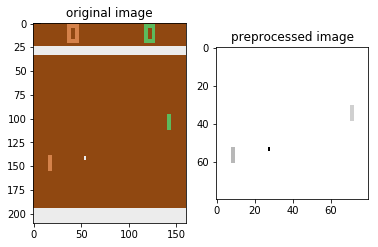

In [3]:
import matplotlib
import matplotlib.pyplot as plt

# show what a preprocessed image looks like
env.reset()
_, _, _, _ = env.step(0)
# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _ = env.step(1)

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')

# 80 x 80 black and white image
plt.imshow(pong_utils.preprocess_single(frame), cmap='Greys')
plt.show()



# Policy

## Exercise 1: Implement your policy
 
Here, we define our policy. The input is the stack of two different frames (which captures the movement), and the output is a number $P_{\rm right}$, the probability of moving left. Note that $P_{\rm left}= 1-P_{\rm right}$

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F



# set up a convolutional neural net
# the output is the probability of moving right
# P(left) = 1-P(right)
class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
        # 80x80x2 to 38x38x4
        # 2 channel from the stacked frame
        self.conv1 = nn.Conv2d(2, 4, kernel_size=6, stride=2, bias=False)
        # 38x38x4 to 9x9x32
        self.conv2 = nn.Conv2d(4, 16, kernel_size=6, stride=4)
        self.size=9*9*16
        
        # two fully connected layer
        self.fc1 = nn.Linear(self.size, 256)
        self.fc2 = nn.Linear(256, 1)

        # Sigmoid to 
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        #Flatten
        x = x.view(-1,self.size)
        x = F.relu(self.fc1(x))
        return self.sig(self.fc2(x))
    

# use your own policy!
policy=Policy().to(device)
#or use the reference one
#policy=pong_utils.Policy().to(device)

# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

# Game visualization
pong_utils contain a play function given the environment and a policy. An optional preprocess function can be supplied. Here we define a function that plays a game and shows learning progress


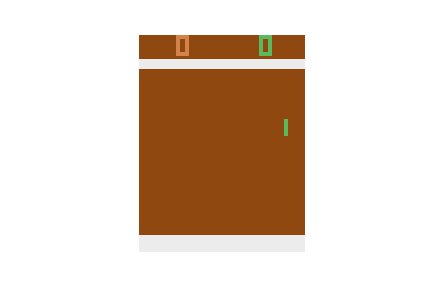
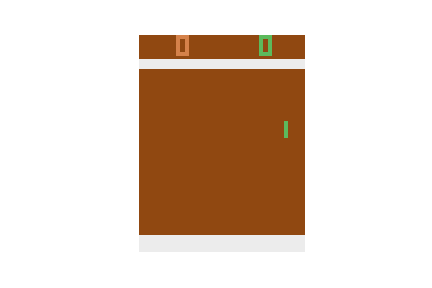
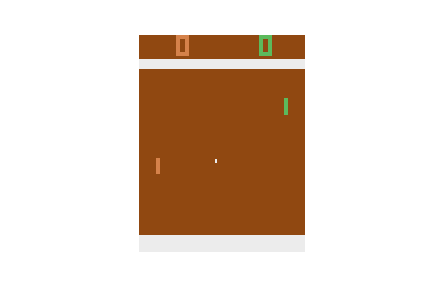
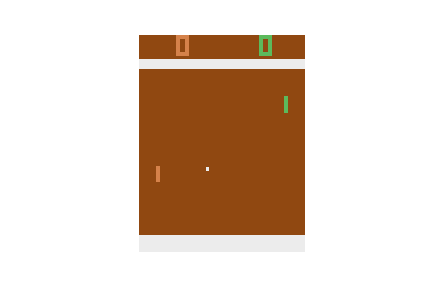
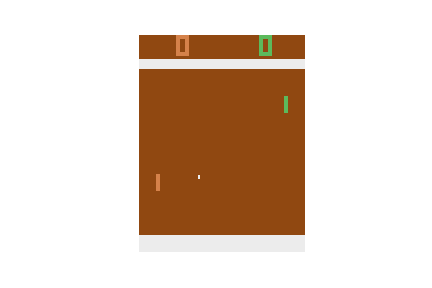
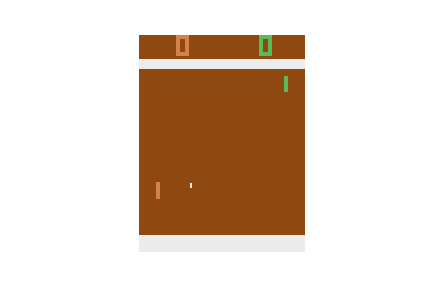
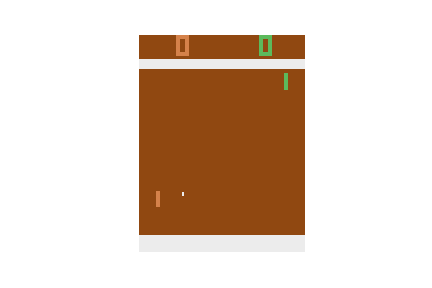
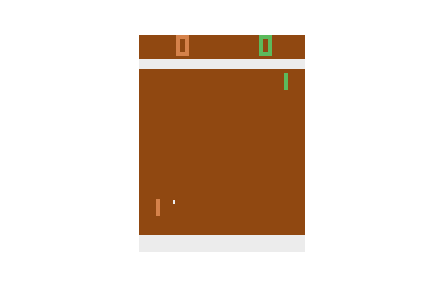
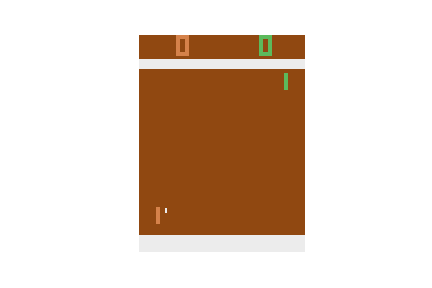
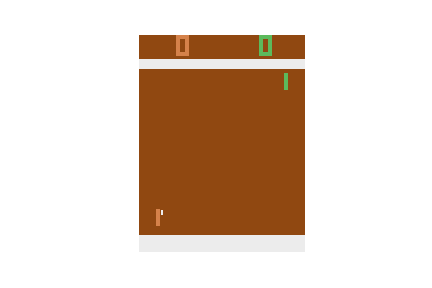
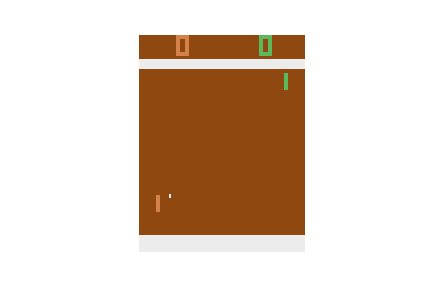
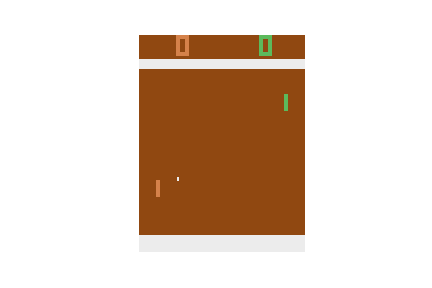
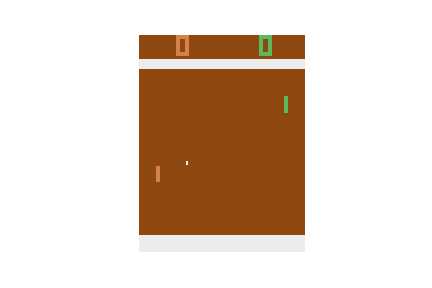
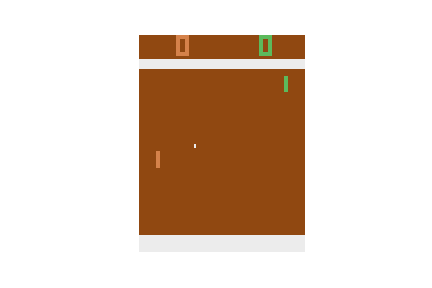
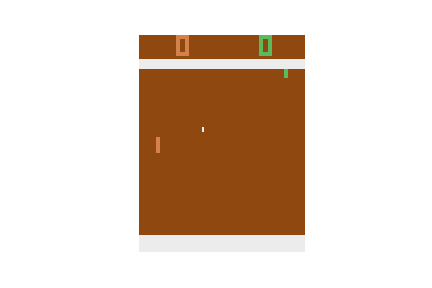
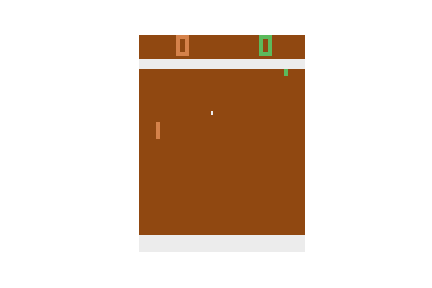
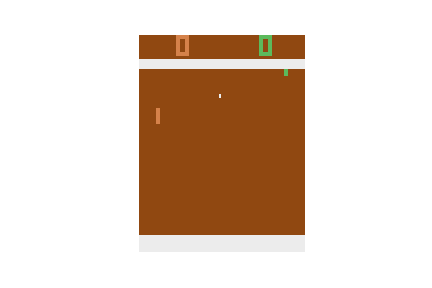
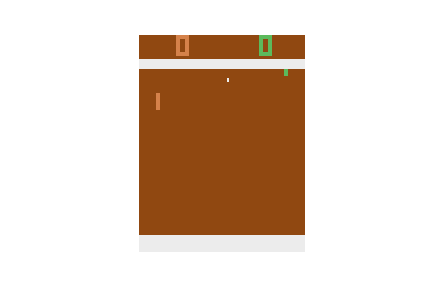
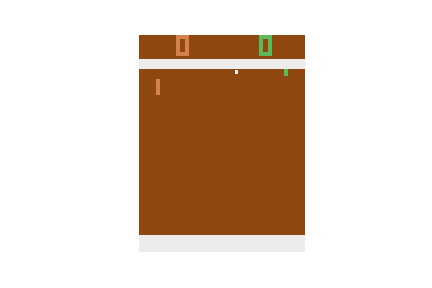
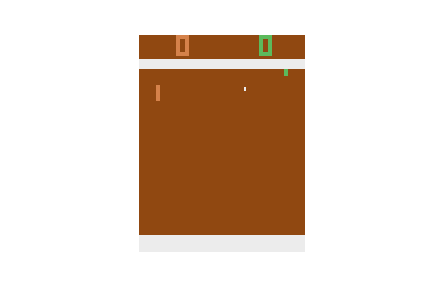
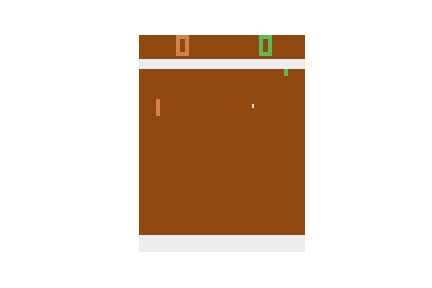
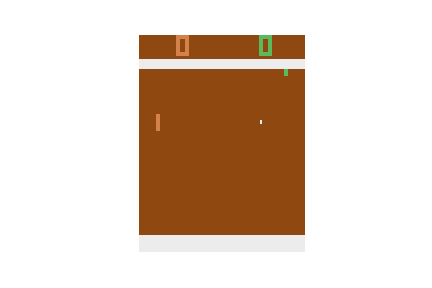
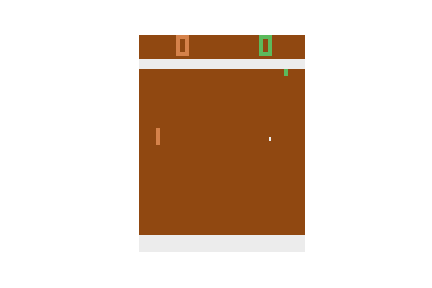
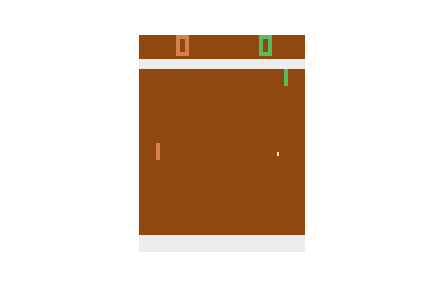
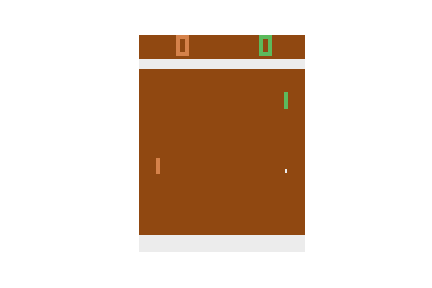
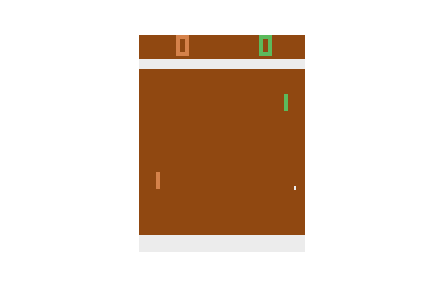
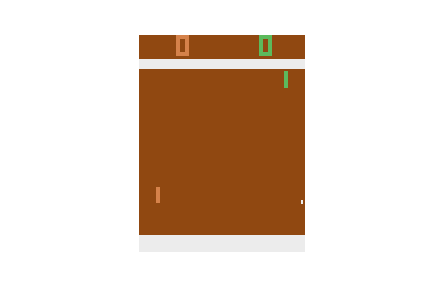
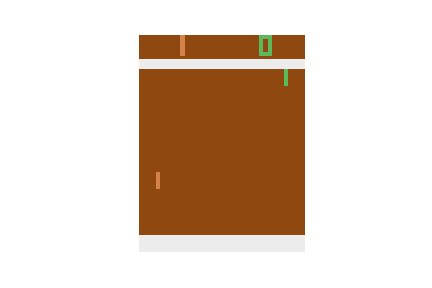
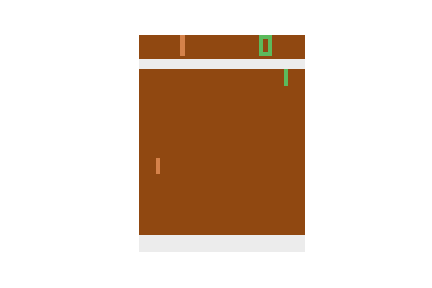
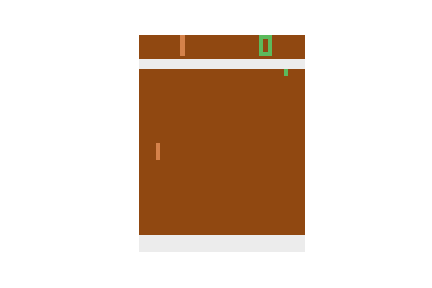
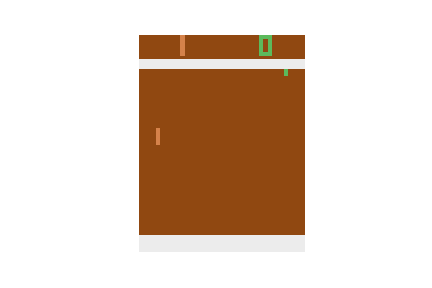
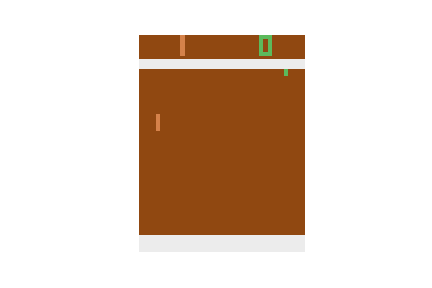
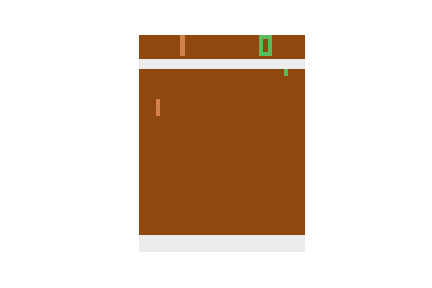
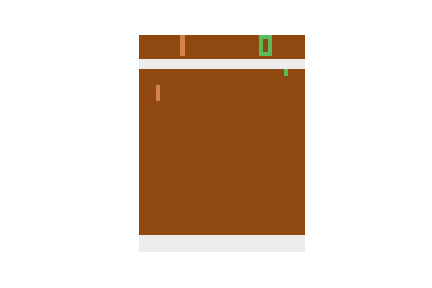
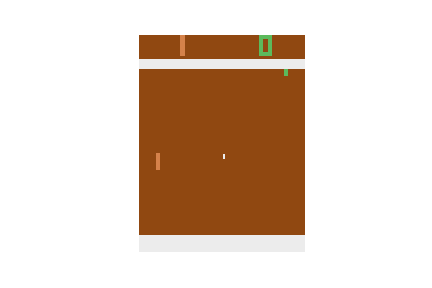
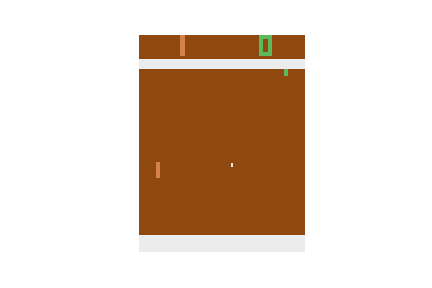
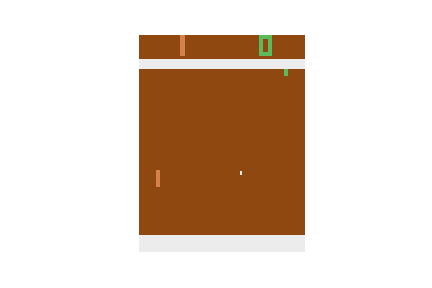
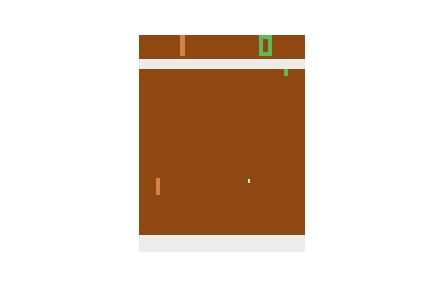
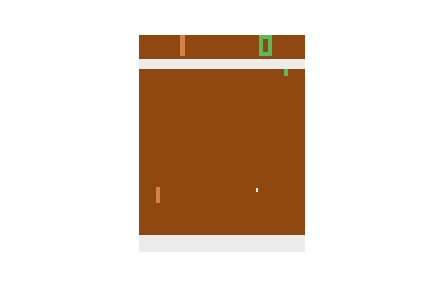
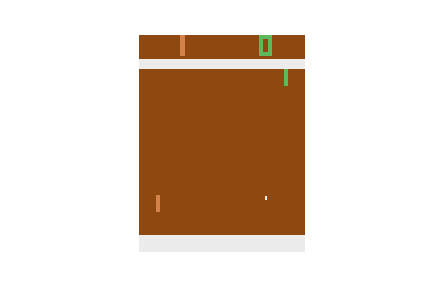
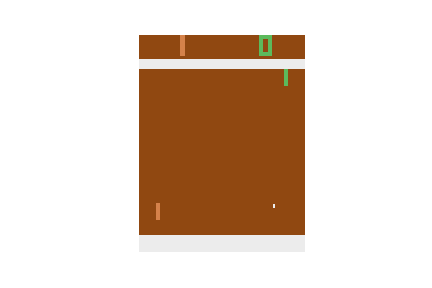
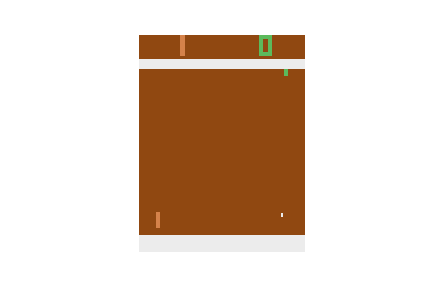
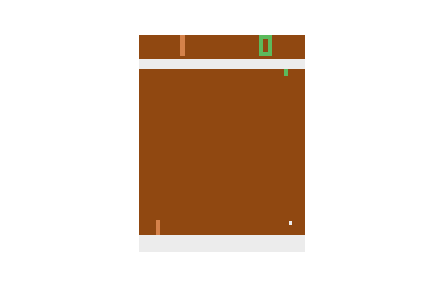
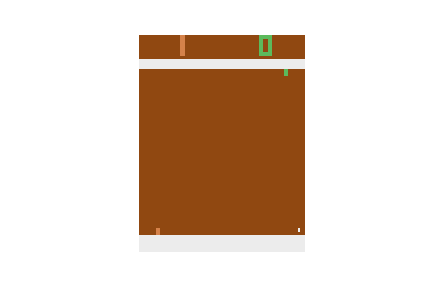
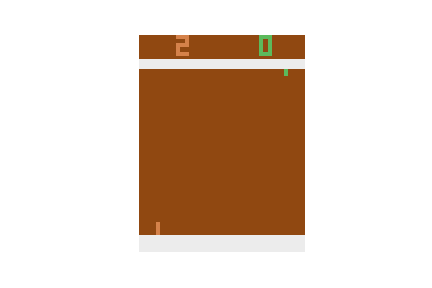
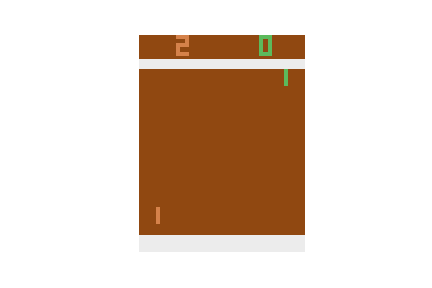
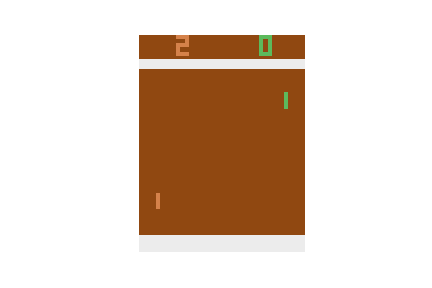
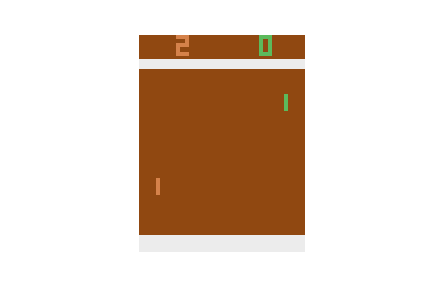
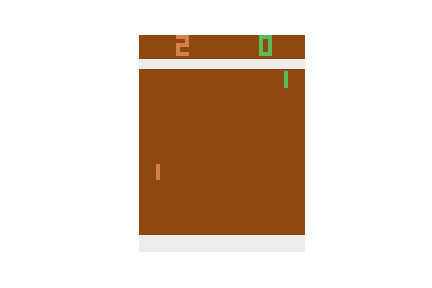
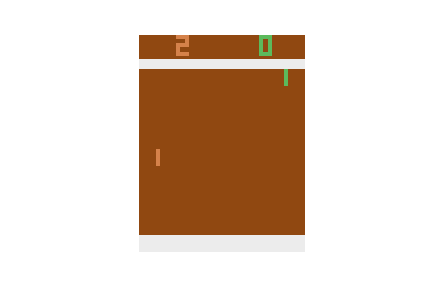
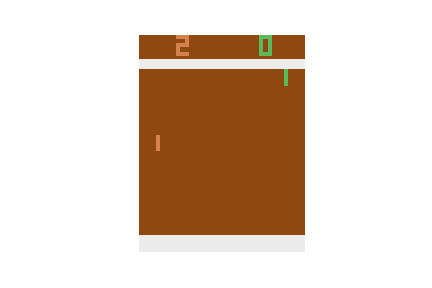
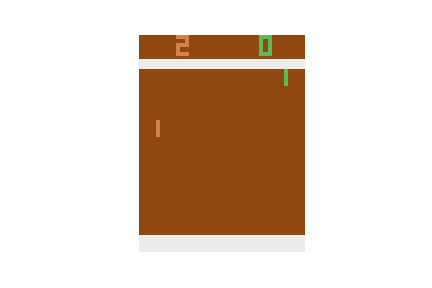
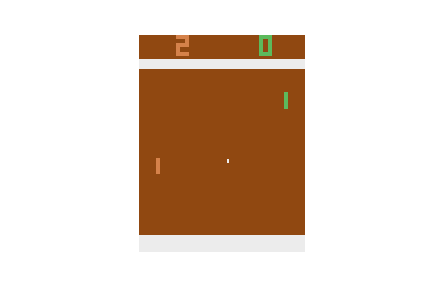
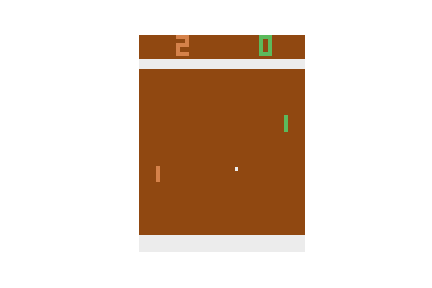
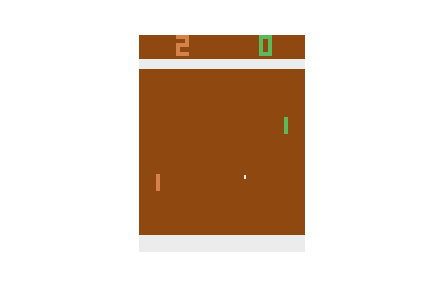
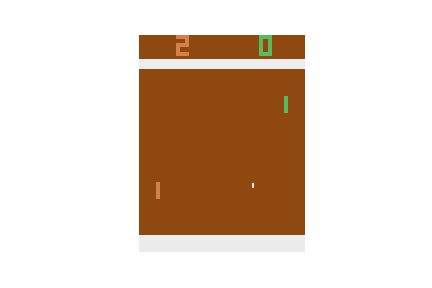
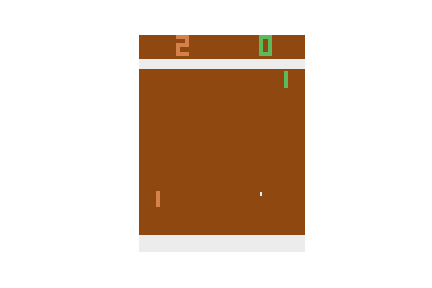
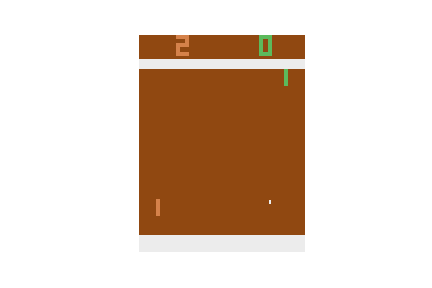
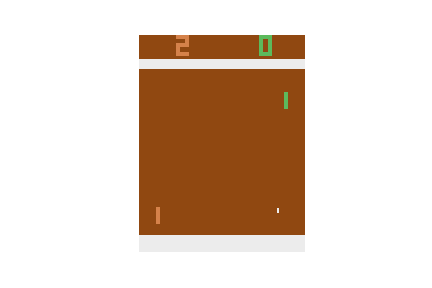
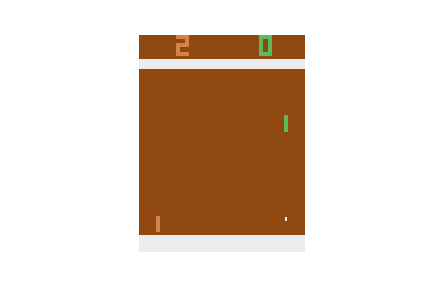
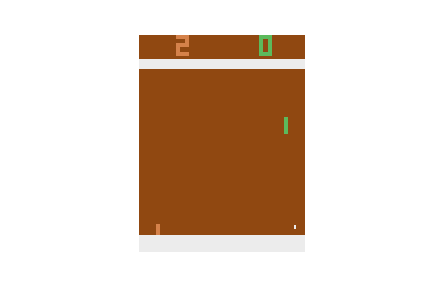
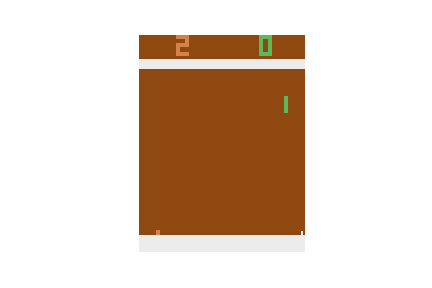
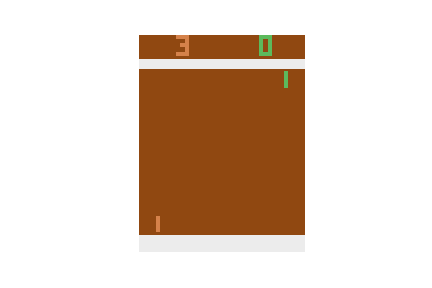
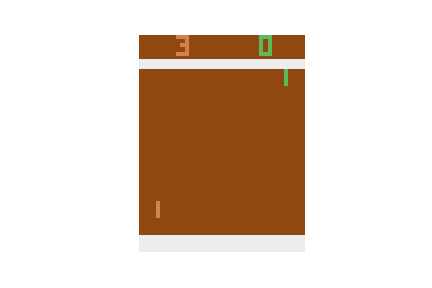
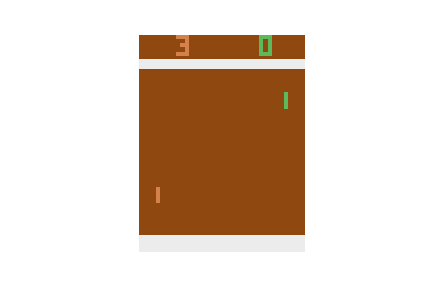
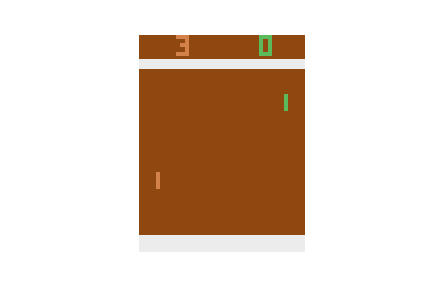
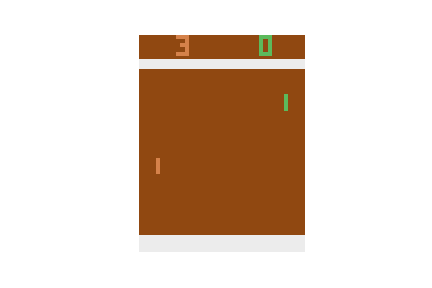
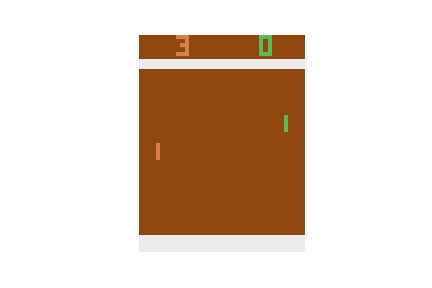
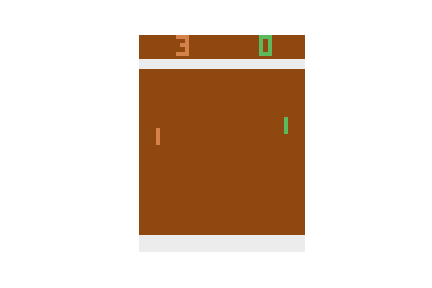
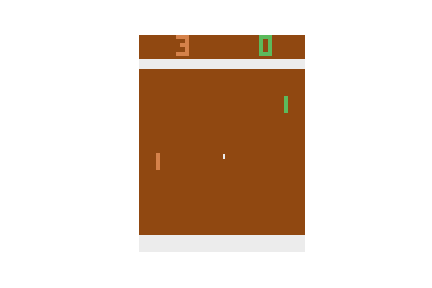
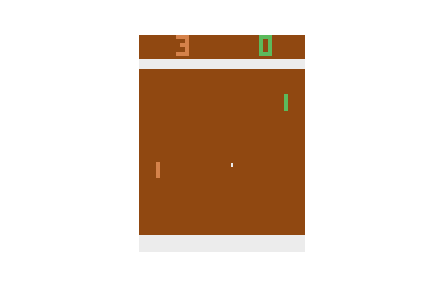
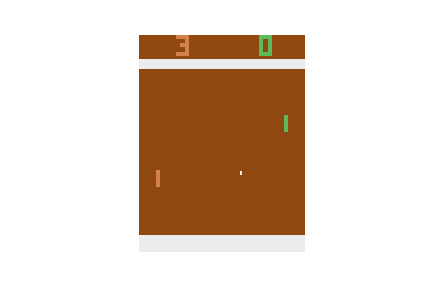
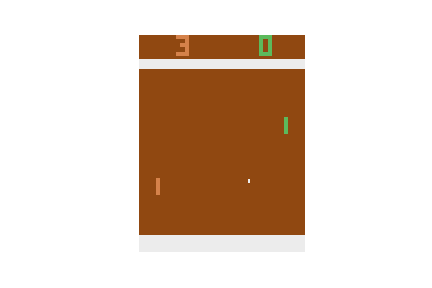
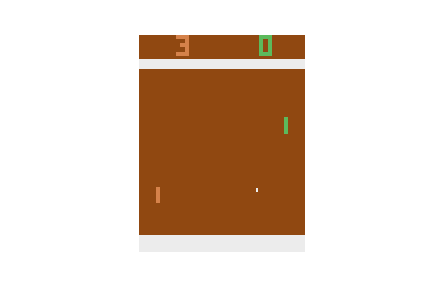
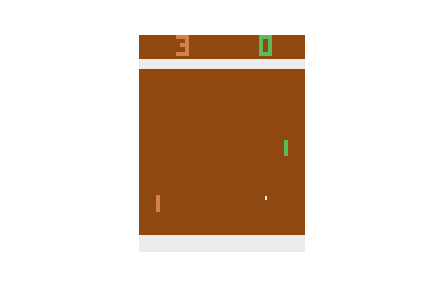
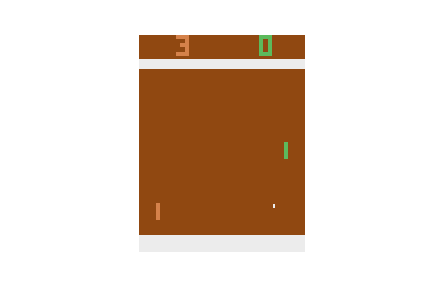
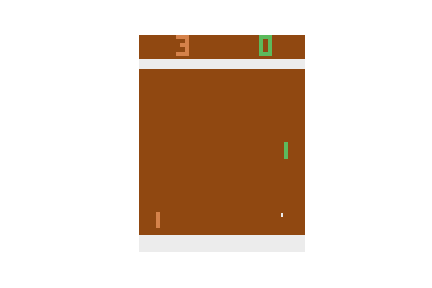
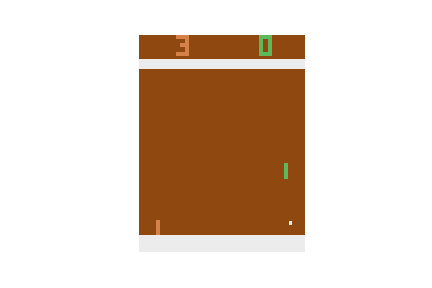
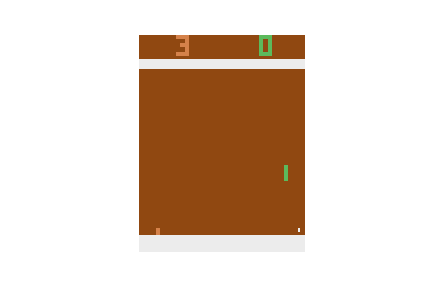
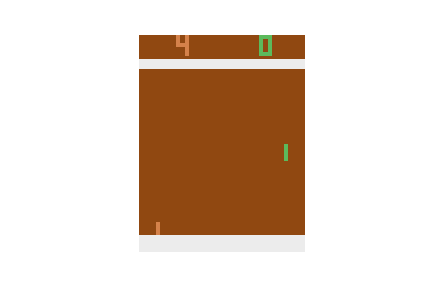
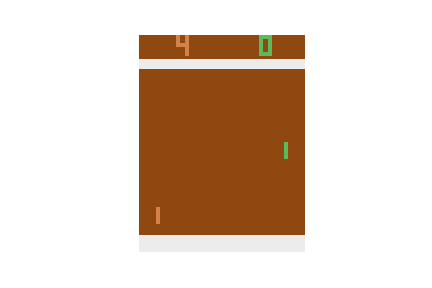
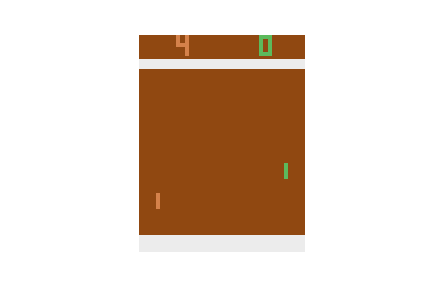
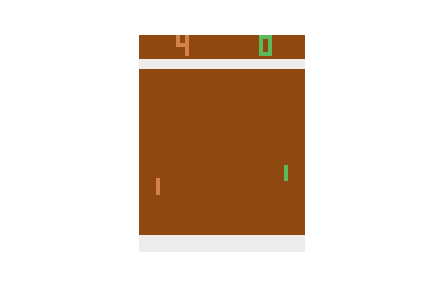
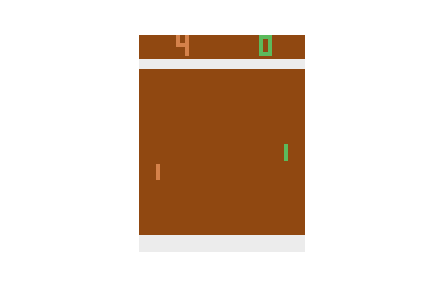
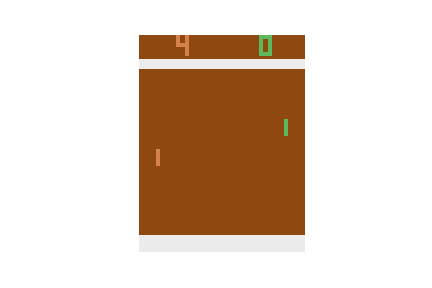
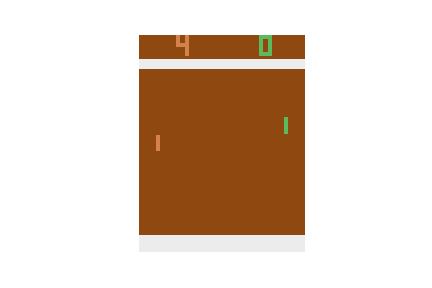
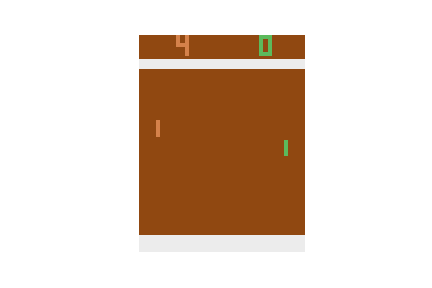
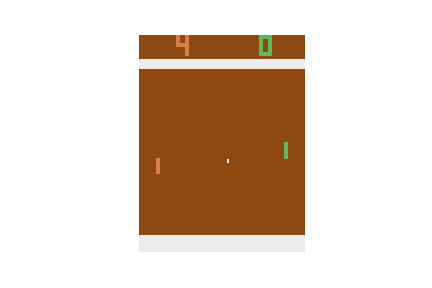
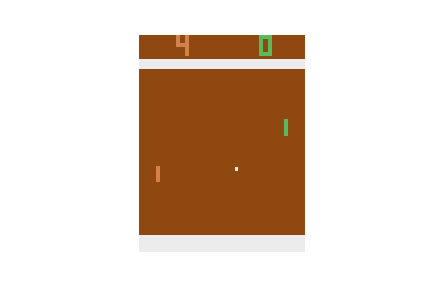
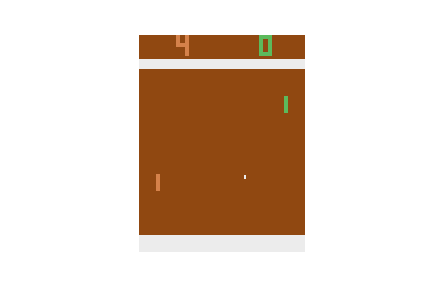
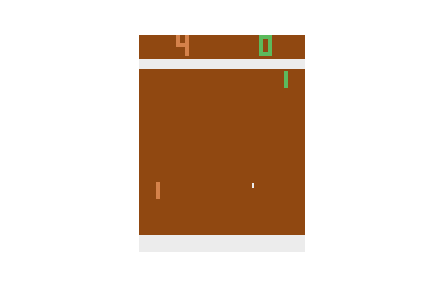
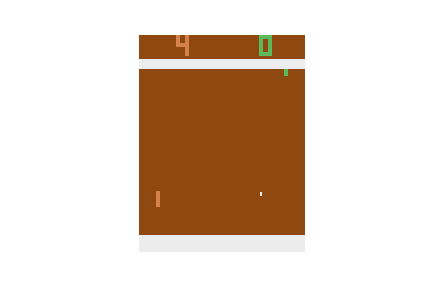
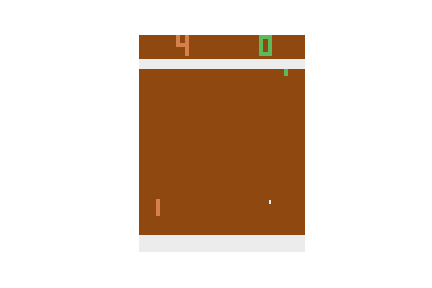
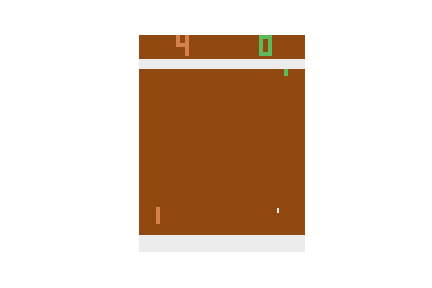
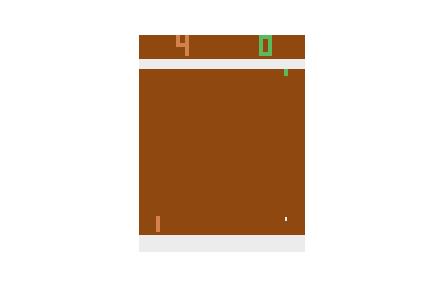
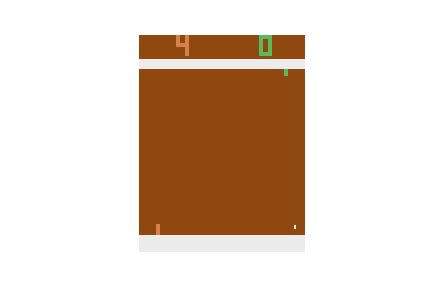
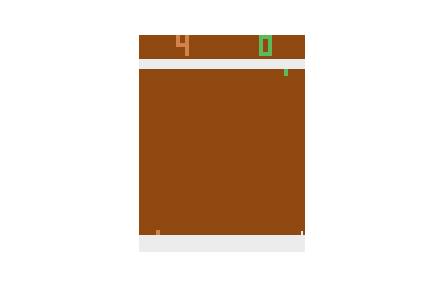
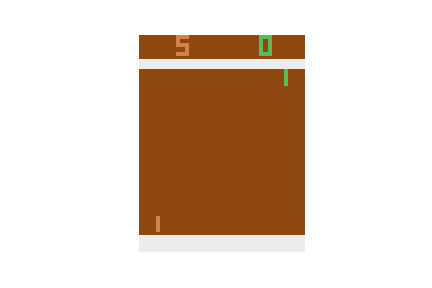
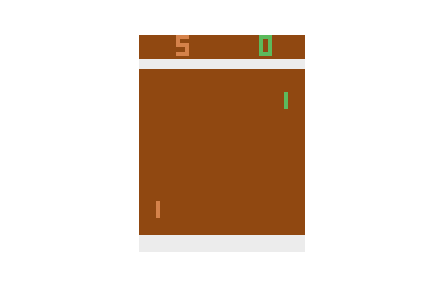
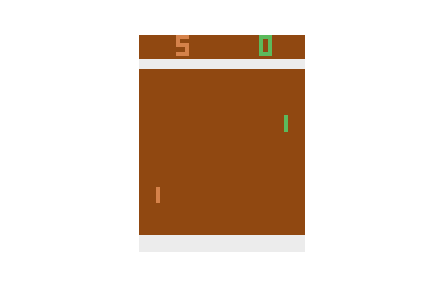

In [5]:
pong_utils.play(env, policy, time=100) 
# try to add the option "preprocess=pong_utils.preprocess_single"
# to see what the agent sees

# Rollout
Before we start the training, we need to collect samples. To make things efficient we use parallelized environments to collect multiple examples at once

In [6]:
envs = pong_utils.parallelEnv('PongDeterministic-v4', n=4, seed=12345)
prob, state, action, reward = pong_utils.collect_trajectories(envs, policy, tmax=100)

In [7]:
print(reward)

[array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([-1., -1., -1., -1.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), array([ 0.,  

# Function Definitions
Here you will define key functions for training. 

## Exercise 2: write your own function for training
(this is the same as policy_loss except the negative sign)

### REINFORCE
you have two choices (usually it's useful to divide by the time since we've normalized our rewards and the time of each trajectory is fixed)

1. $\frac{1}{T}\sum^T_t R_{t}^{\rm future}\log(\pi_{\theta'}(a_t|s_t))$
2. $\frac{1}{T}\sum^T_t R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}$ where $\theta'=\theta$ and make sure that the no_grad is enabled when performing the division

Both of these mean the same thing, the first one is just Theta', so we still end up with the second expression. remember D(ln(x)) = 1/x *x'

In [8]:
# Helper
#Pass states through polict network 
# convert states to probability, passing through the policy
def states_to_prob(policy, states):
    states = torch.stack(states)
    policy_input = states.view(-1,*states.shape[-3:])
    return policy(policy_input).view(states.shape[:-3])

RIGHT=4
LEFT=5

In [9]:
import numpy as np
# return sum of log-prob divided by T
# same thing as -policy_loss
# output a lost function given a trajectory?
def surrogate(policy, old_probs, states, actions, rewards,
              discount = 0.995, beta=0.01):
    
    #Start off by dividing probably
    discount = discount**np.arange(len(rewards))
    rewards = np.asarray(rewards)*discount[:,np.newaxis]
    
    # convert rewards to future rewards
    """
    cumsum Return the cumulative sum of the elements along a given axis
    t 1 2 3 4 5

    r 0 1 2 3 4
    
    backwards 4 3 2 1 0

    fr 10 9 7 4 0  
    
    """
    rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
    
    mean = np.mean(rewards_future, axis=1)
    std = np.std(rewards_future, axis=1) + 1.0e-10

    rewards_normalized = (rewards_future - mean[:,np.newaxis])/std[:,np.newaxis]
    
    # convert everything into pytorch tensors and move to gpu if available
    actions = torch.tensor(actions, dtype=torch.int8, device=device)
    old_probs = torch.tensor(old_probs, dtype=torch.float, device=device)
    rewards = torch.tensor(rewards_normalized, dtype=torch.float, device=device)

    # convert states to policy (or probability)
    new_probs = states_to_prob(policy, states)
    new_probs = torch.where(actions == RIGHT, new_probs, 1.0-new_probs)
    
    #This is the key step
    ratio = new_probs/old_probs
    """
    Intuitively, it adds more cost to actions that too quickly dominate, 
    and the higher cost favors more exploration 
    (on top of the random e-greediness).
    
    .For on-policy models, the same mutual reinforcement behavior 
    will also lead to highly-peaked π(a|s) towards a few actions 
    (or a few fixed action sequences), 
    since it is always easy for both actor and critic to over-optimize
    on a small portion of the environment, 
    and end up “living in their own realities”. To reduce the problem, 
    [Mnih et al. (2016)] 
    added an entropy term to the loss to encourage diversity,
    which we find to be critical.
    """
    #Prevents 0 and 1 from being reached, encouraging exploration
    # include a regularization term
    # this steers new_policy towards 0.5
    # add in 1.e-10 to avoid log(0) which gives nan
    entropy = -(new_probs*torch.log(old_probs+1.e-10)+ \
        (1.0-new_probs)*torch.log(1.0-old_probs+1.e-10))
    
    #Introduce the 1/T implicitly by taking the mean
    return torch.mean(ratio*rewards + beta*entropy)
"""
Loss.backward() calculates the gradients, 
while a call to optimizer.step()
performs a learning step based on the current gradients. 
So, the usual process is to call Loss.backward() 
immediately followed by optimizer.step().
And, you need to obtain L from the surrogate function before using backward() 
to calculate the gradients on L
"""

Lsur= surrogate(policy, prob, state, action, reward)

print(Lsur)

tensor(1.00000e-03 *
       6.9284, device='cuda:0')


# Training
We are now ready to train our policy!
WARNING: make sure to turn on GPU, which also enables multicore processing. It may take up to 45 minutes even with GPU enabled, otherwise it will take much longer!

In [10]:
from parallelEnv import parallelEnv
import numpy as np
# WARNING: running through all 800 episodes will take 30-45 minutes

# training loop max iterations
episode = 1000
# episode = 800

# widget bar to display progress
!pip install progressbar
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()

# initialize environment
envs = parallelEnv('PongDeterministic-v4', n=8, seed=1234)

discount_rate = .99
beta = .01
tmax = 320

# keep track of progress
mean_rewards = []

for e in range(episode):

    # collect trajectories
    old_probs, states, actions, rewards = \
        pong_utils.collect_trajectories(envs, policy, tmax=tmax)
        
    total_rewards = np.sum(rewards, axis=0)

    # this is the SOLUTION! perform gradient ascent
    # use your own surrogate function
    # L = -surrogate(policy, old_probs, states, actions, rewards, beta=beta)
    """
    zero_grad clears old gradients from the last step (otherwise you’d just accumulate the gradients from all loss.backward() calls).
    loss.backward() computes the derivative of the loss w.r.t. the parameters (or anything requiring gradients) using backpropagation.
    opt.step() causes the optimizer to take a step based on the gradients of the parameters.
    
    SideNote regarding explicit vs implict gradient calculation

In PyTorch the backward function computes dloss/dx for every parameter x which has requires_grad=True. These are accumulated into x.grad for every parameter x.

optimizer.step updates the value of x using the gradient x.grad.

And optimizer.zero_grad() clears x.grad for every parameter x in the optimizer. 
It’s important to call this before loss.backward(), otherwise you’ll accumulate the gradients from multiple passes.

In the above code the loss sum of all (-log_prob) * R, the gradient is calculated on it, and all the parameter which have requires_grad=True will be updated.
    """
    L = -pong_utils.surrogate(policy, old_probs, states, actions, rewards, beta=beta)
    optimizer.zero_grad()
    L.backward()
    optimizer.step()
    del L
        
    # the regulation term also reduces
    # this reduces exploration in later runs
    beta*=.995
    
    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))
    
    # display some progress every 20 iterations
    if (e+1)%20 ==0 :
        print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
        print(total_rewards)
        
    # update progress widget bar
    timer.update(e+1)
    
timer.finish()
    

Episode: 20, score: -14.625000
[-14. -15. -15. -16. -12. -15. -15. -15.]


Episode: 40, score: -13.500000
[-14. -13. -16. -16. -13. -13. -11. -12.]


Episode: 60, score: -14.500000
[-15. -14. -16. -16. -16. -11. -14. -14.]


Episode: 80, score: -14.500000
[-16. -14. -15. -16. -16.  -8. -17. -14.]


Episode: 100, score: -14.000000
[-16. -16. -16. -12. -14. -15.  -9. -14.]


Episode: 120, score: -15.250000
[-16. -12. -16. -16. -16. -16. -14. -16.]


Episode: 140, score: -14.500000
[-17. -16. -13. -13. -15. -16. -12. -14.]


Episode: 160, score: -14.625000
[-16. -16. -11. -13. -16. -14. -15. -16.]


Episode: 180, score: -14.750000
[-16. -16. -16. -15. -15. -16. -11. -13.]


Episode: 200, score: -15.250000
[-16. -16. -15. -16. -15. -16. -12. -16.]


Episode: 220, score: -14.875000
[-16. -16. -13. -12. -16. -15. -15. -16.]


Episode: 240, score: -14.125000
[-14. -11.  -8. -16. -16. -15. -16. -17.]


Episode: 260, score: -12.875000
[-12. -16. -10. -11. -15. -11. -12. -16.]


Episode: 280, score: -13.375000
[-13. -11. -16.  -9. -16. -15. -14. -13.]


Episode: 300, score: -13.250000
[ -9. -10. -14. -14. -14. -15. -14. -16.]


Episode: 320, score: -15.250000
[-16. -14. -15. -14. -16. -16. -15. -16.]


Episode: 340, score: -12.875000
[-13. -14. -16. -10.  -8. -12. -15. -15.]


Episode: 360, score: -14.875000
[-14. -15. -14. -15. -15. -16. -13. -17.]


Episode: 380, score: -14.375000
[-14. -10. -13. -16. -16. -16. -15. -15.]


Episode: 400, score: -12.875000
[-13. -13. -14. -12.  -8. -15. -16. -12.]


Episode: 420, score: -13.250000
[ -7. -12. -13. -15. -16. -13. -14. -16.]


Episode: 440, score: -13.375000
[-11. -16. -16. -14. -12. -13. -11. -14.]


Episode: 460, score: -12.875000
[-15. -14. -10. -12. -16. -10. -14. -12.]


Episode: 480, score: -12.625000
[-13. -12. -11. -15. -13.  -8. -14. -15.]


Episode: 500, score: -14.000000
[-15. -10. -16. -14. -13. -13. -15. -16.]


Episode: 520, score: -12.625000
[-15. -12. -12. -10. -16. -12. -10. -14.]


Episode: 540, score: -10.875000
[-12.  -9.  -6. -12. -11. -13. -12. -12.]


Episode: 560, score: -11.125000
[-10.  -8. -12. -14. -12. -11. -10. -12.]


Episode: 580, score: -9.750000
[ -4. -14. -10. -10. -12. -13.  -4. -11.]


Episode: 600, score: -8.875000
[-12.  -5. -10. -13.  -8.  -4.  -9. -10.]


Episode: 620, score: -8.625000
[ -7.  -9. -10.  -9.  -4. -13.  -6. -11.]


Episode: 640, score: -10.625000
[ -8. -10.  -6. -13. -10. -14. -14. -10.]


Episode: 660, score: -9.125000
[ -7.  -9.  -4. -10. -11. -13. -13.  -6.]


Episode: 680, score: -7.125000
[ -4. -10.  -8.  -6.  -6.  -4.  -9. -10.]


Episode: 700, score: -8.875000
[-10.  -8. -10. -12.  -7.  -9.  -9.  -6.]


Episode: 720, score: -7.500000
[-12. -11.  -6.  -8.  -4.  -8.  -5.  -6.]


Episode: 740, score: -5.500000
[ -4.  -4.  -5.  -7.  -7.  -5. -10.  -2.]


Episode: 760, score: -5.250000
[ -6. -10.  -7.  -5.  -5.  -2.  -3.  -4.]


Episode: 780, score: -4.875000
[-6. -4. -6. -7. -6. -8. -2.  0.]


Episode: 800, score: -3.250000
[-3. -8. -2. -1. -3. -4. -1. -4.]


Episode: 820, score: -3.125000
[ -1.  -1.  -3. -10.  -4.   1.  -2.  -5.]


Episode: 840, score: -2.875000
[-1. -5. -6. -3. -1.  2. -7. -2.]


Episode: 860, score: -3.625000
[ 2. -4. -5. -5. -9. -3. -3. -2.]


Episode: 880, score: -3.250000
[-1. -5. -5. -2. -3. -1. -6. -3.]


Episode: 900, score: -2.125000
[-1. -4. -1. -2. -6. -1. -1. -1.]


Episode: 920, score: -2.625000
[-1. -6. -3. -6. -1. -3.  0. -1.]


Episode: 940, score: -1.875000
[-1. -1. -1. -5. -5. -1.  0. -1.]


Episode: 960, score: -1.750000
[-1. -1. -5. -1. -2. -2. -1. -1.]


Episode: 980, score: -1.125000
[-1. -1. -2. -1.  0. -1. -1. -2.]


Episode: 1000, score: -1.875000
[-2. -1. -6. -1. -2. -1. -1. -1.]



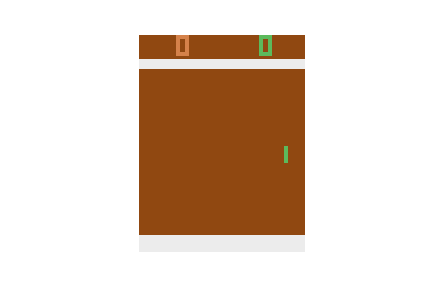
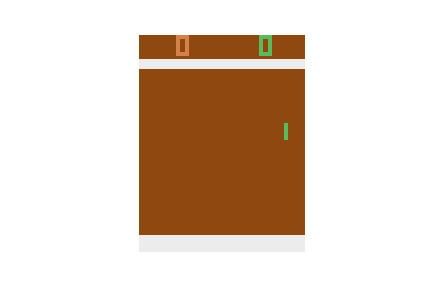
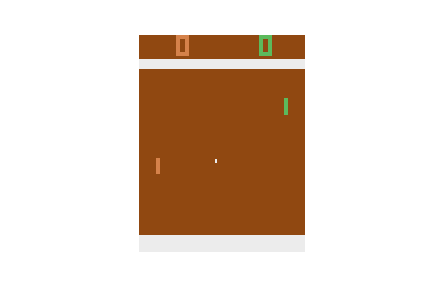
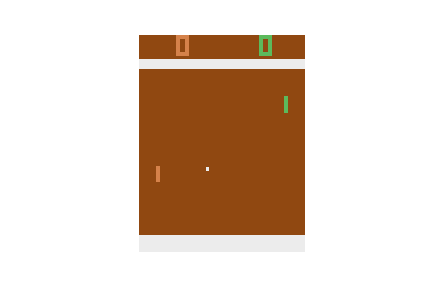
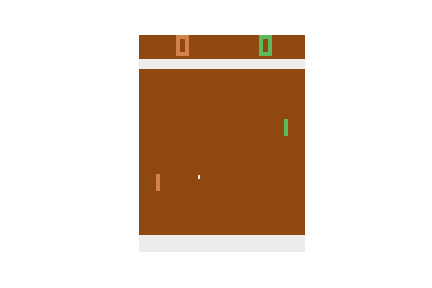
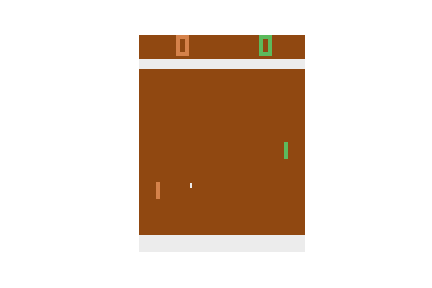
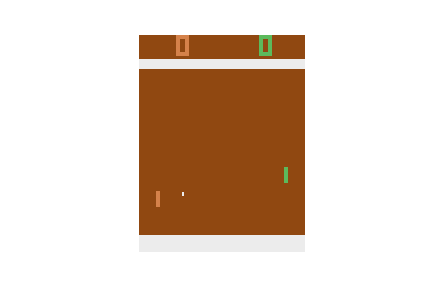
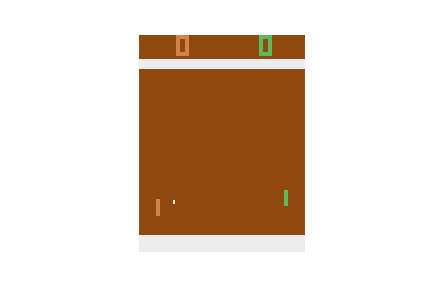
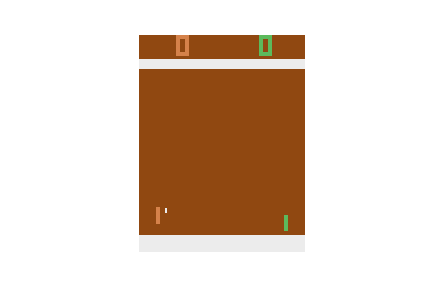
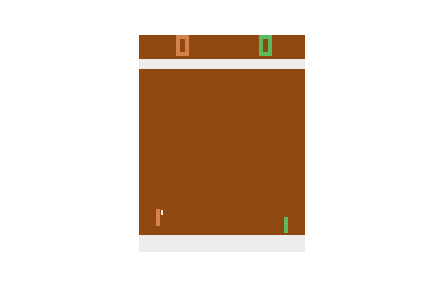
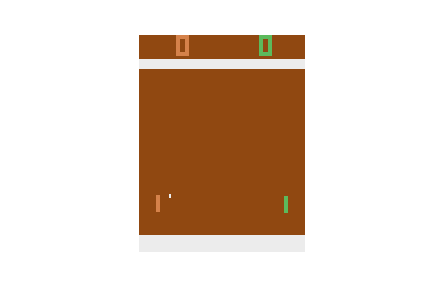
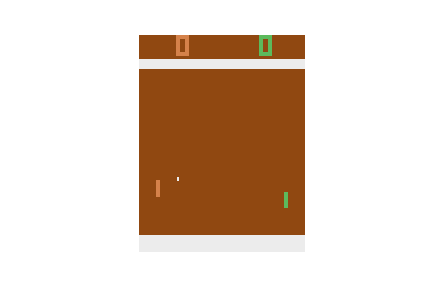
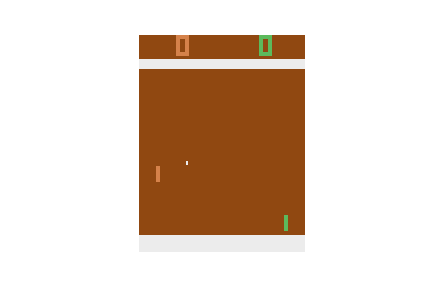
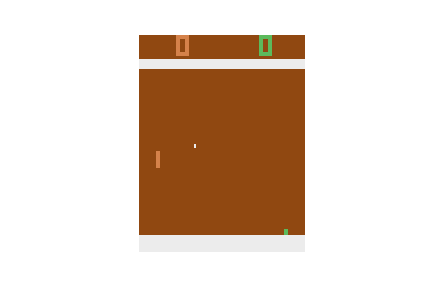
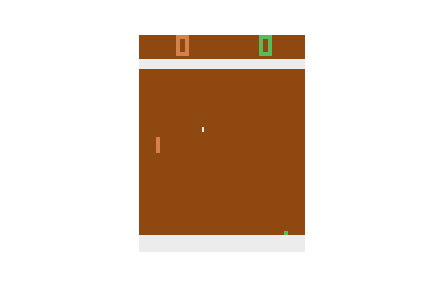
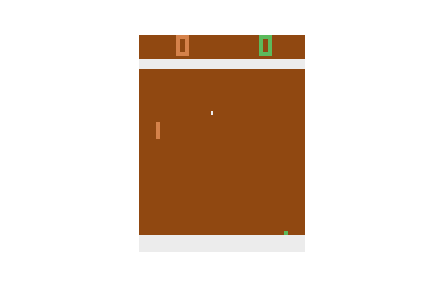
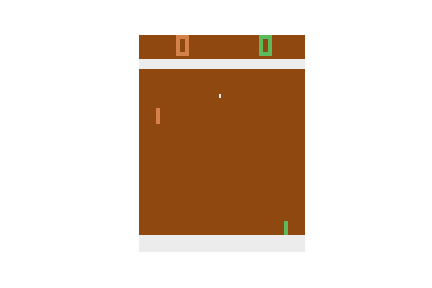
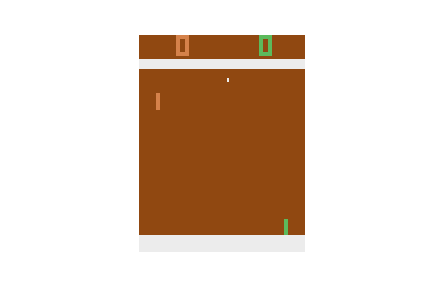
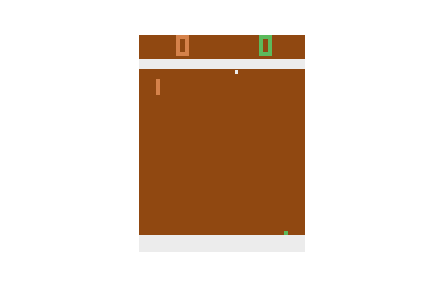
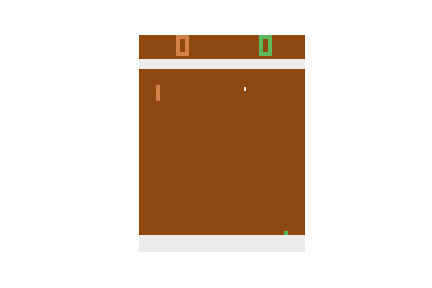
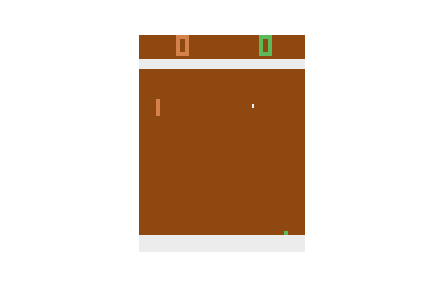
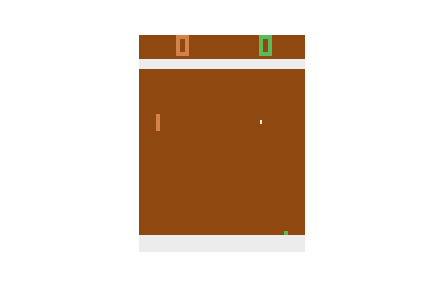
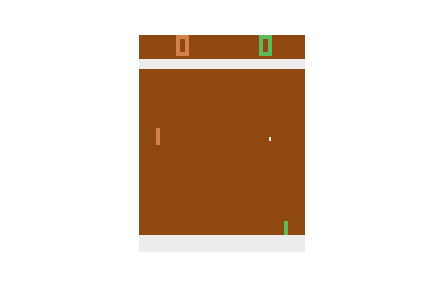
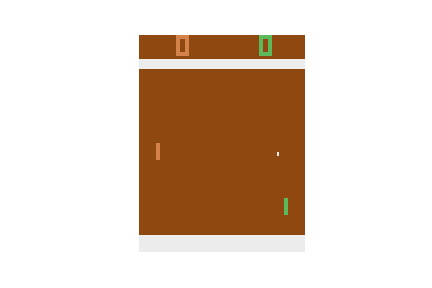
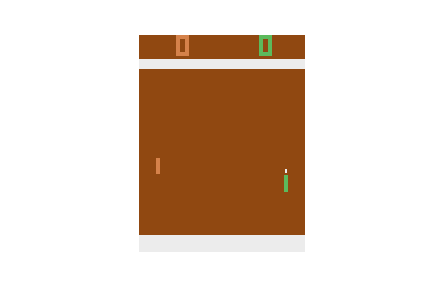
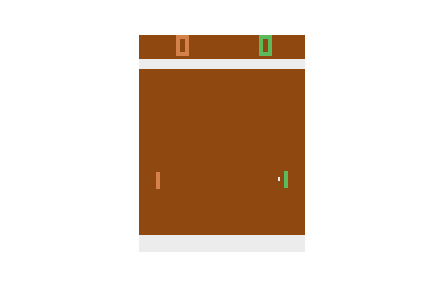
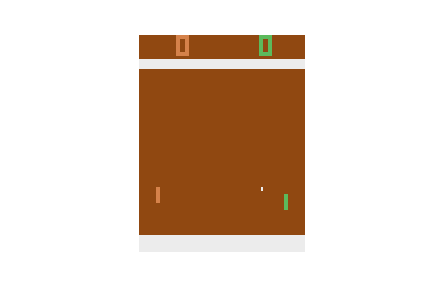
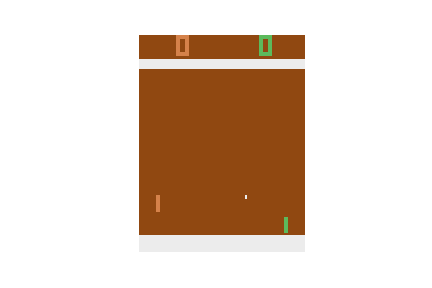
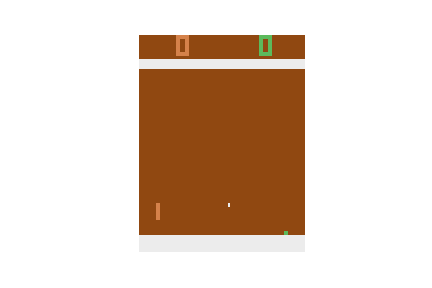
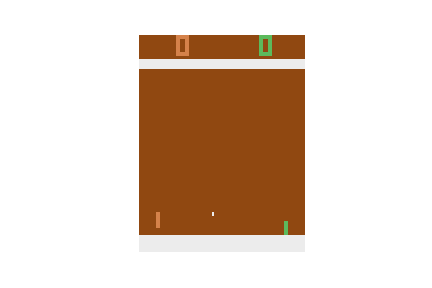
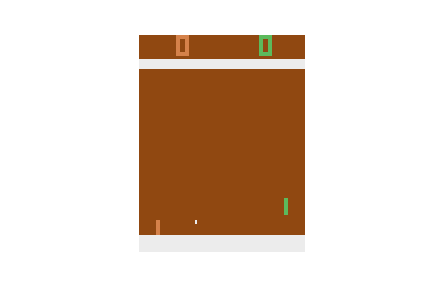
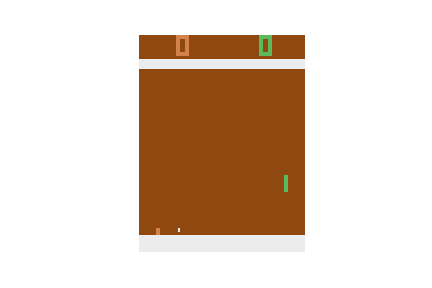
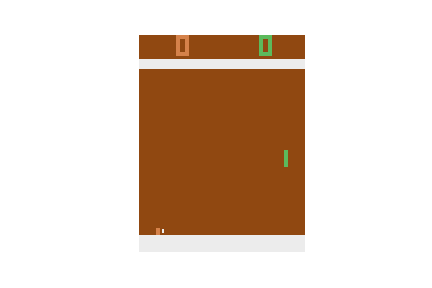
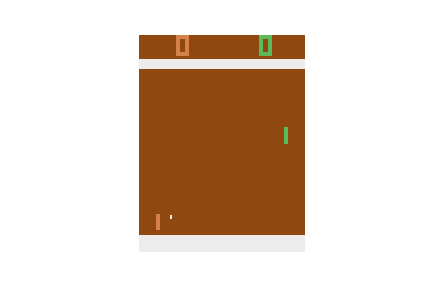
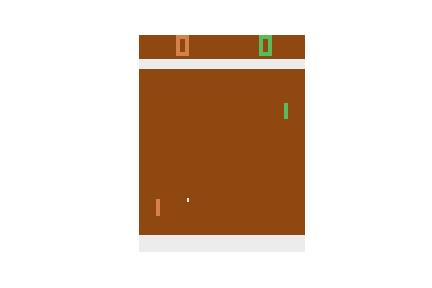
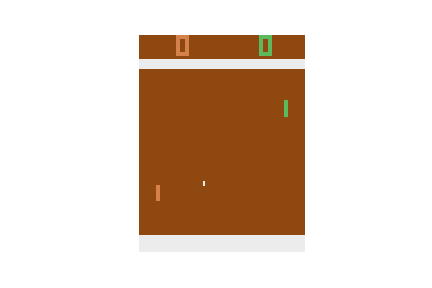
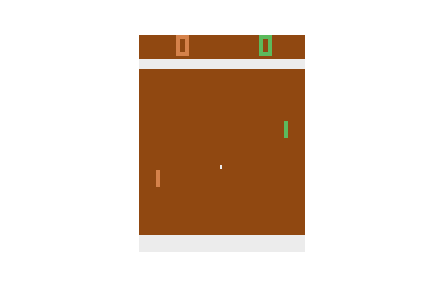
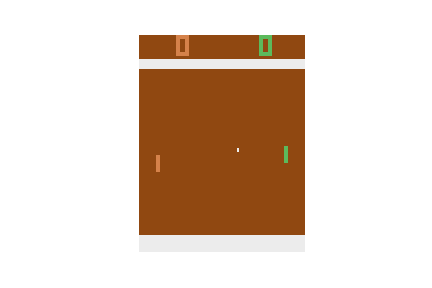
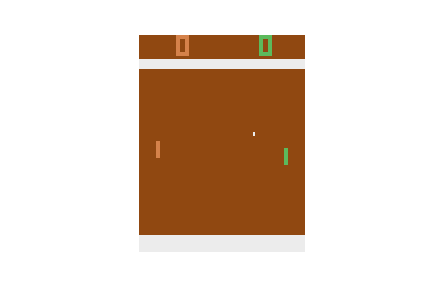
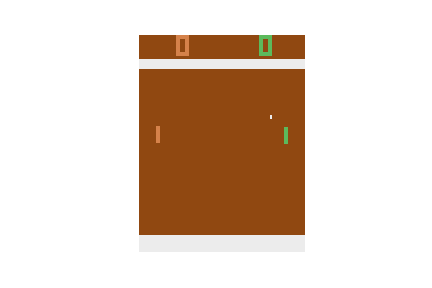
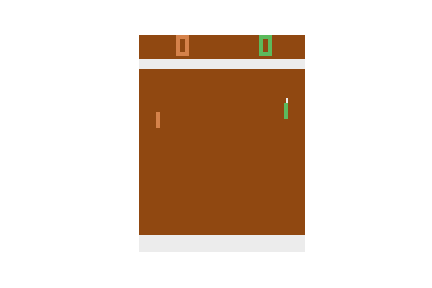
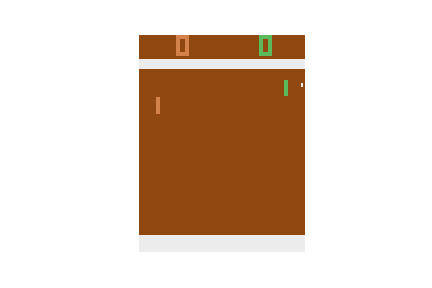
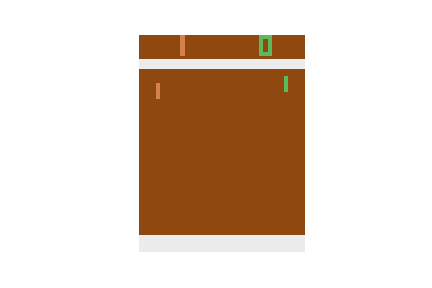
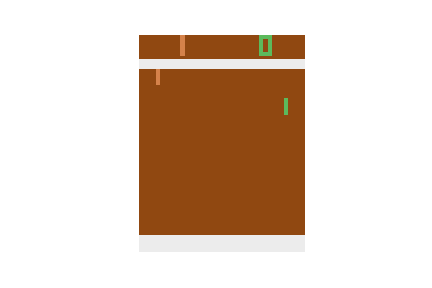
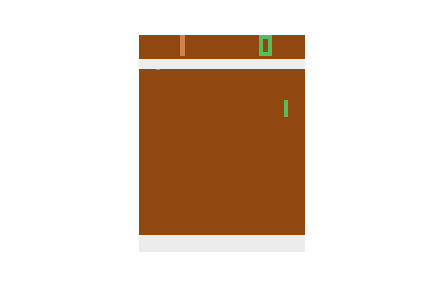
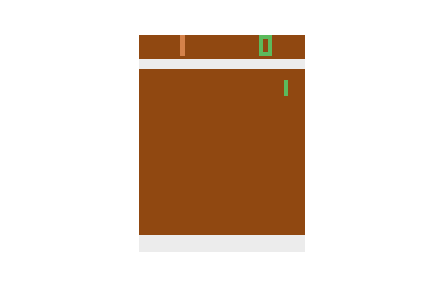
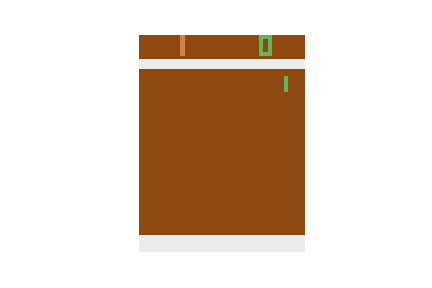
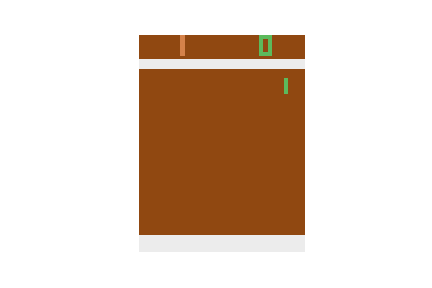
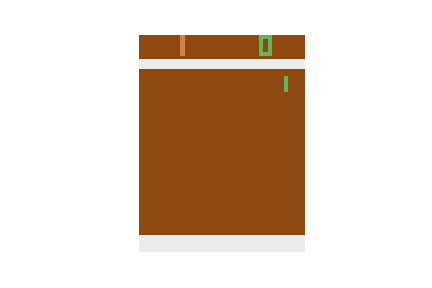
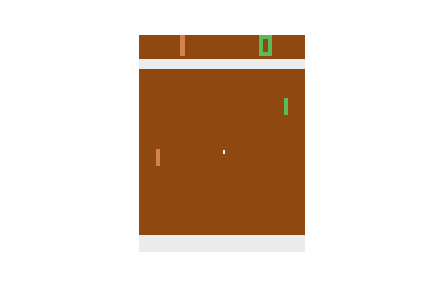
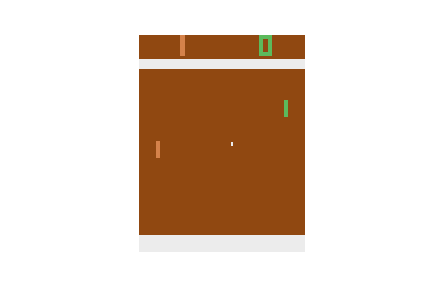
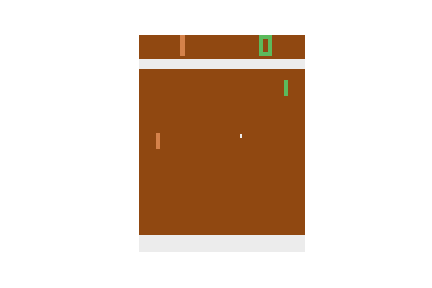
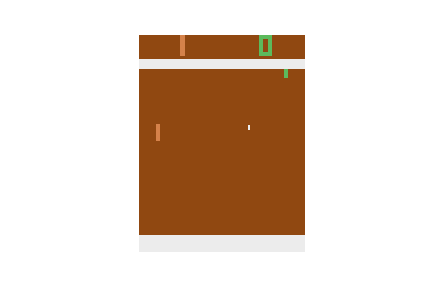
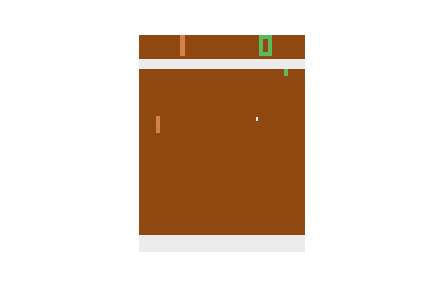
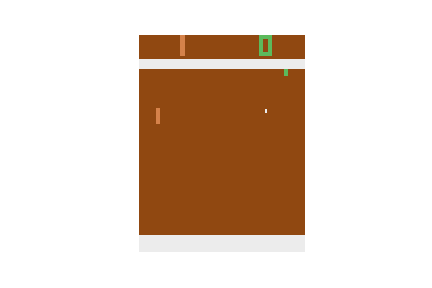
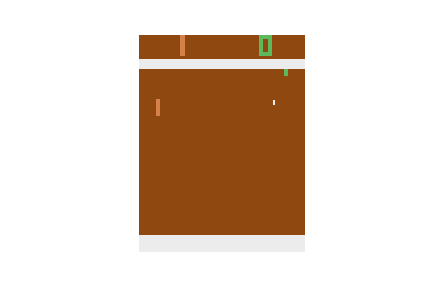
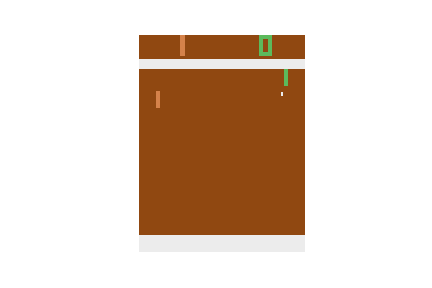
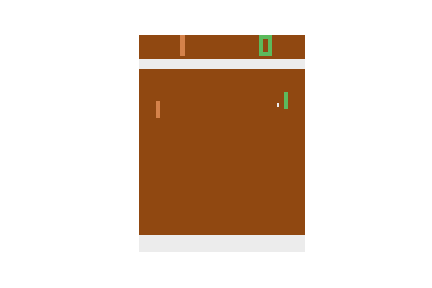
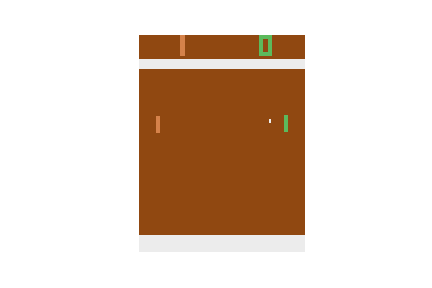
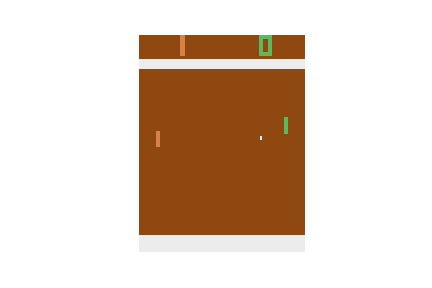
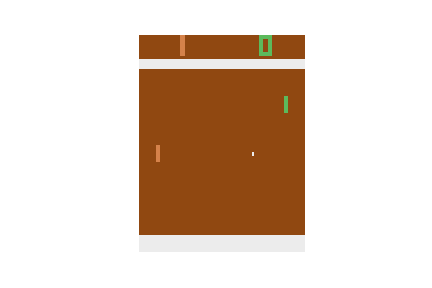
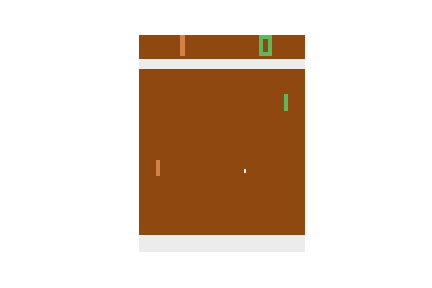
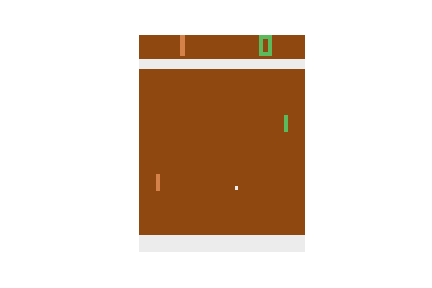
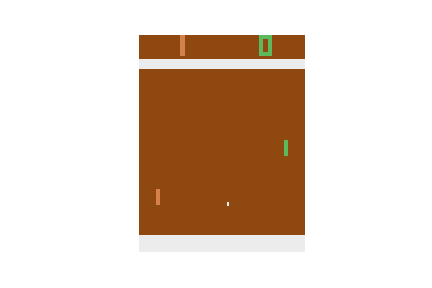
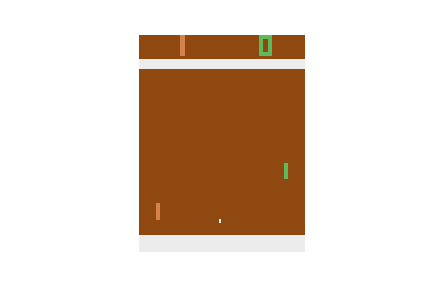
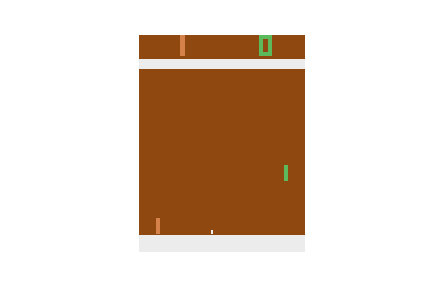
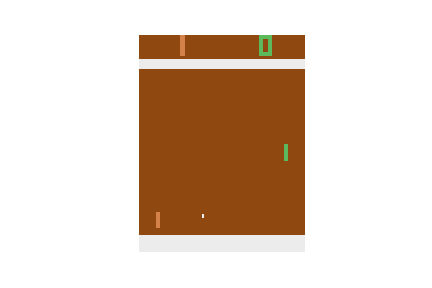
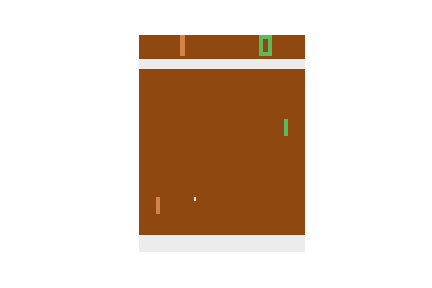
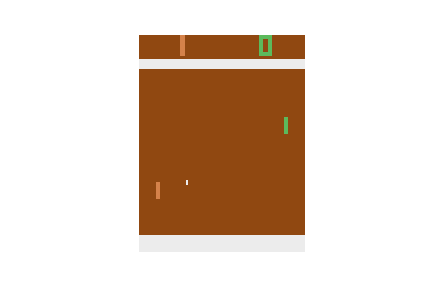
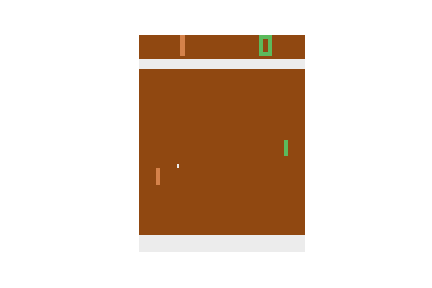
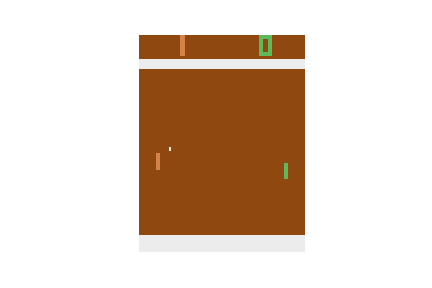
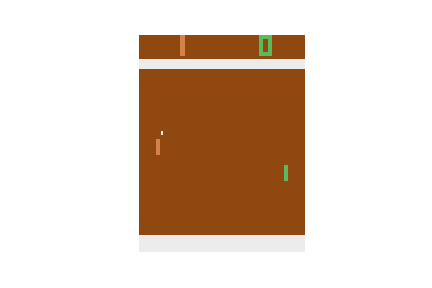
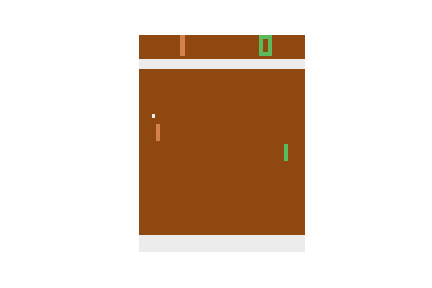
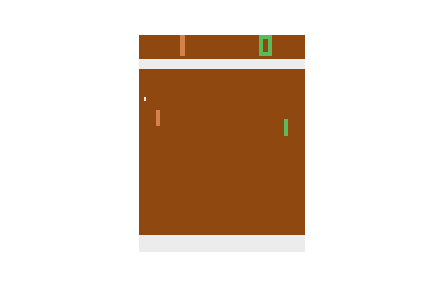
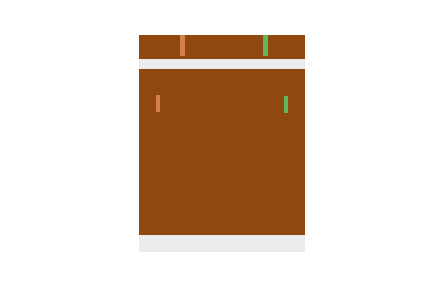
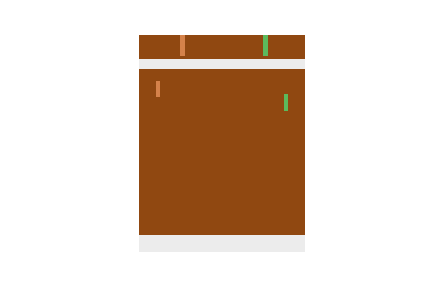
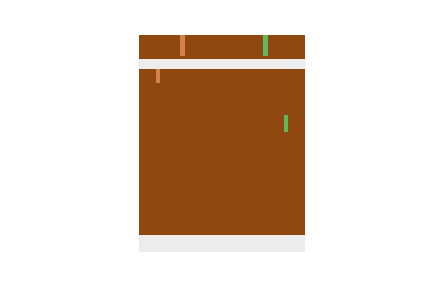
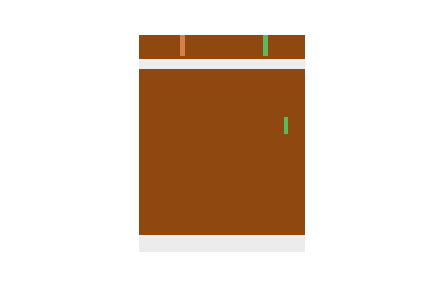
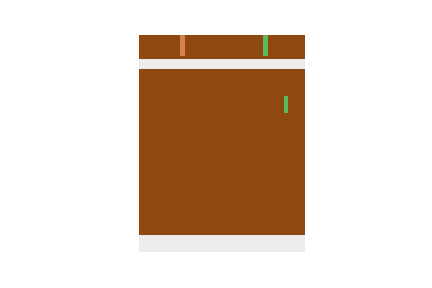
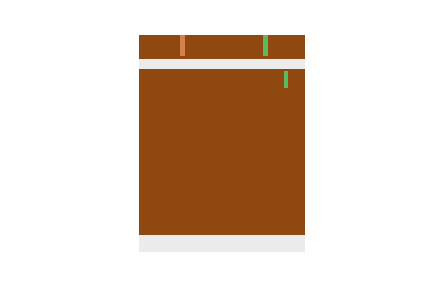
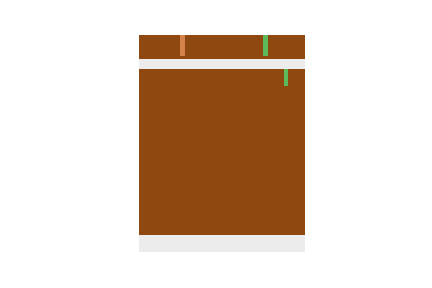
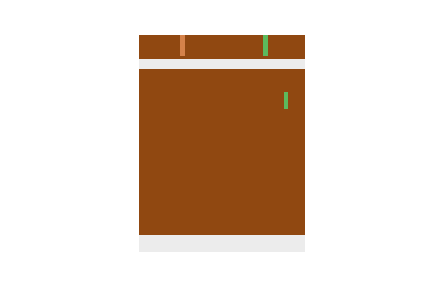
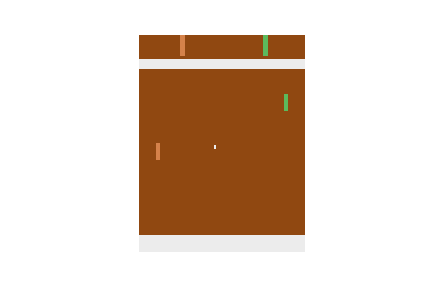
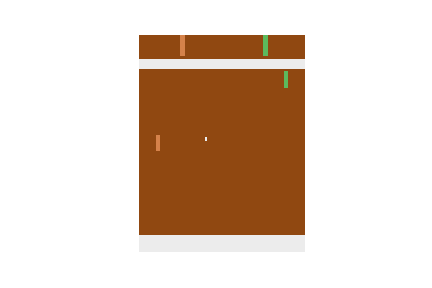
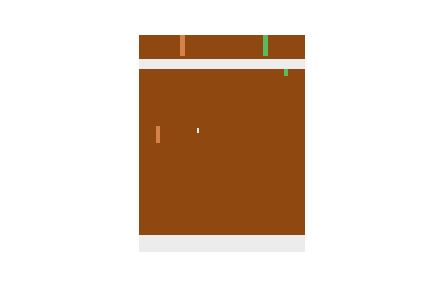
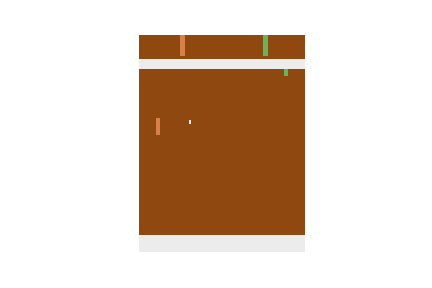
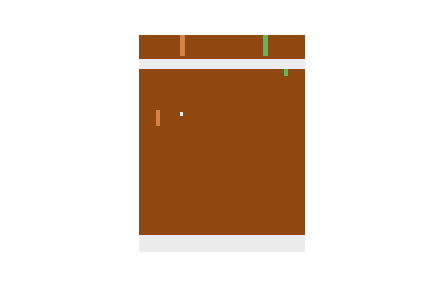
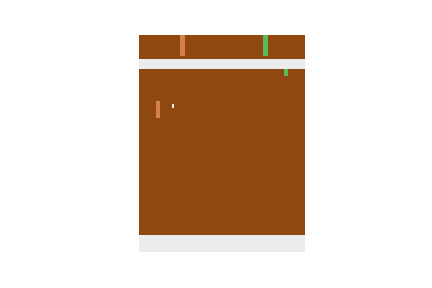
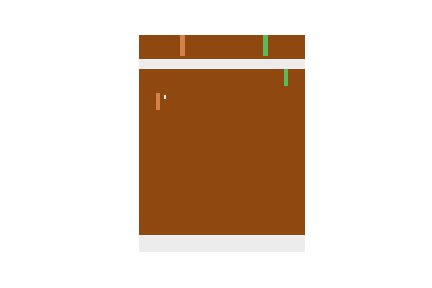
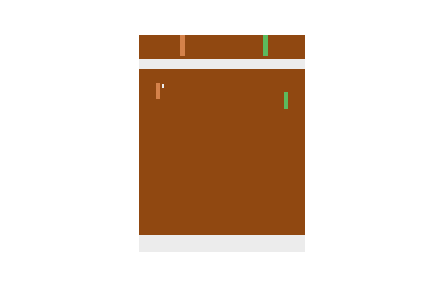
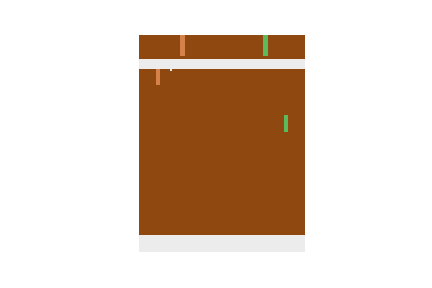
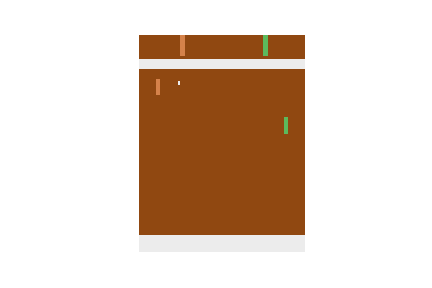
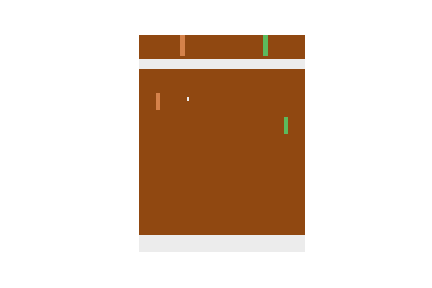
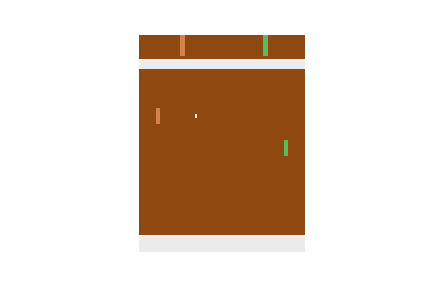
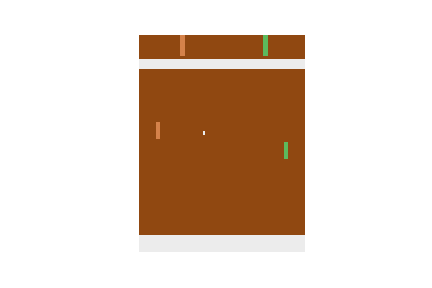
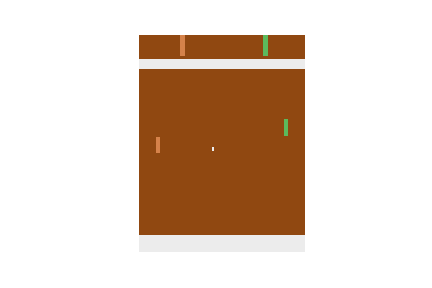
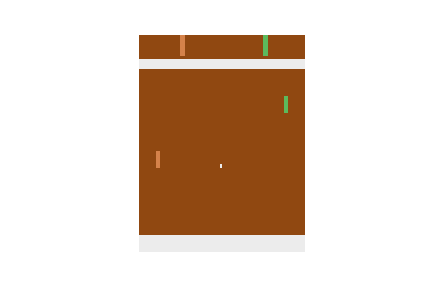
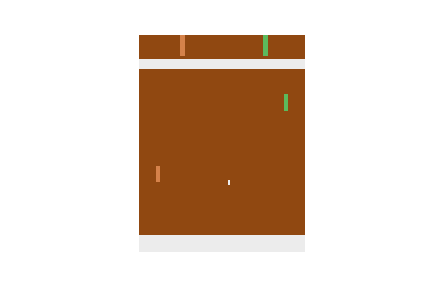
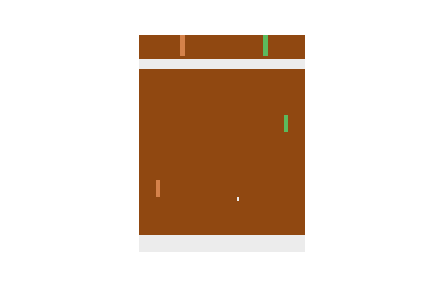
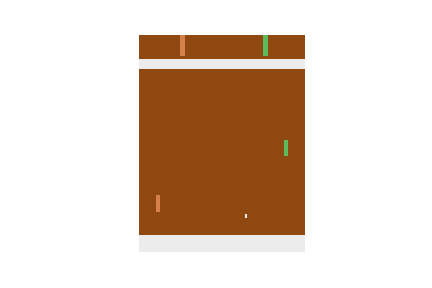
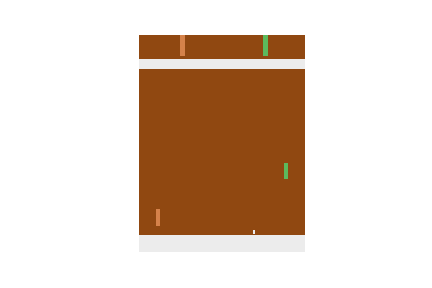
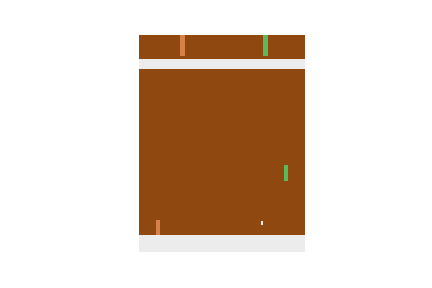
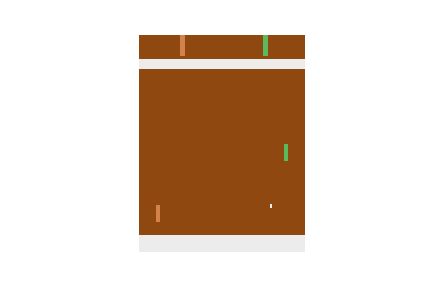
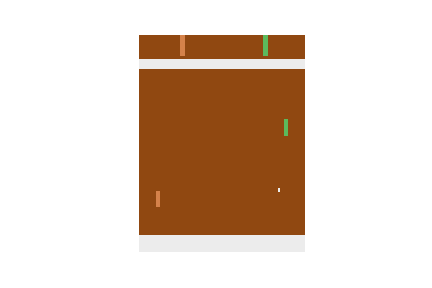
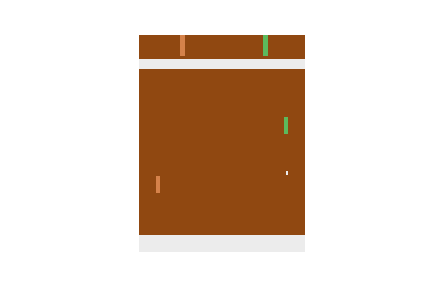
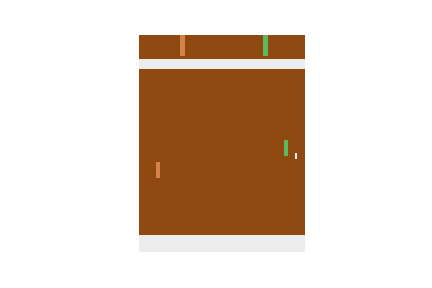
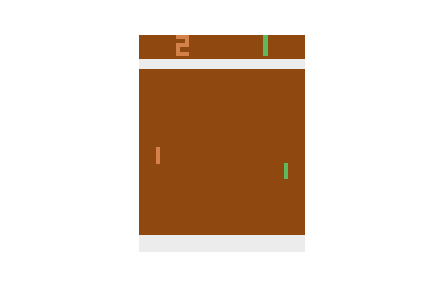
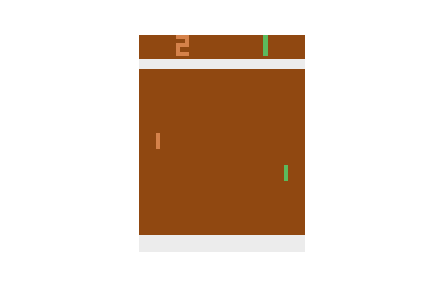
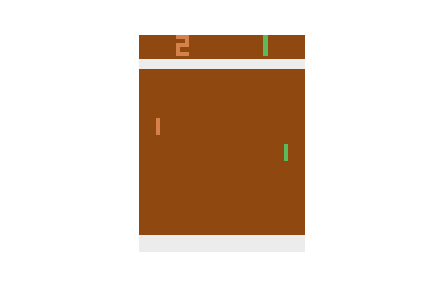
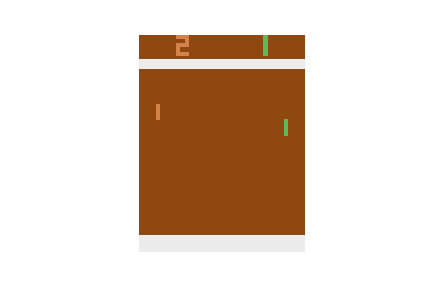
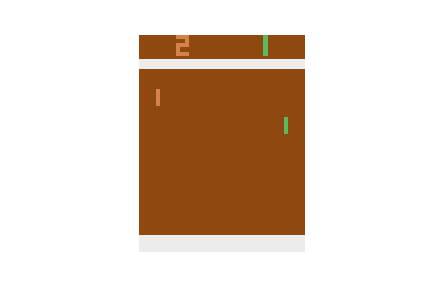
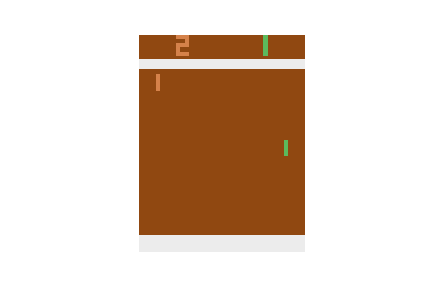
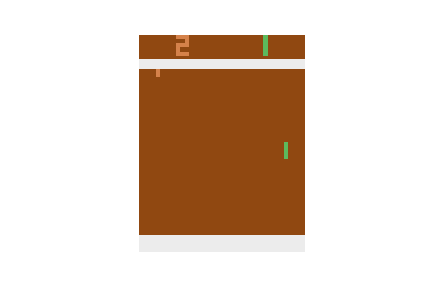
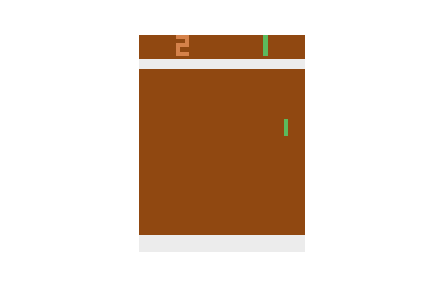
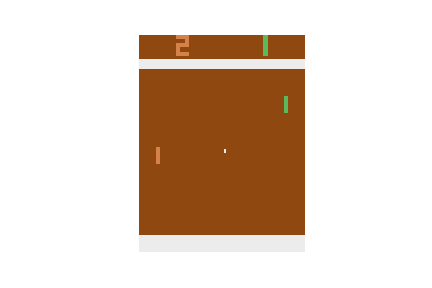
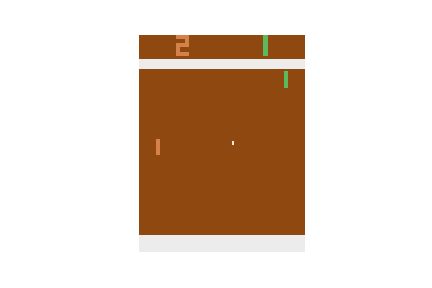
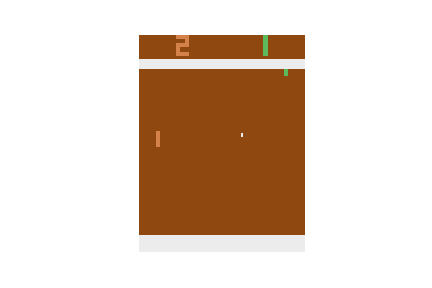
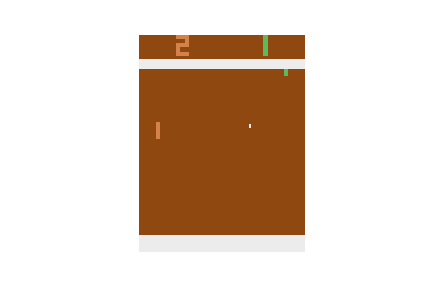
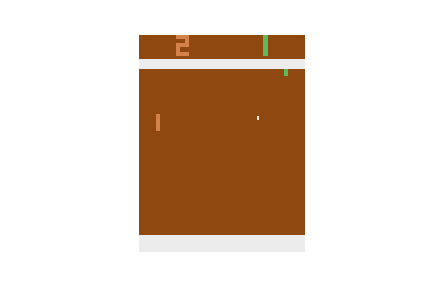
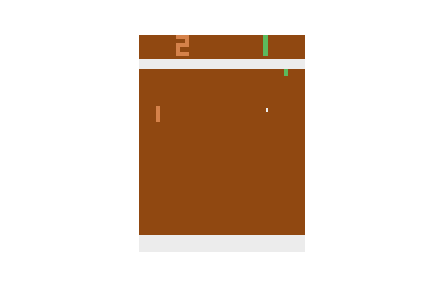
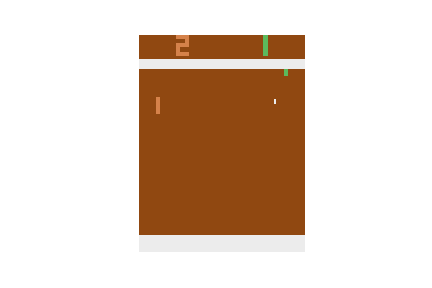
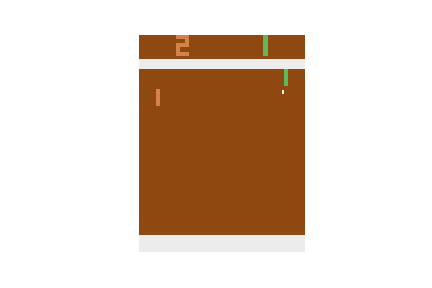
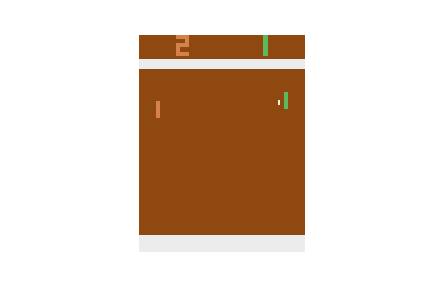
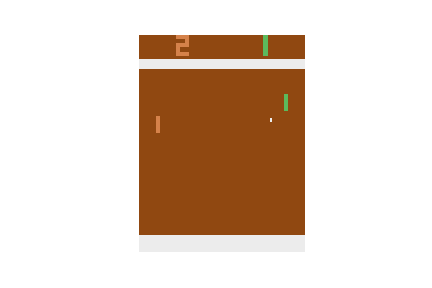
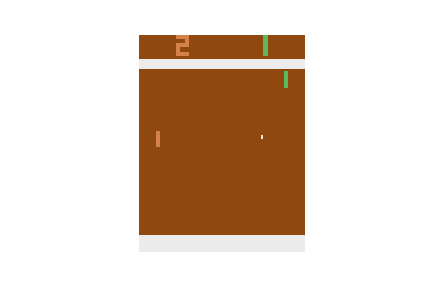
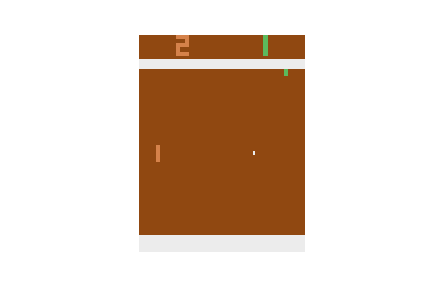
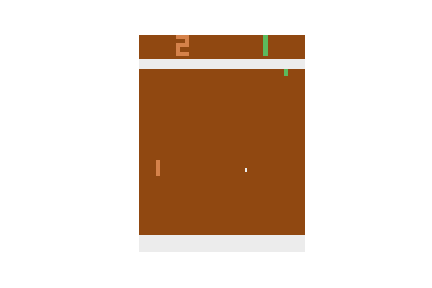
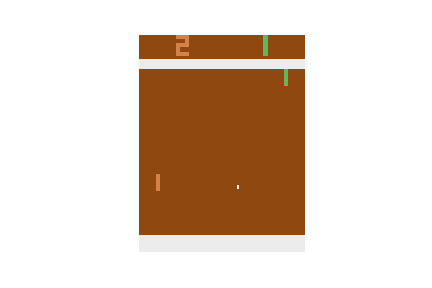
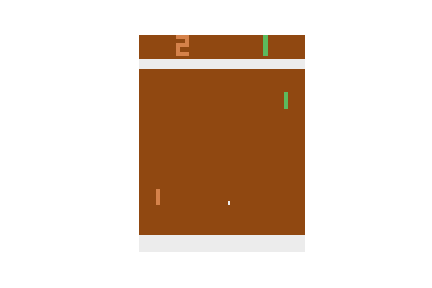
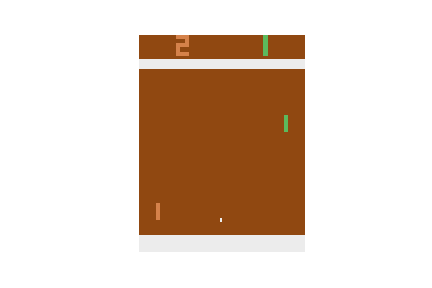
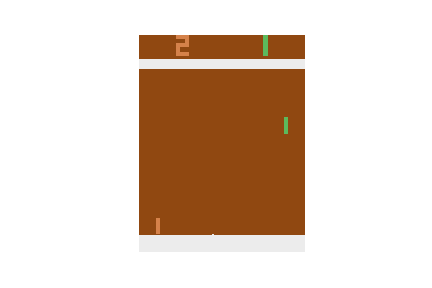
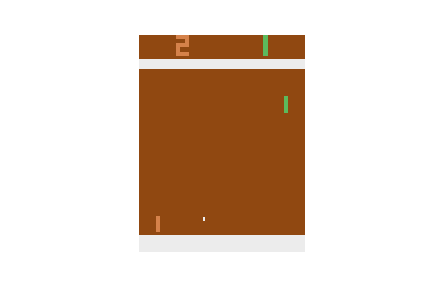
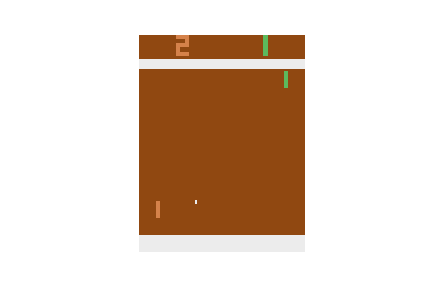
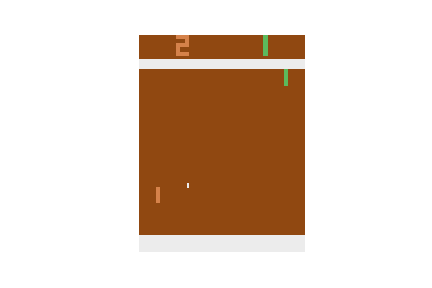
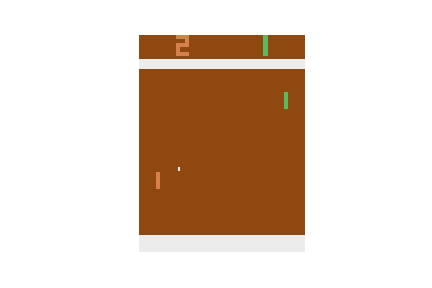
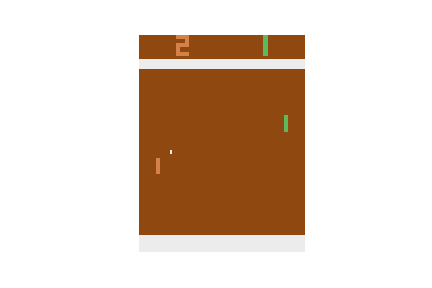
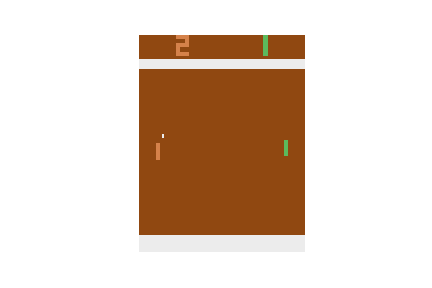
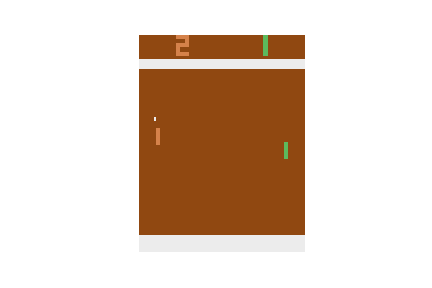
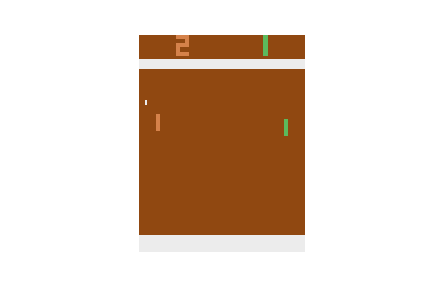
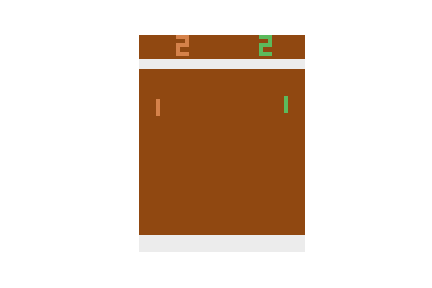
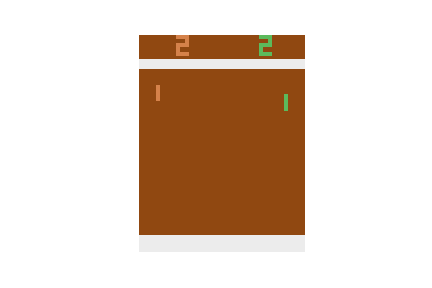
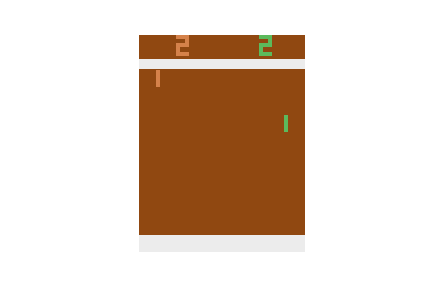
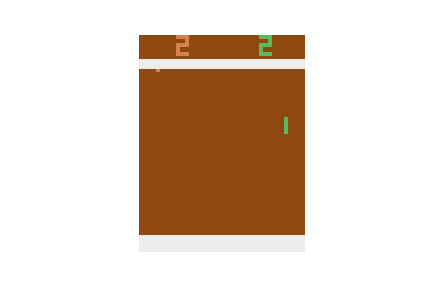
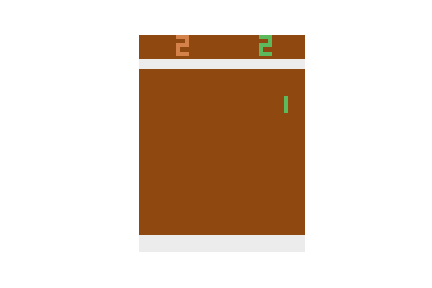
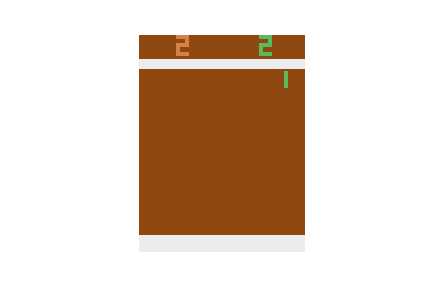
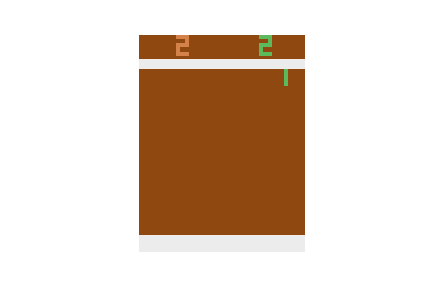
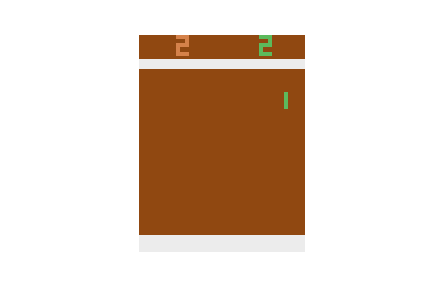
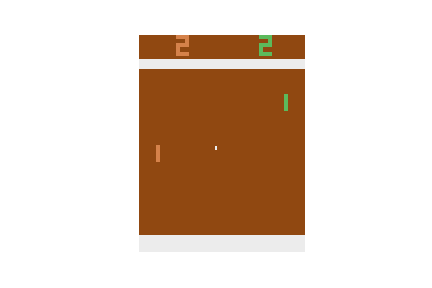
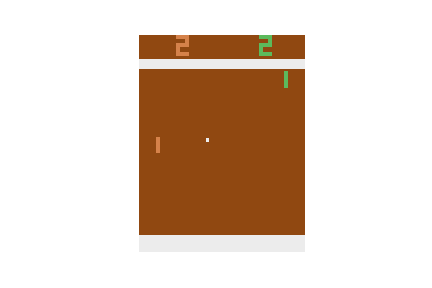
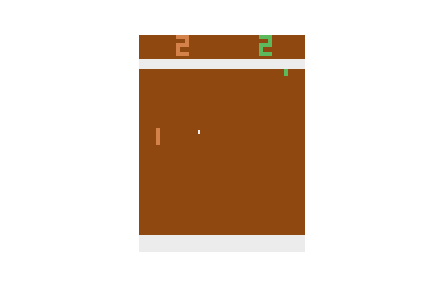
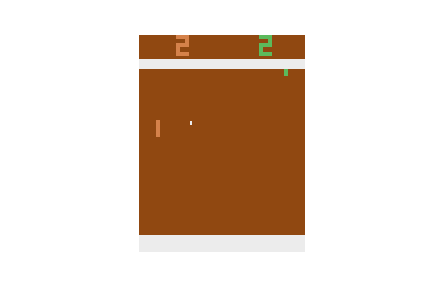
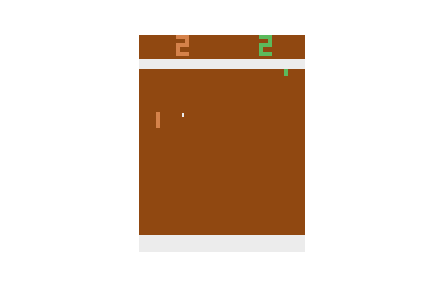
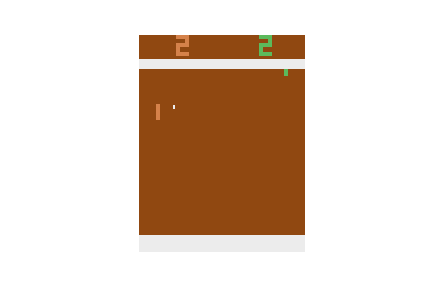
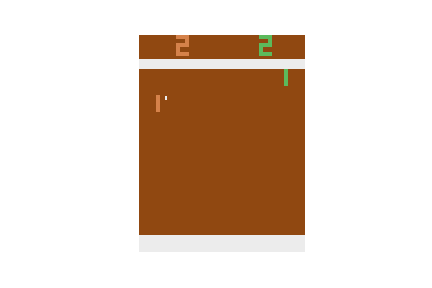
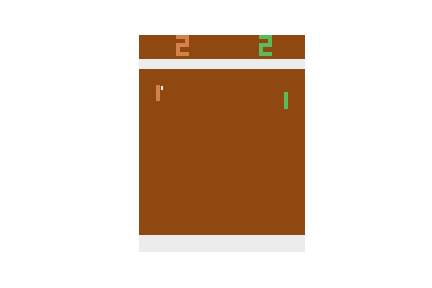
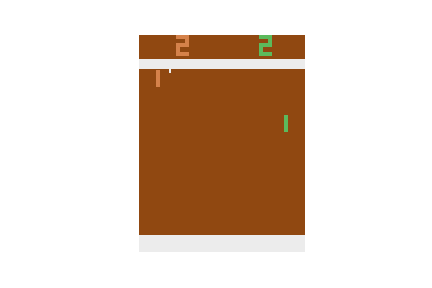
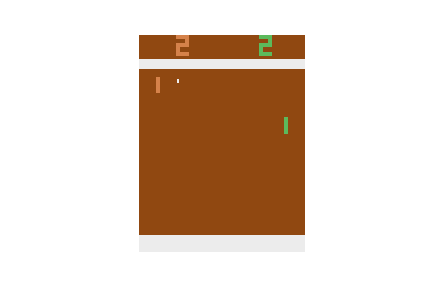
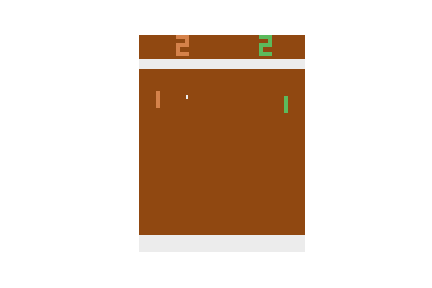
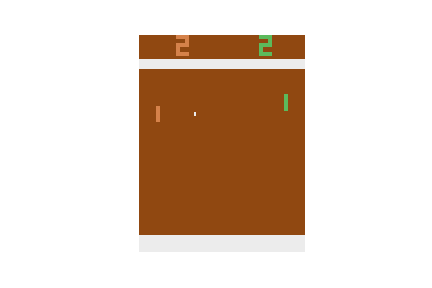
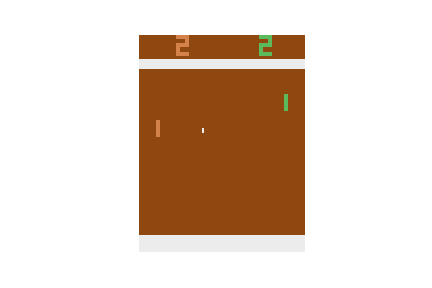
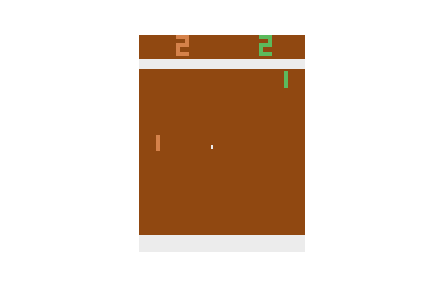
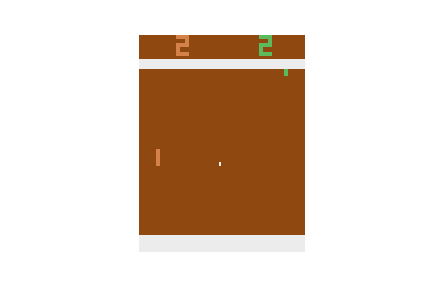
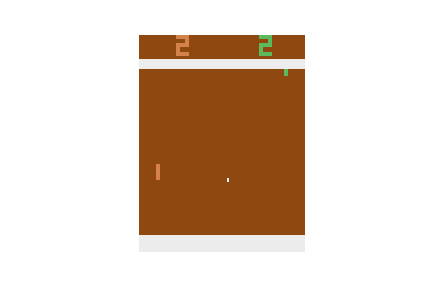
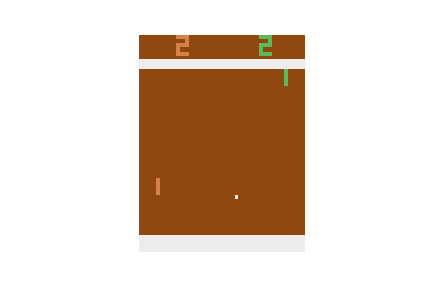
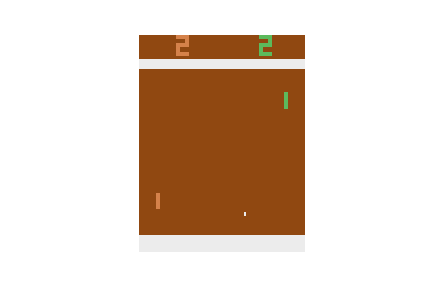
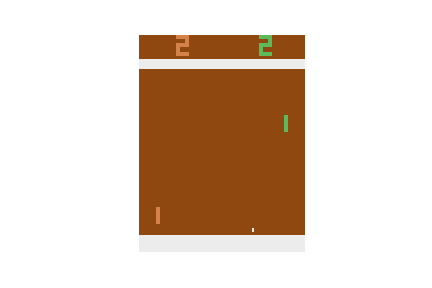
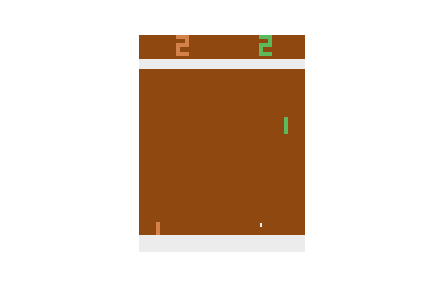
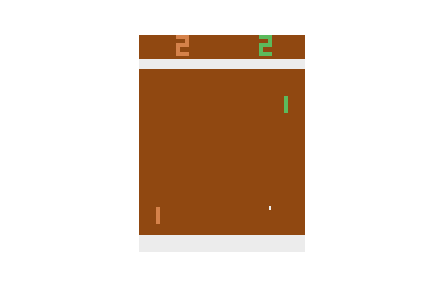
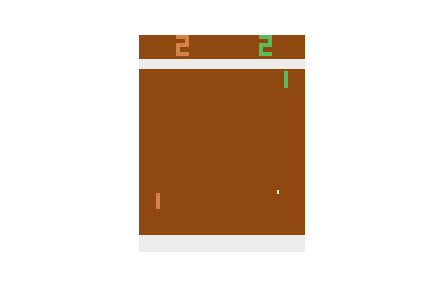
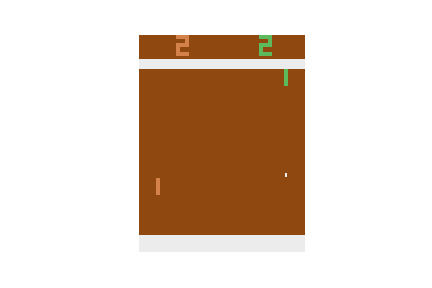
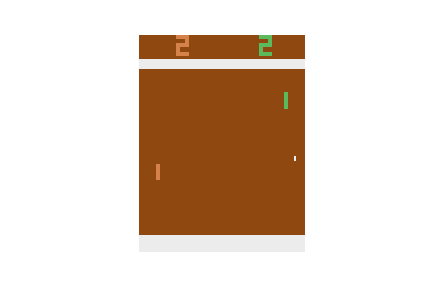
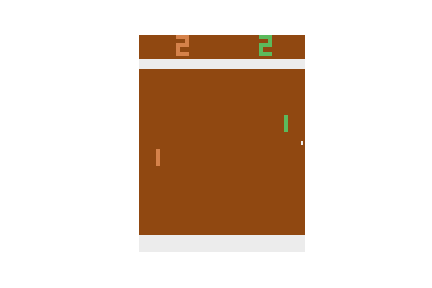
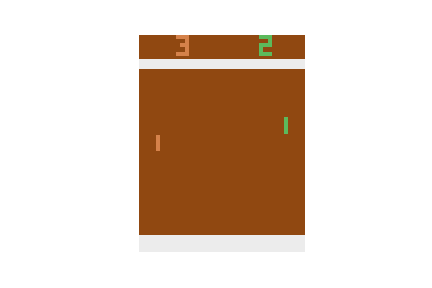
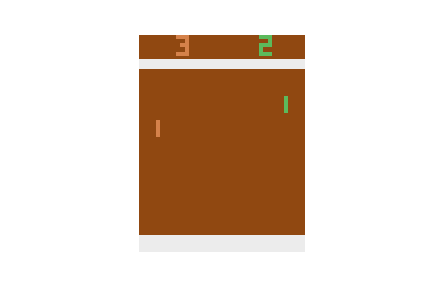
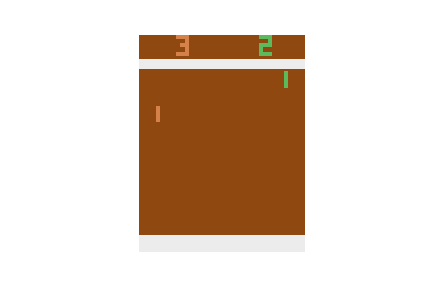
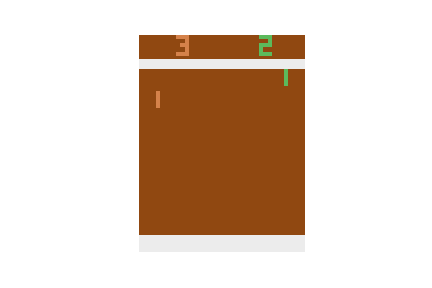
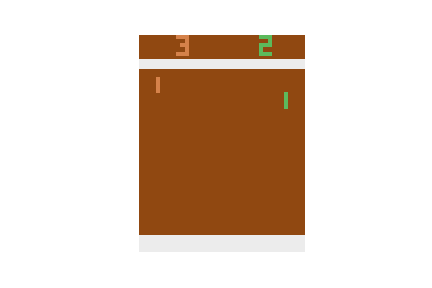
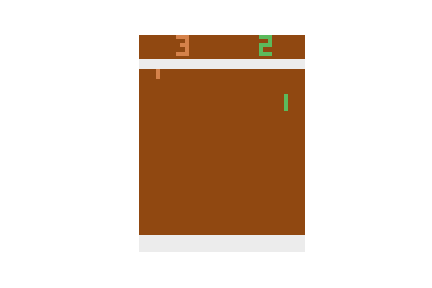
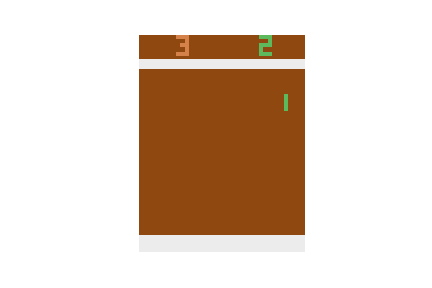
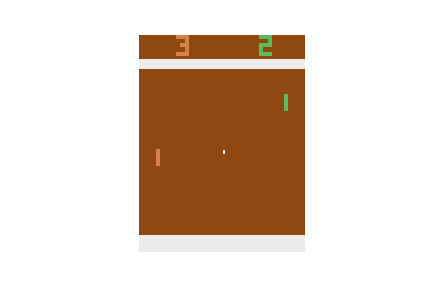
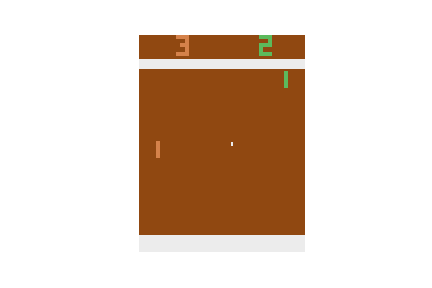
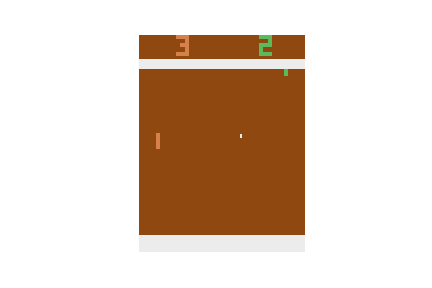
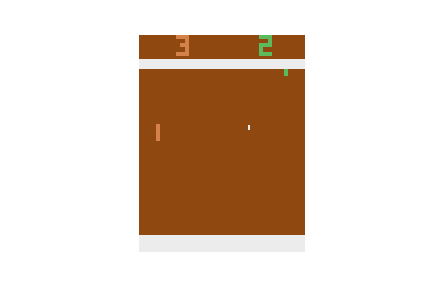
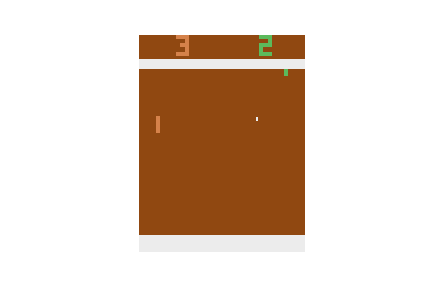
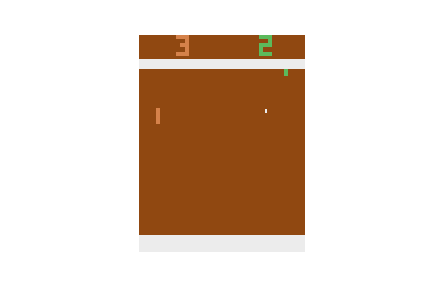
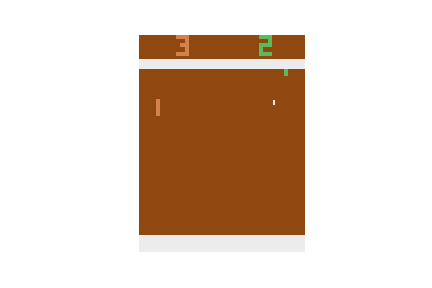
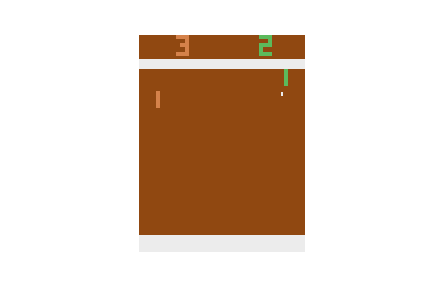
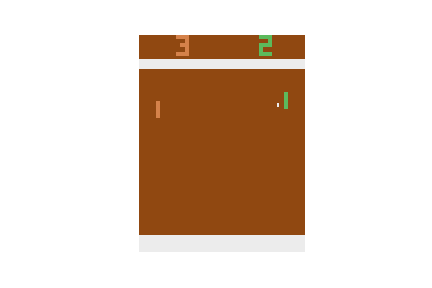
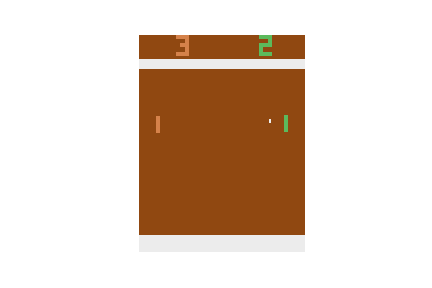
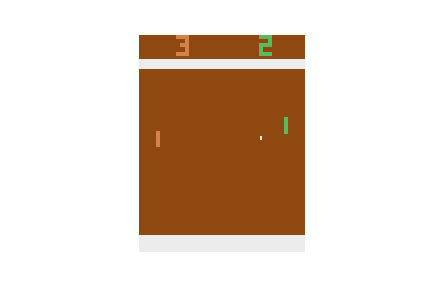
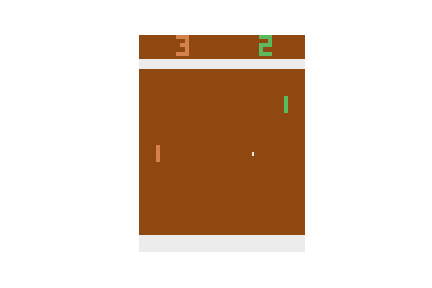
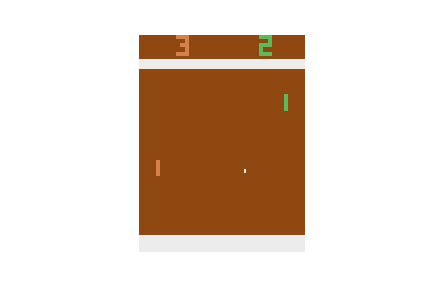
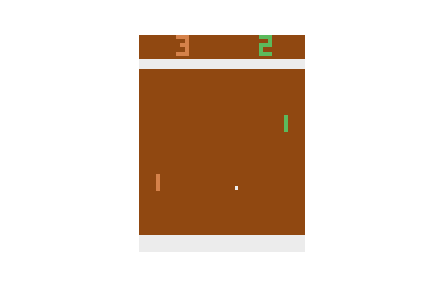
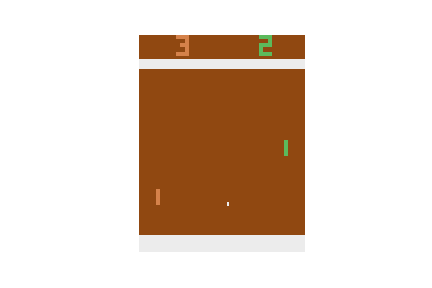
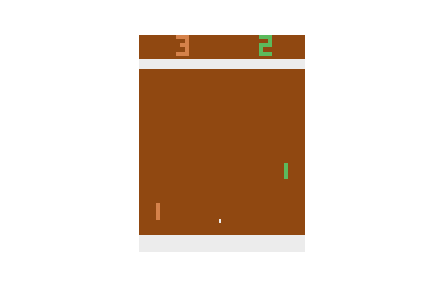
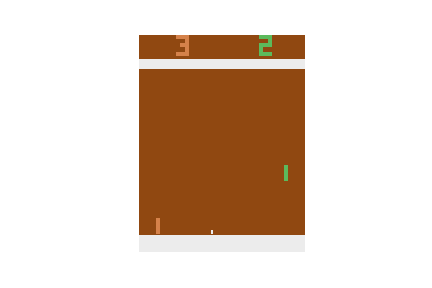
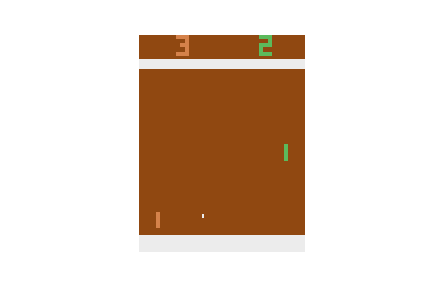
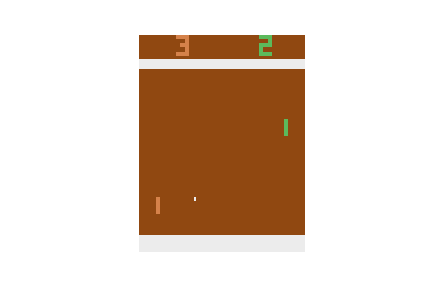
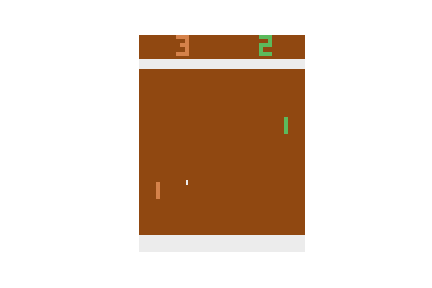
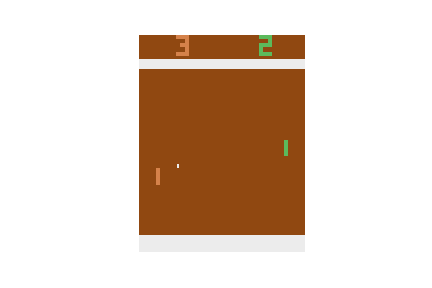
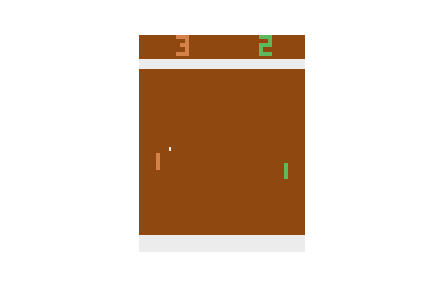
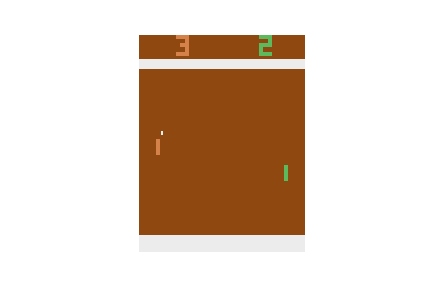
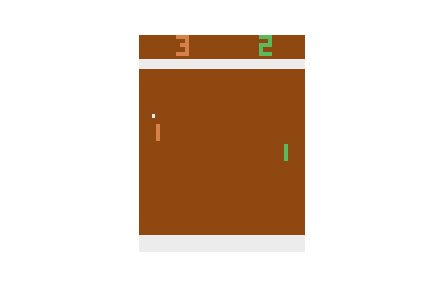
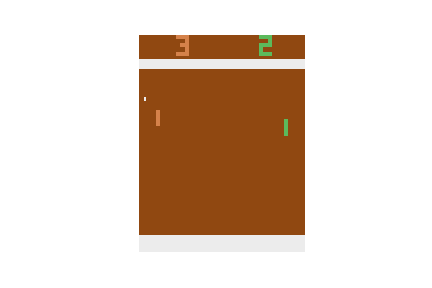
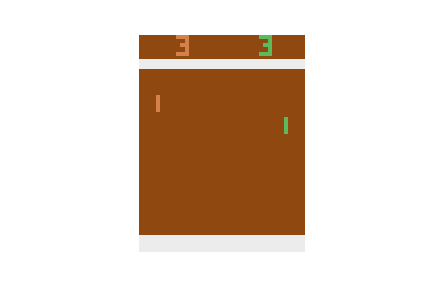
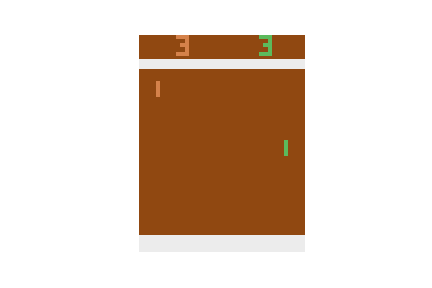
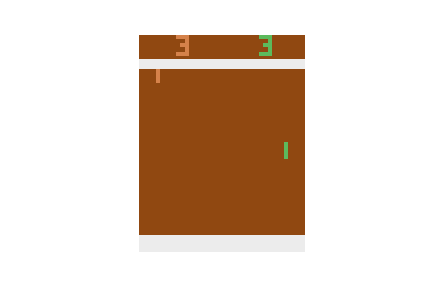
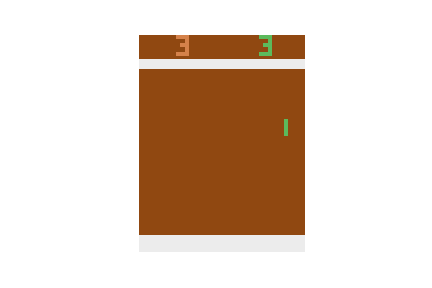
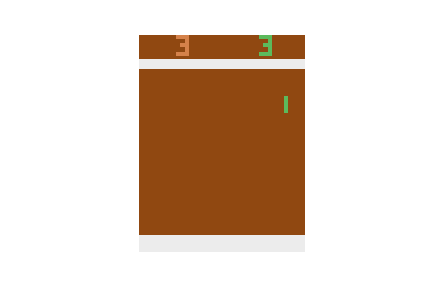
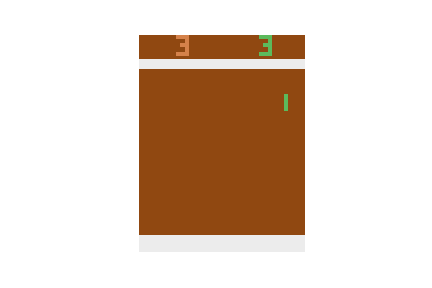
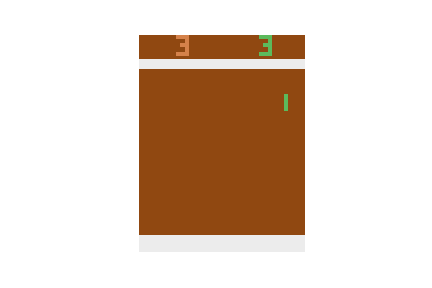
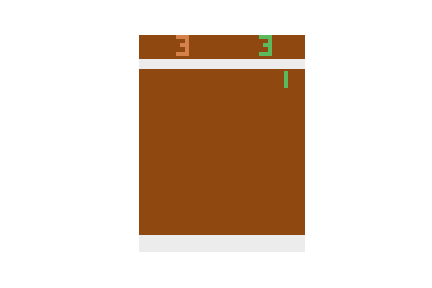
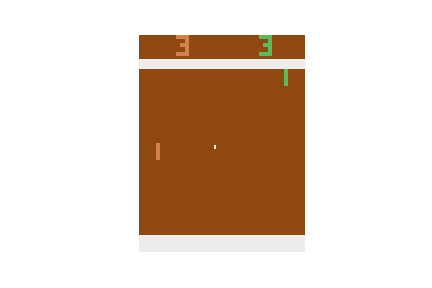
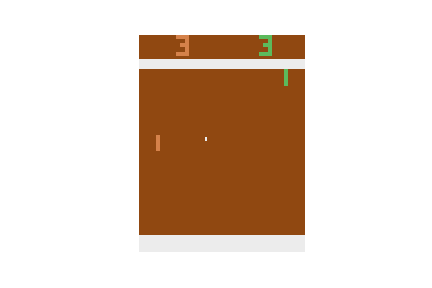
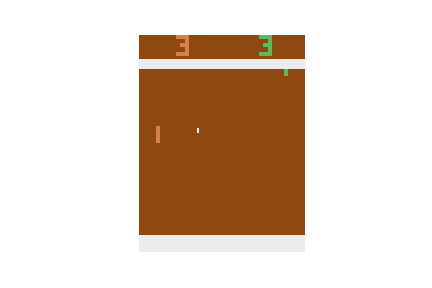
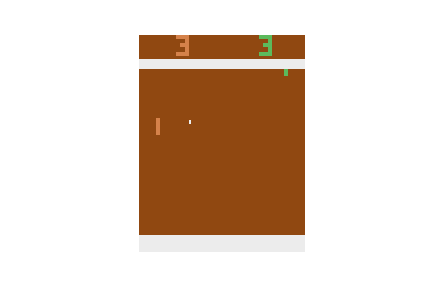
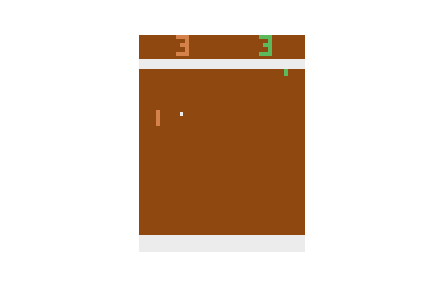
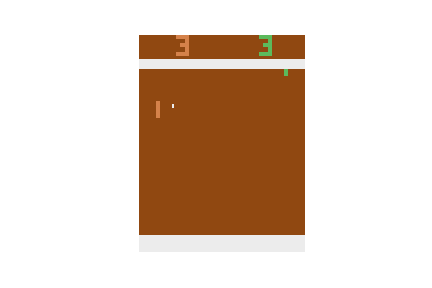
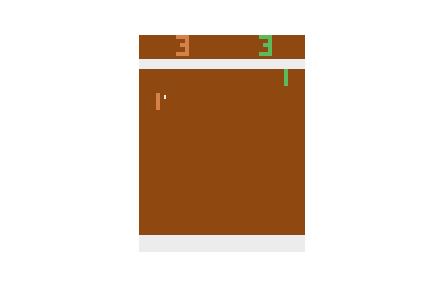
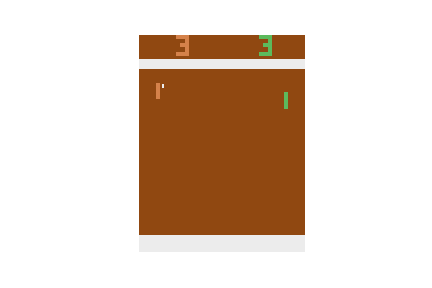
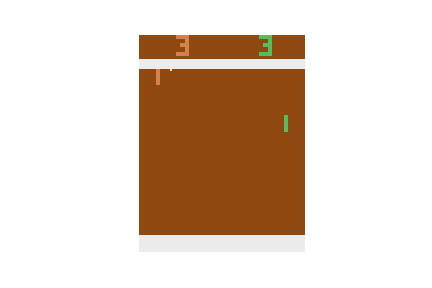
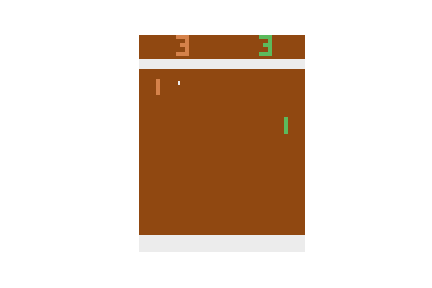
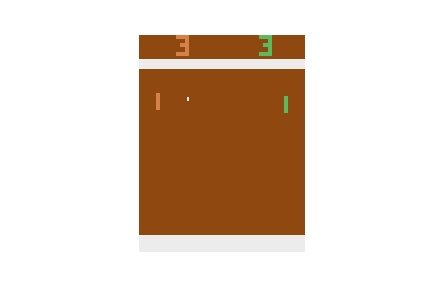
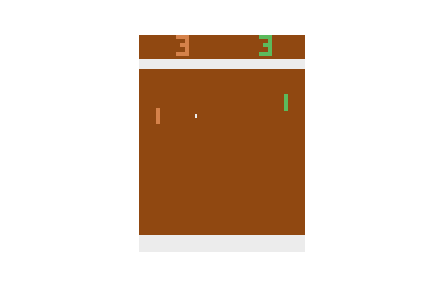
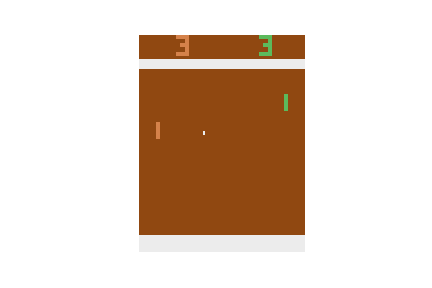
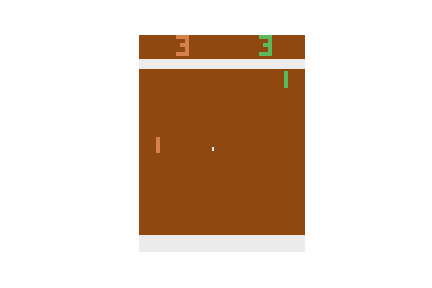
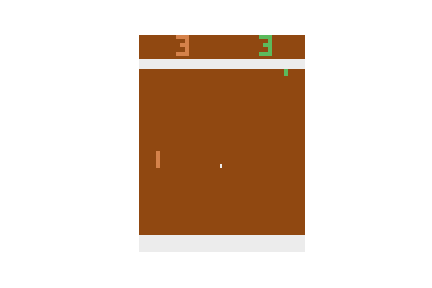
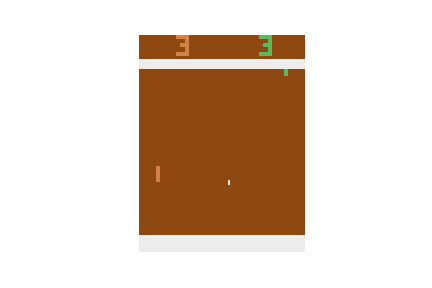
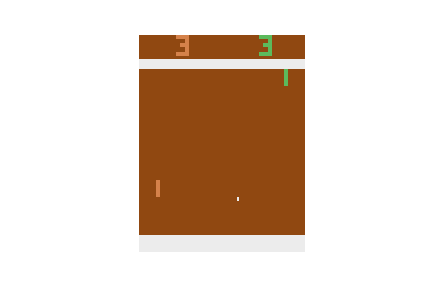
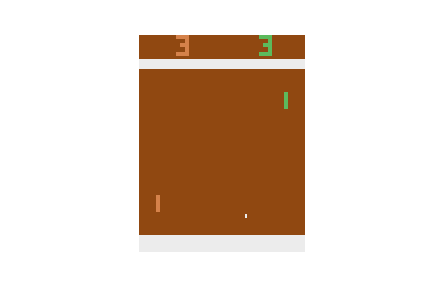
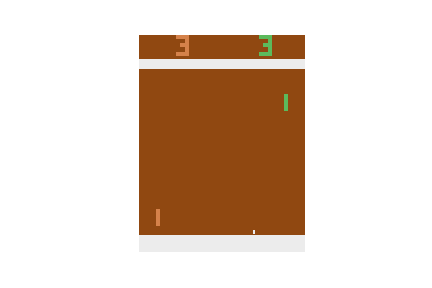
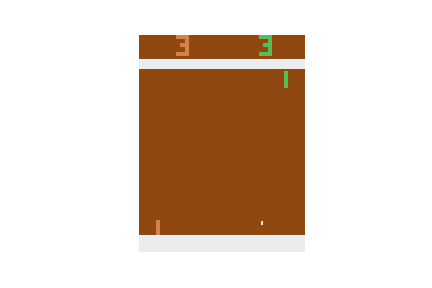
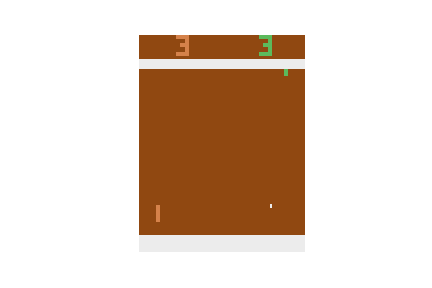
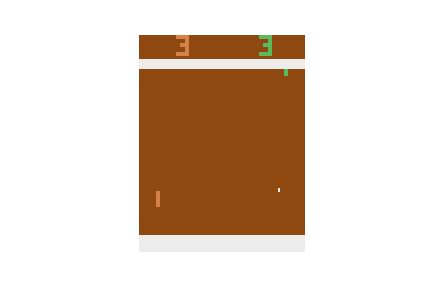
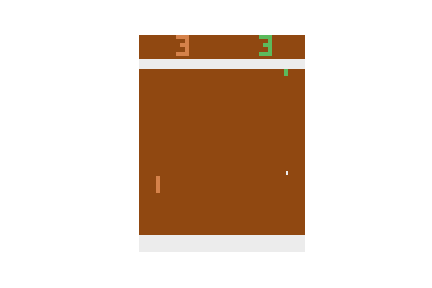
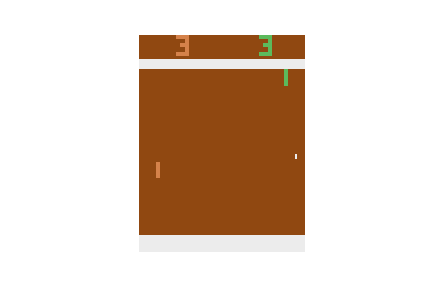
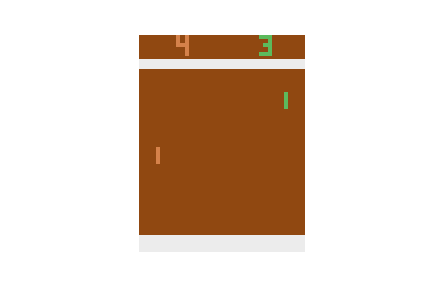
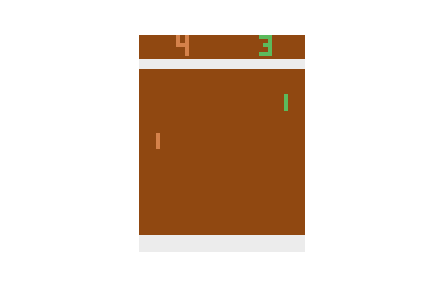
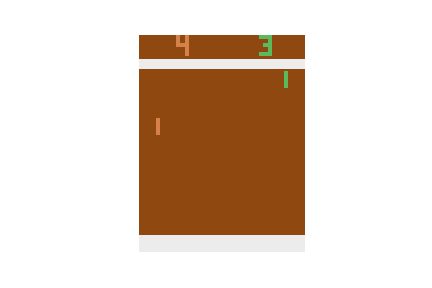
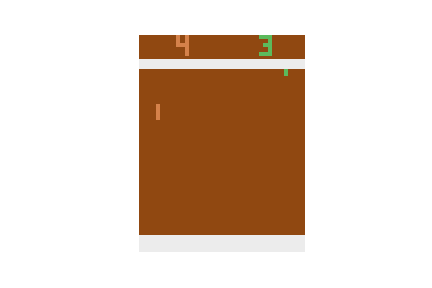
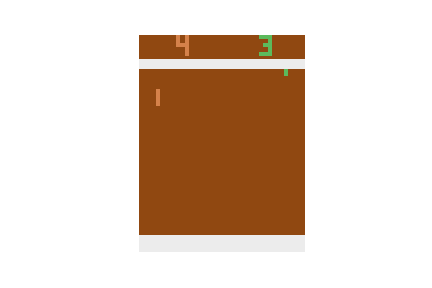
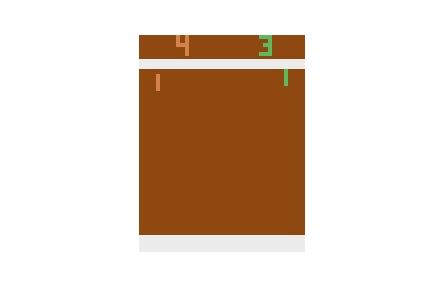
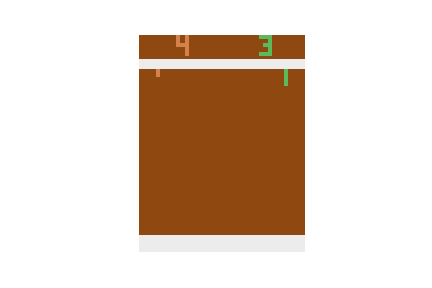
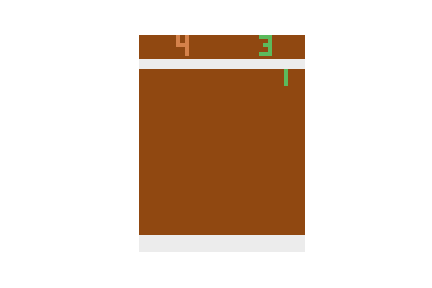
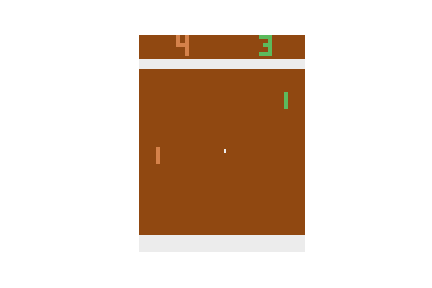
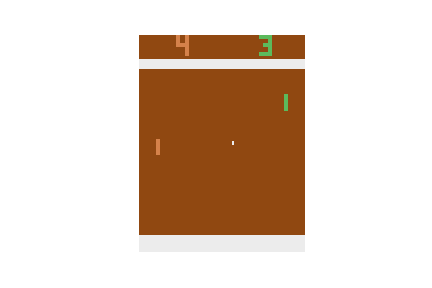
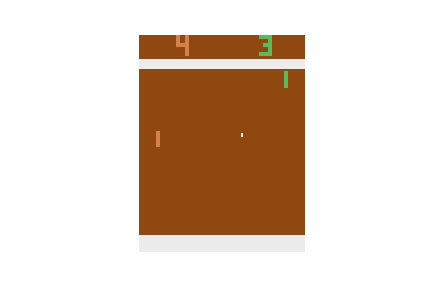
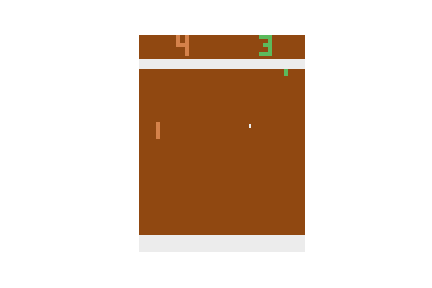
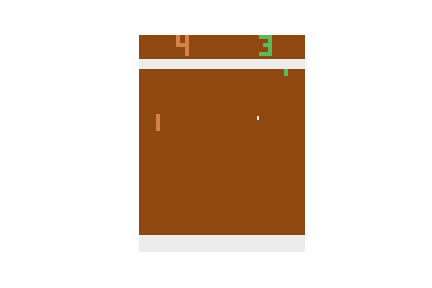
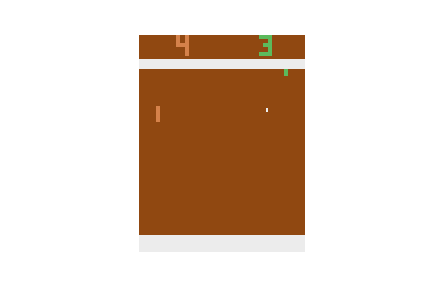
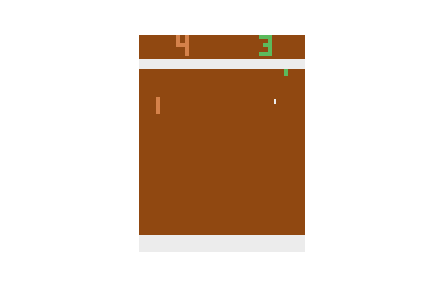
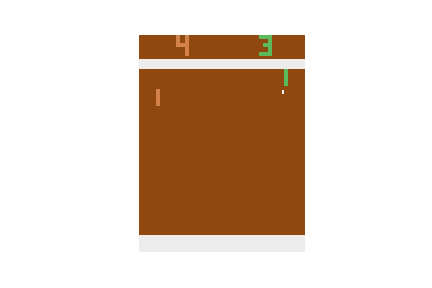
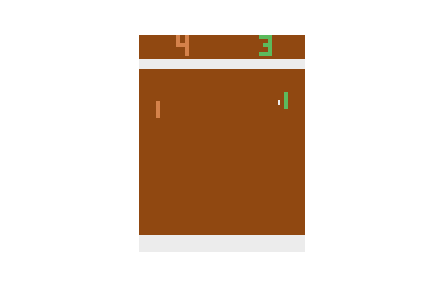
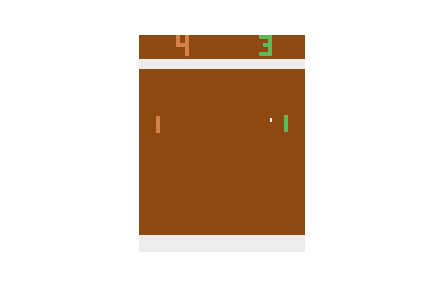
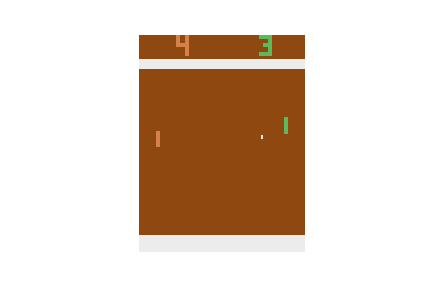
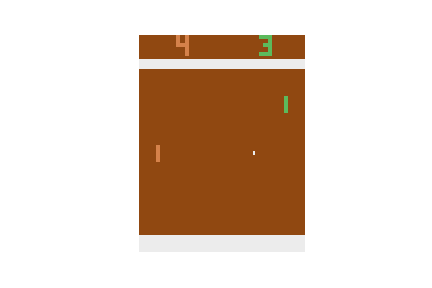
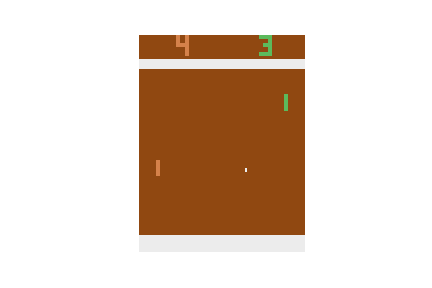
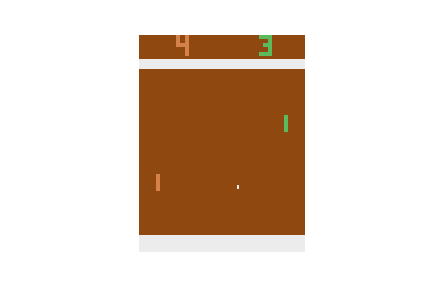
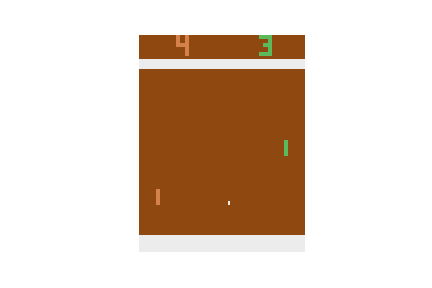
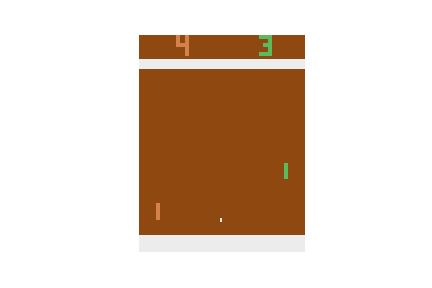
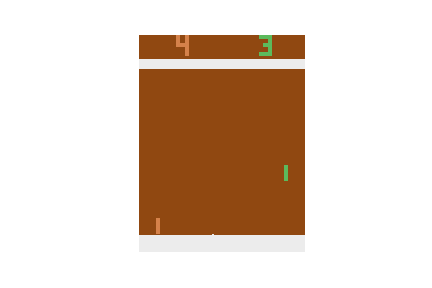
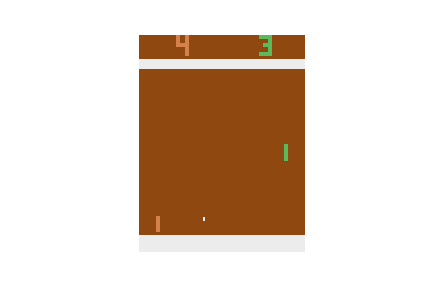
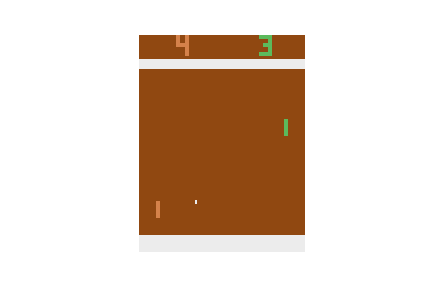
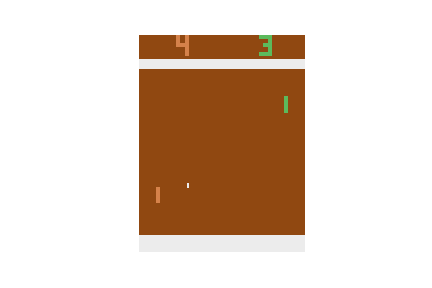
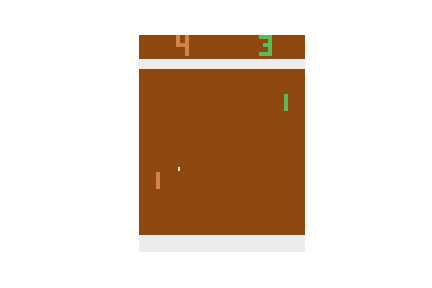
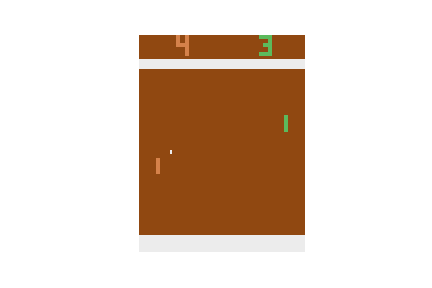
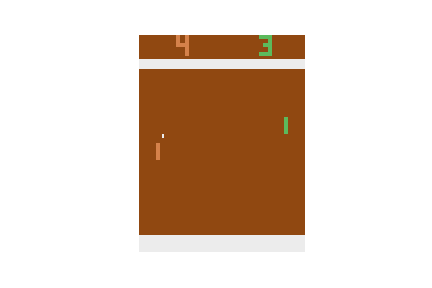
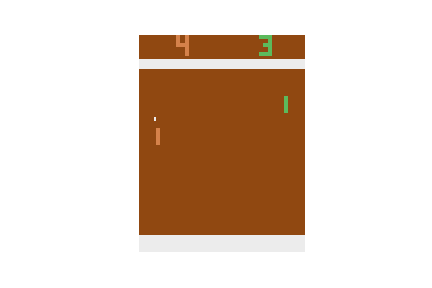
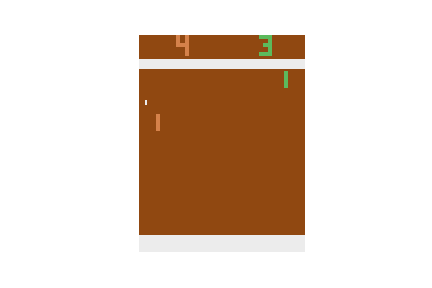
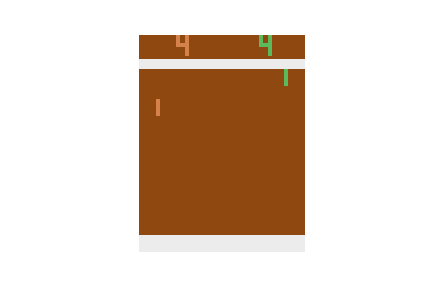
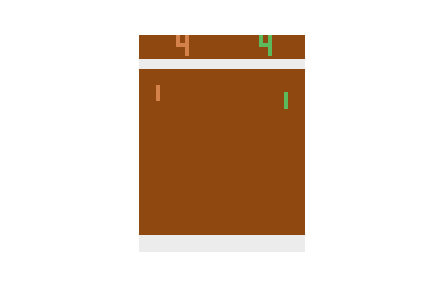
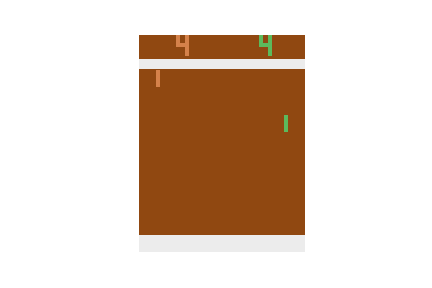
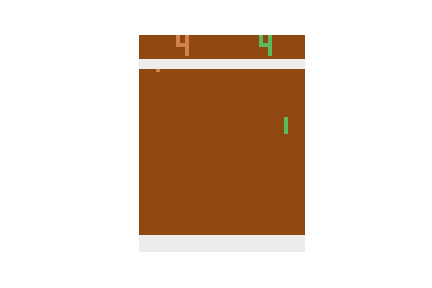
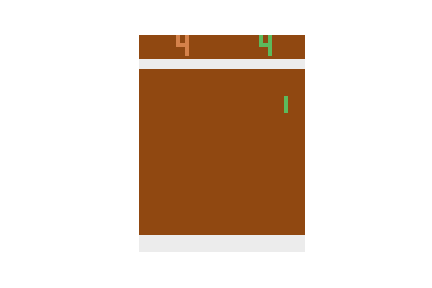
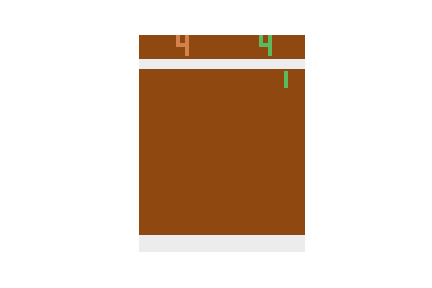
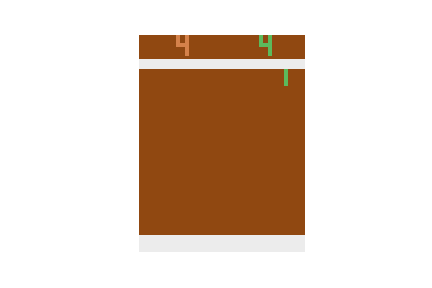
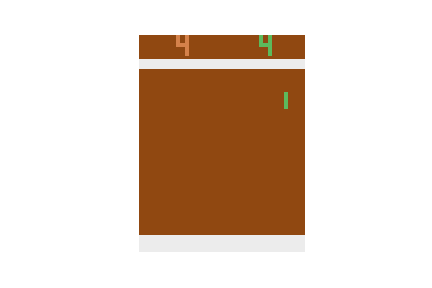
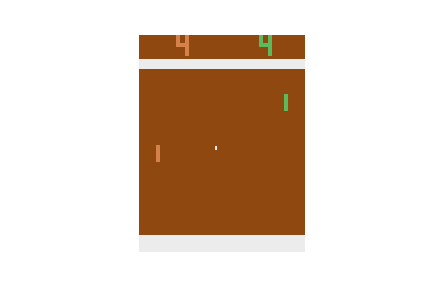
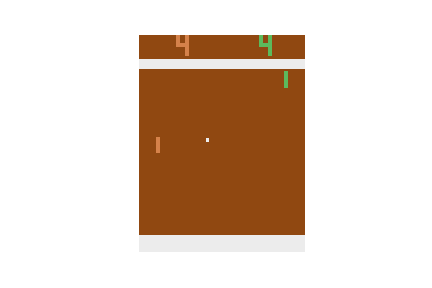
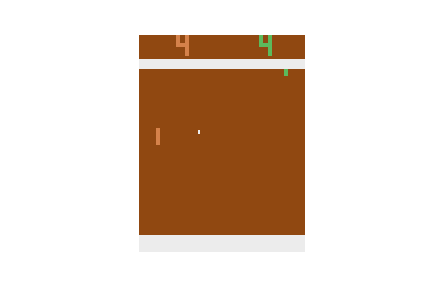
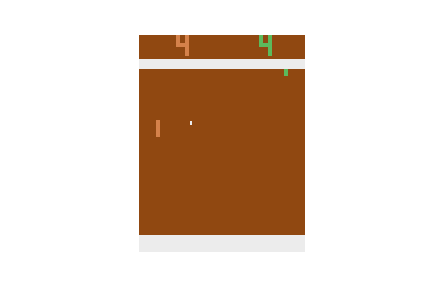
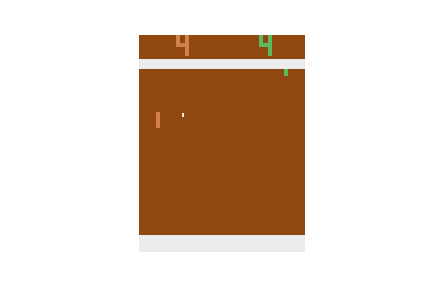
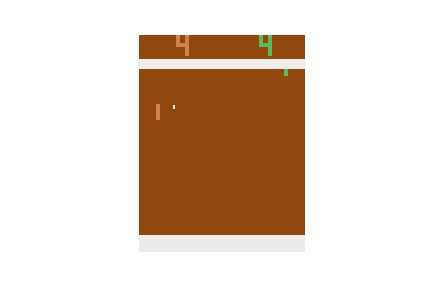
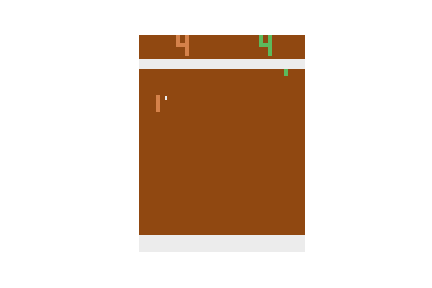
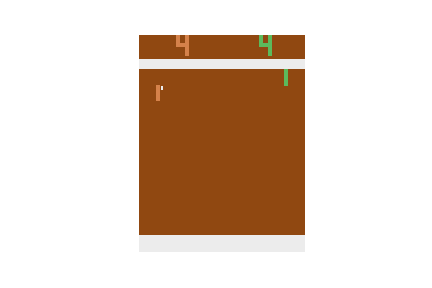
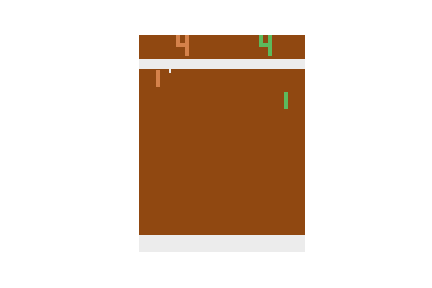
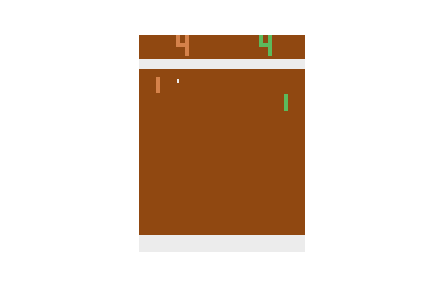
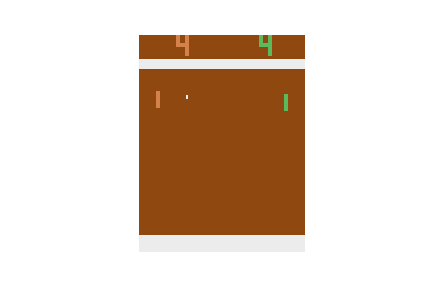
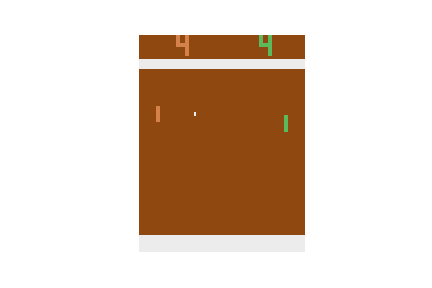
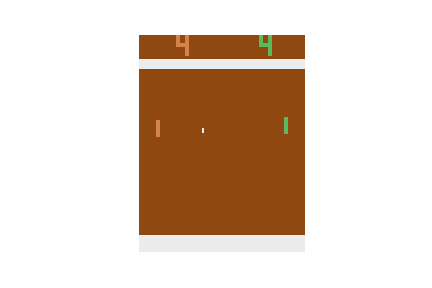
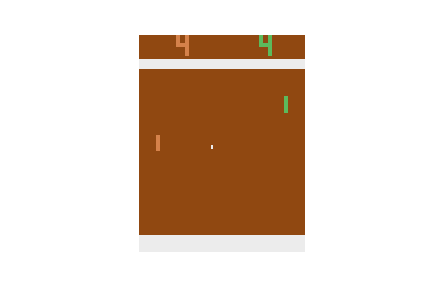
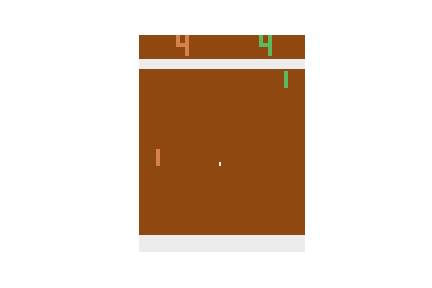
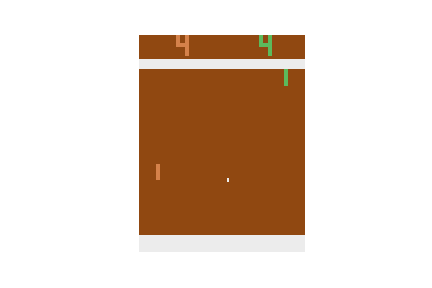
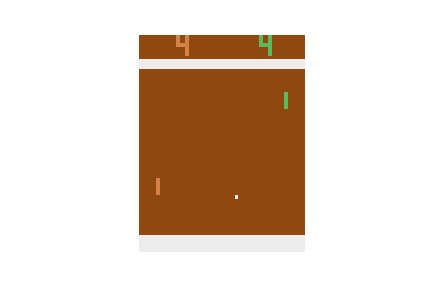
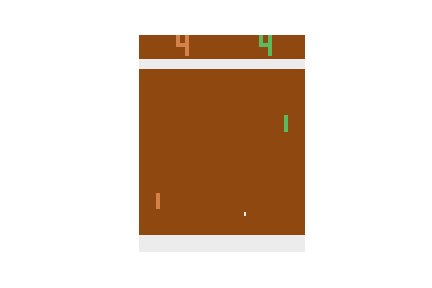
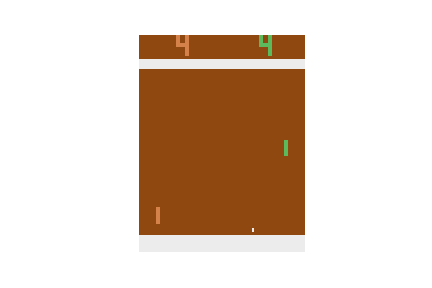
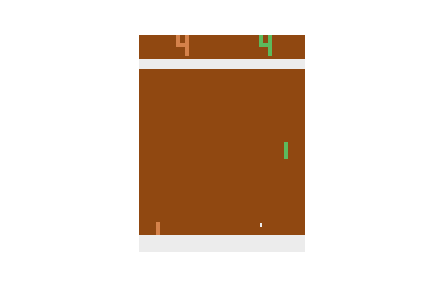
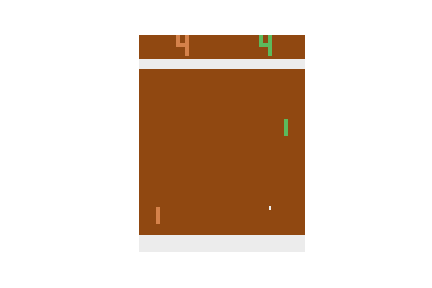
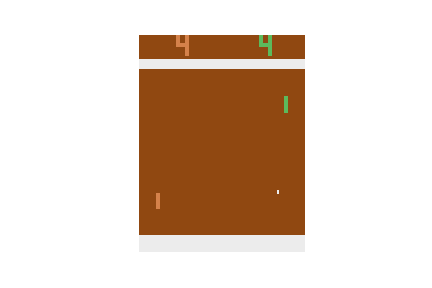
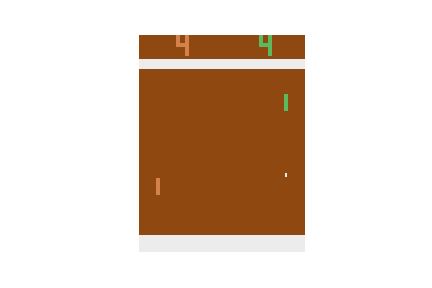
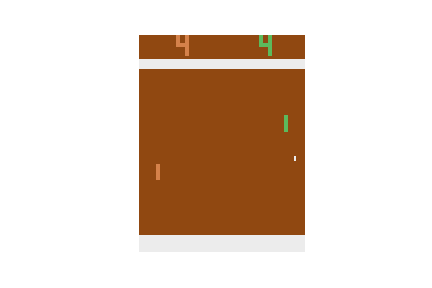
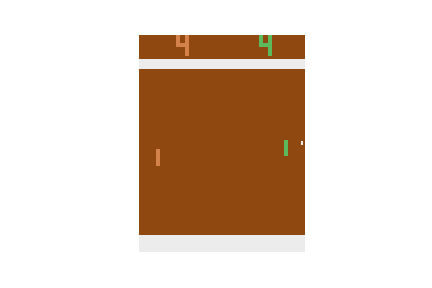
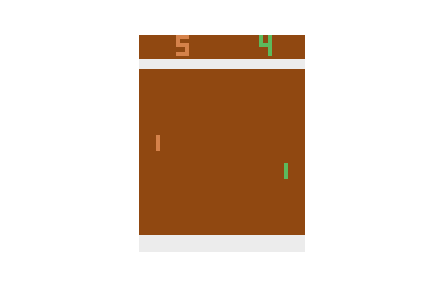
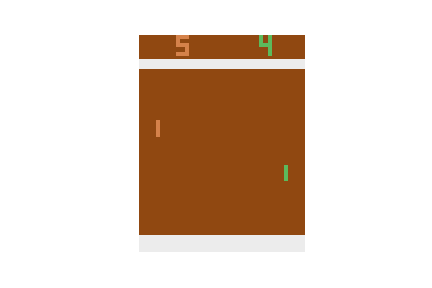
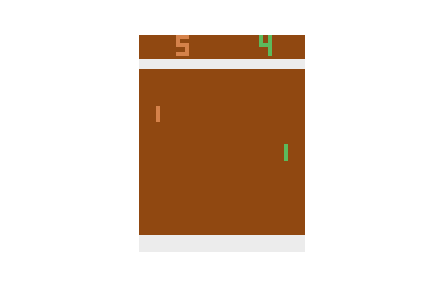
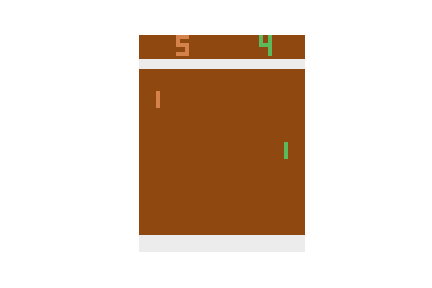
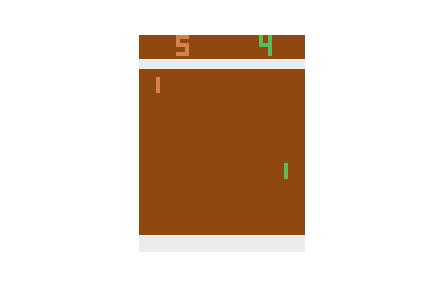
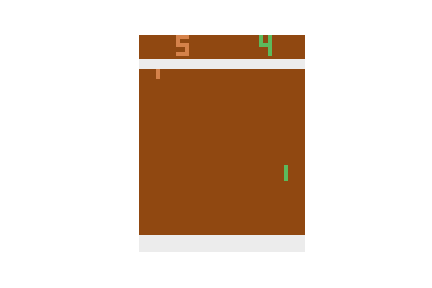
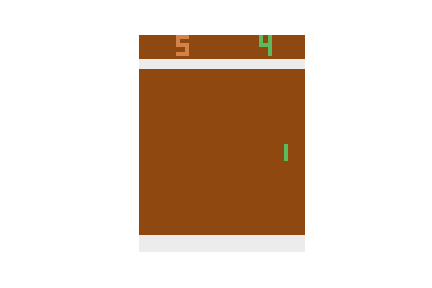
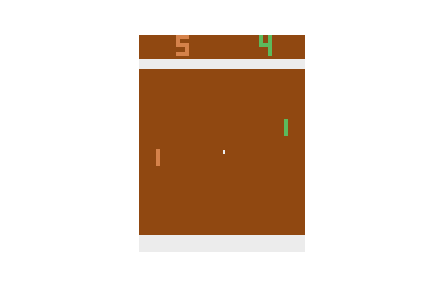
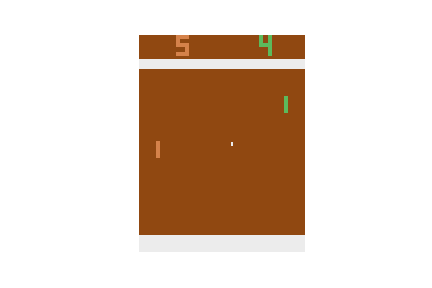
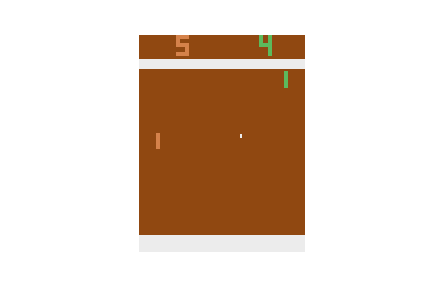
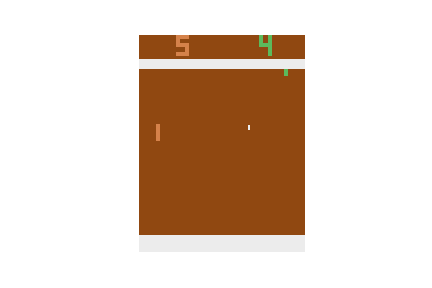
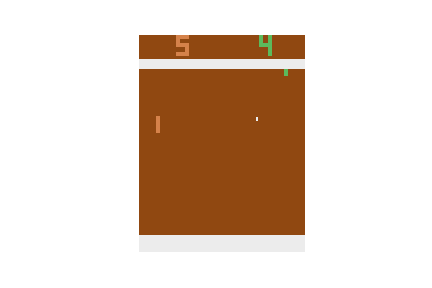
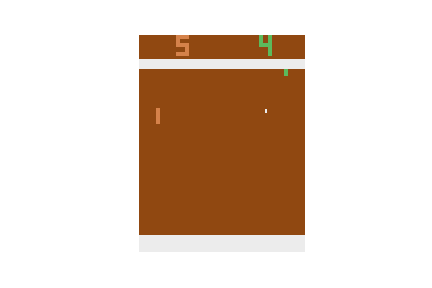
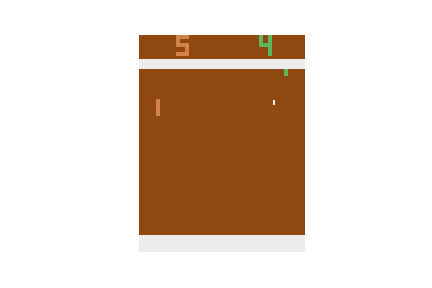
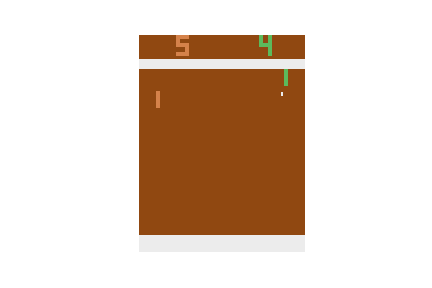
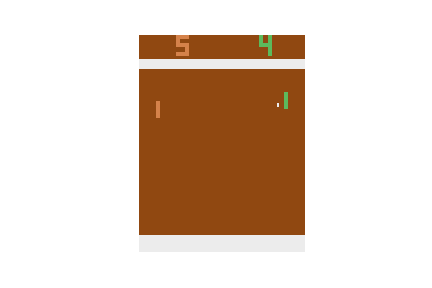
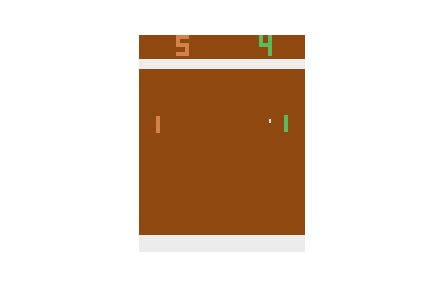
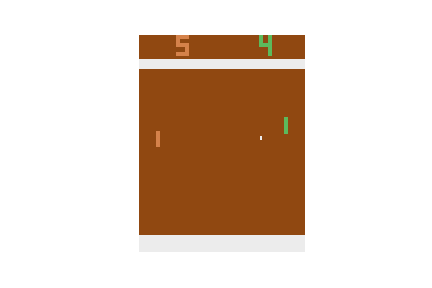
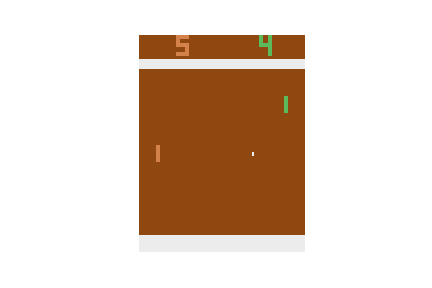
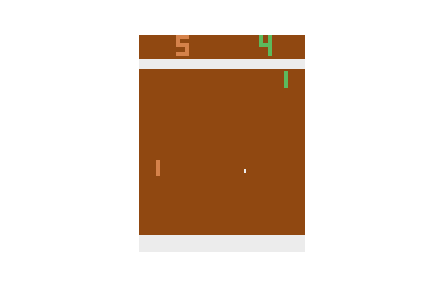
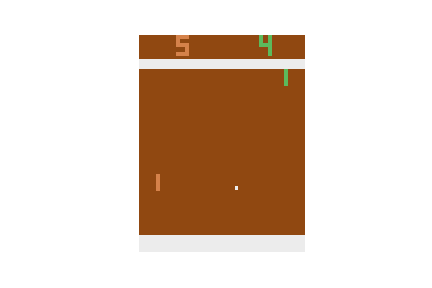
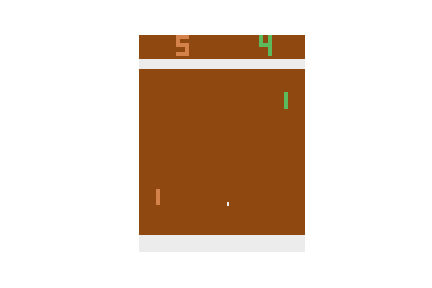
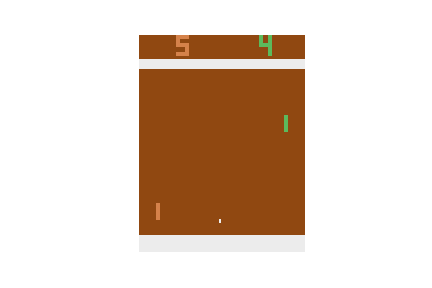
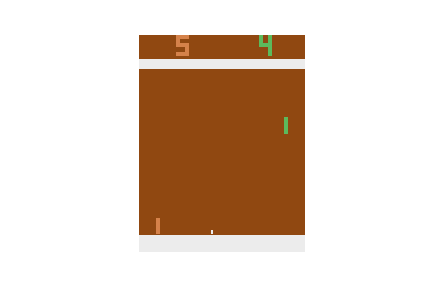
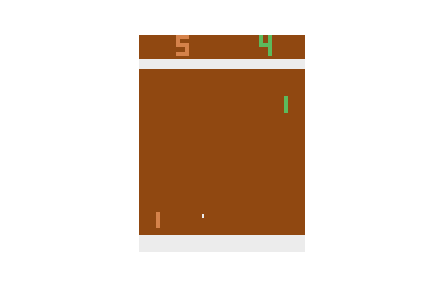
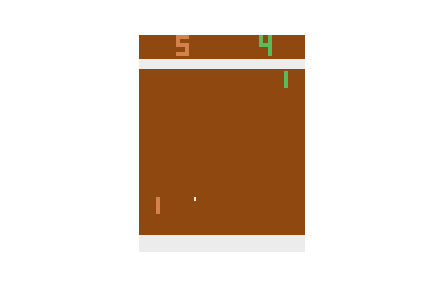
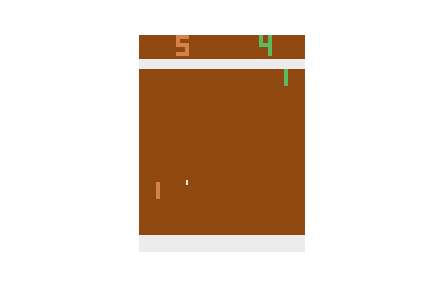
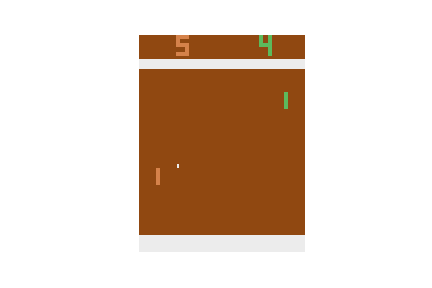
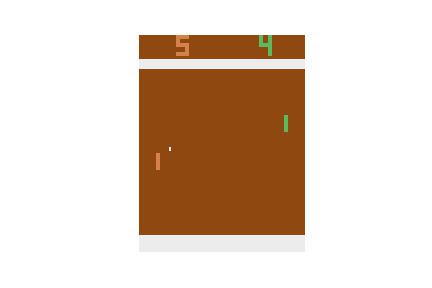
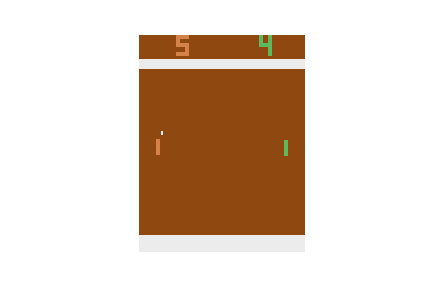
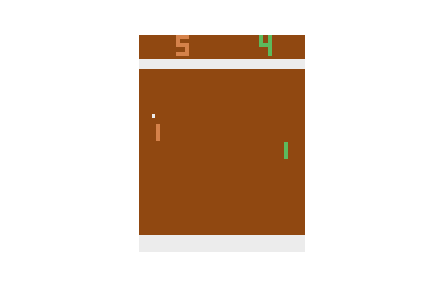
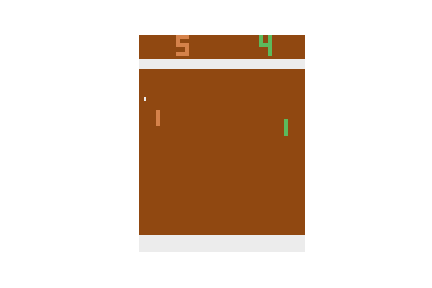
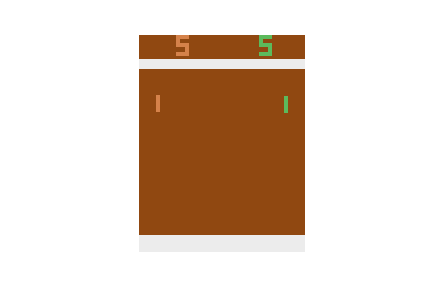
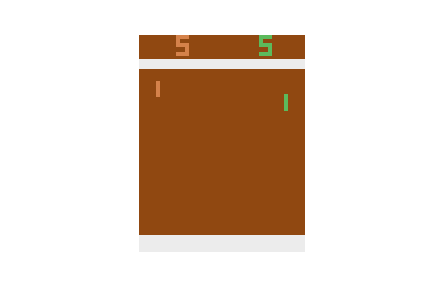
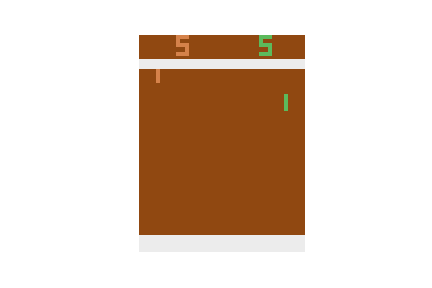
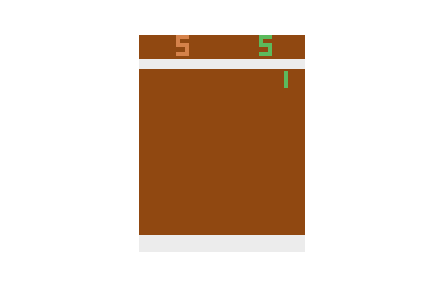
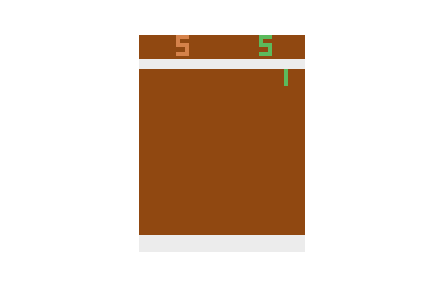
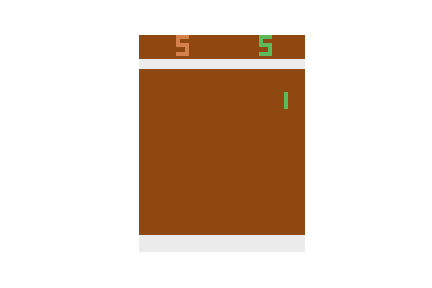
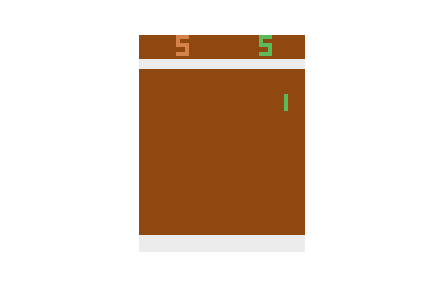
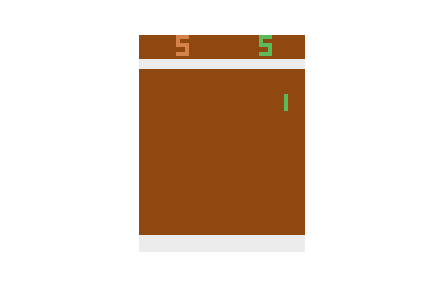
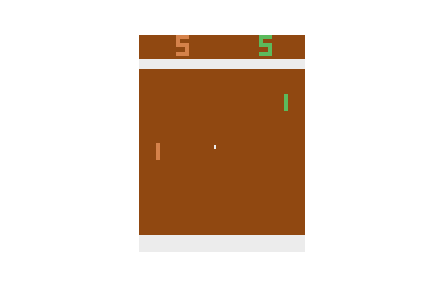
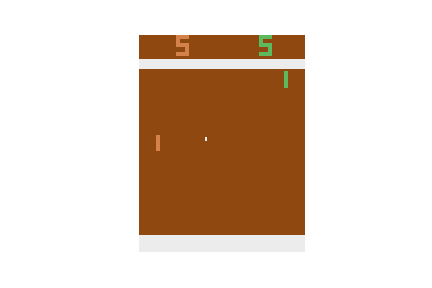
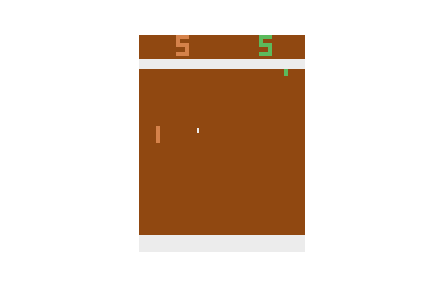
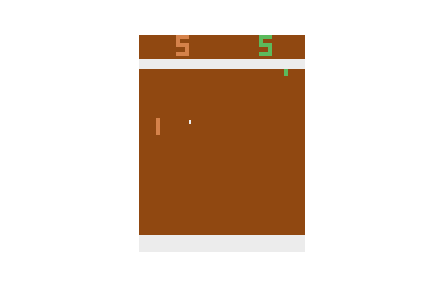
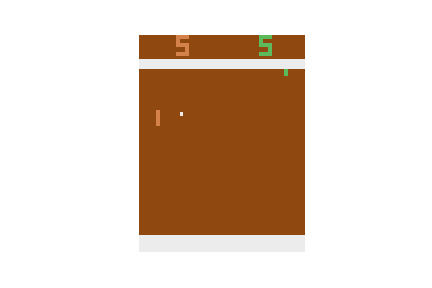
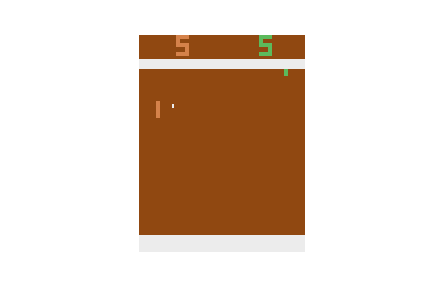
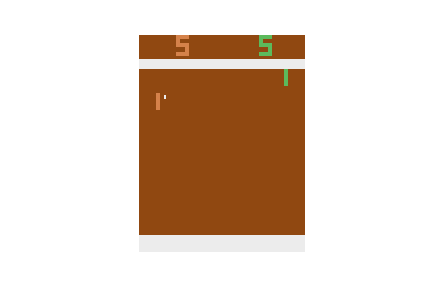
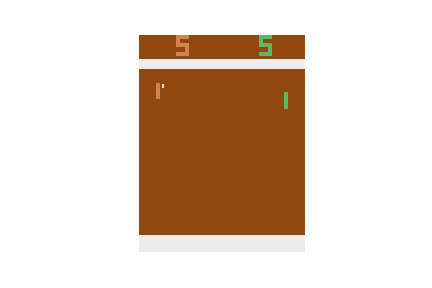
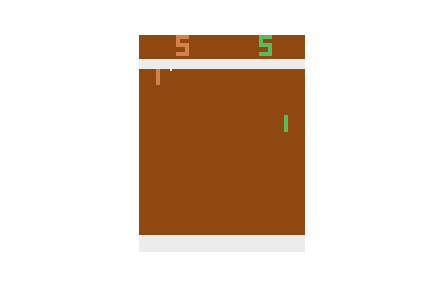
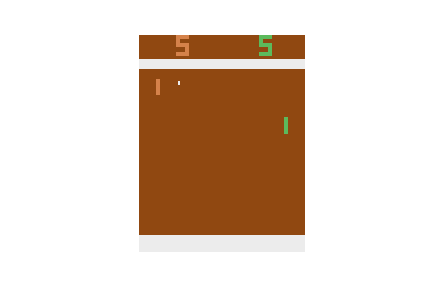
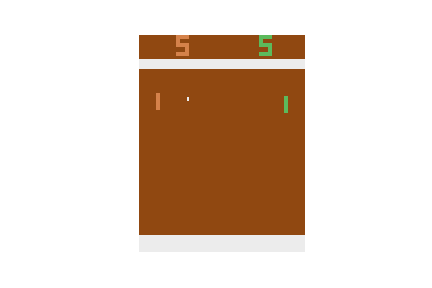
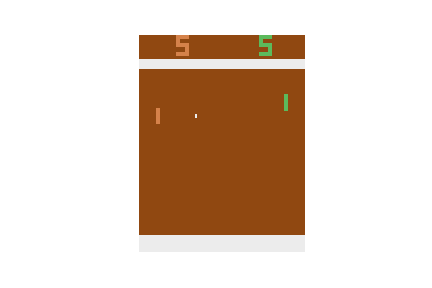
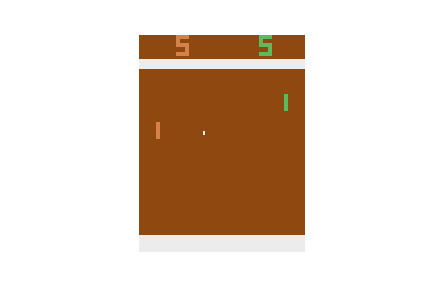
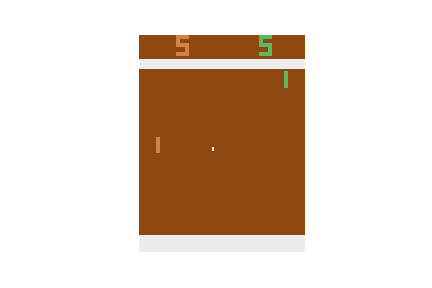
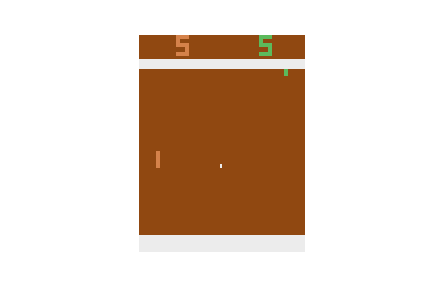
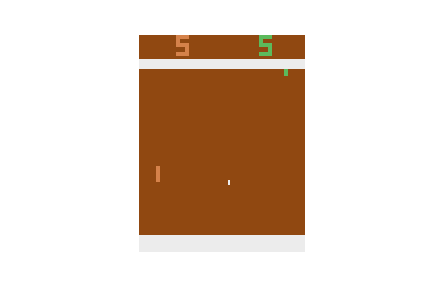
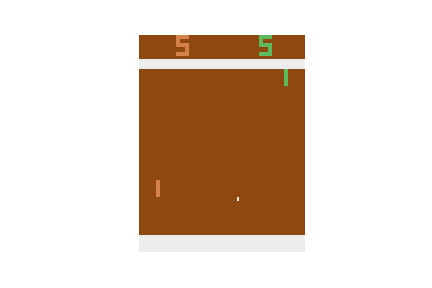
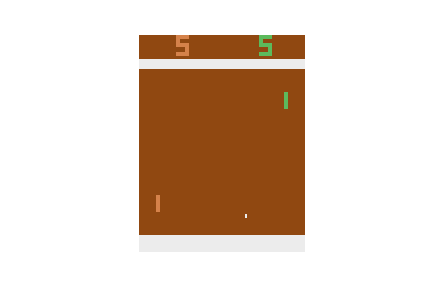
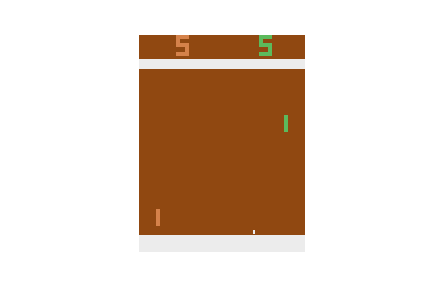
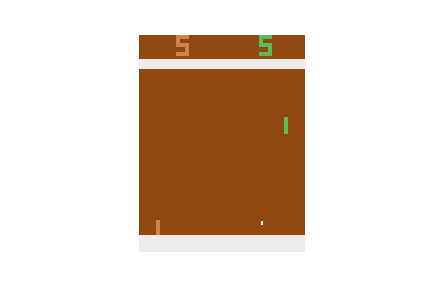
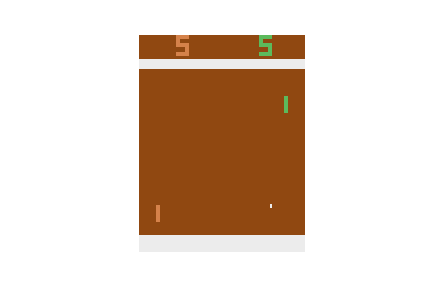
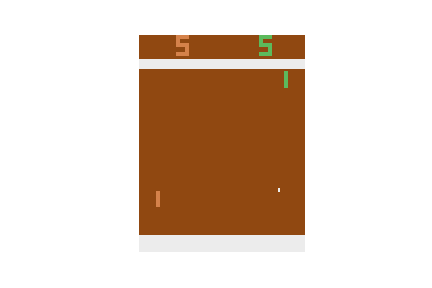
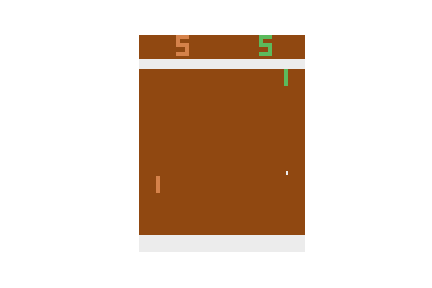
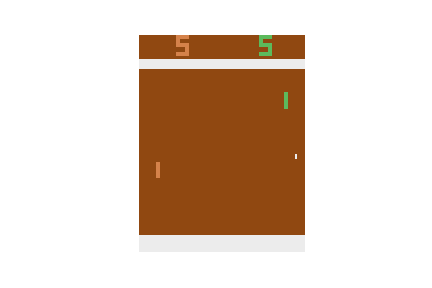
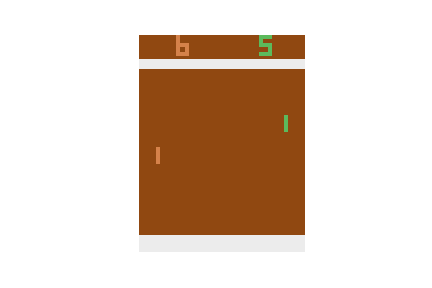
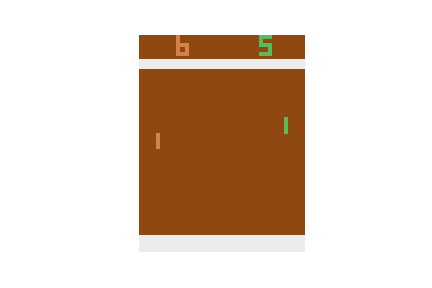
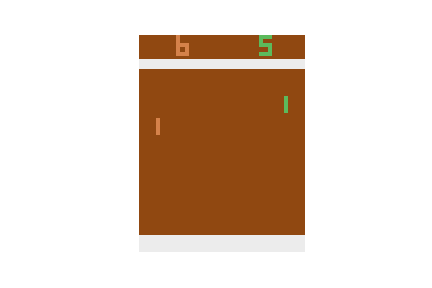
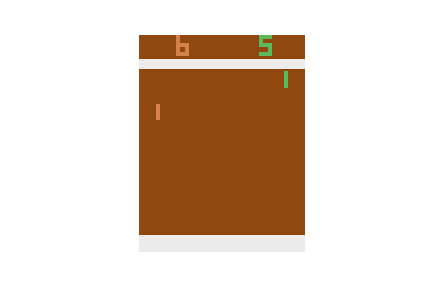
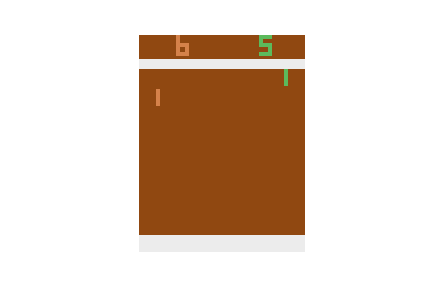
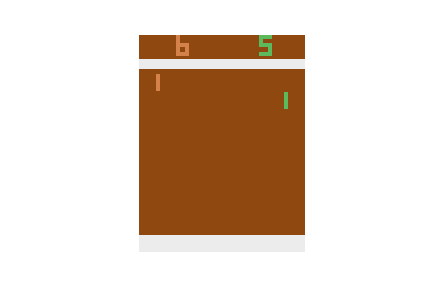
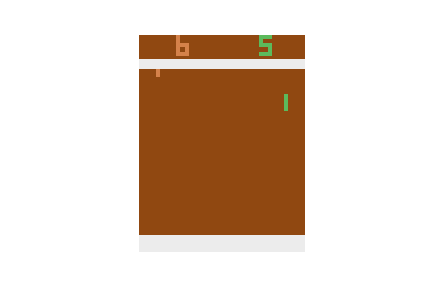
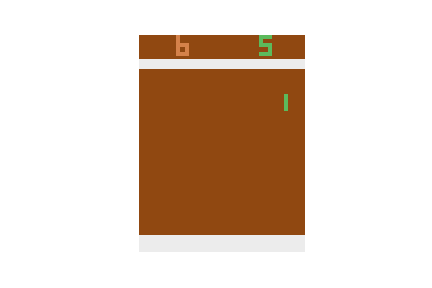
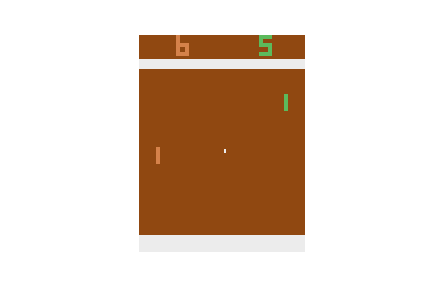
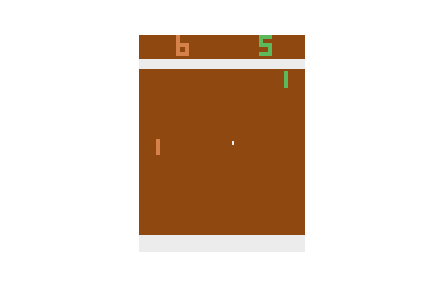
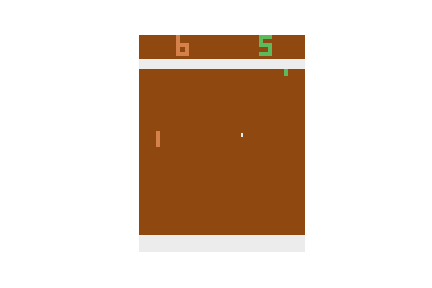
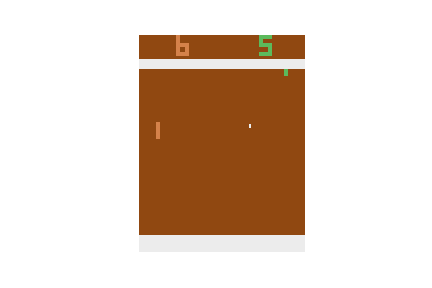
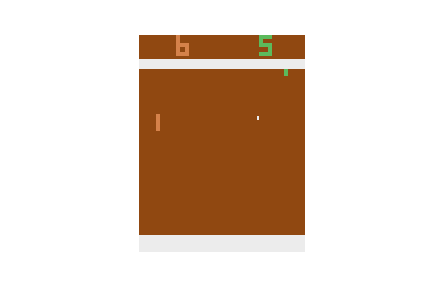
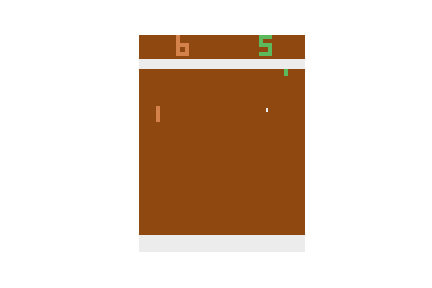
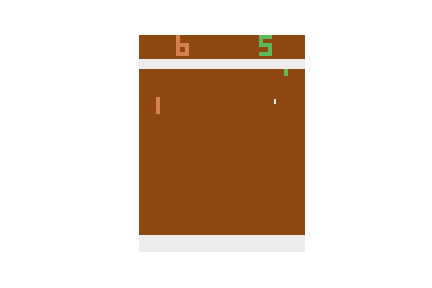
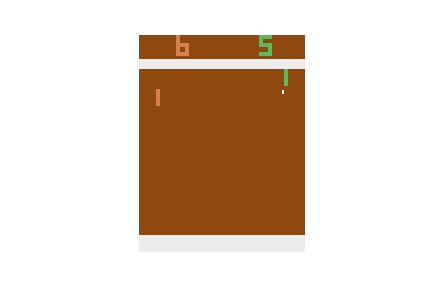
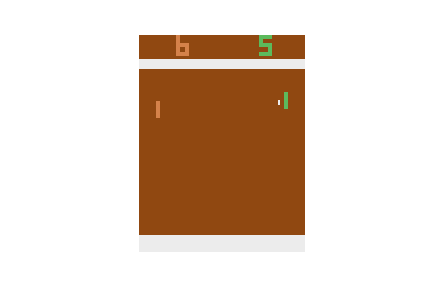
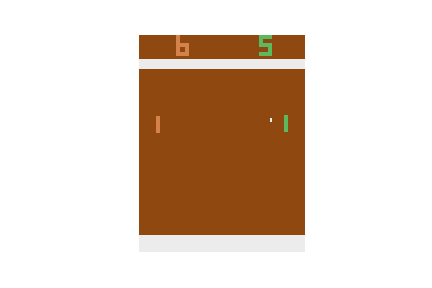
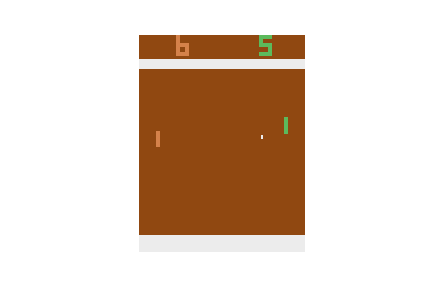
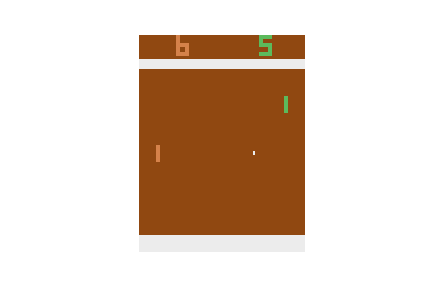
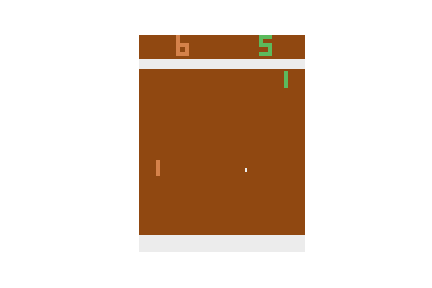
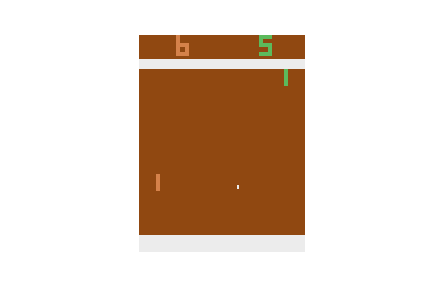
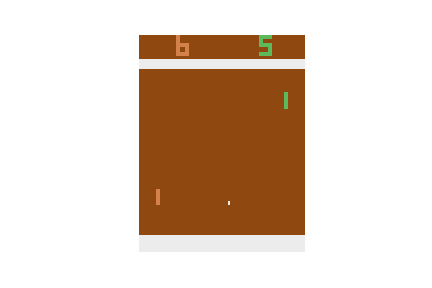
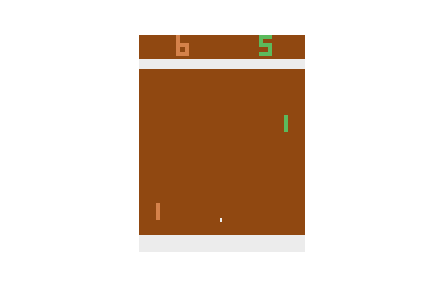
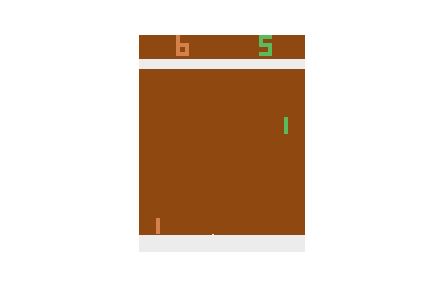
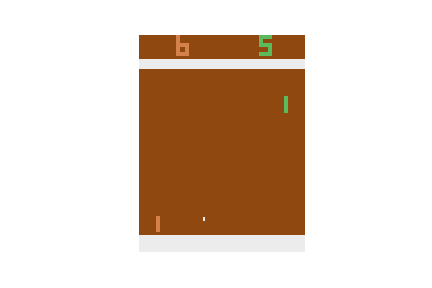
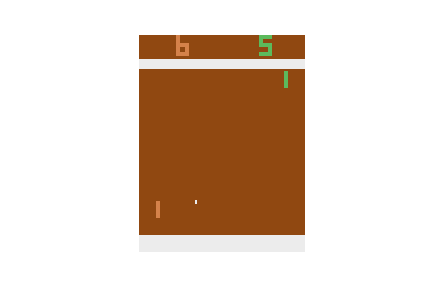
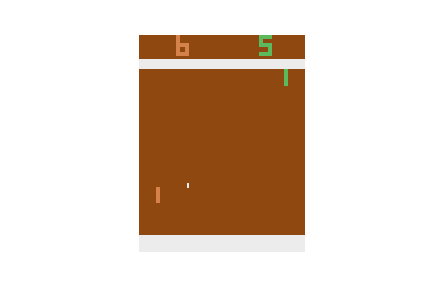
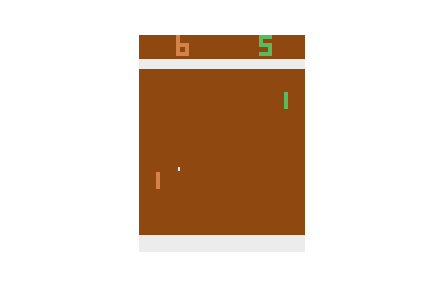
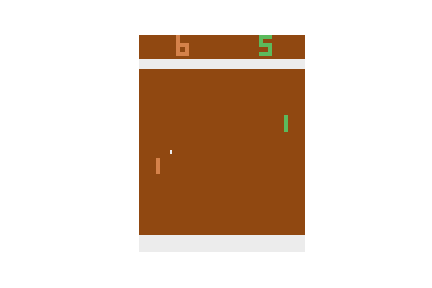
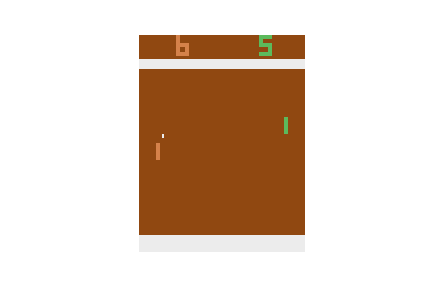
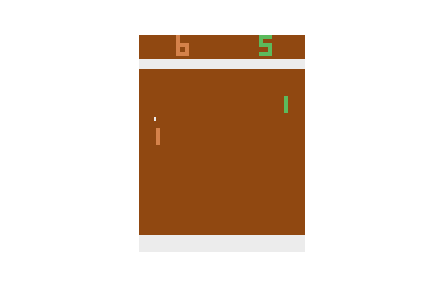
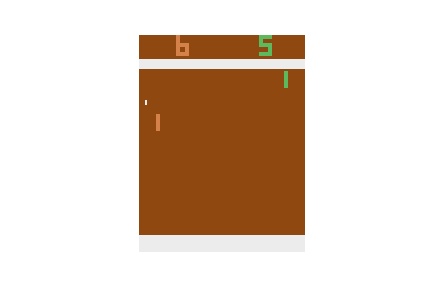
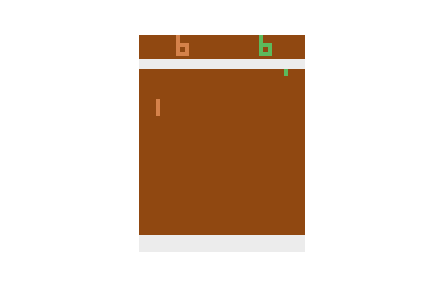
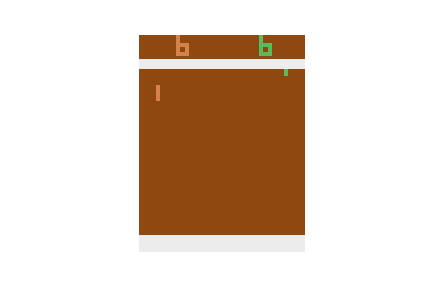
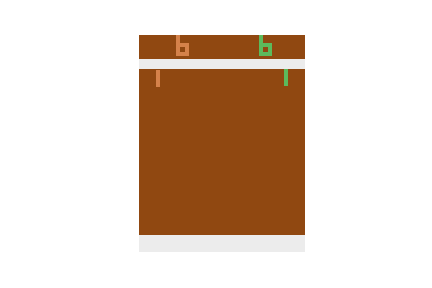
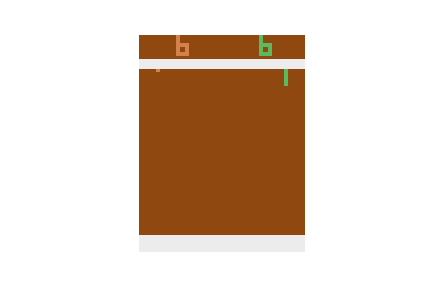
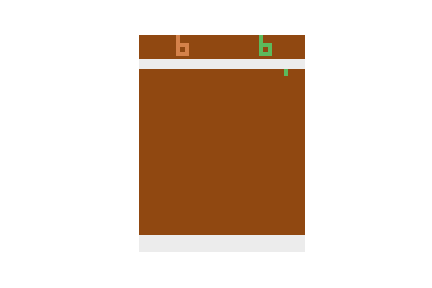
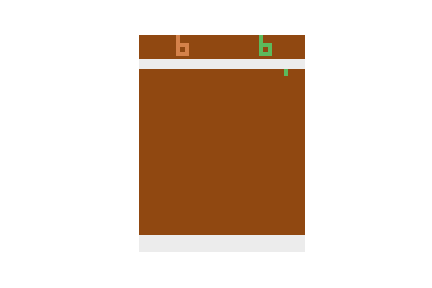
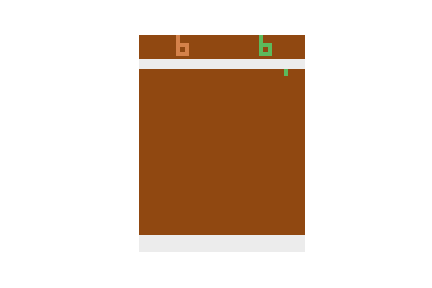
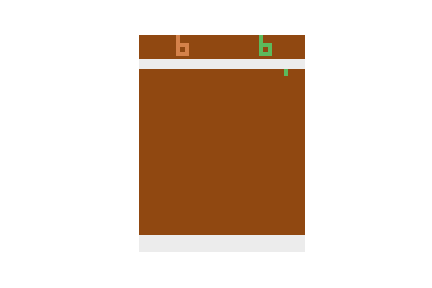
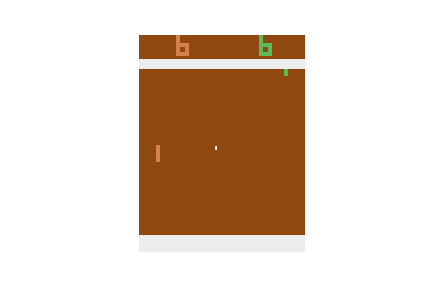
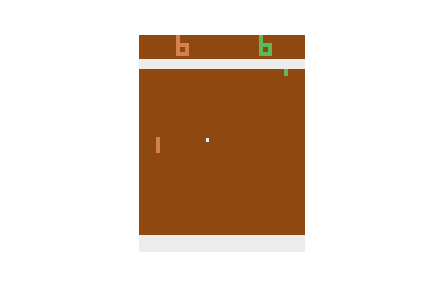
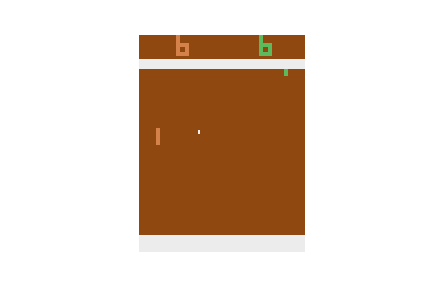
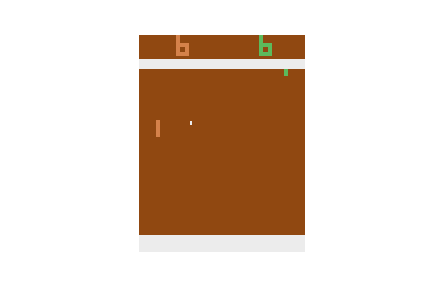
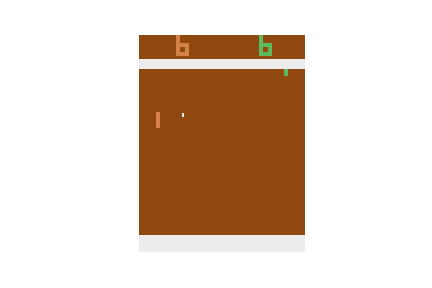
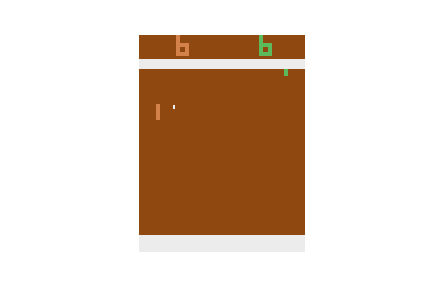
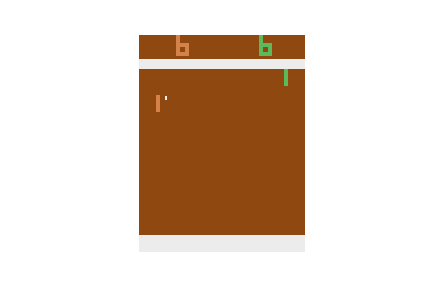
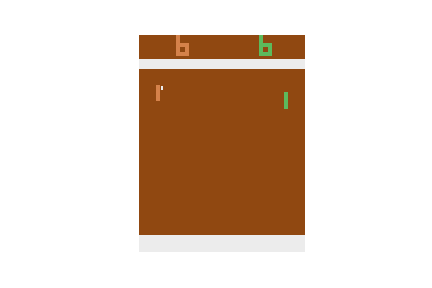
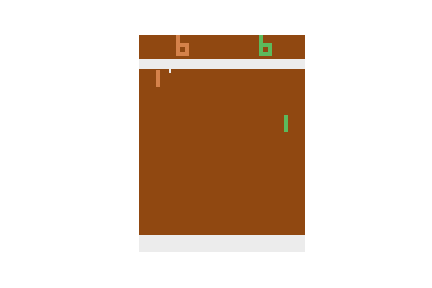
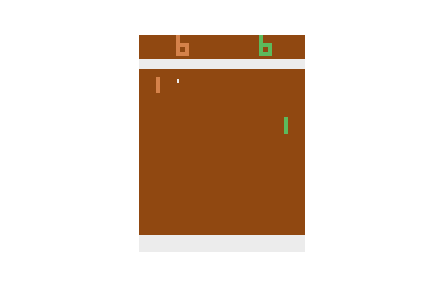
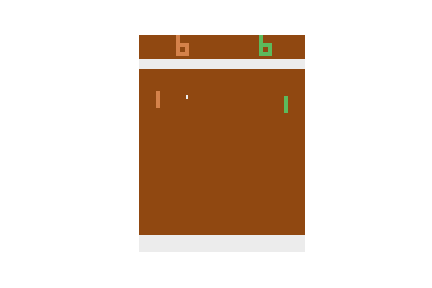
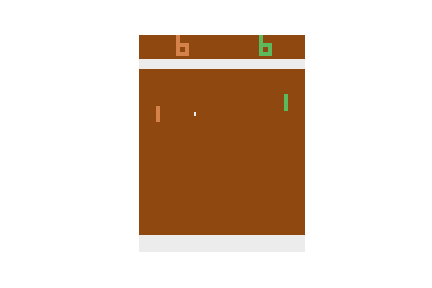
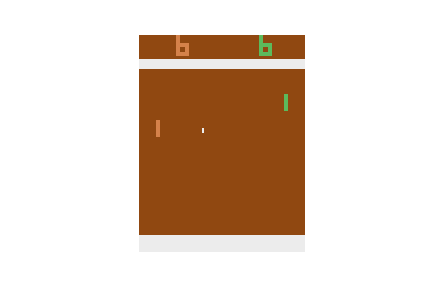
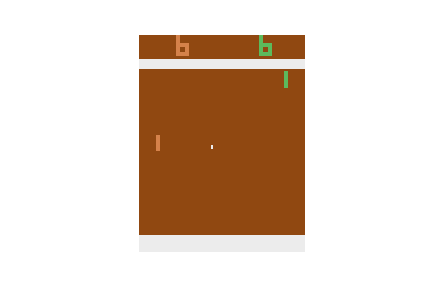
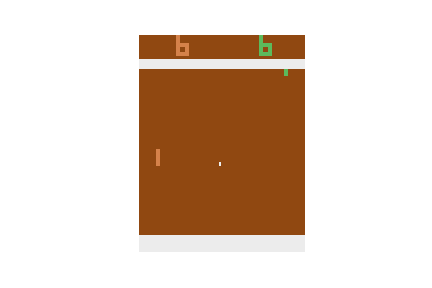
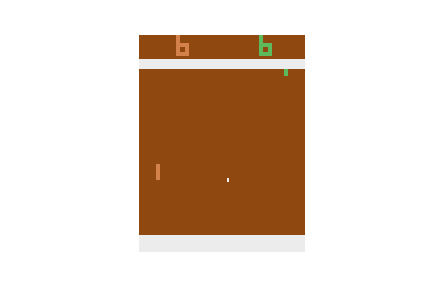
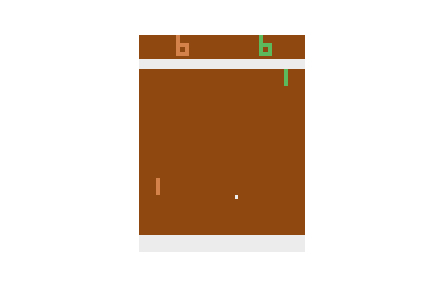
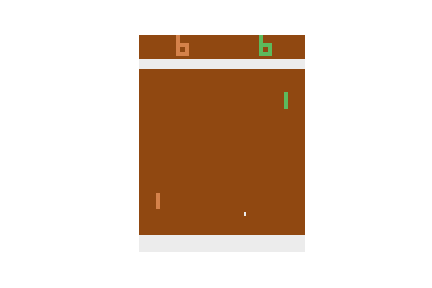
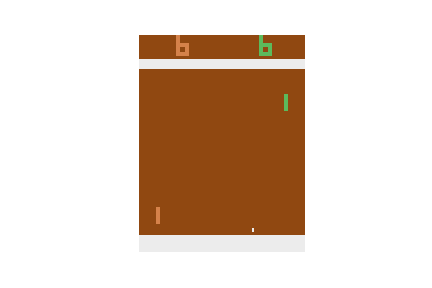
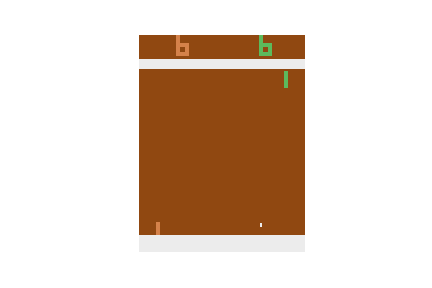
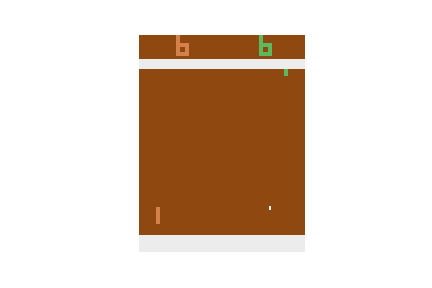
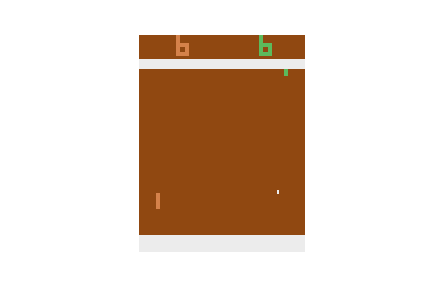
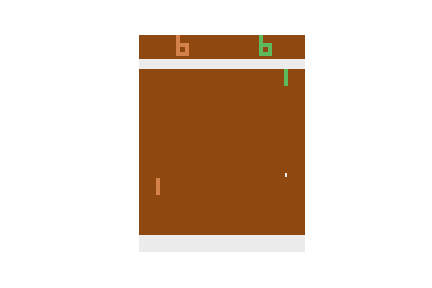
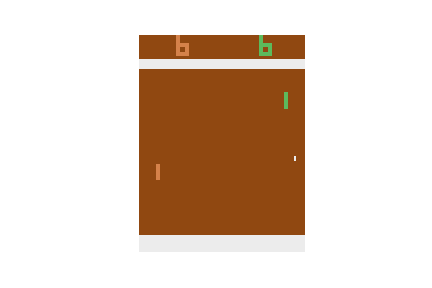
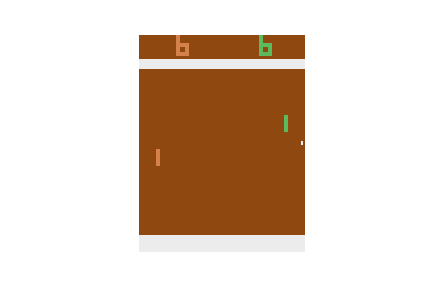
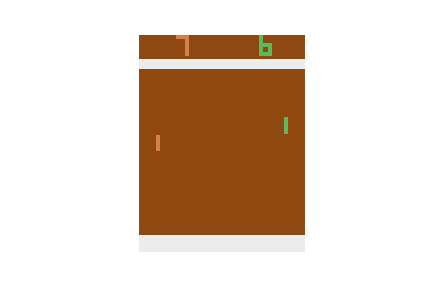
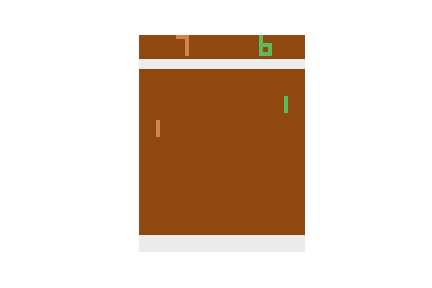
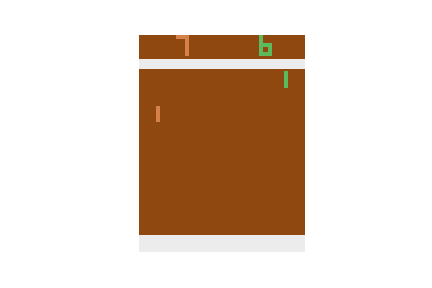
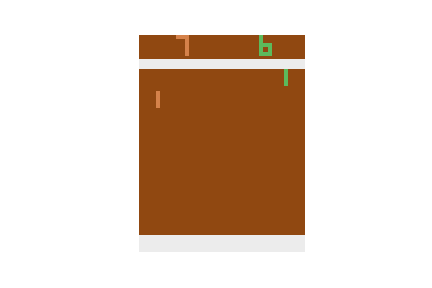
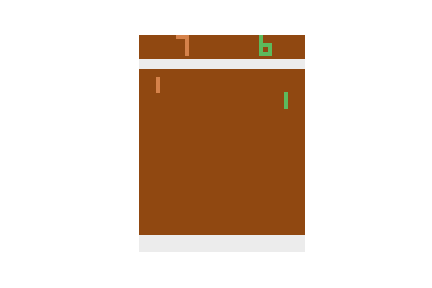
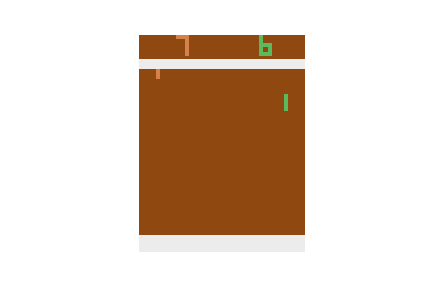
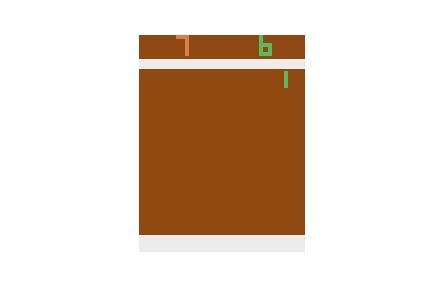
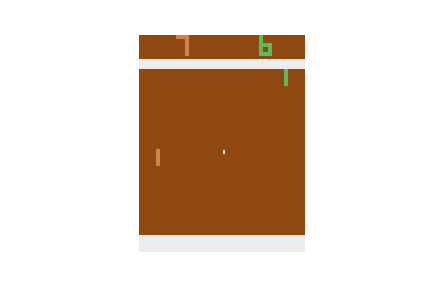
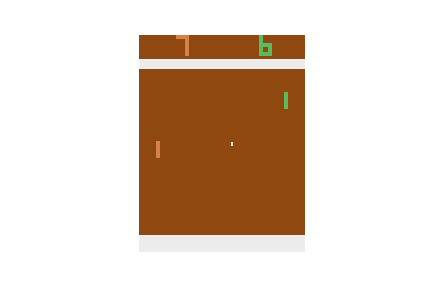
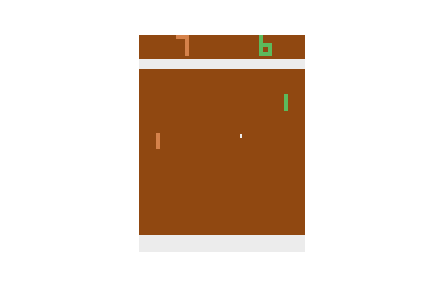
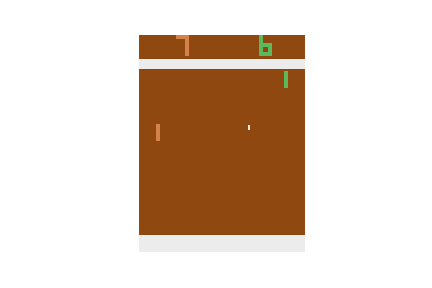
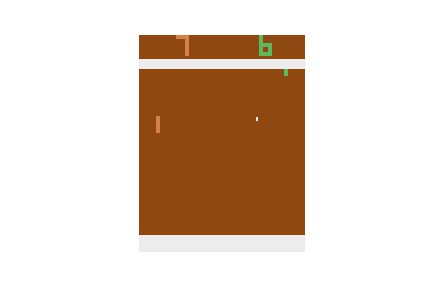
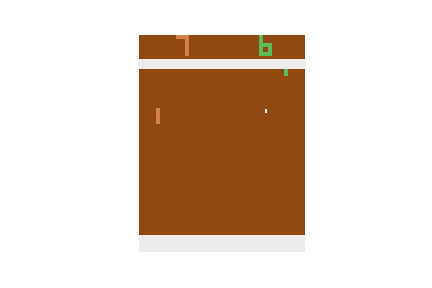
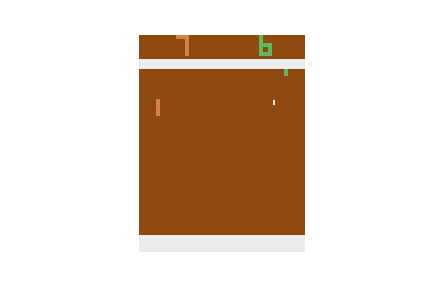
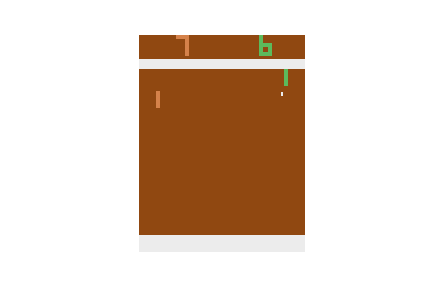
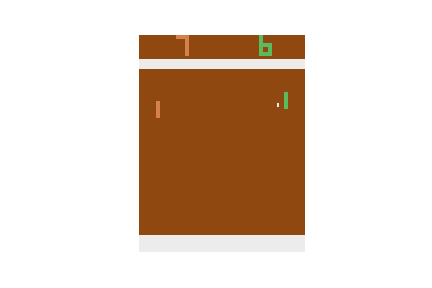
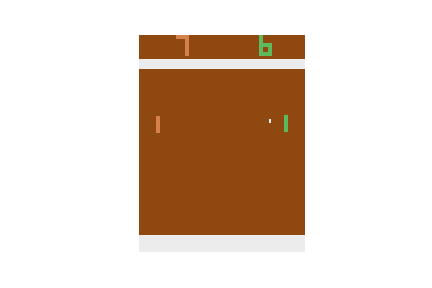
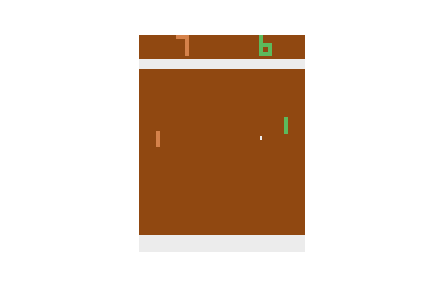
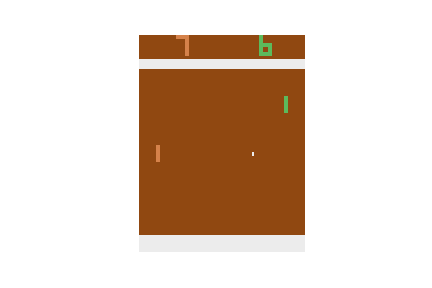
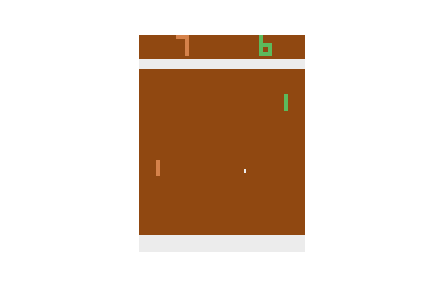
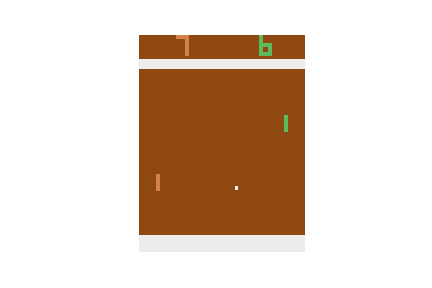
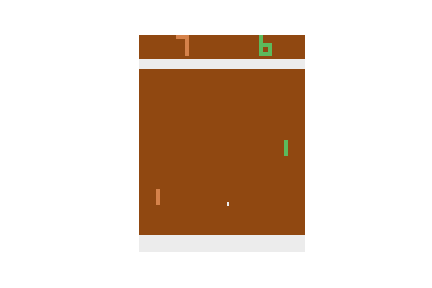
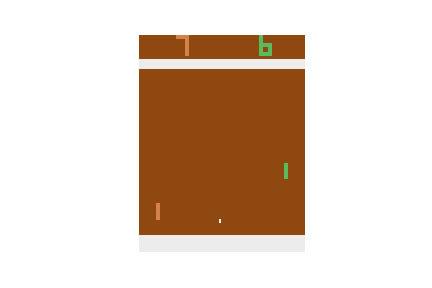
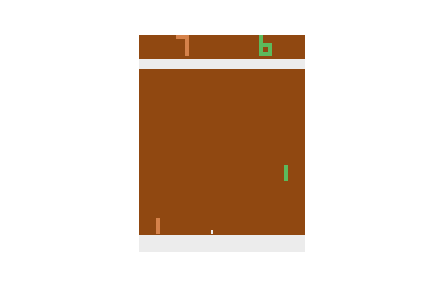
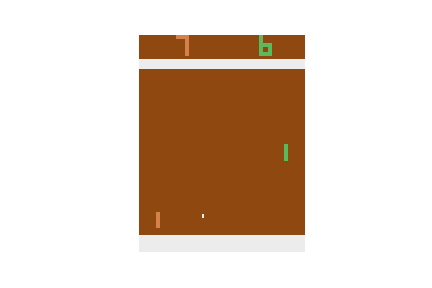
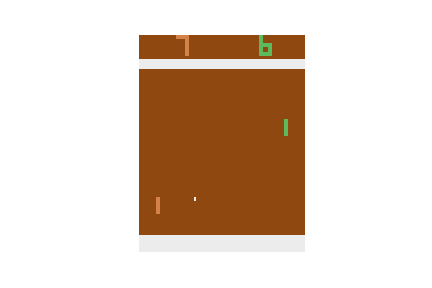
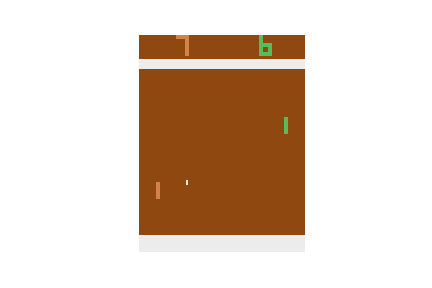
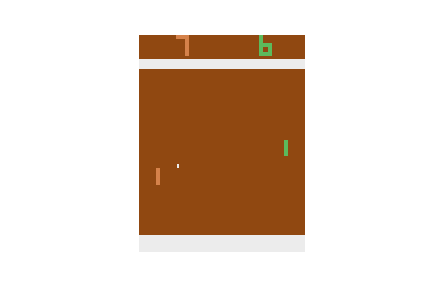
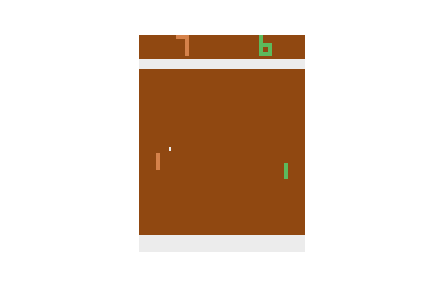
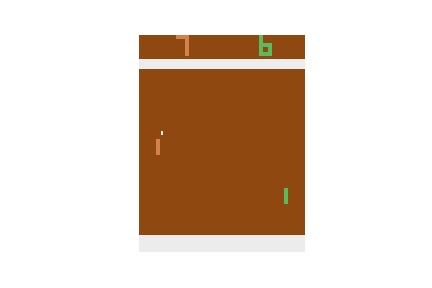
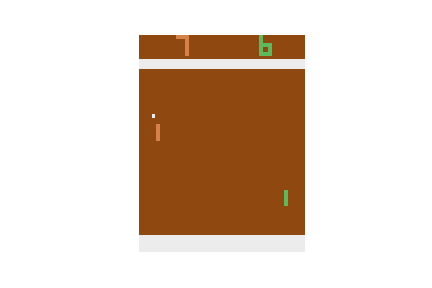
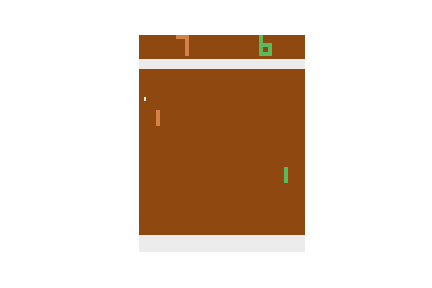
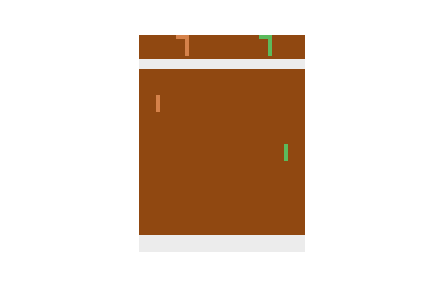
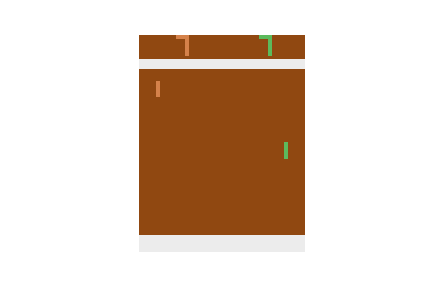
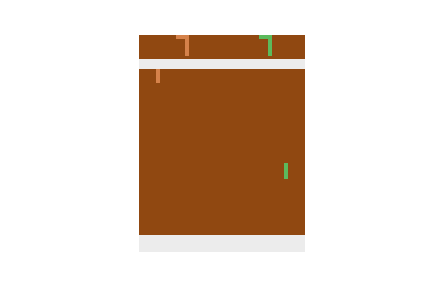
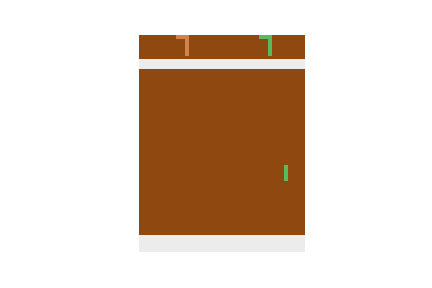
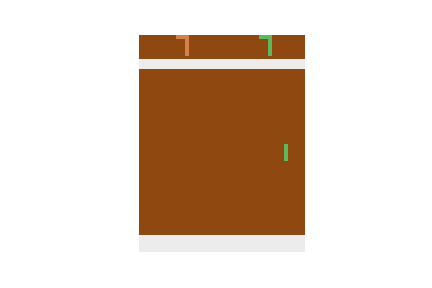
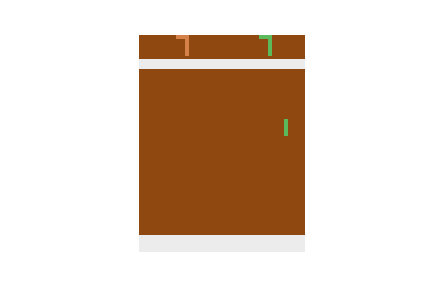
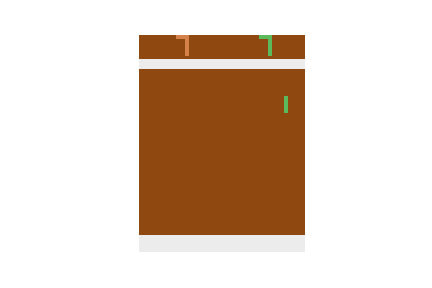
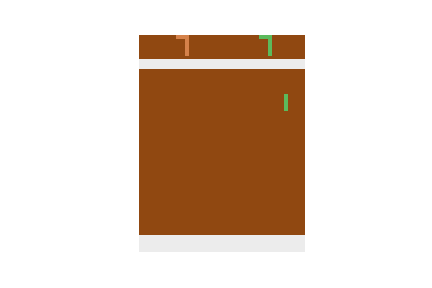
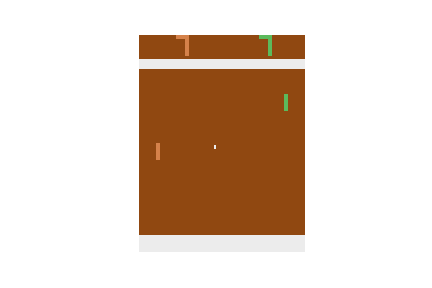
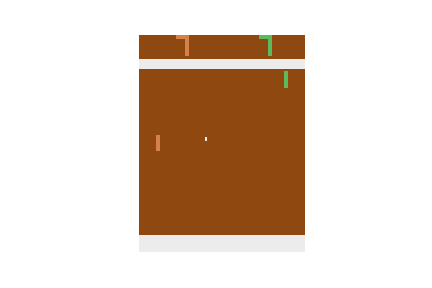
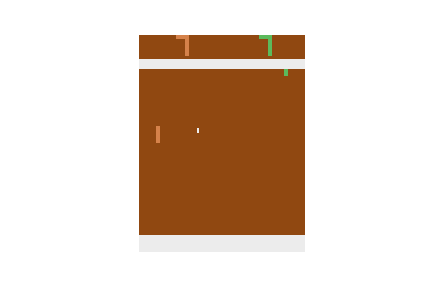
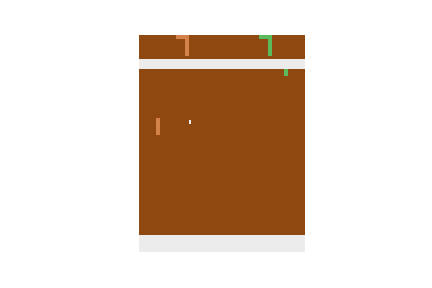
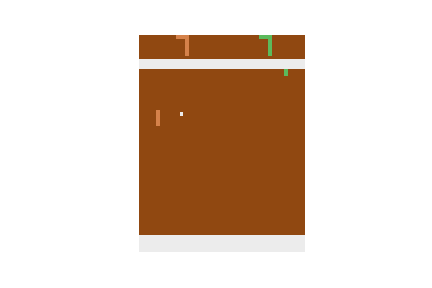
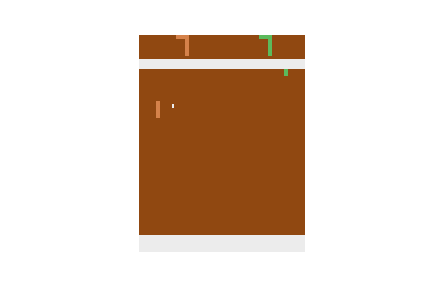
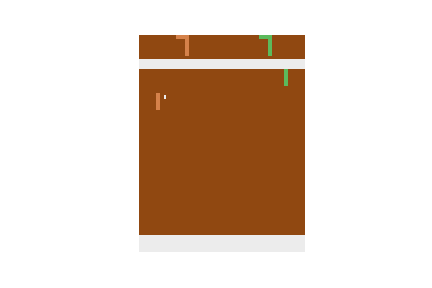
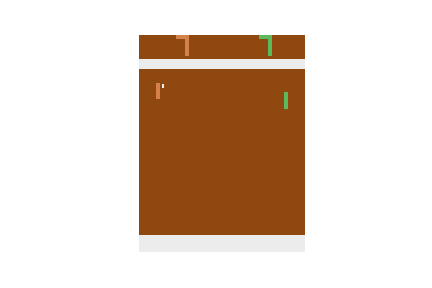
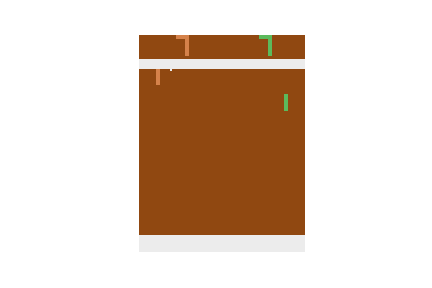
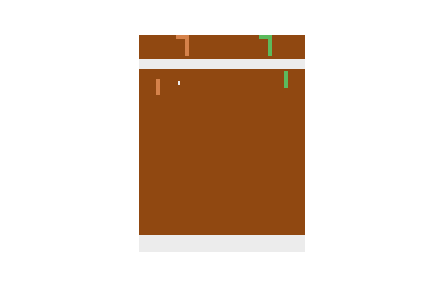
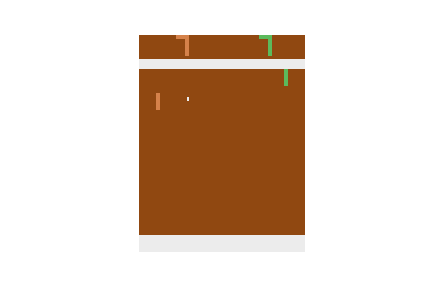
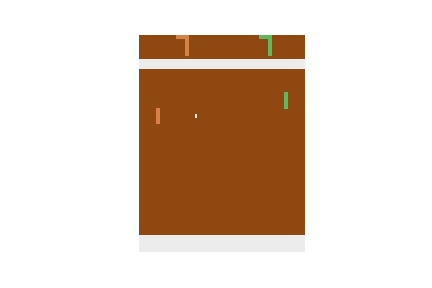
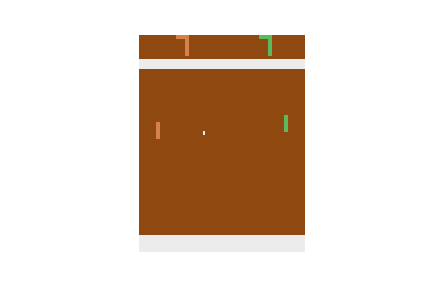
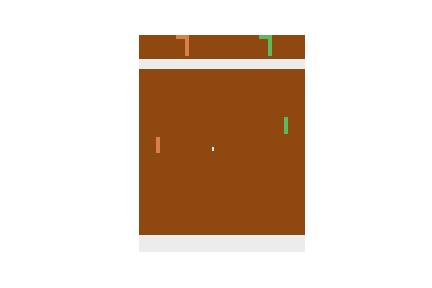
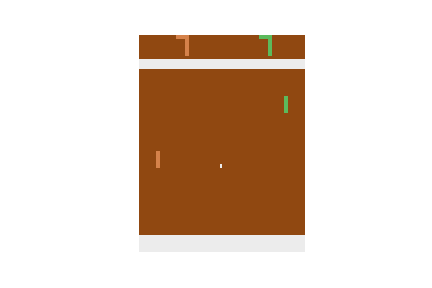
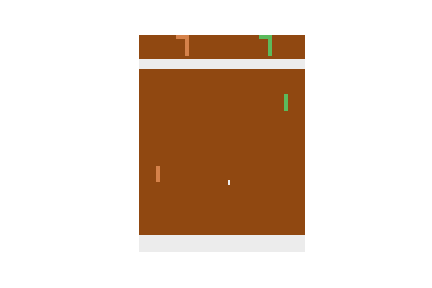
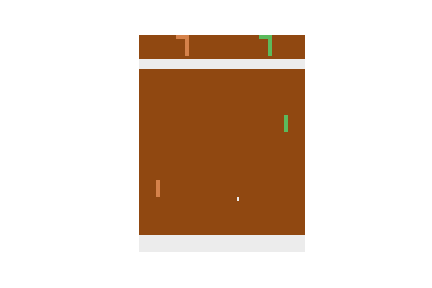
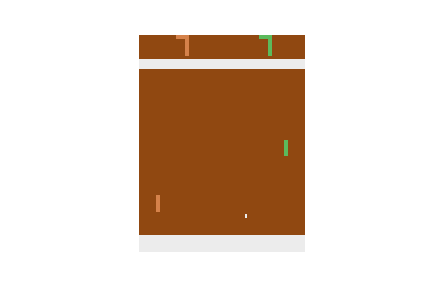
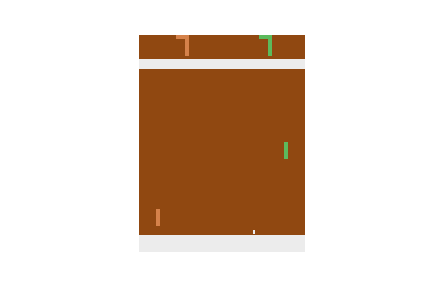
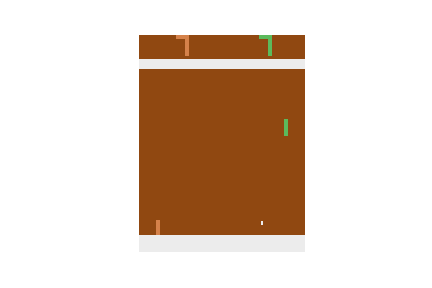
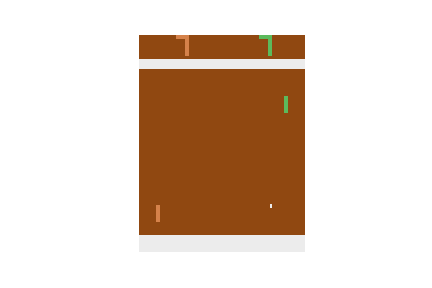
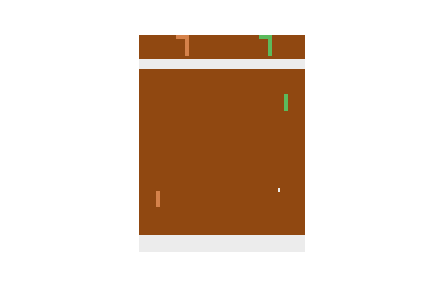
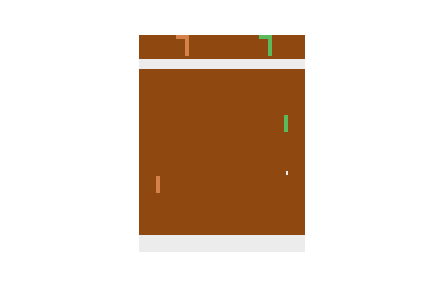
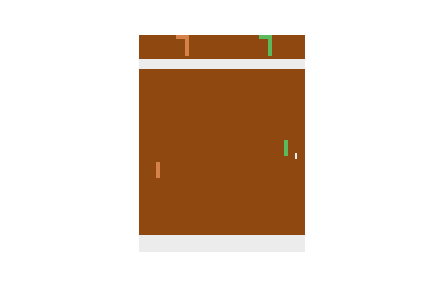
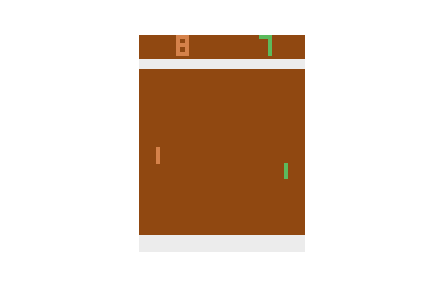
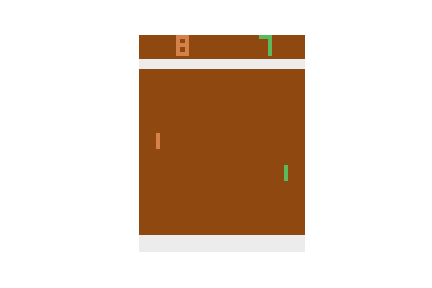
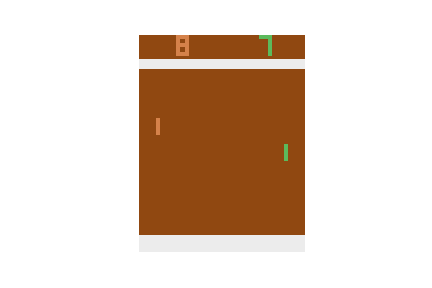
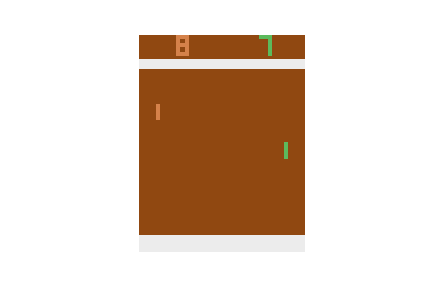
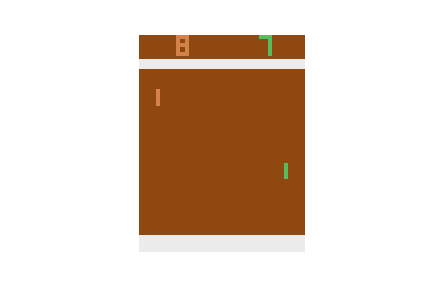
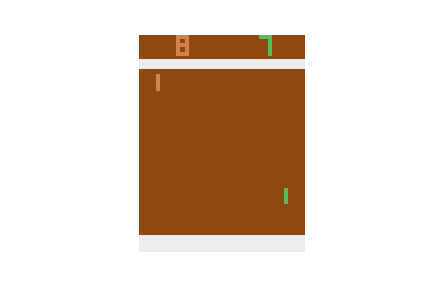
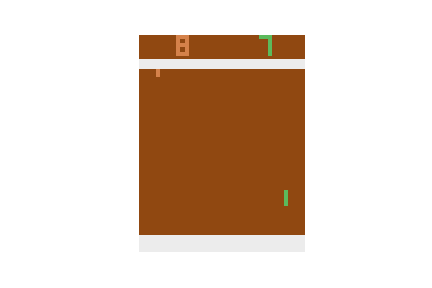
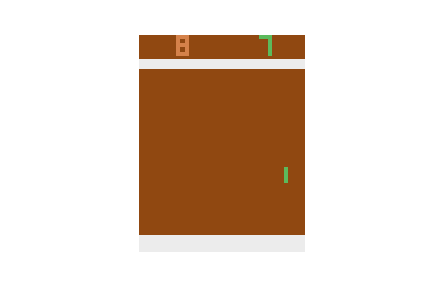
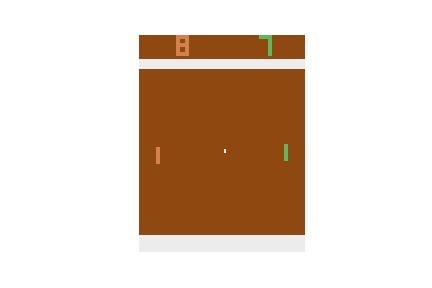
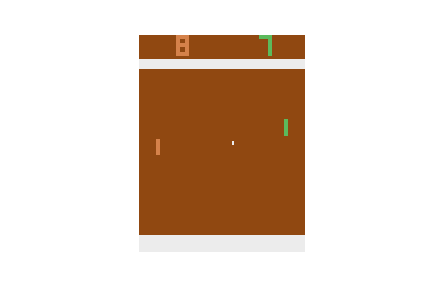
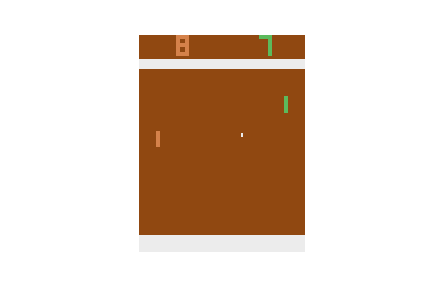
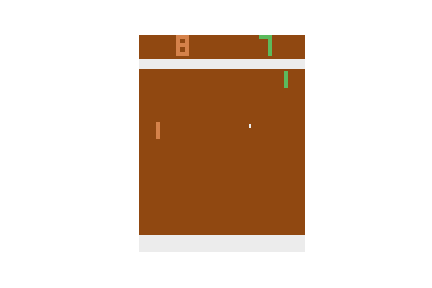
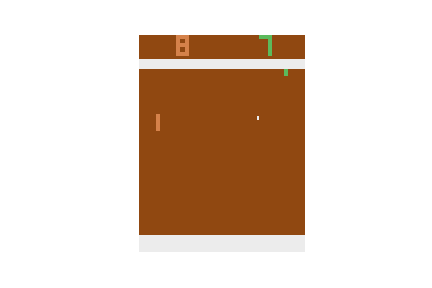
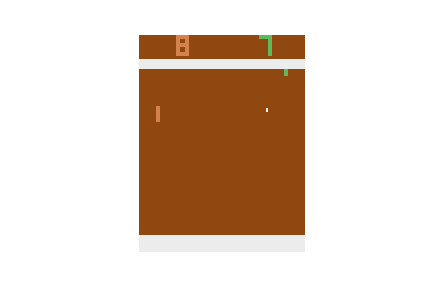
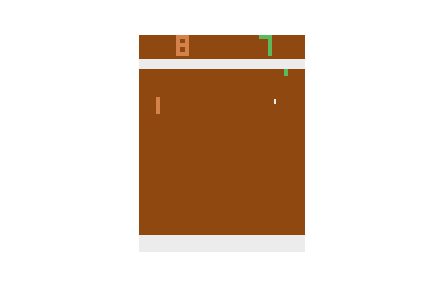
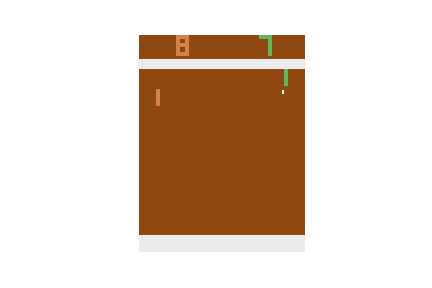
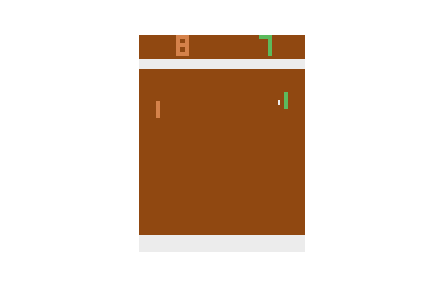
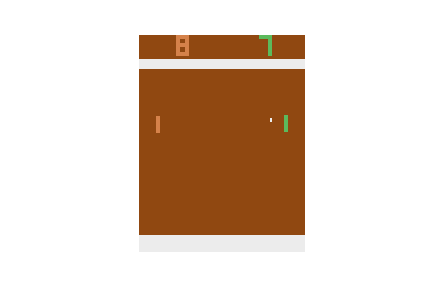
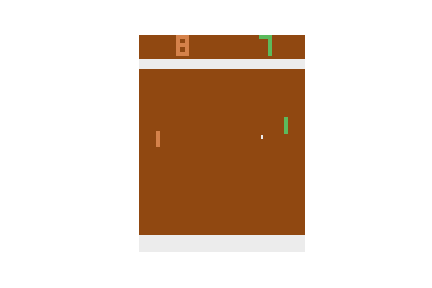
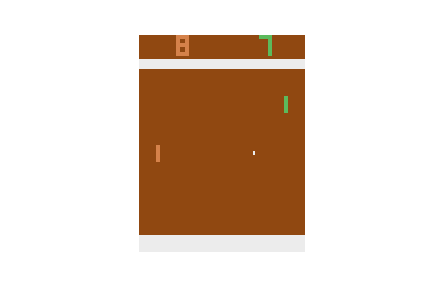
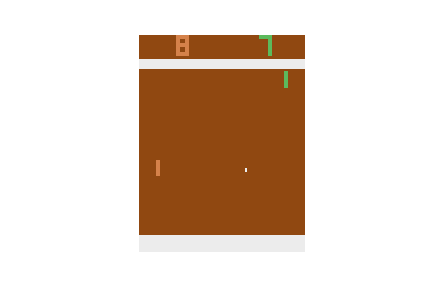
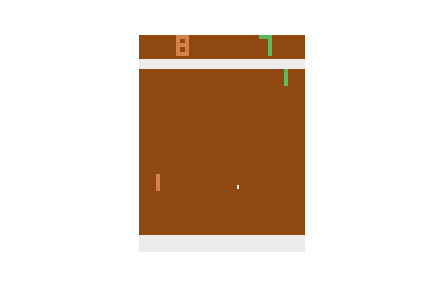
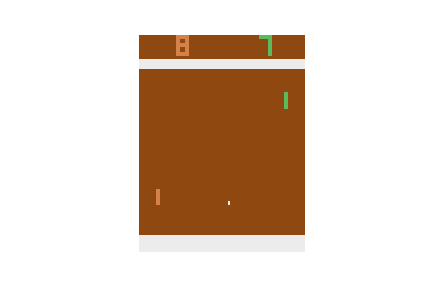
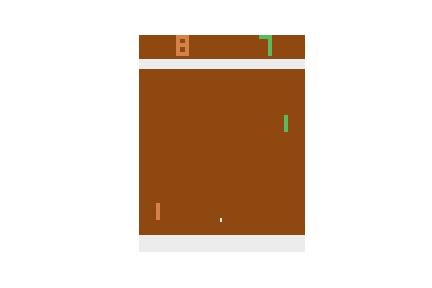
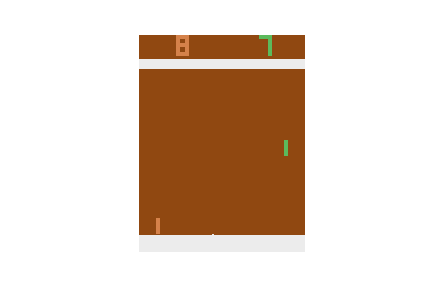
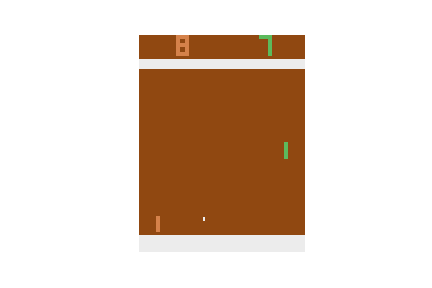
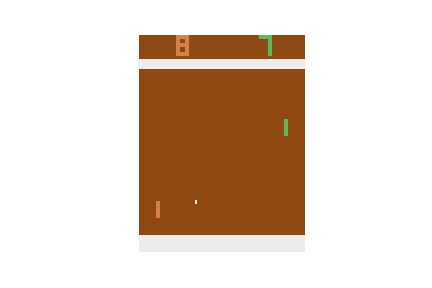
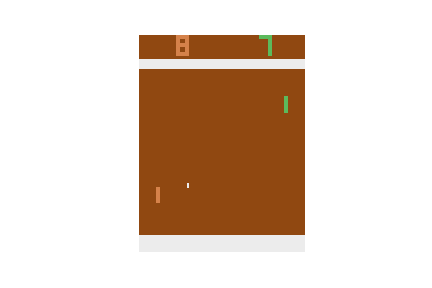
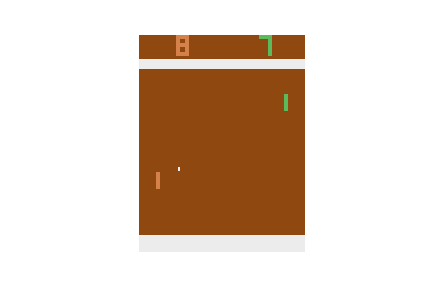
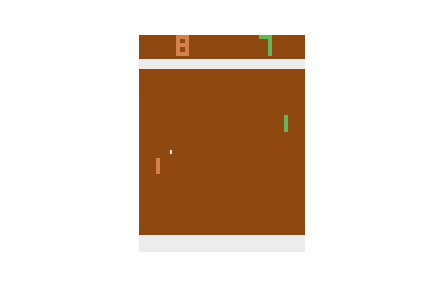
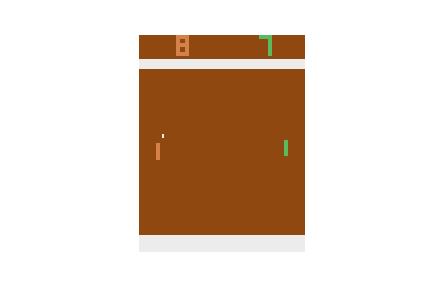
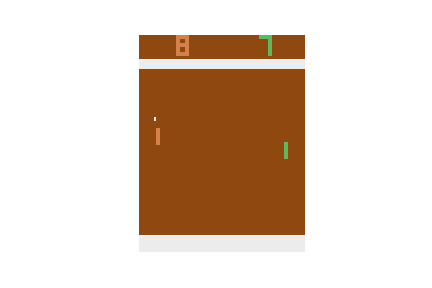
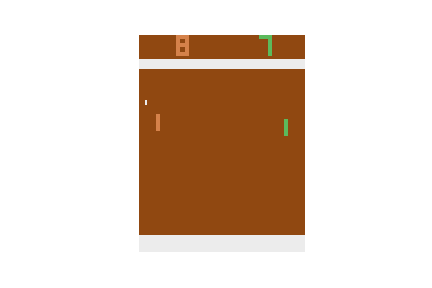
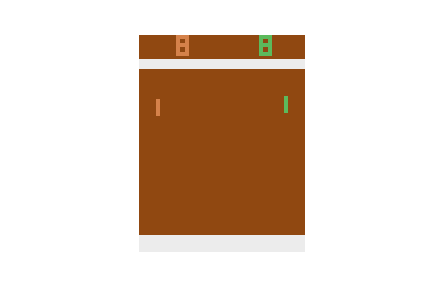
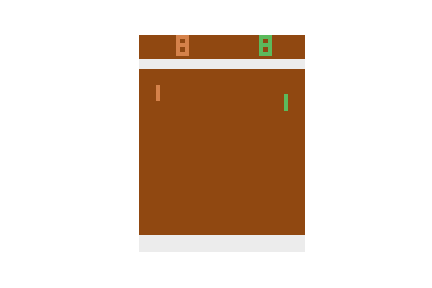
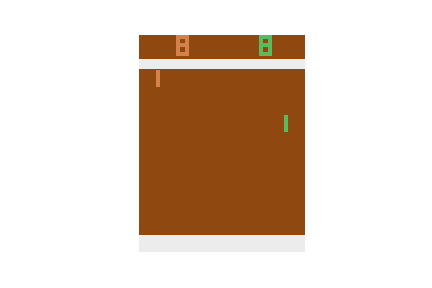
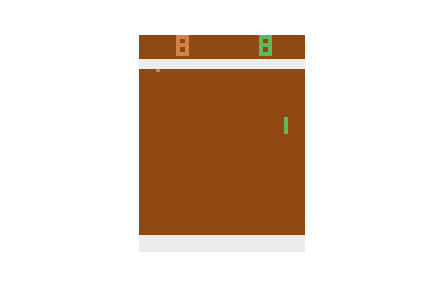
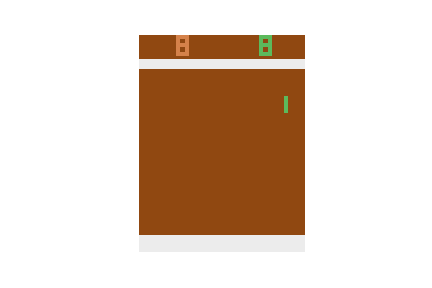
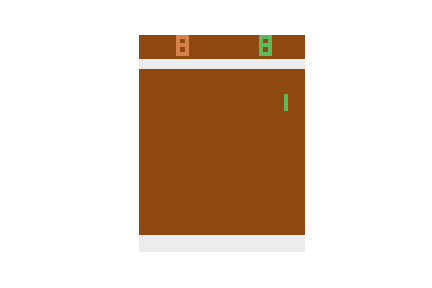
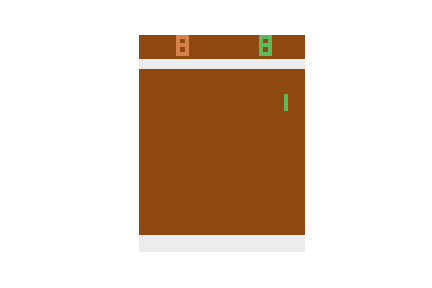
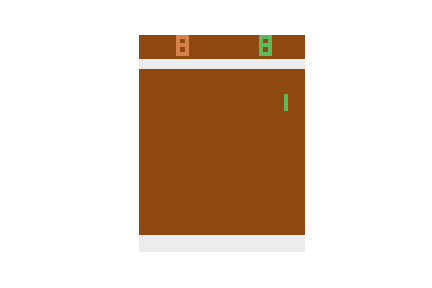
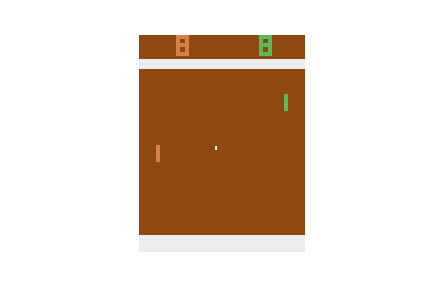
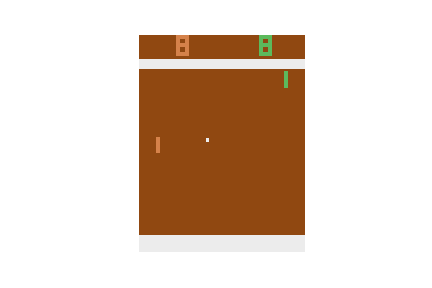
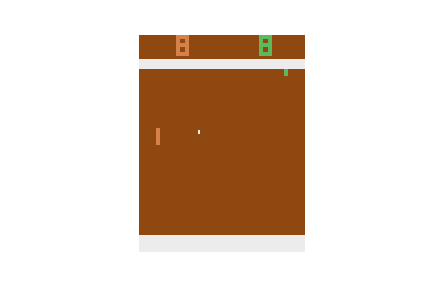
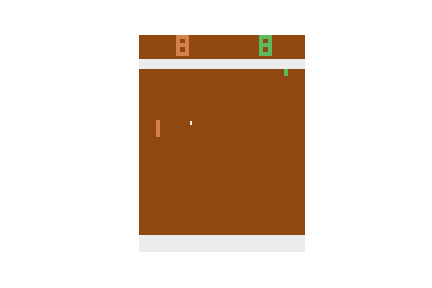
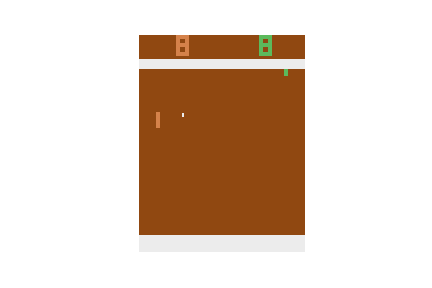
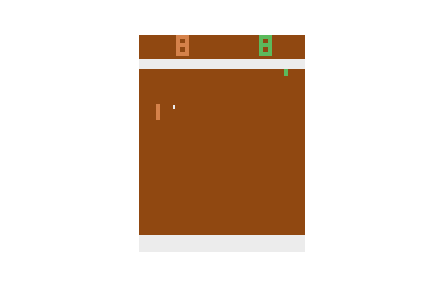
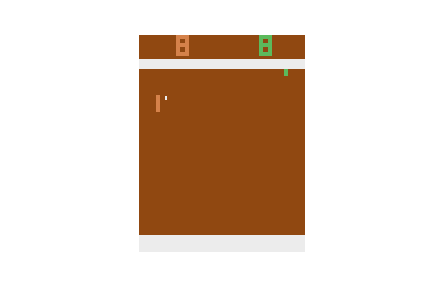
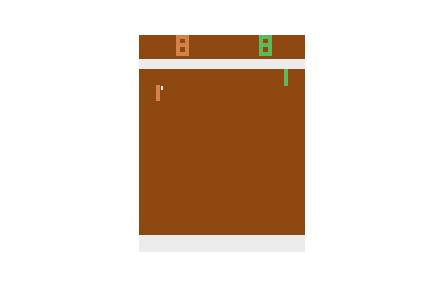
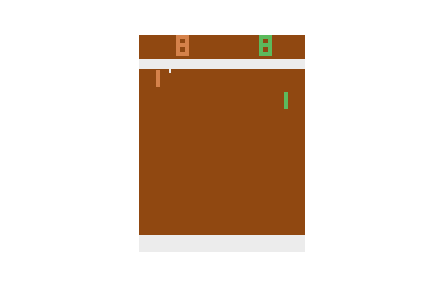
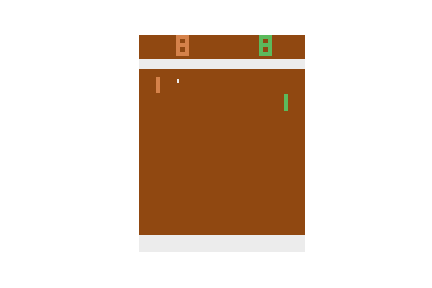
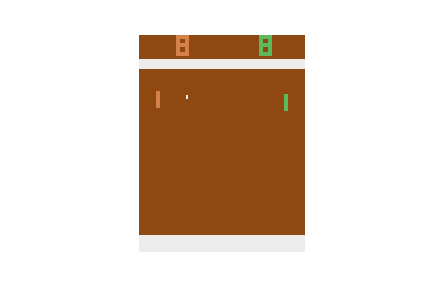
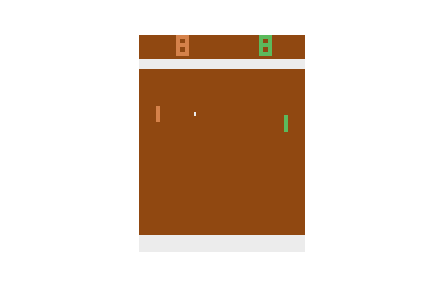
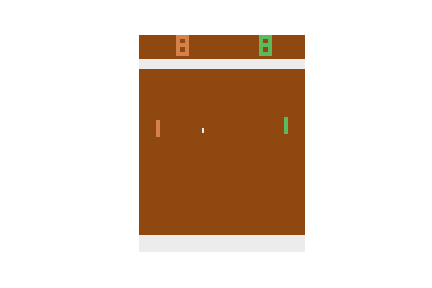
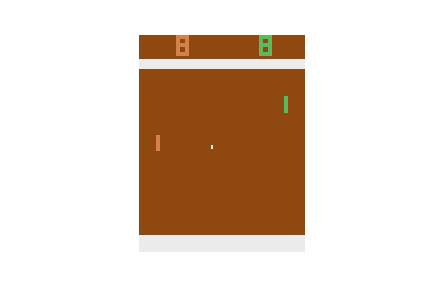
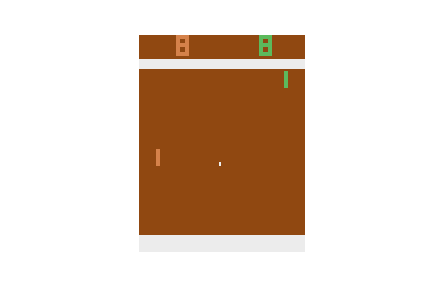
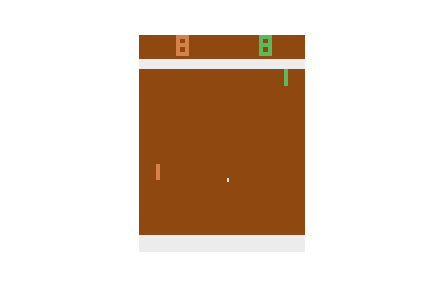
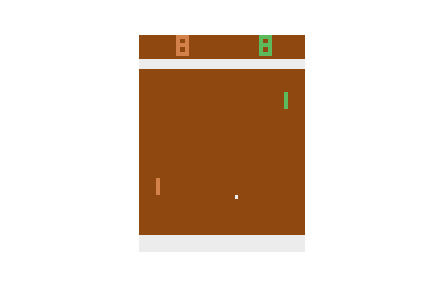
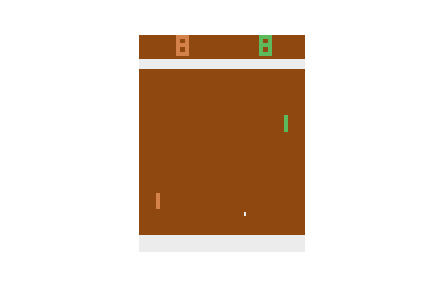
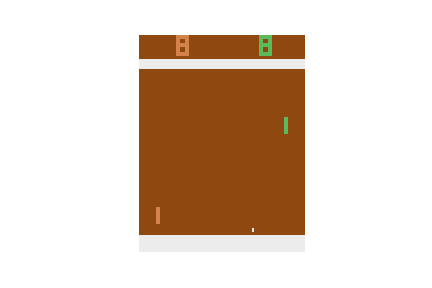
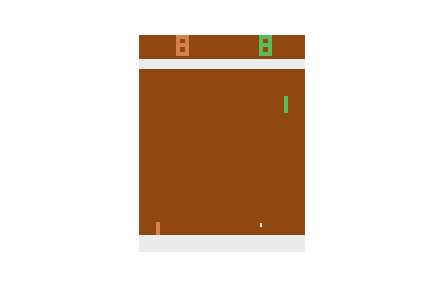
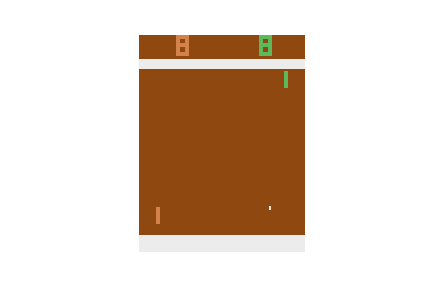
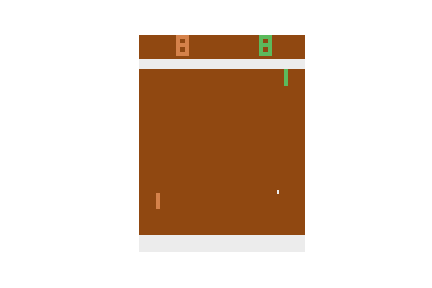
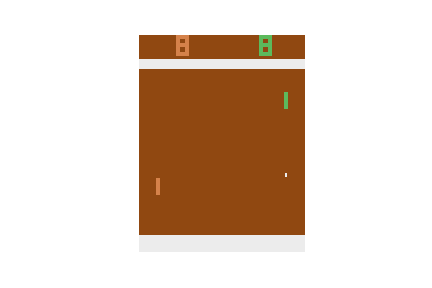
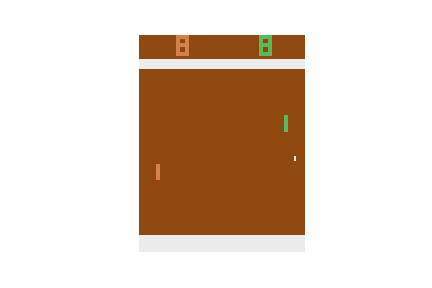
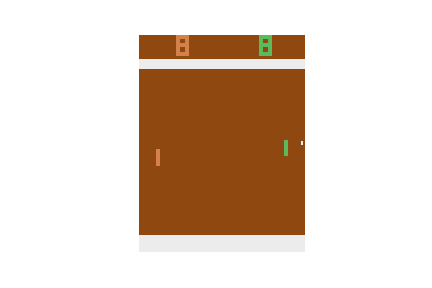
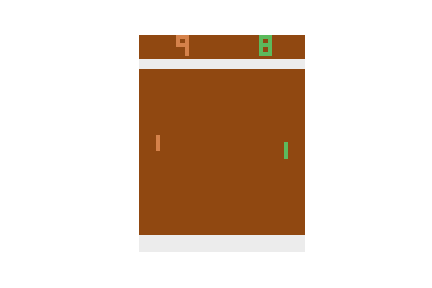
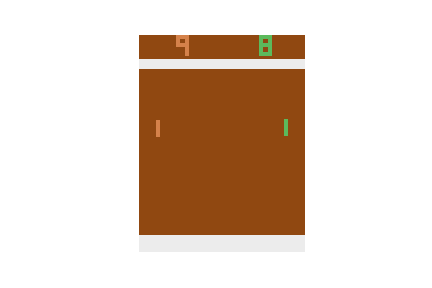
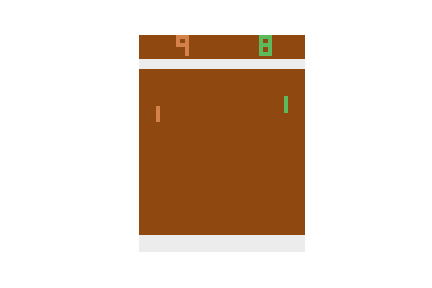
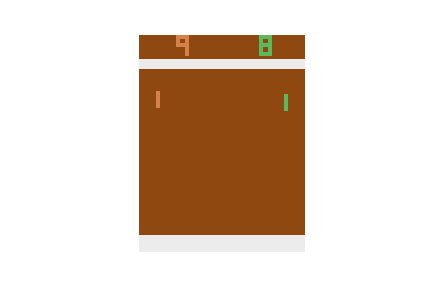
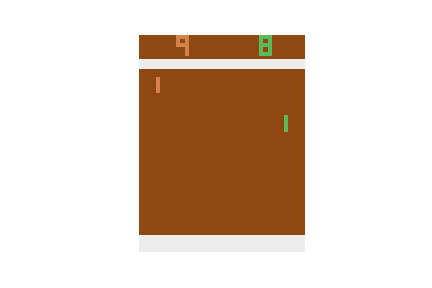
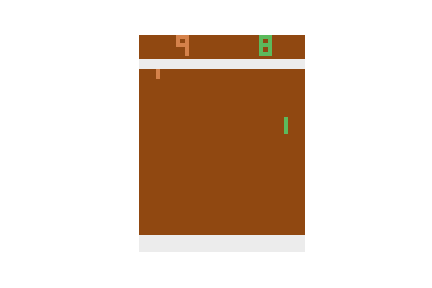
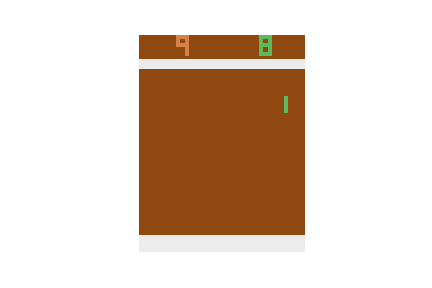
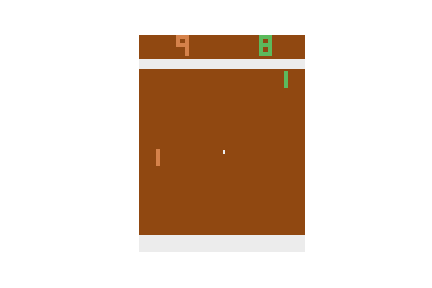
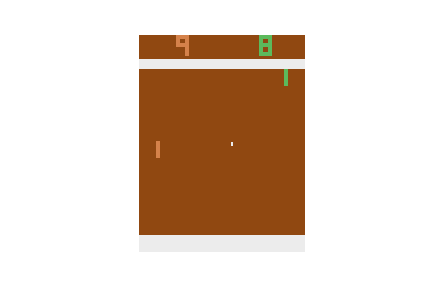
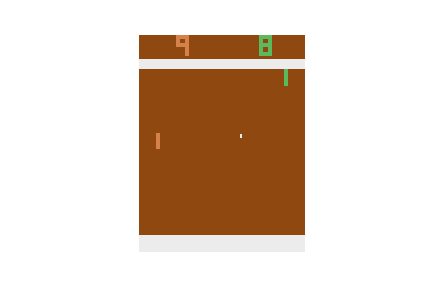
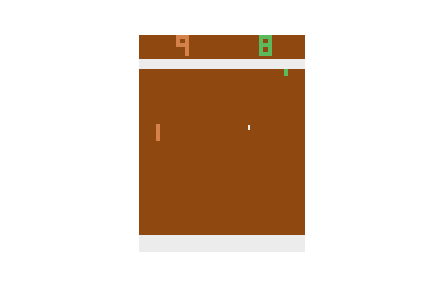
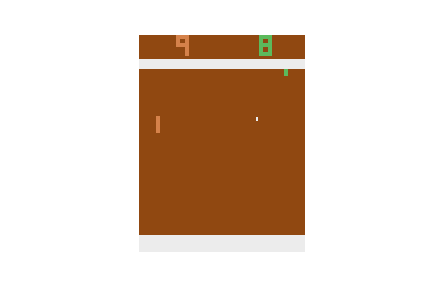
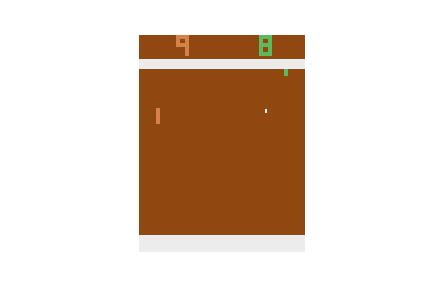
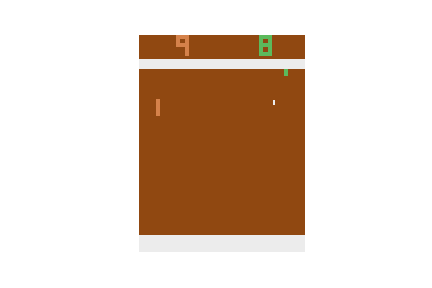
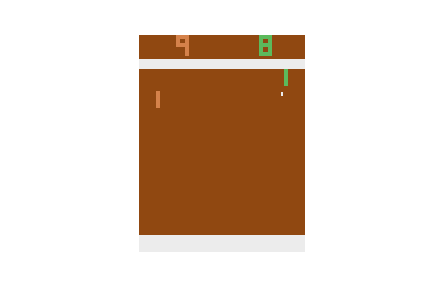
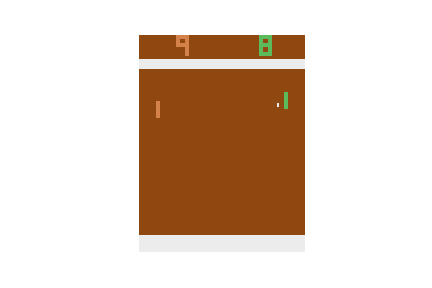
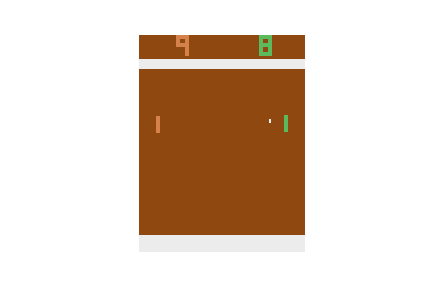
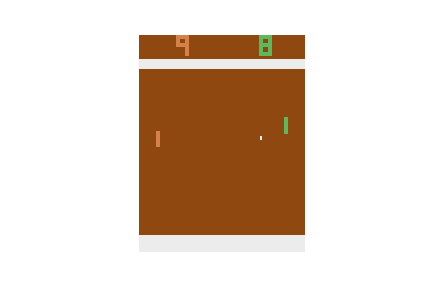
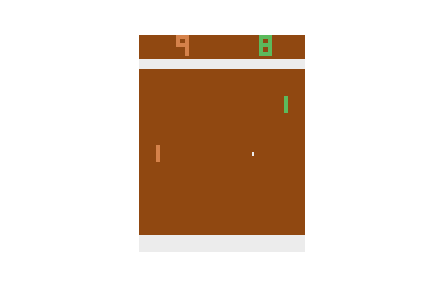
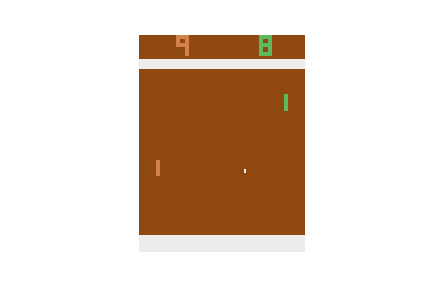
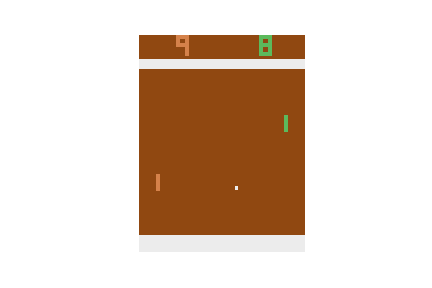
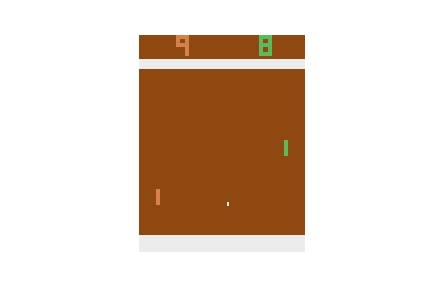
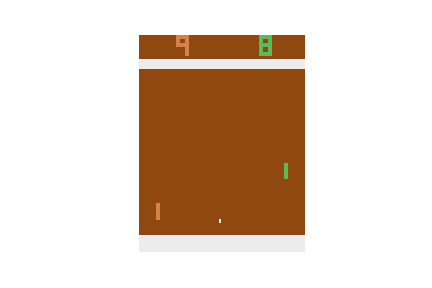
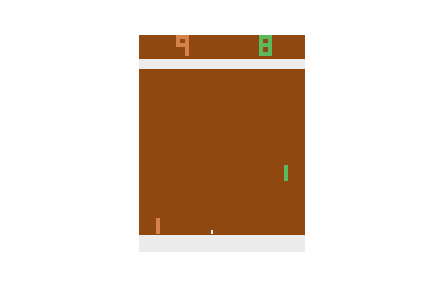
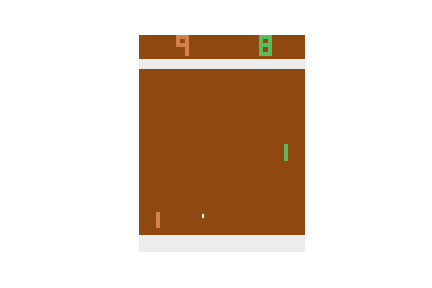
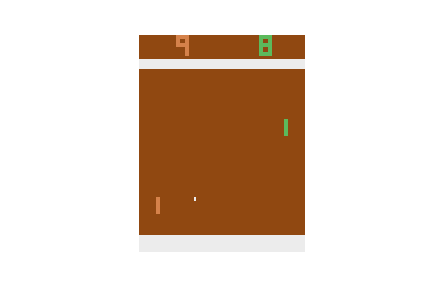
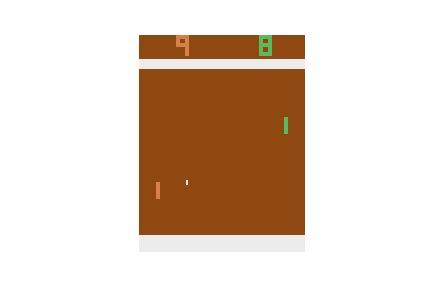
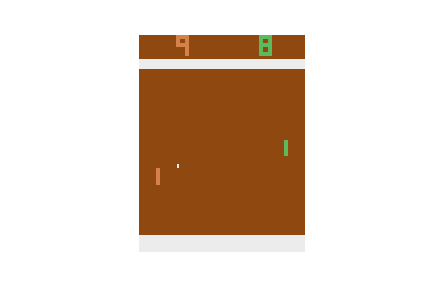
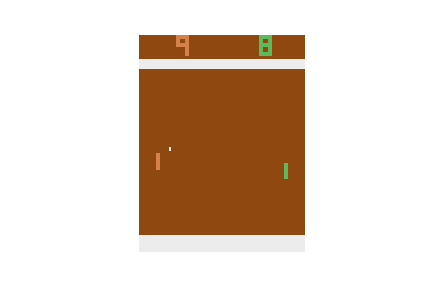
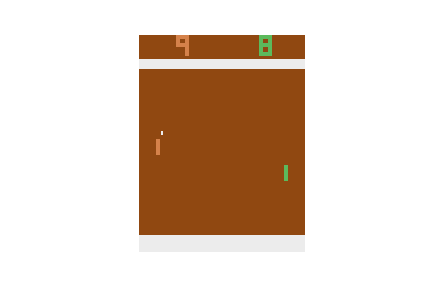
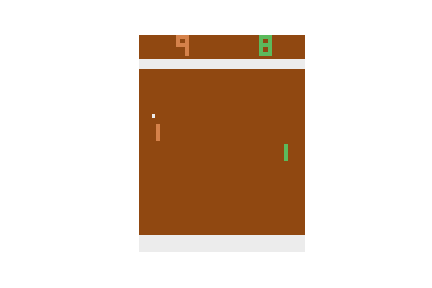
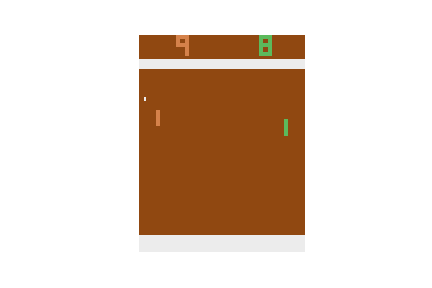
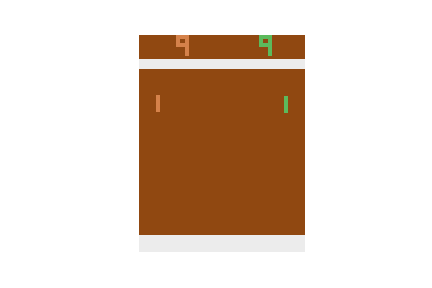
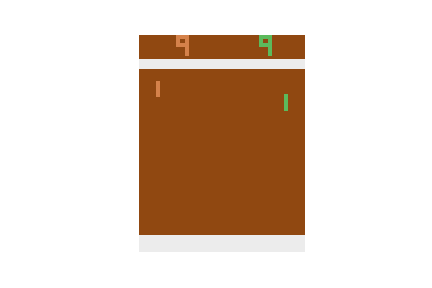
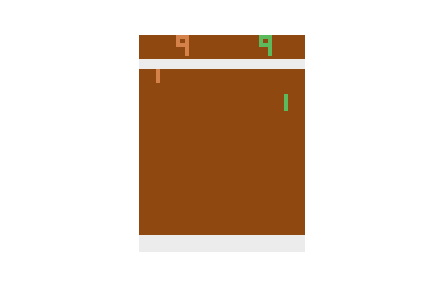
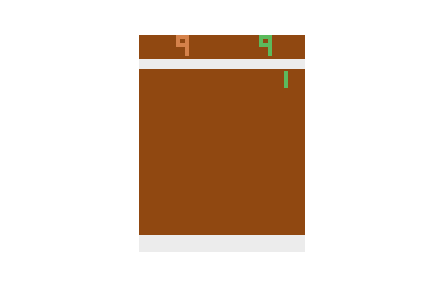
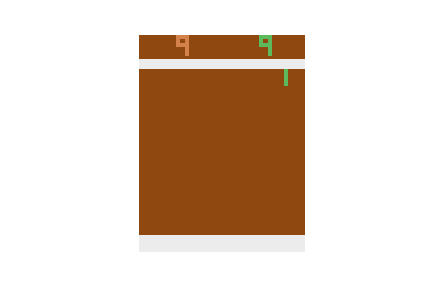
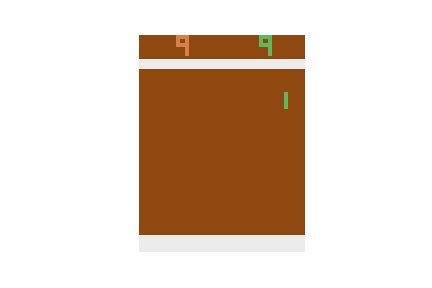
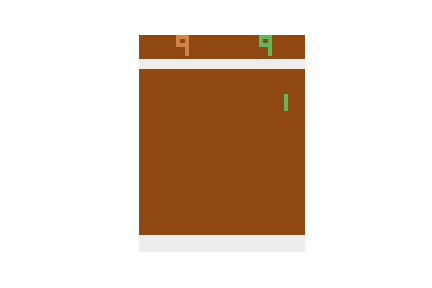
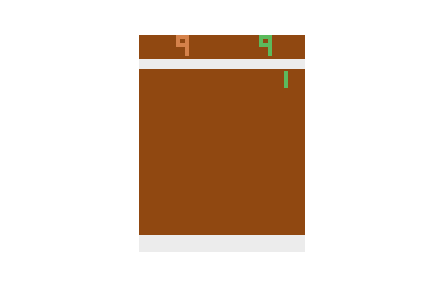
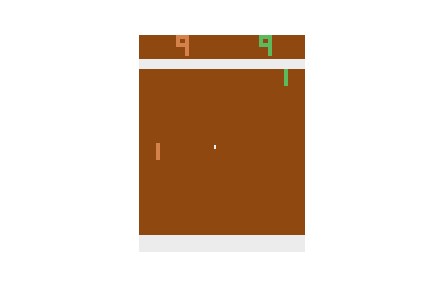
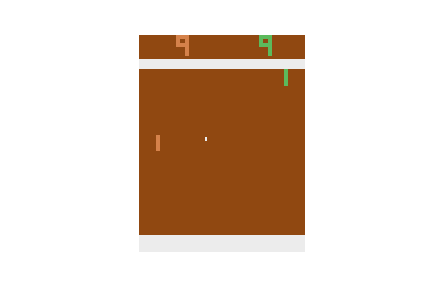
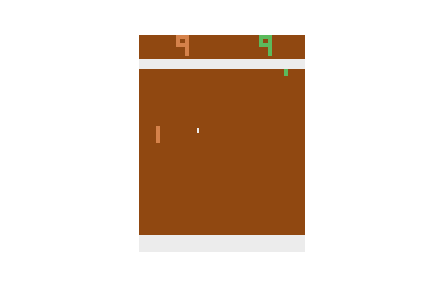
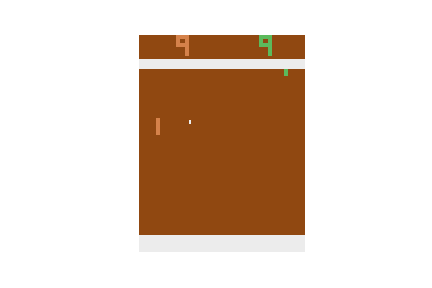
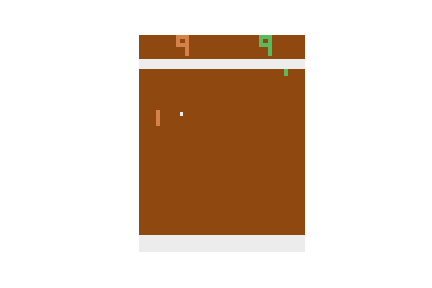
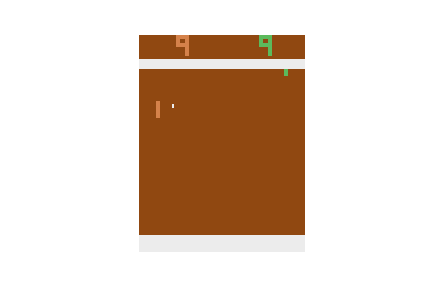
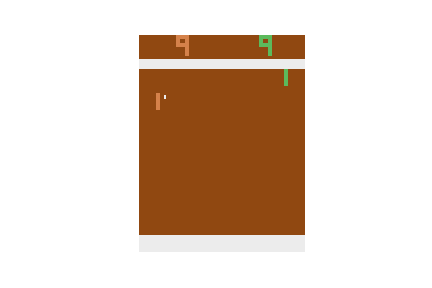
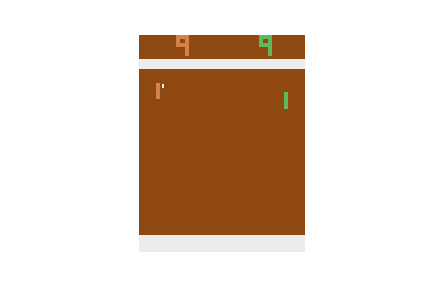
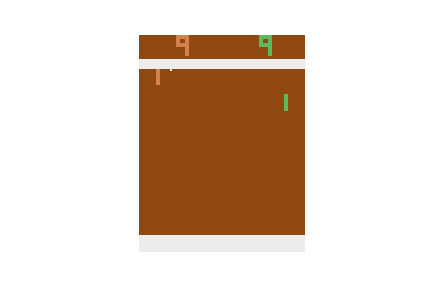
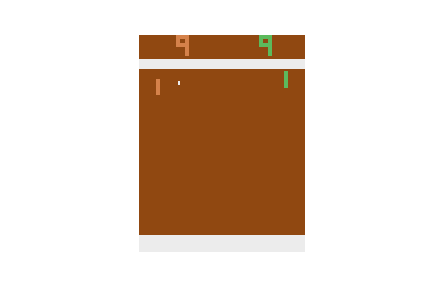
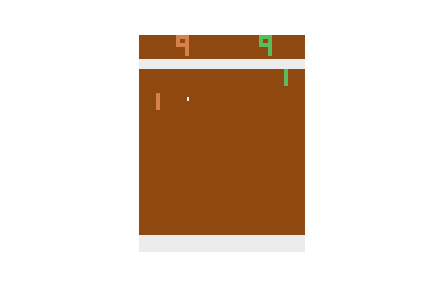
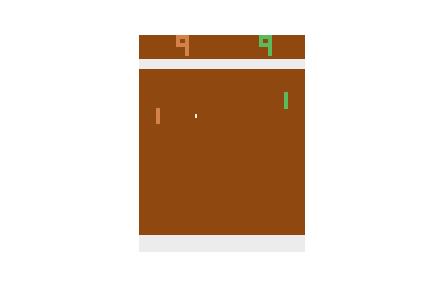
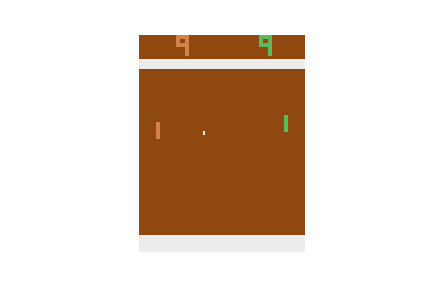
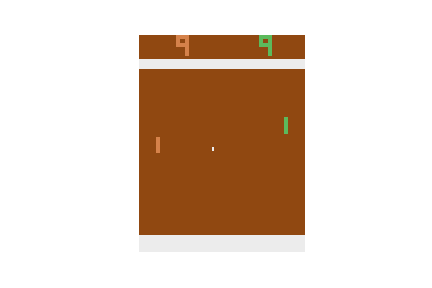
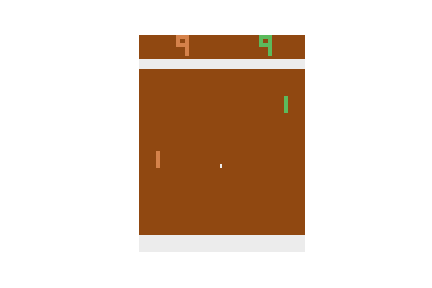
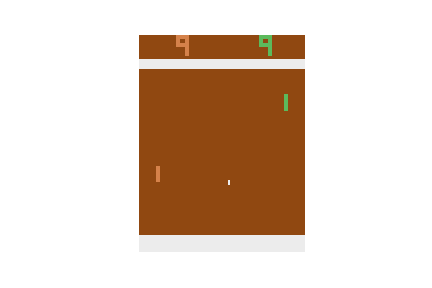
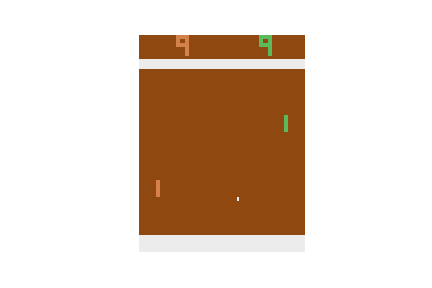
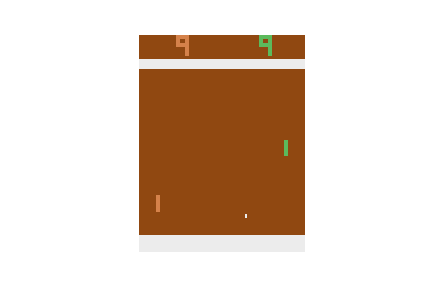
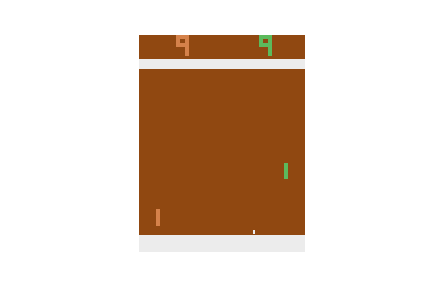
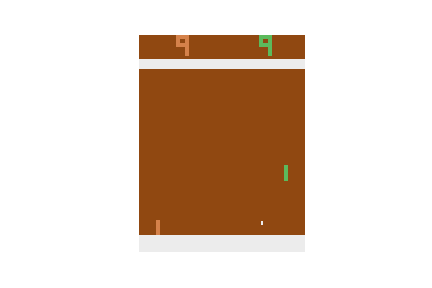
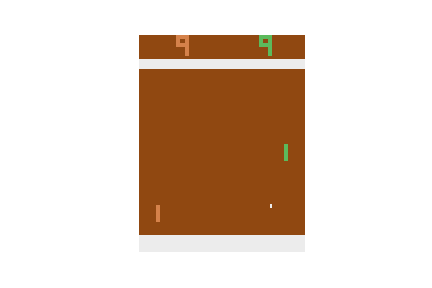
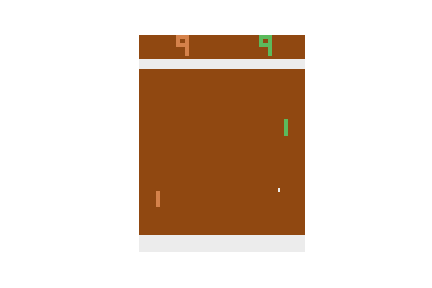
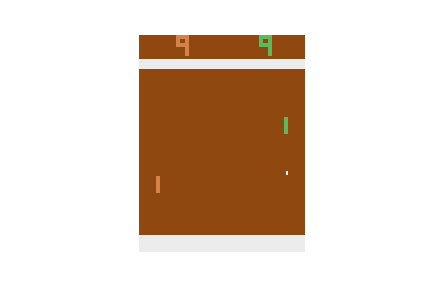
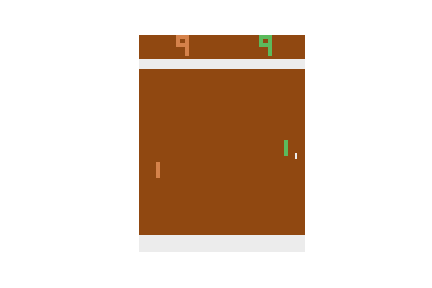
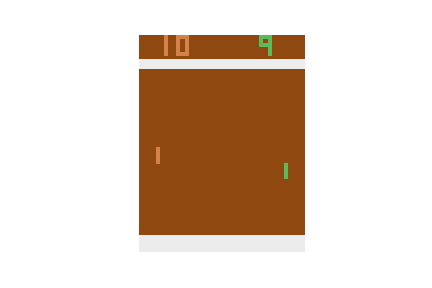
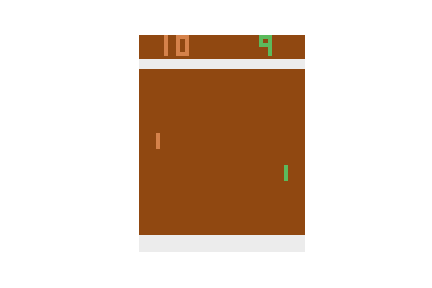
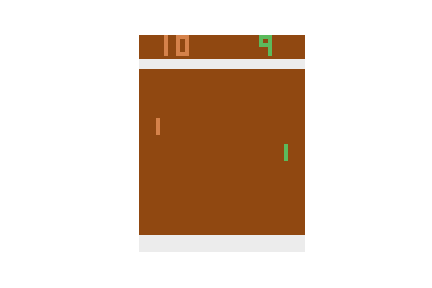
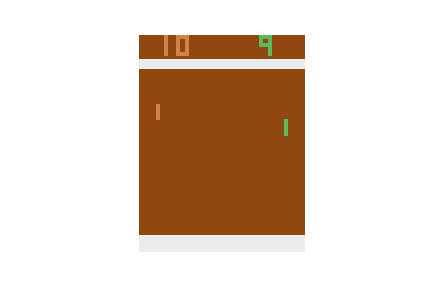
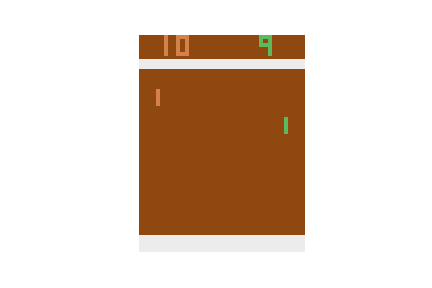
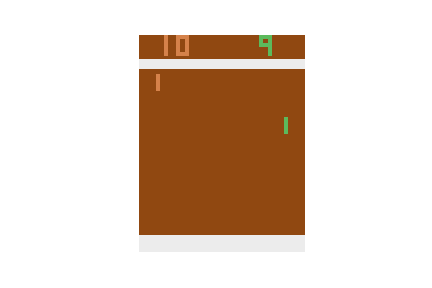
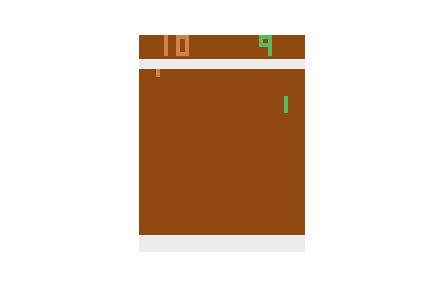
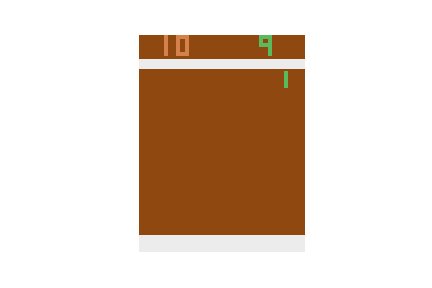
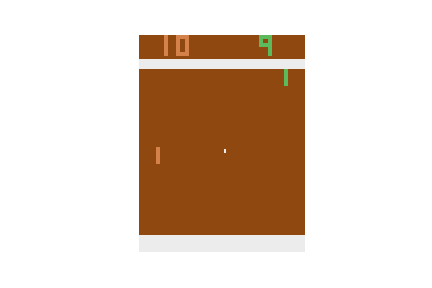
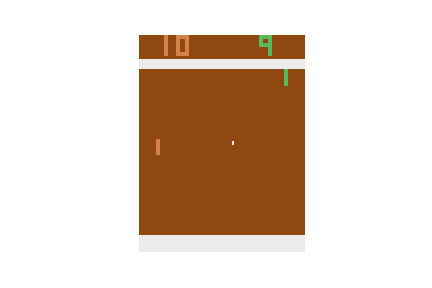
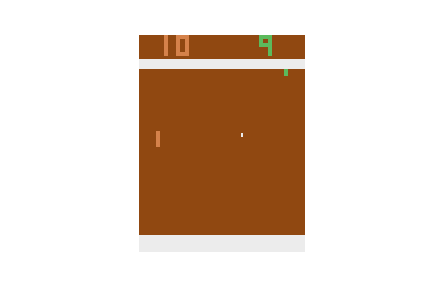
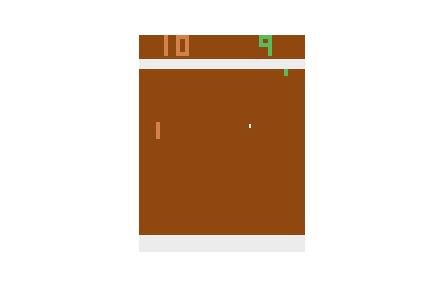
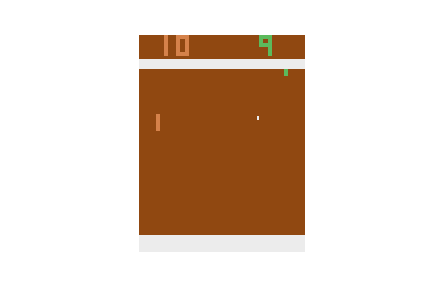
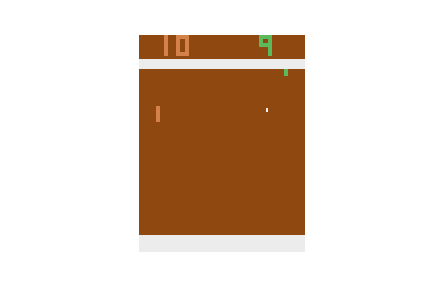
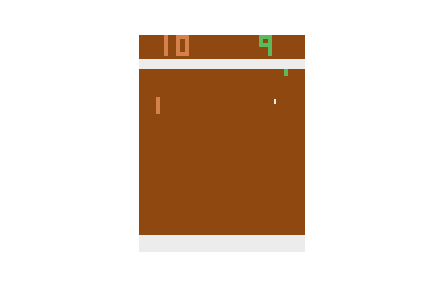
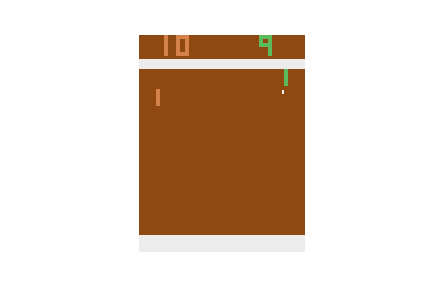
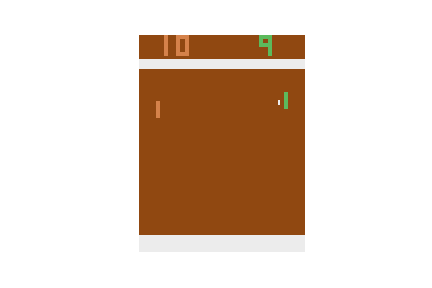
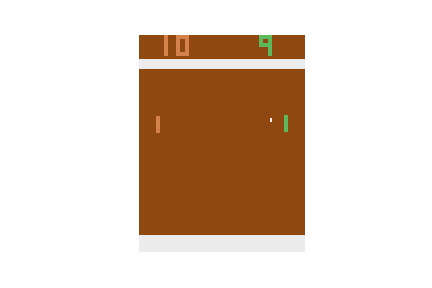
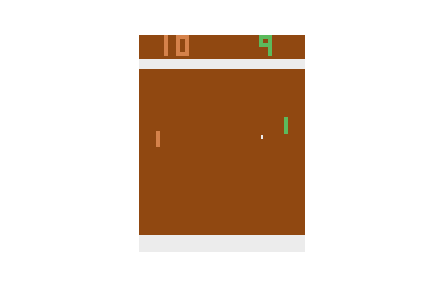
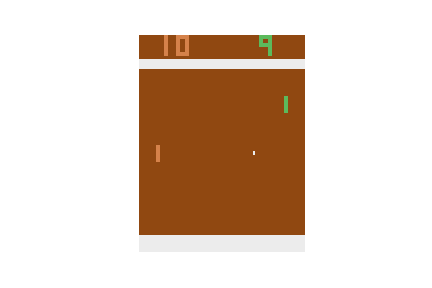
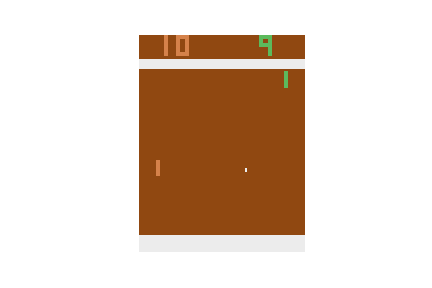
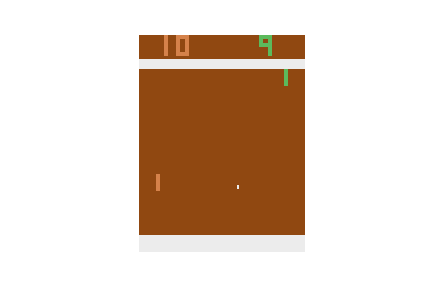
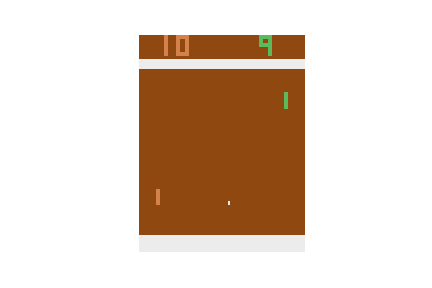
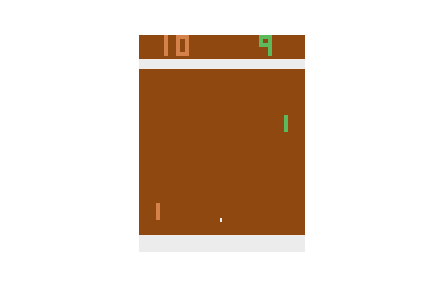
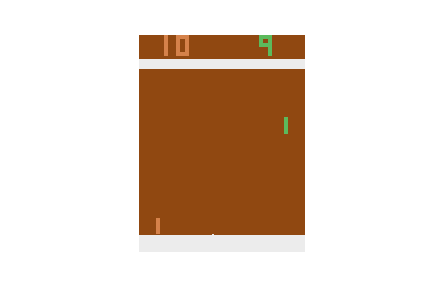
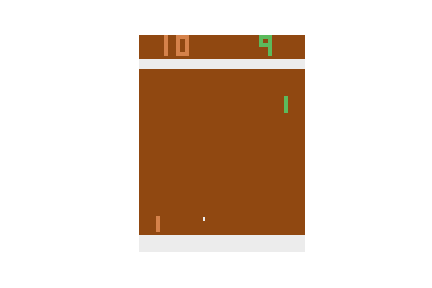
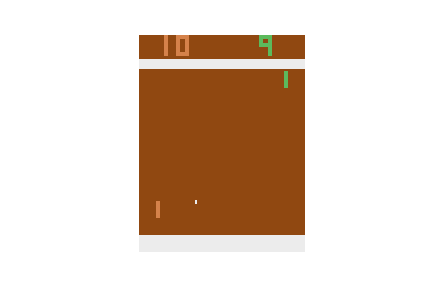
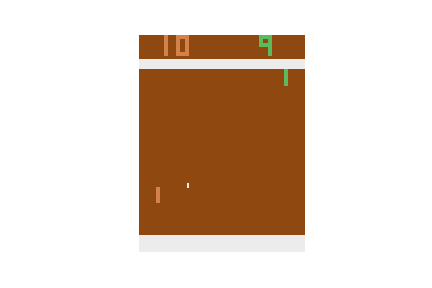
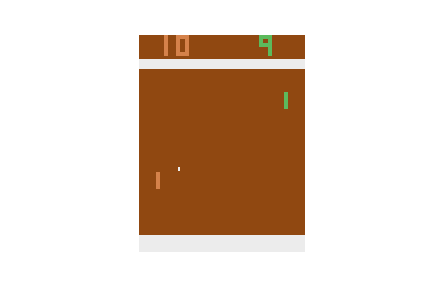
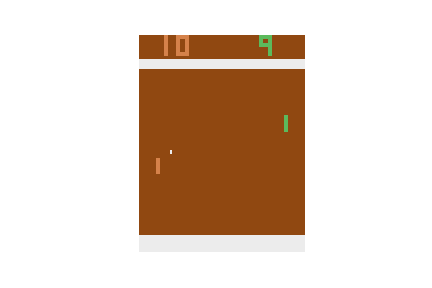
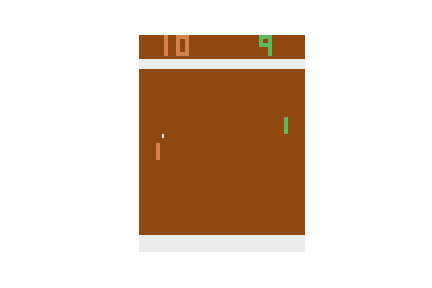
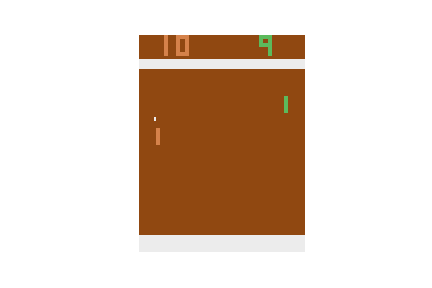
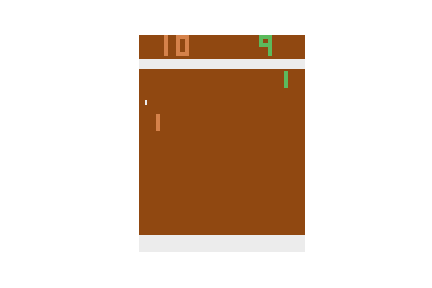
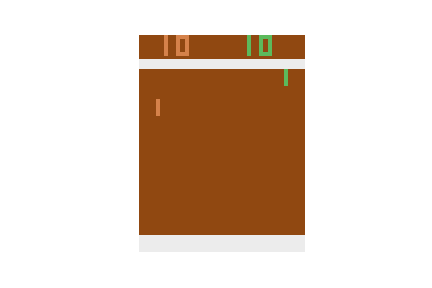
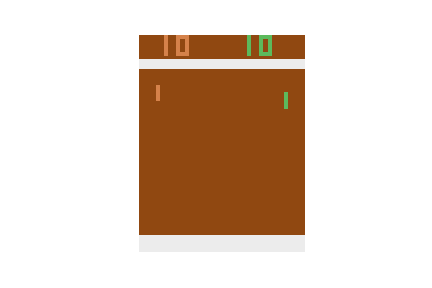
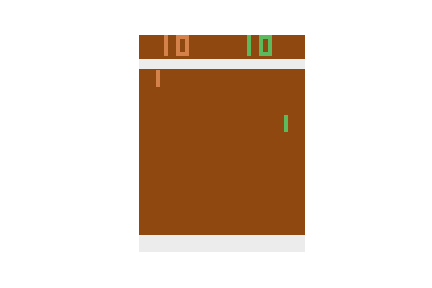
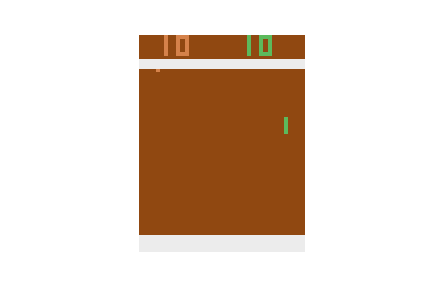
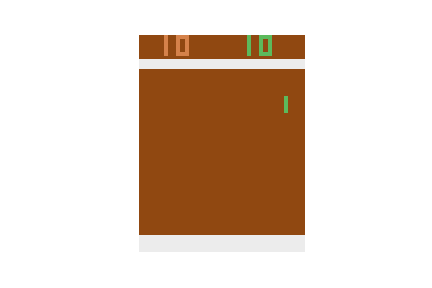
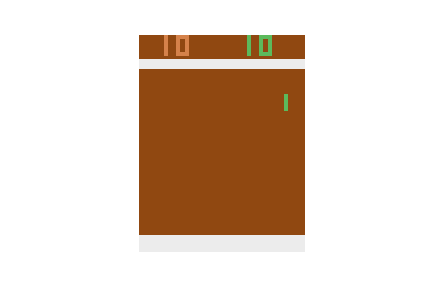
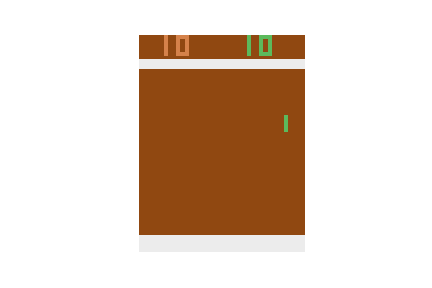
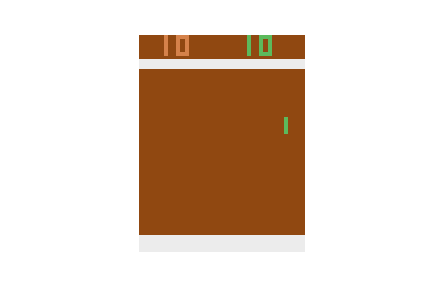
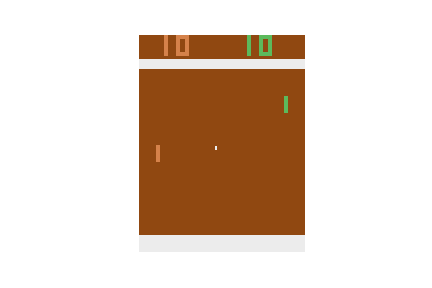
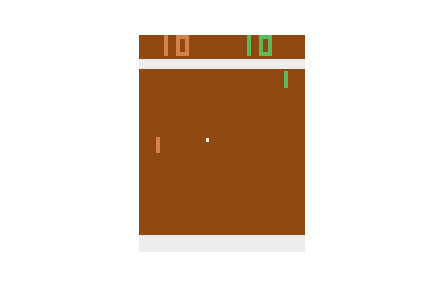
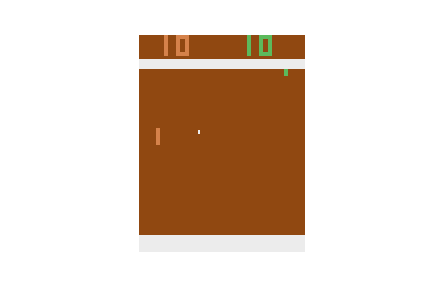
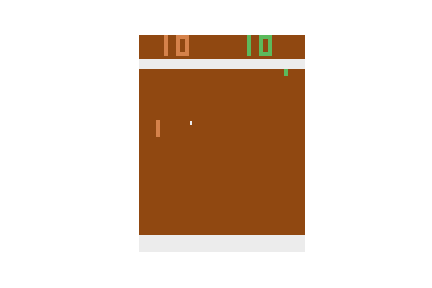
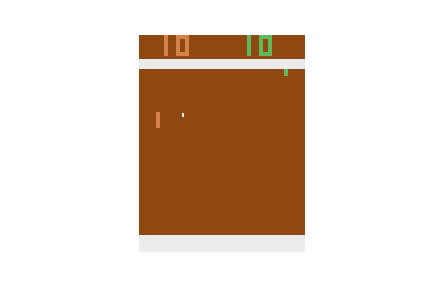
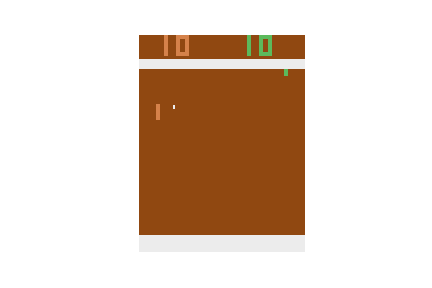
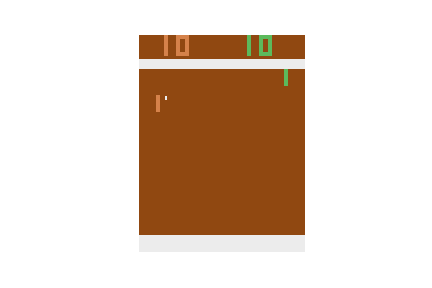
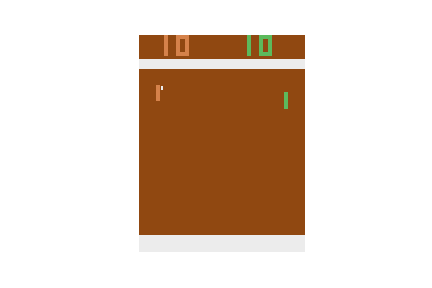
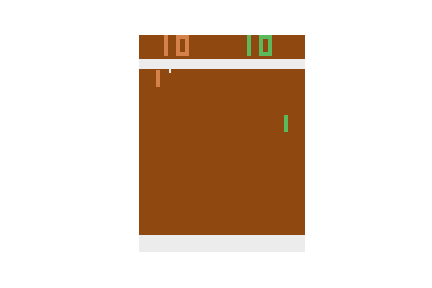
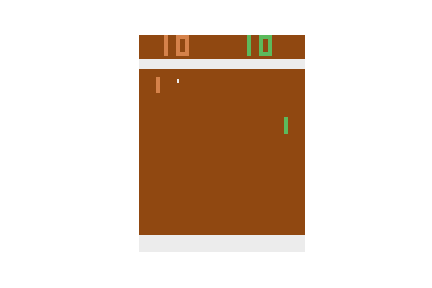
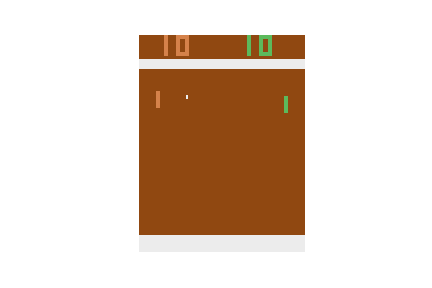
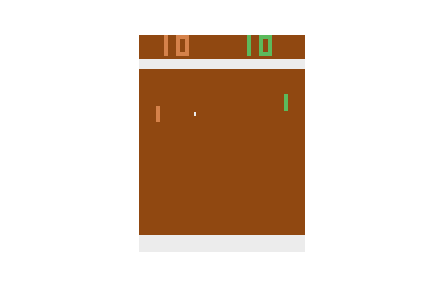
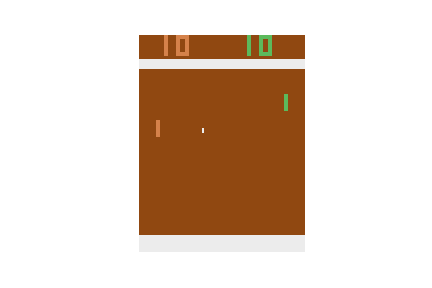
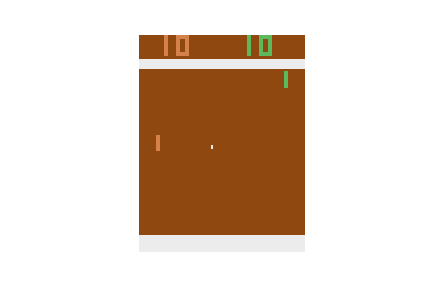
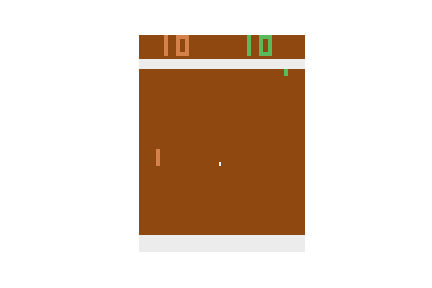
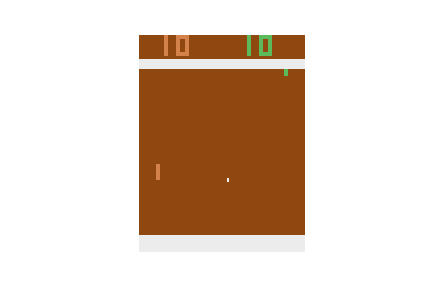
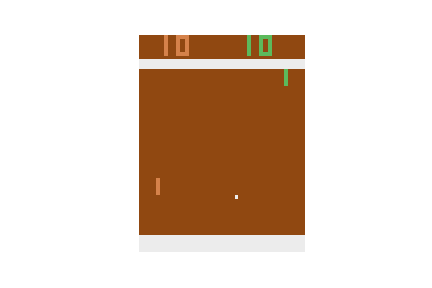
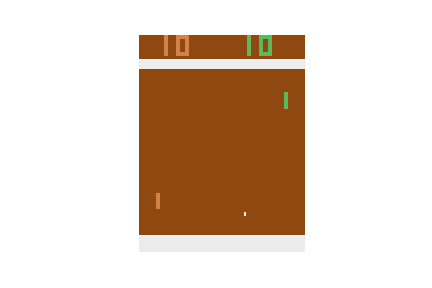
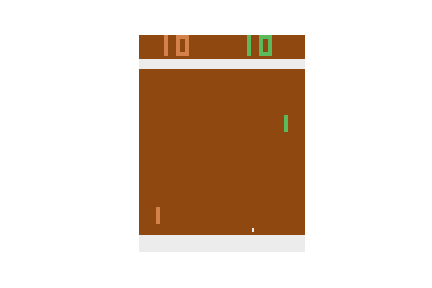
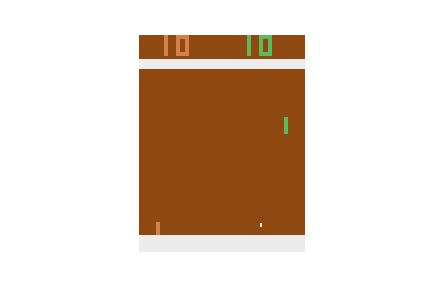
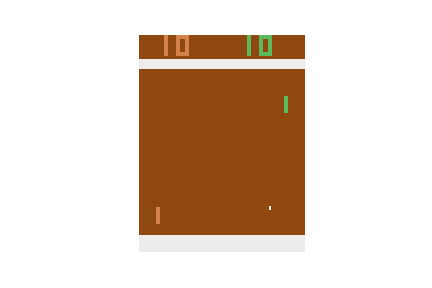
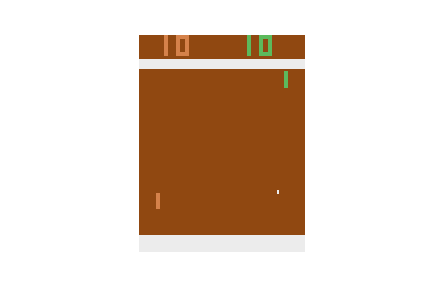
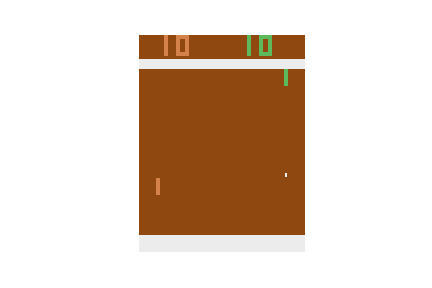
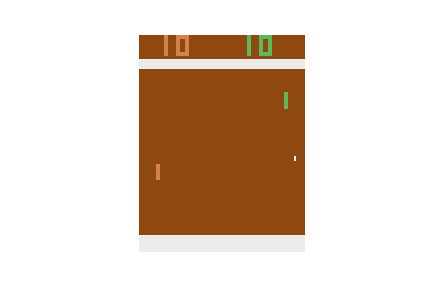
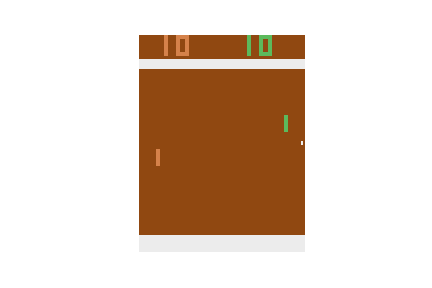
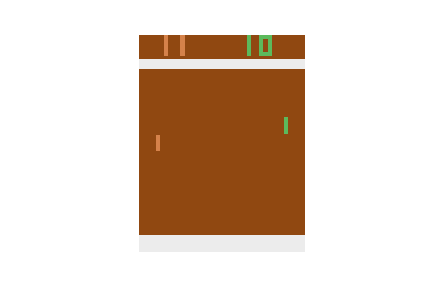
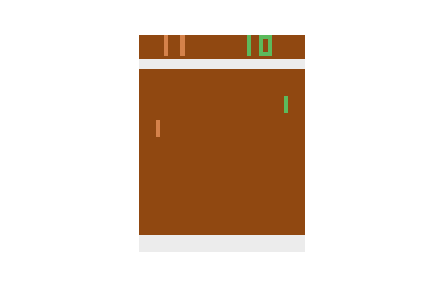
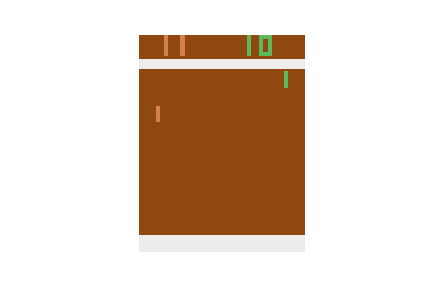
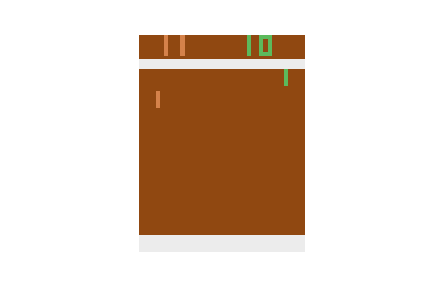
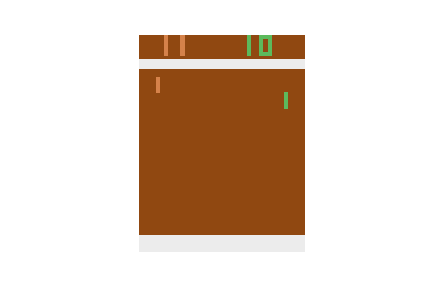
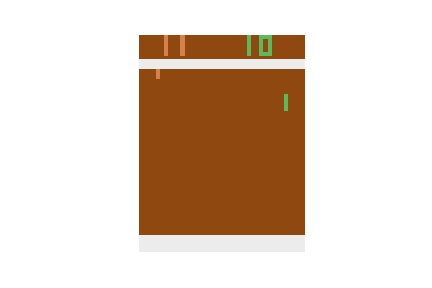
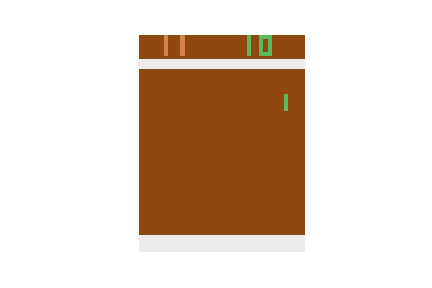
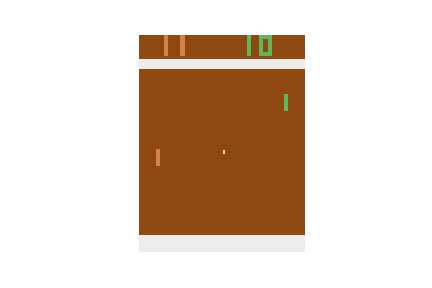
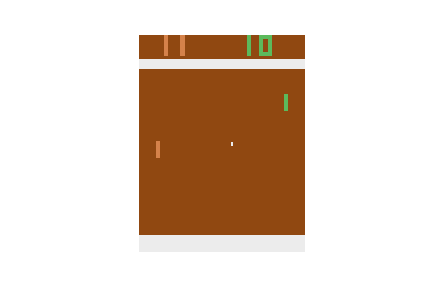
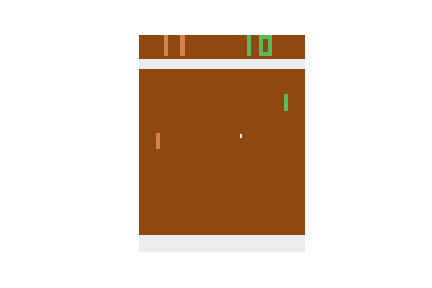
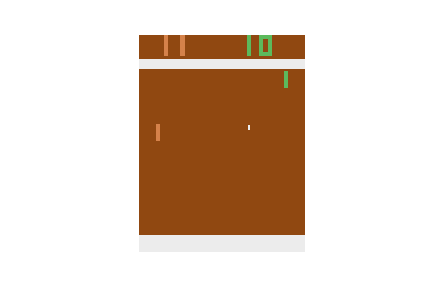
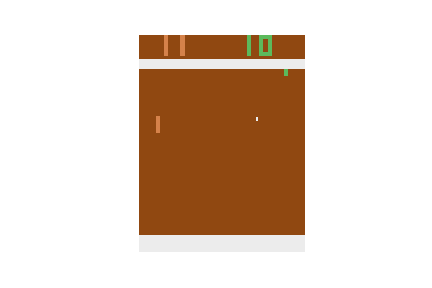
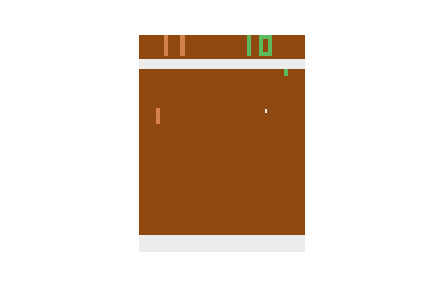
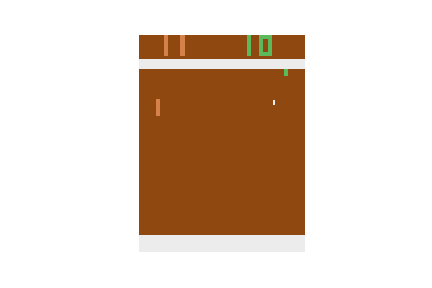
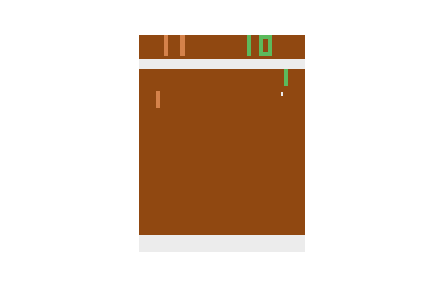
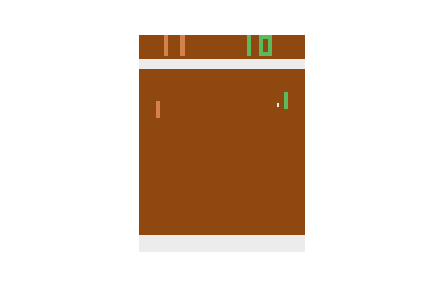
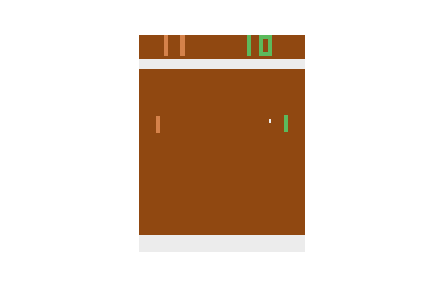
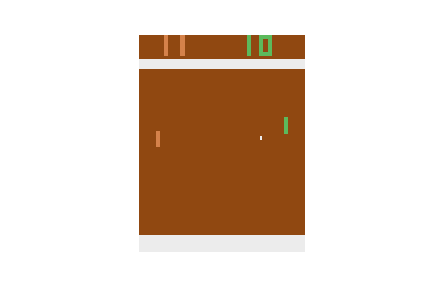
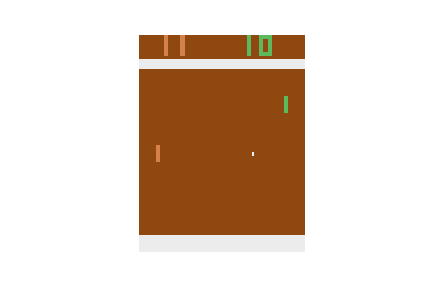
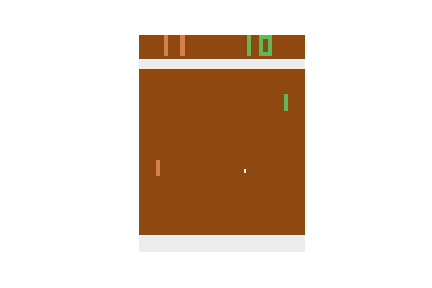
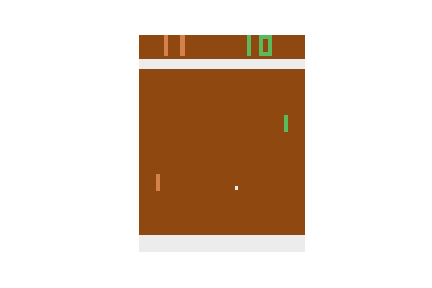
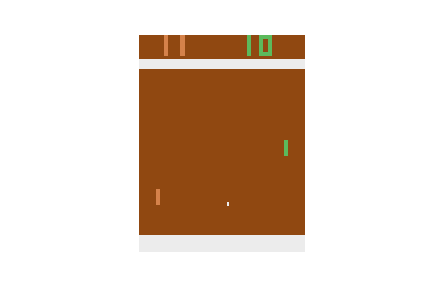
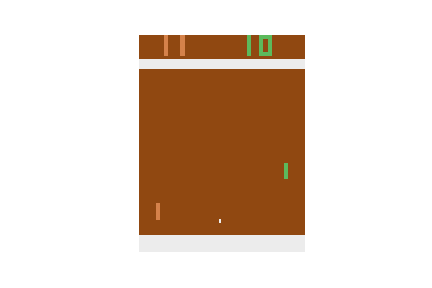
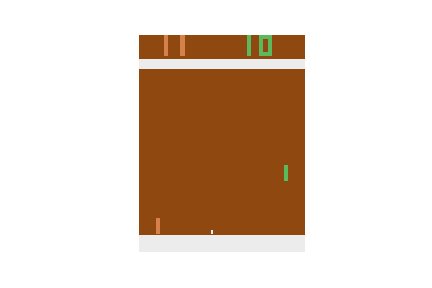
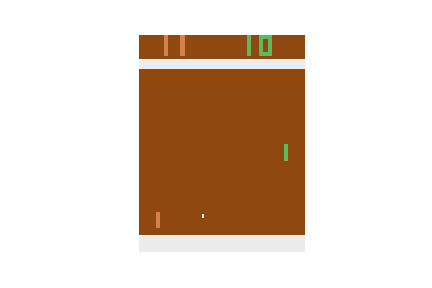
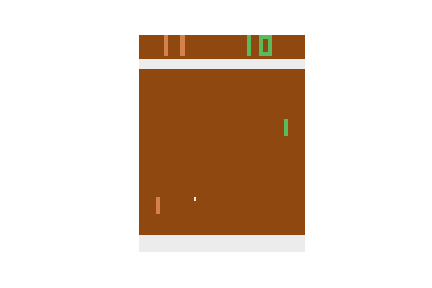
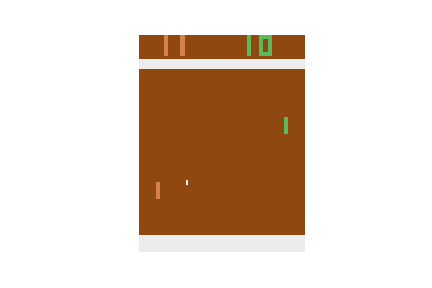
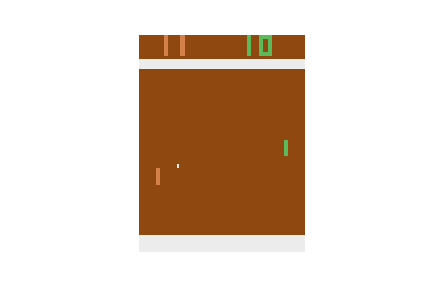
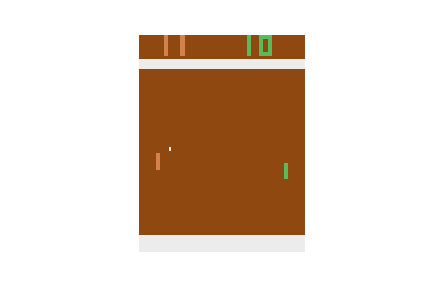
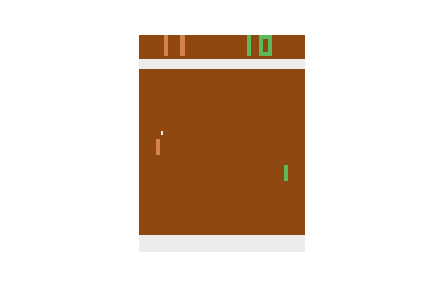
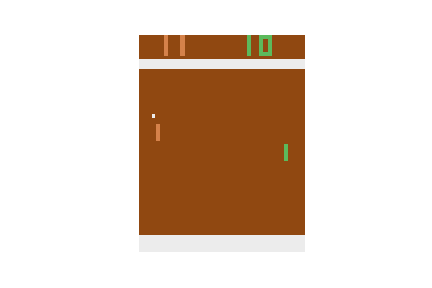
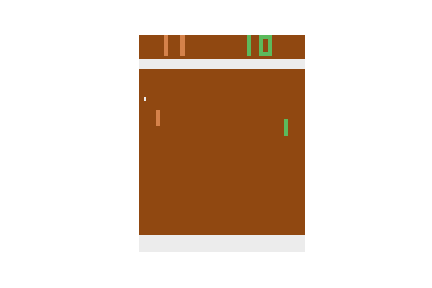
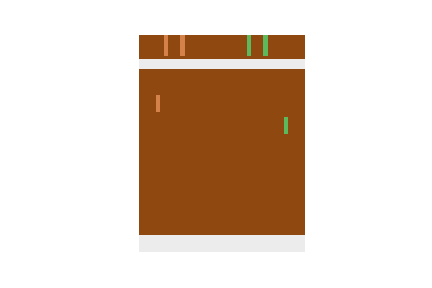
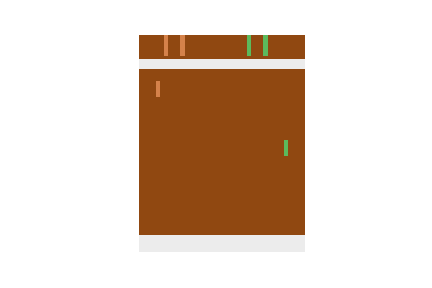
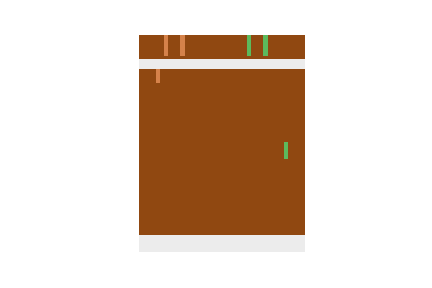
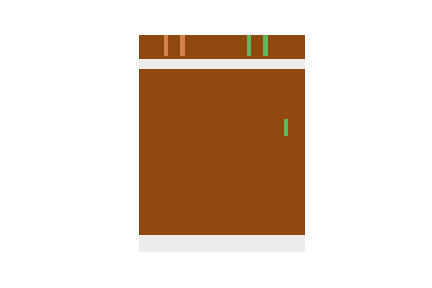
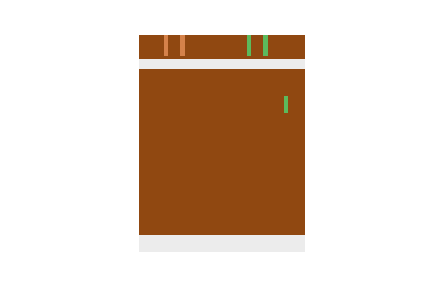
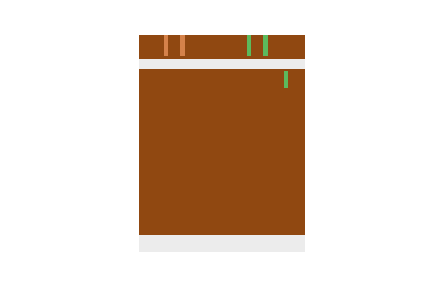
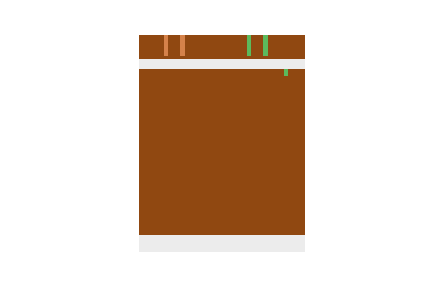
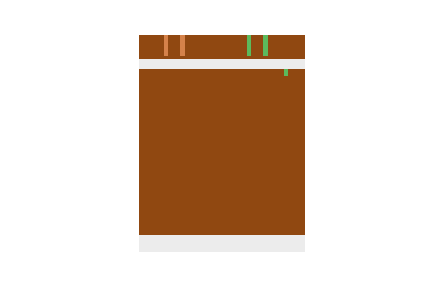
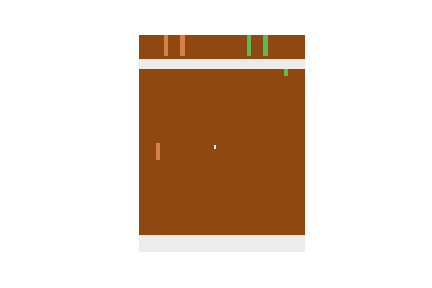
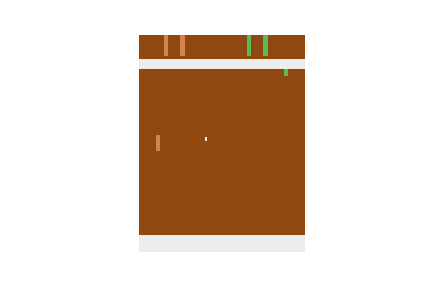
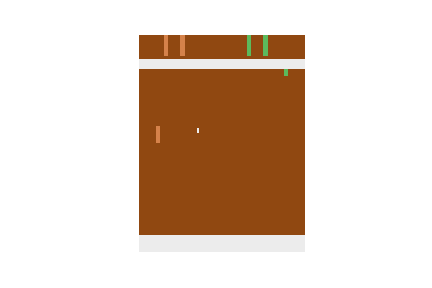
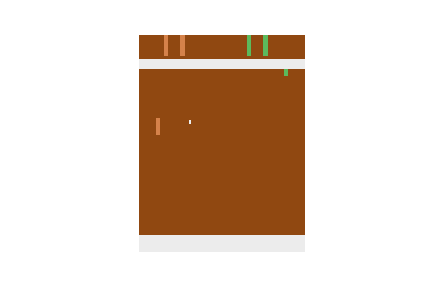
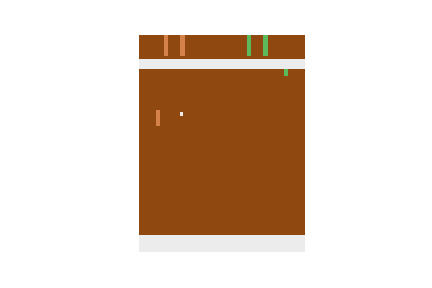
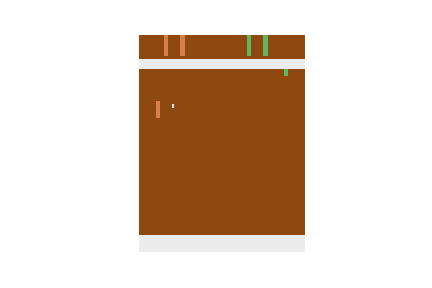
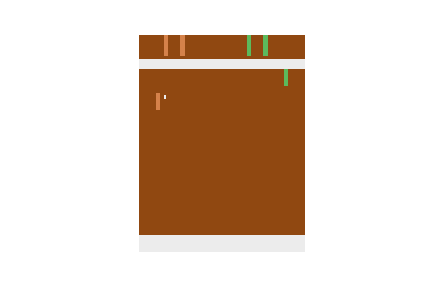
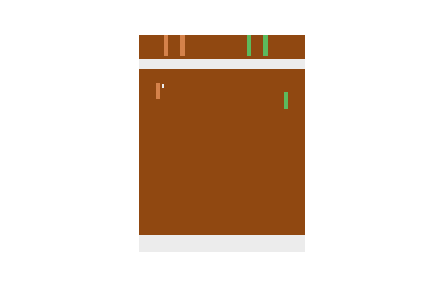
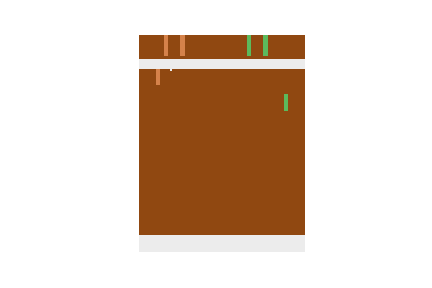
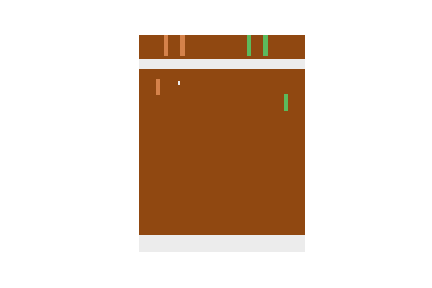
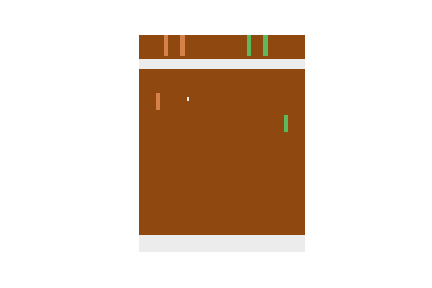
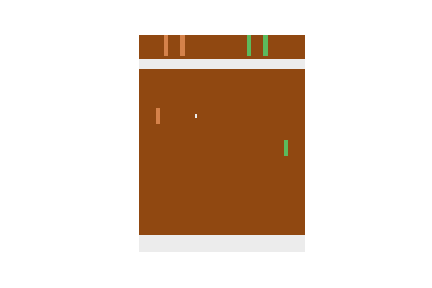
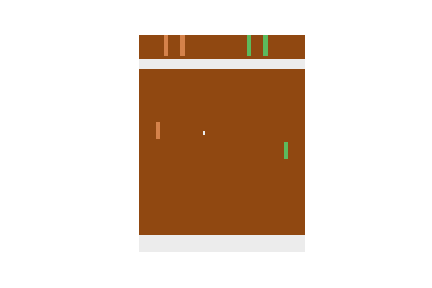
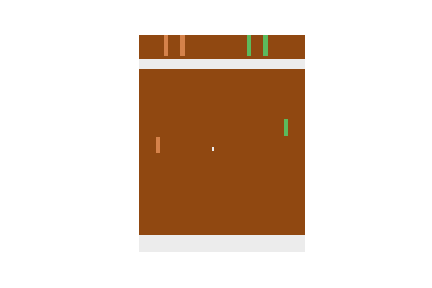
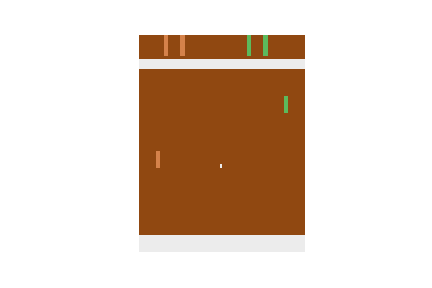
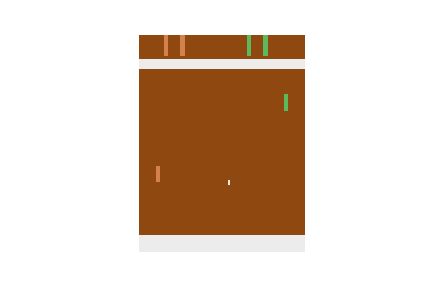
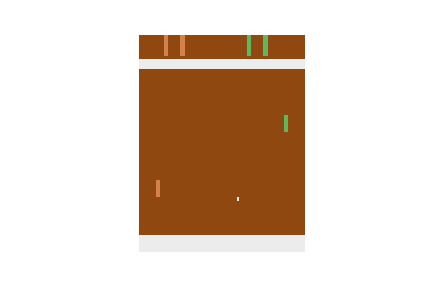
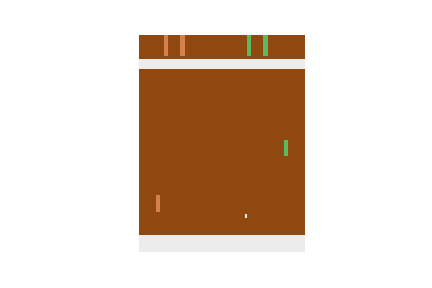
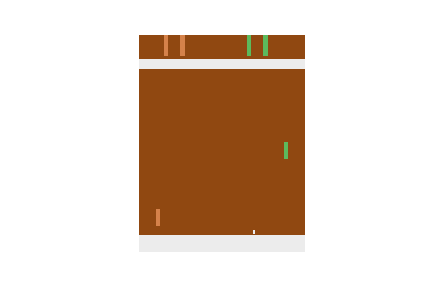
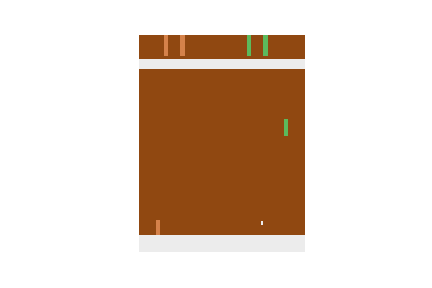
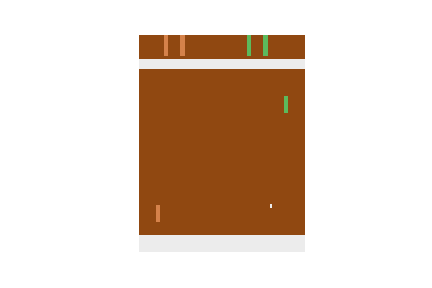
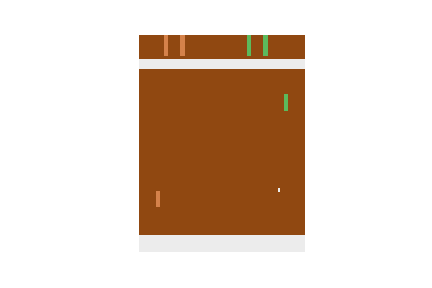
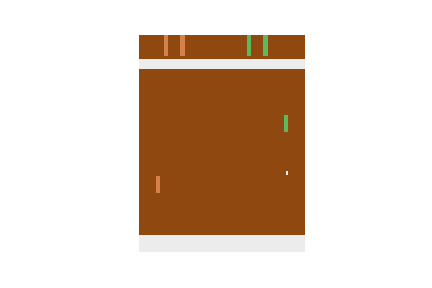
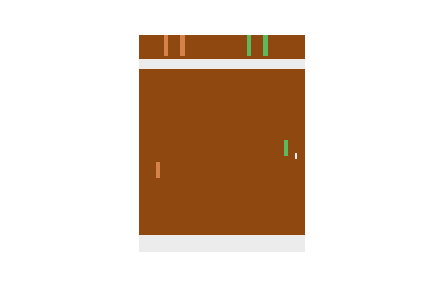
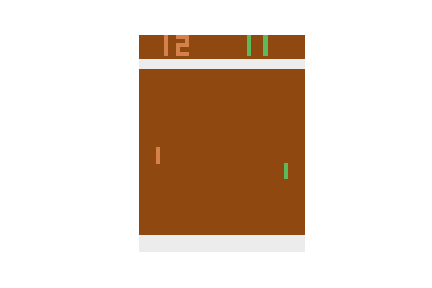
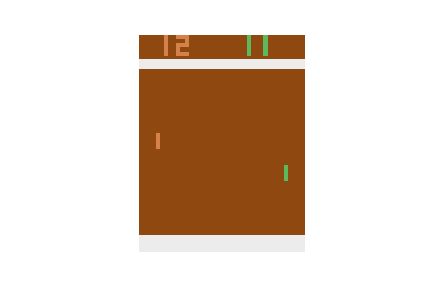
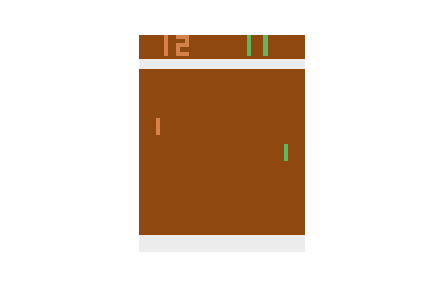
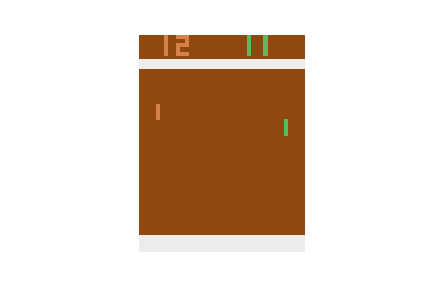
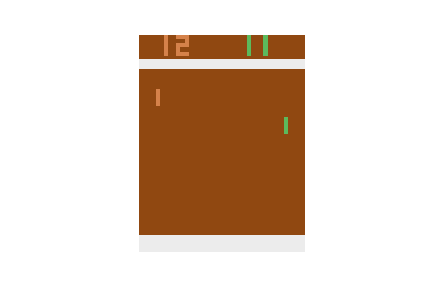
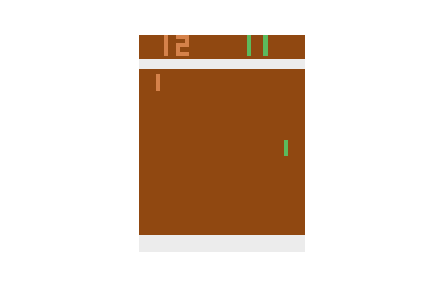
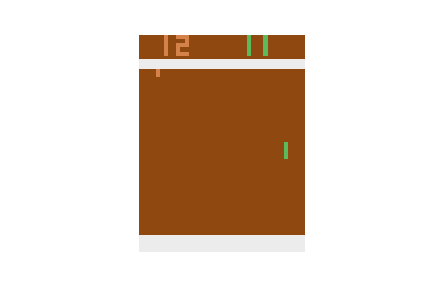
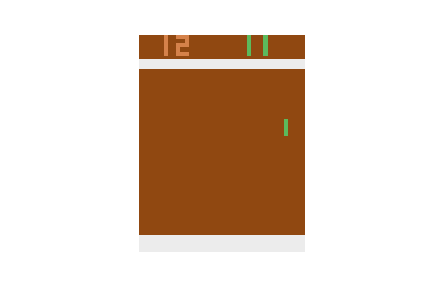
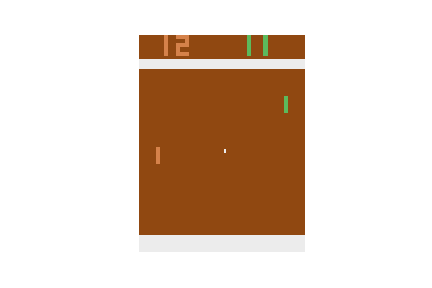
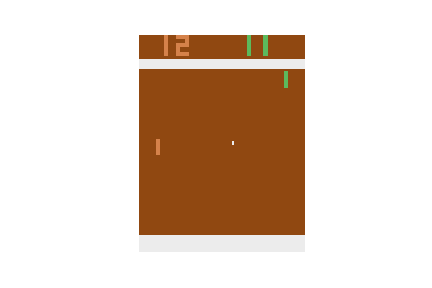
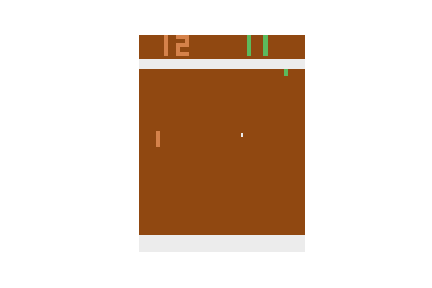
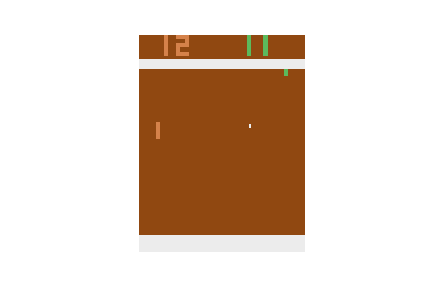
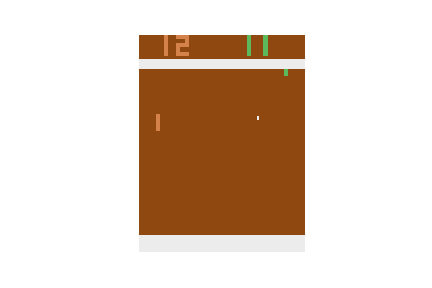
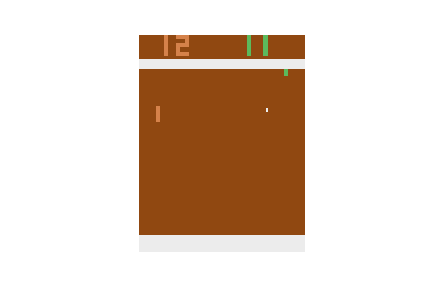
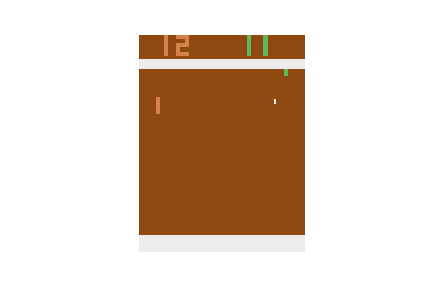
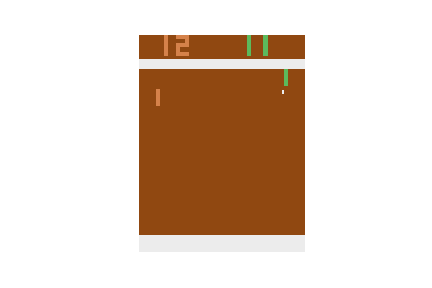
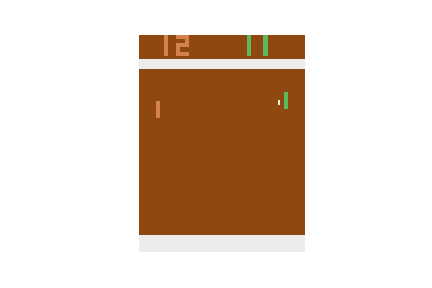
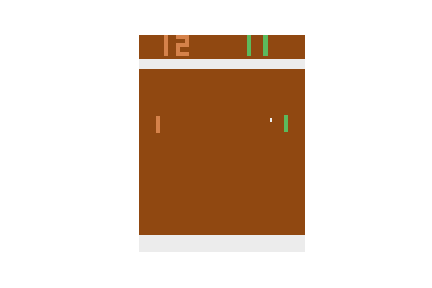
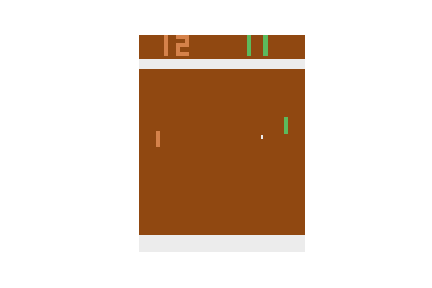
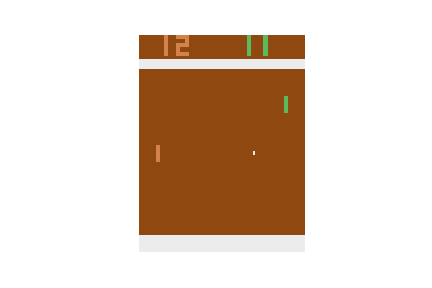
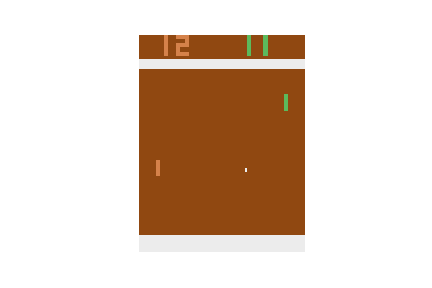
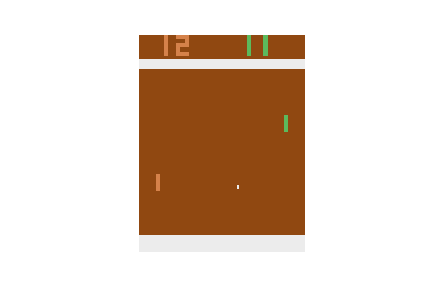
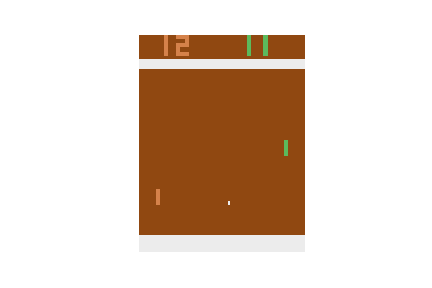
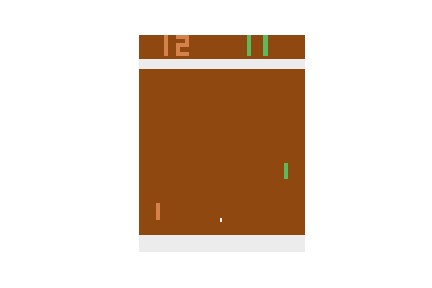
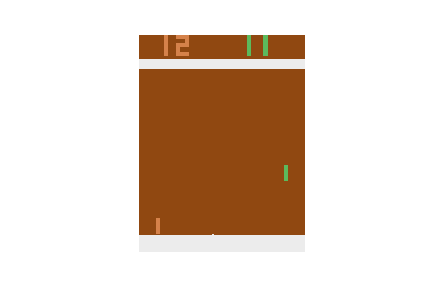
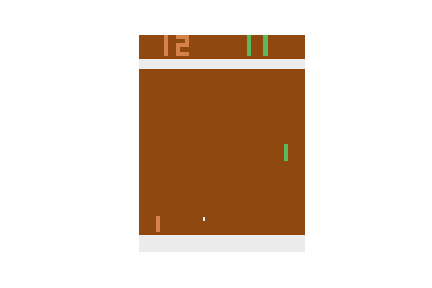
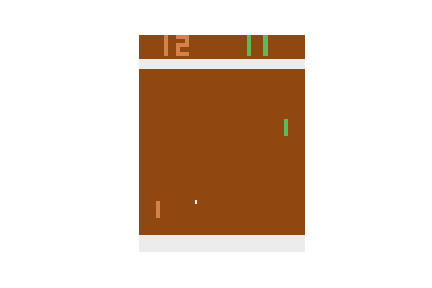
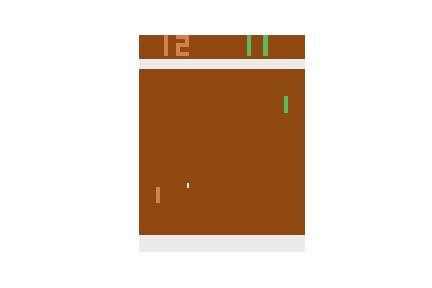
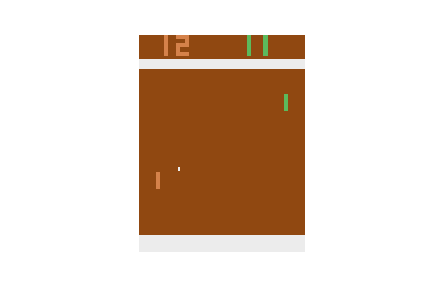
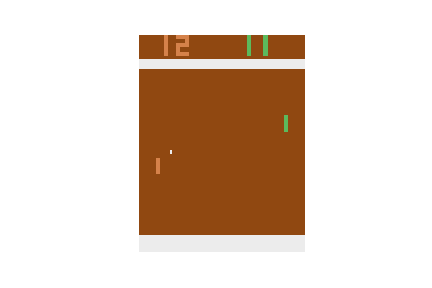
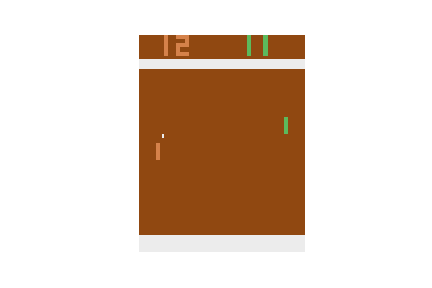
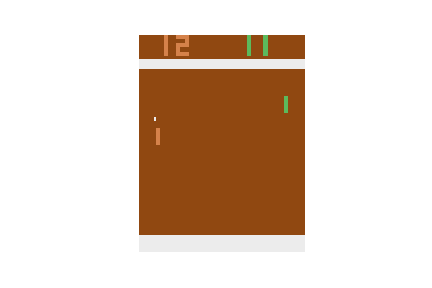
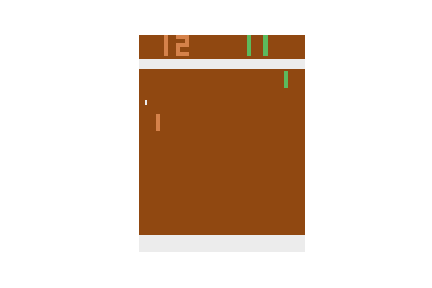
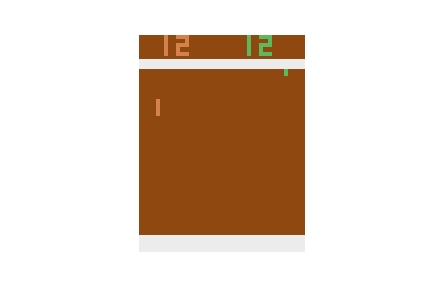
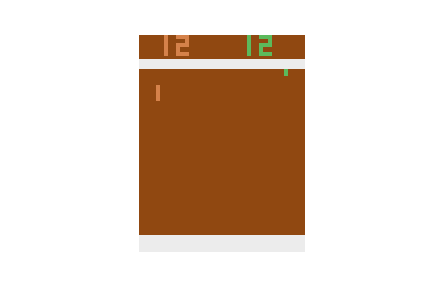
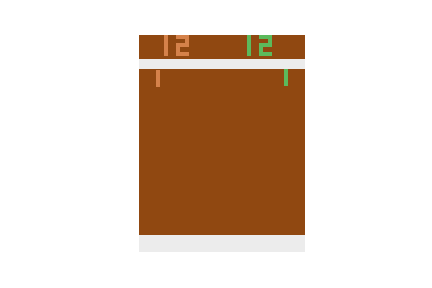
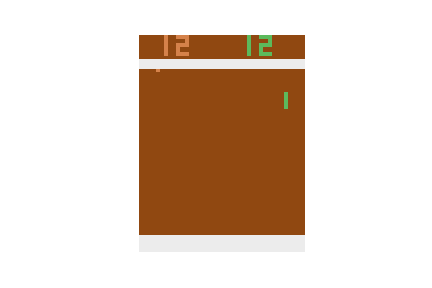
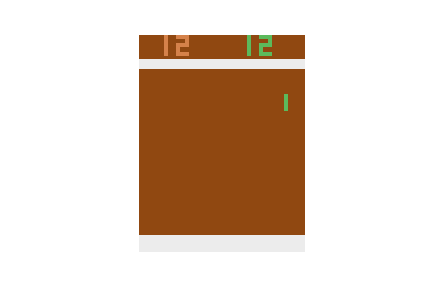
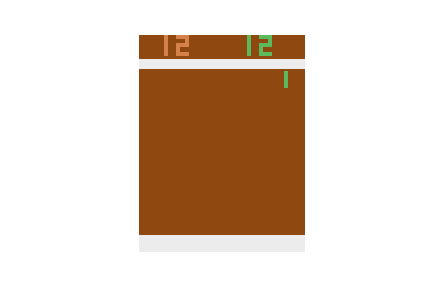
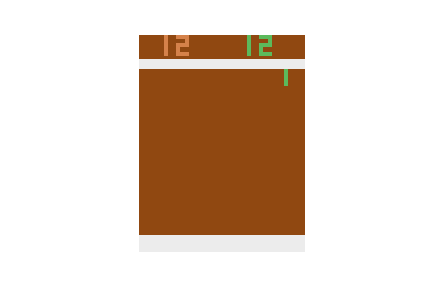
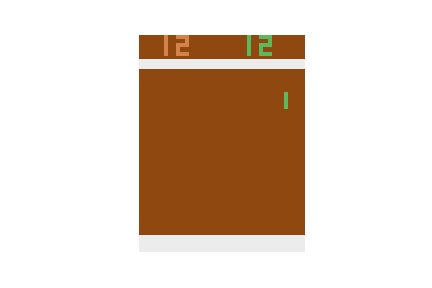
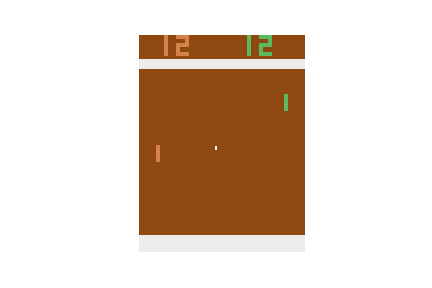
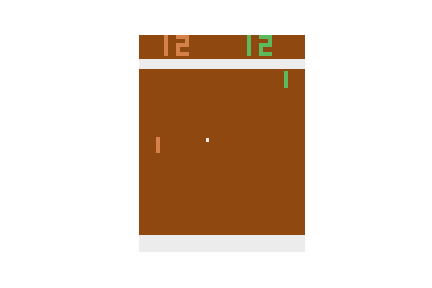
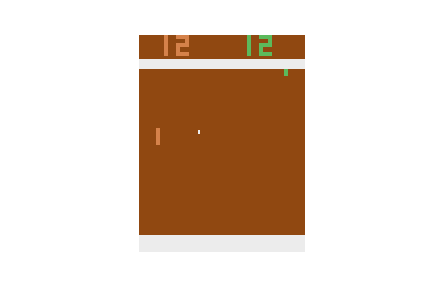
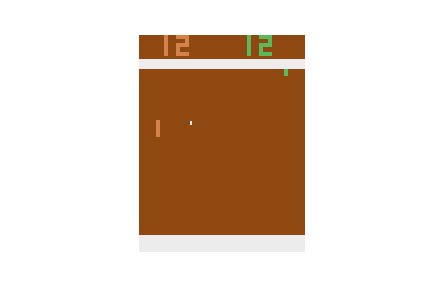
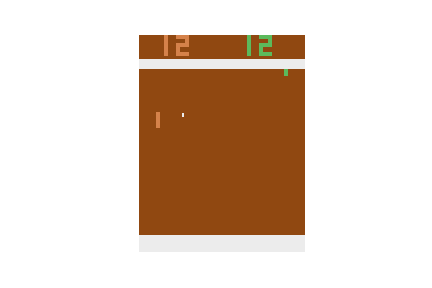
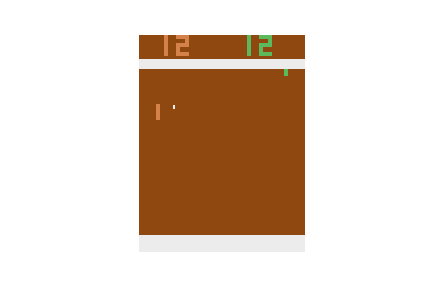
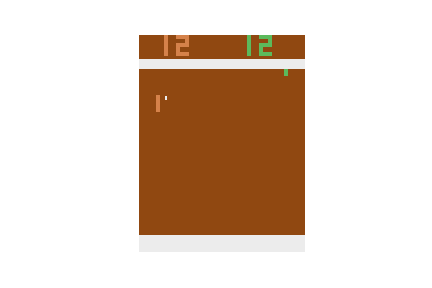
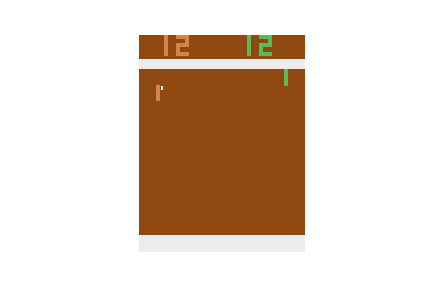
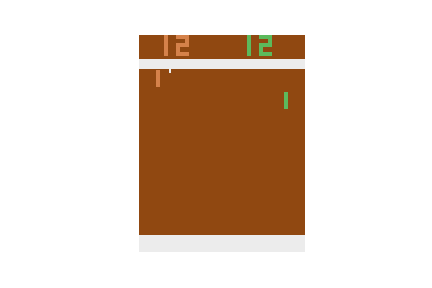
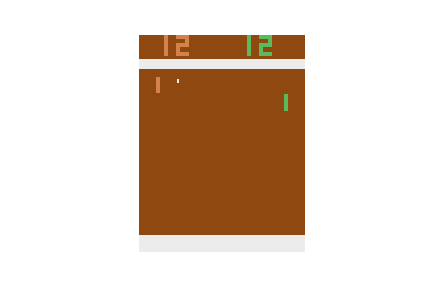
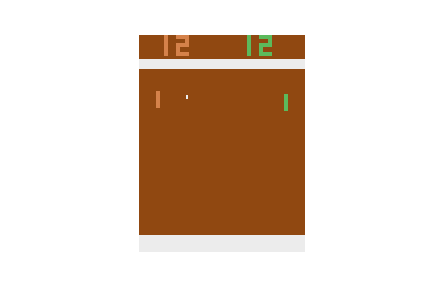
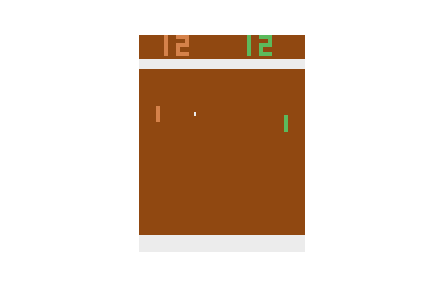
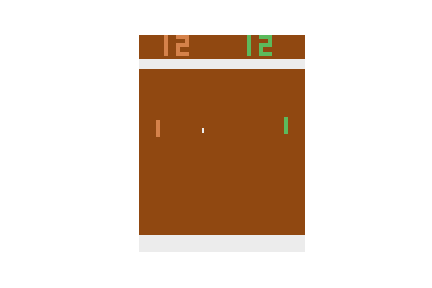
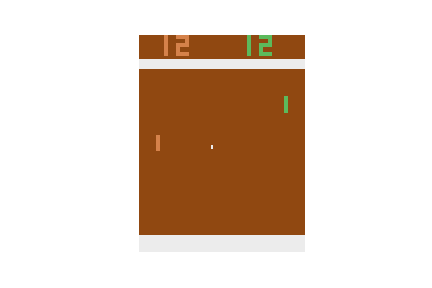
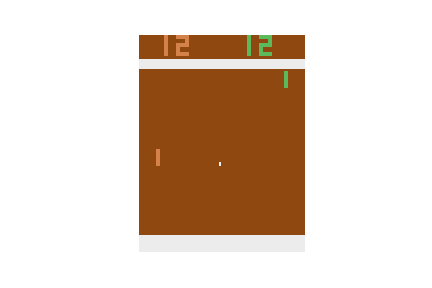
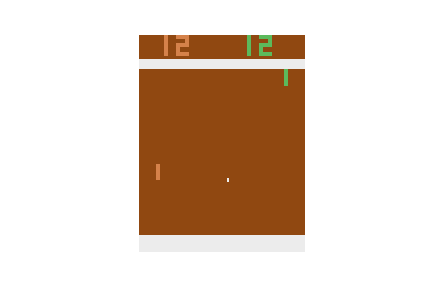
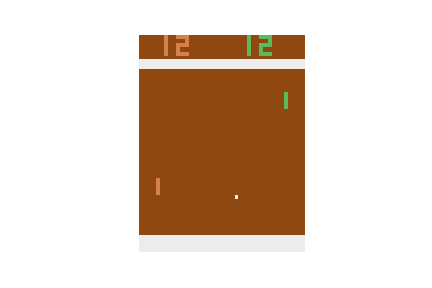
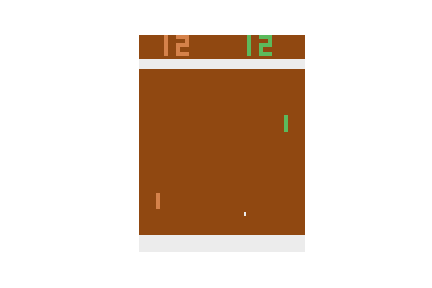
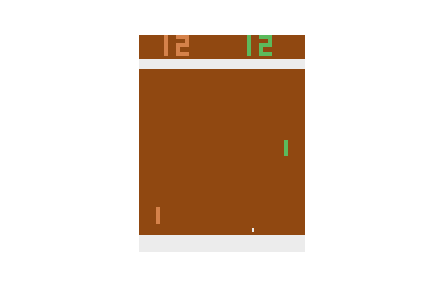
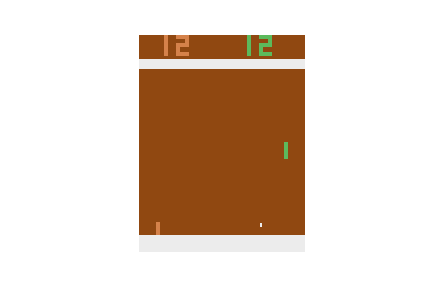
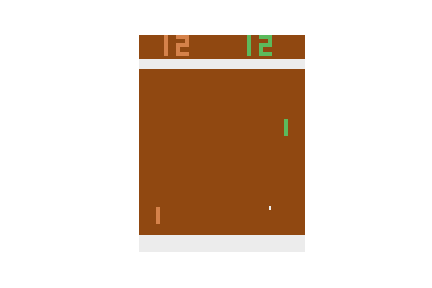
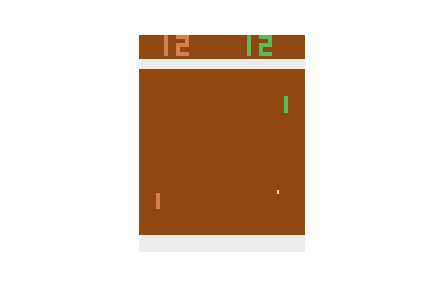
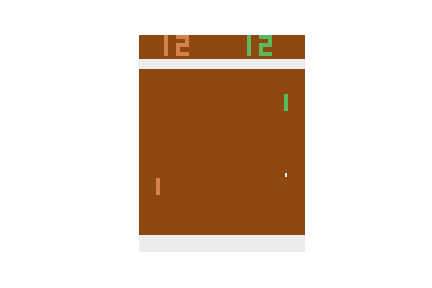
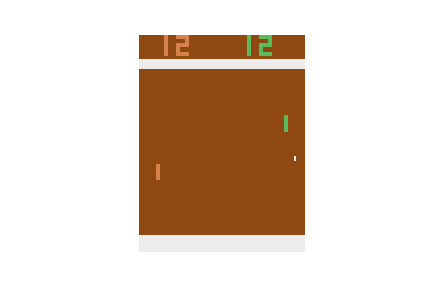
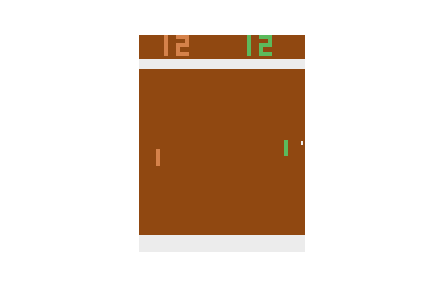
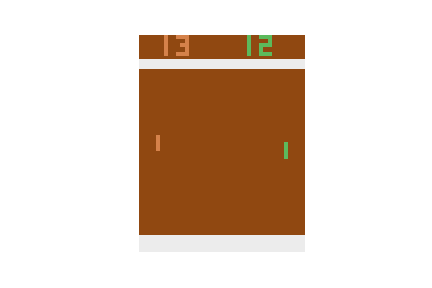
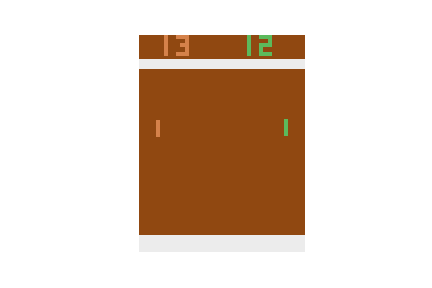
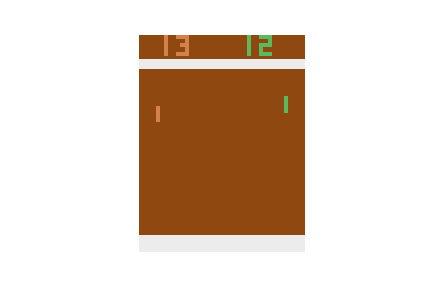
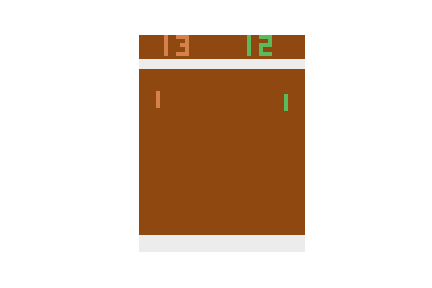
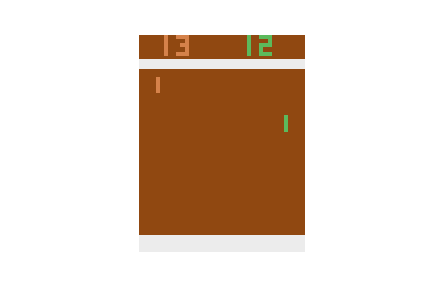
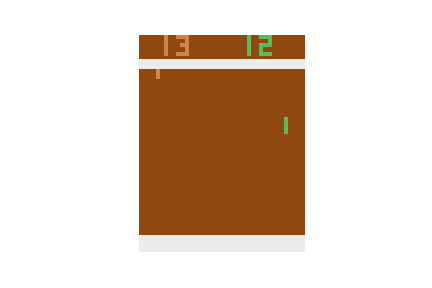
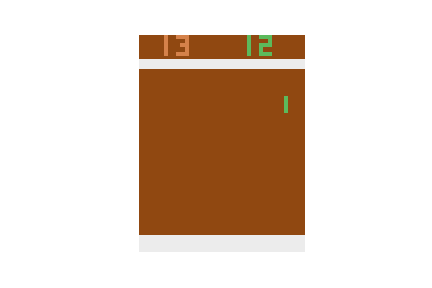
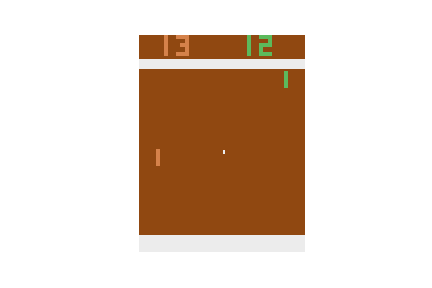
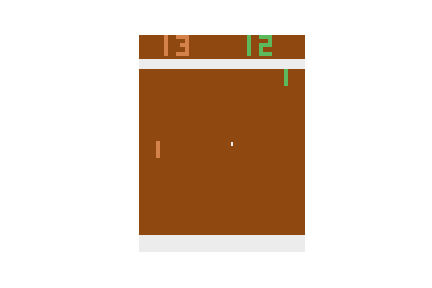
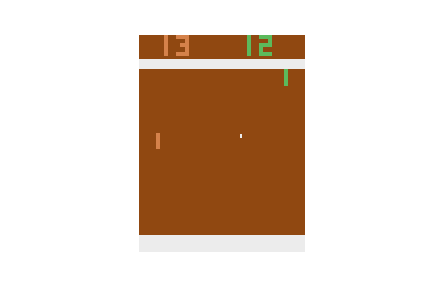
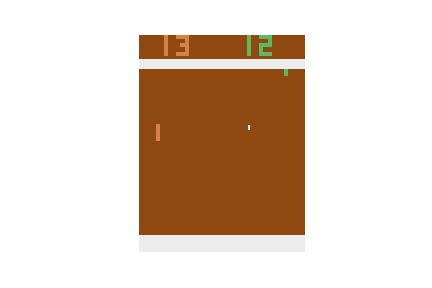
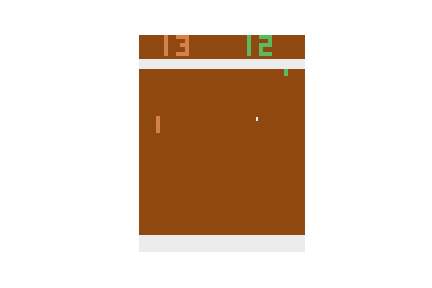
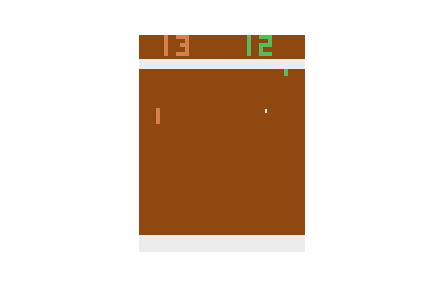
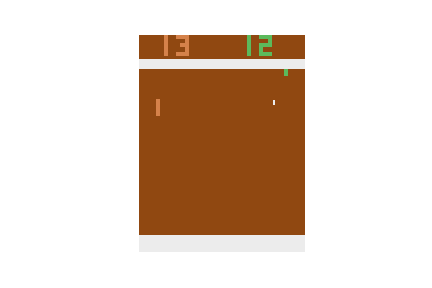
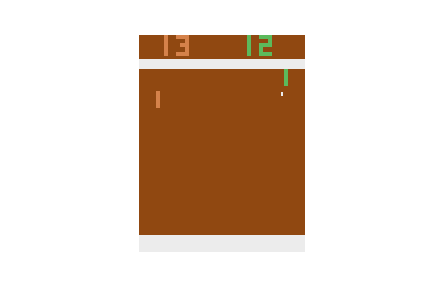
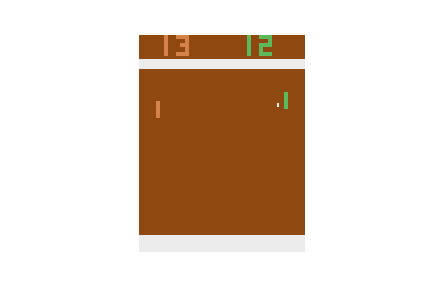
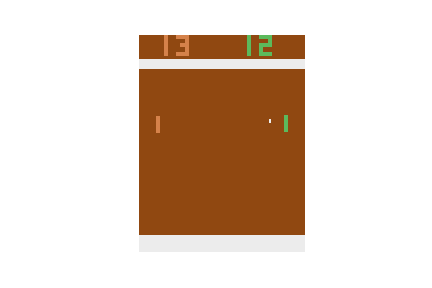
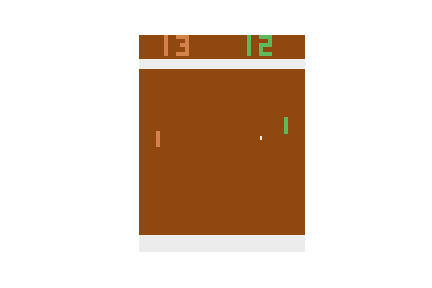
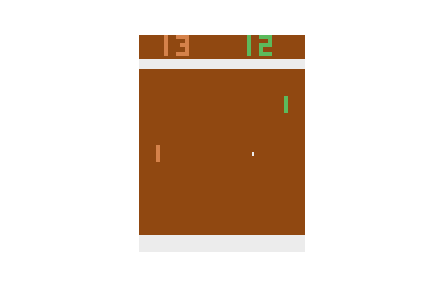
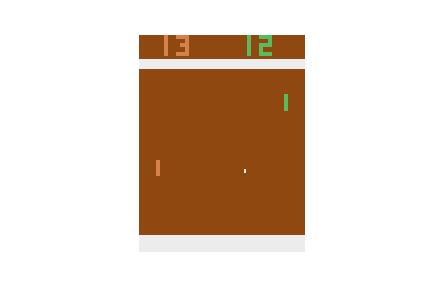
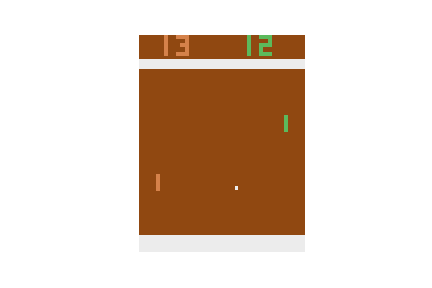
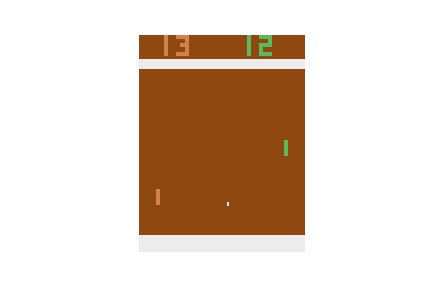
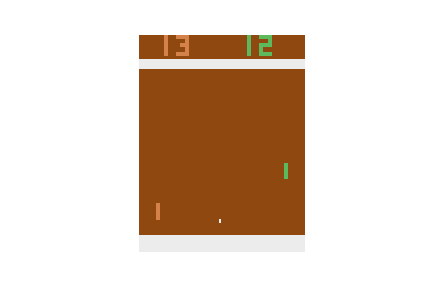
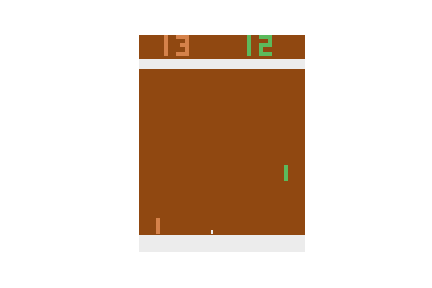
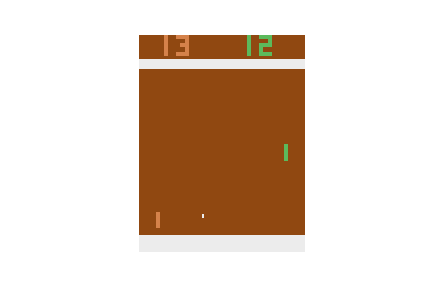
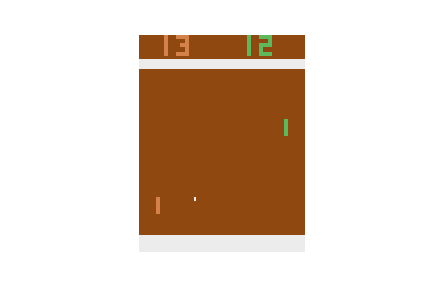
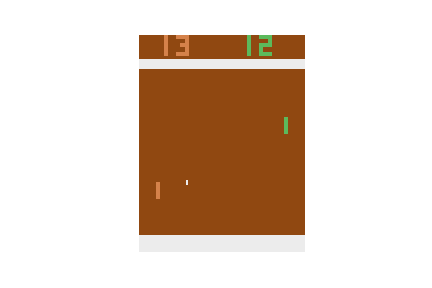
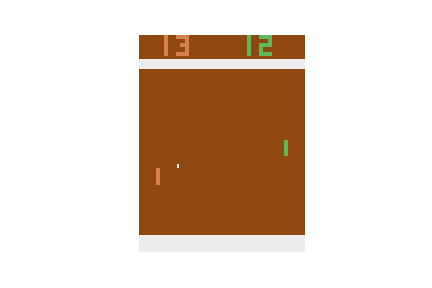
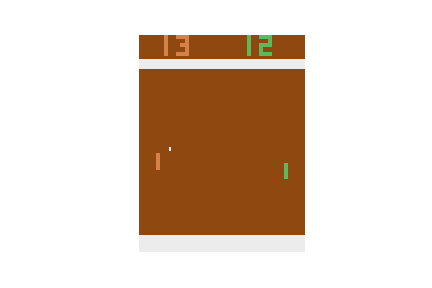
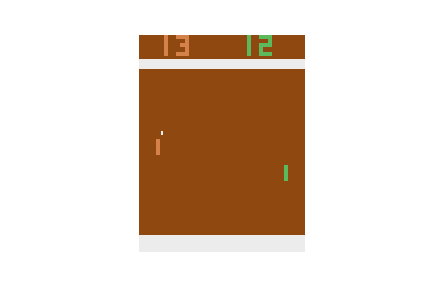
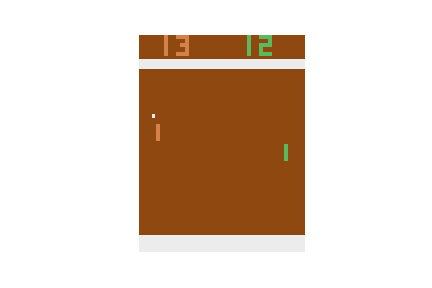
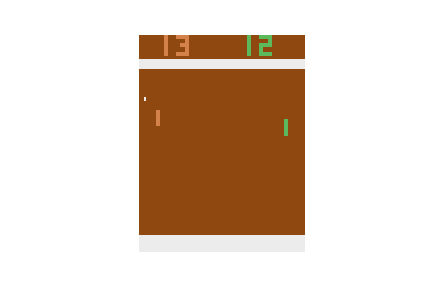
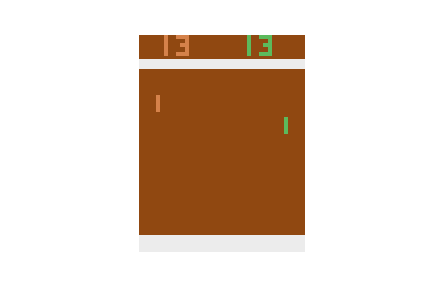
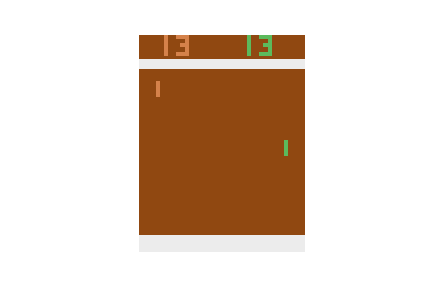
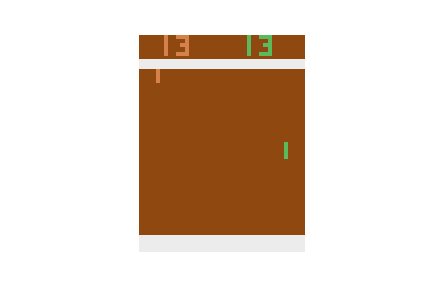
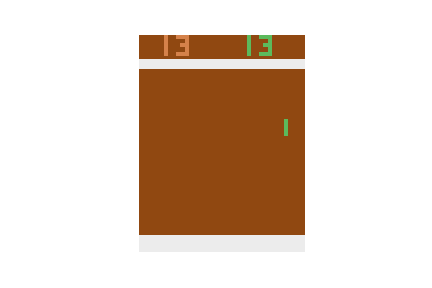
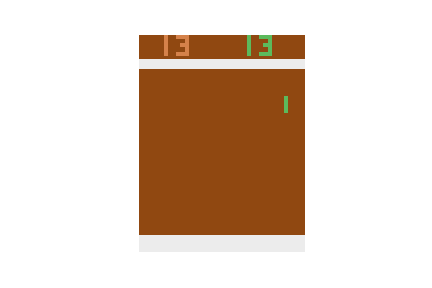
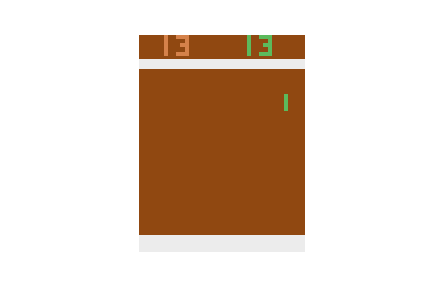
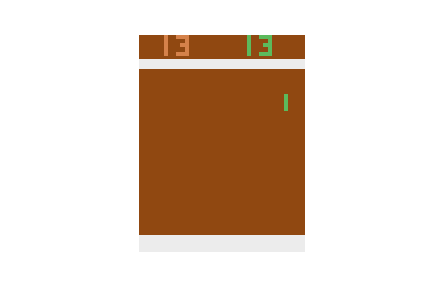
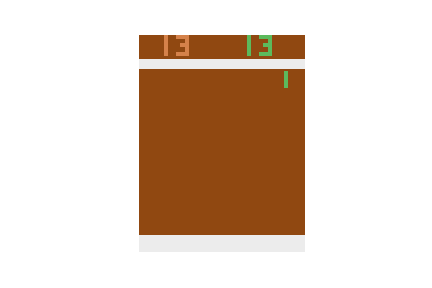
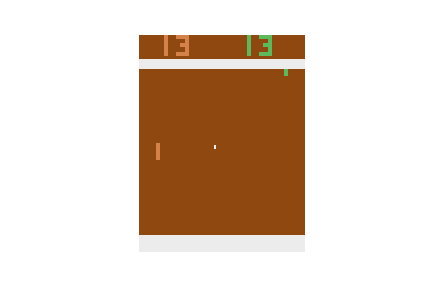
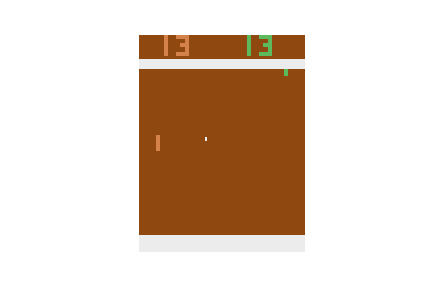
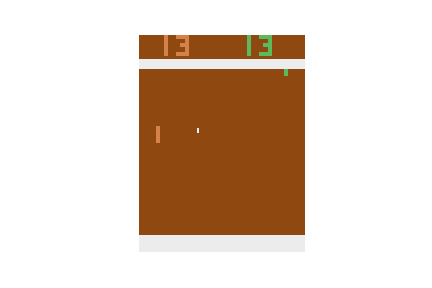
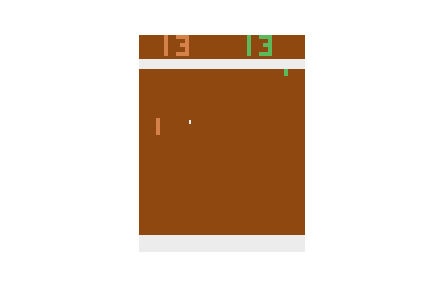
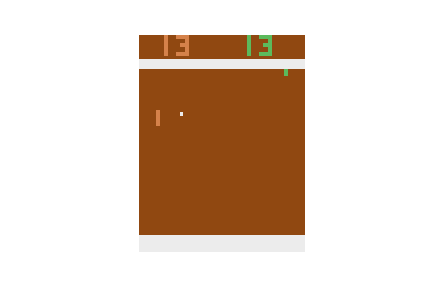
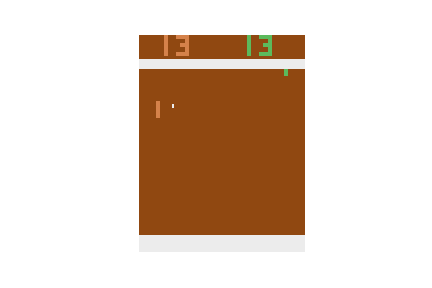
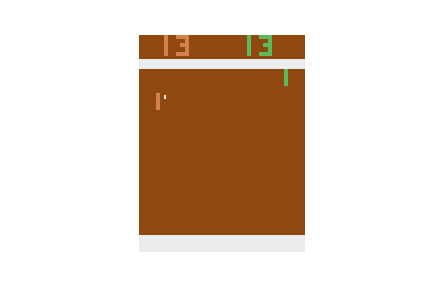
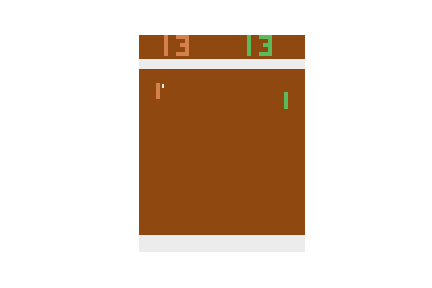
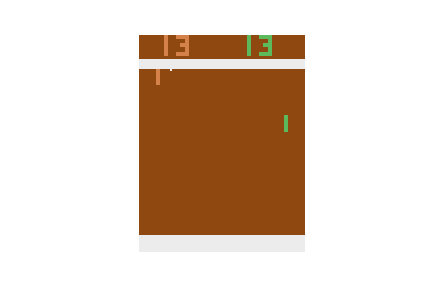
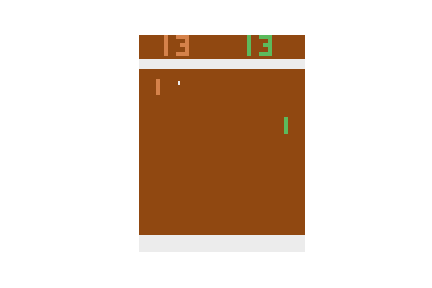
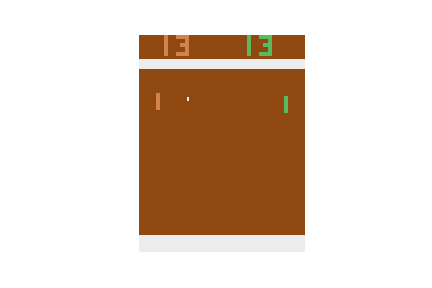
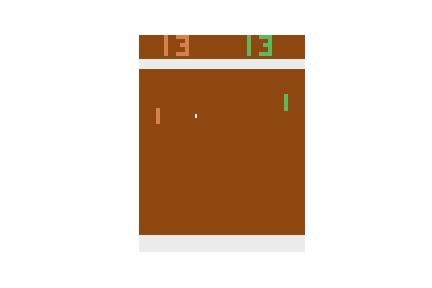
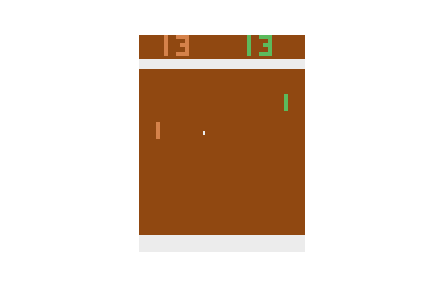
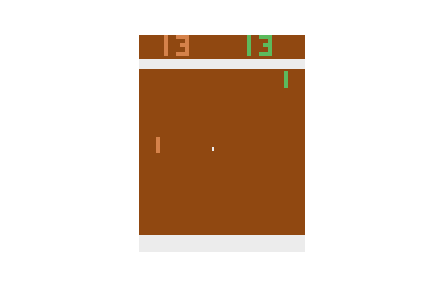
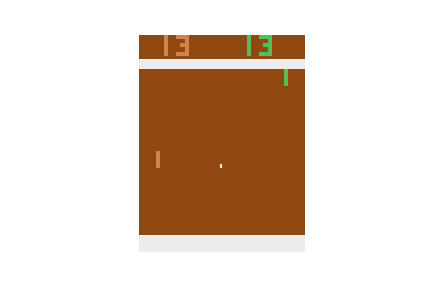
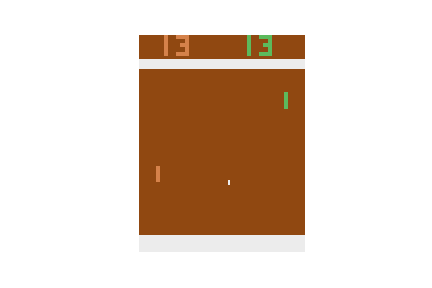
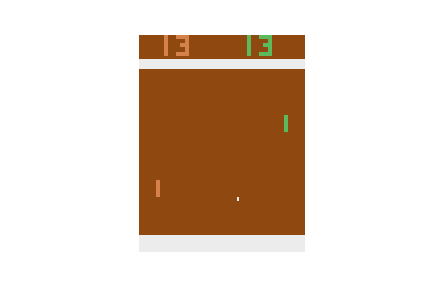
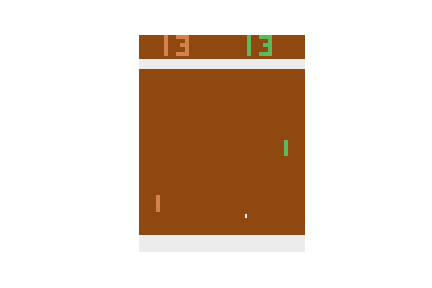
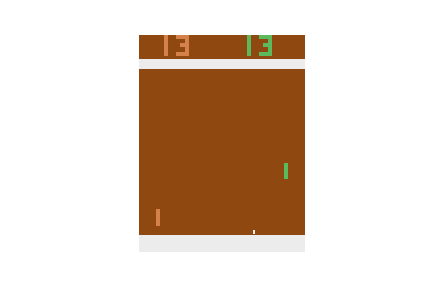
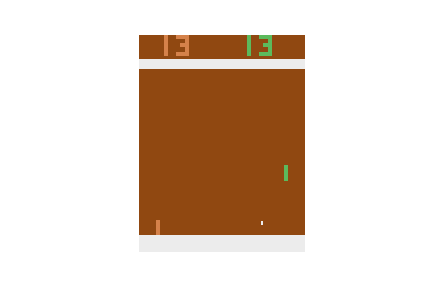
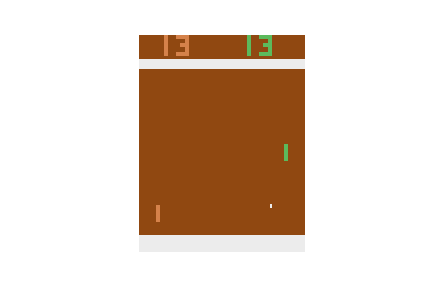
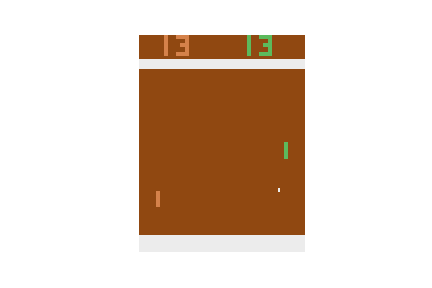
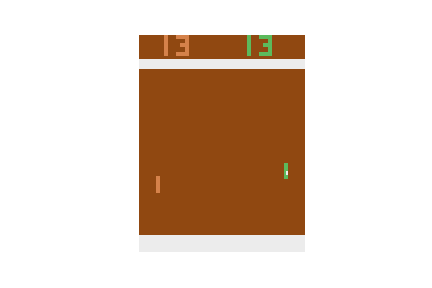
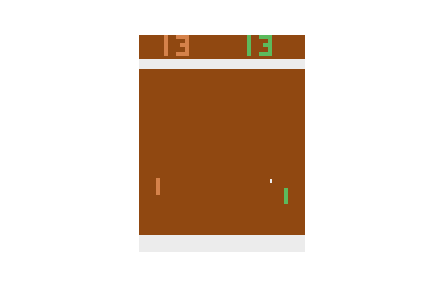
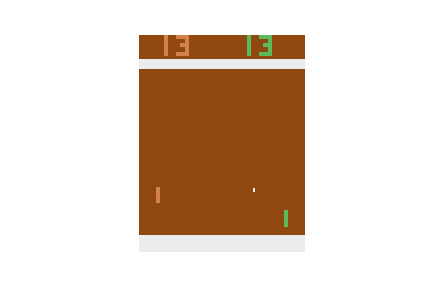
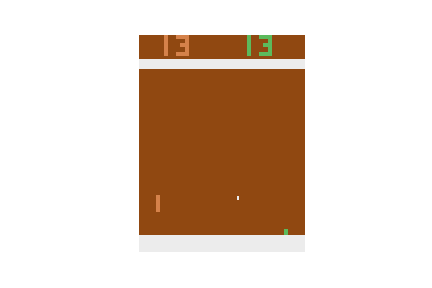
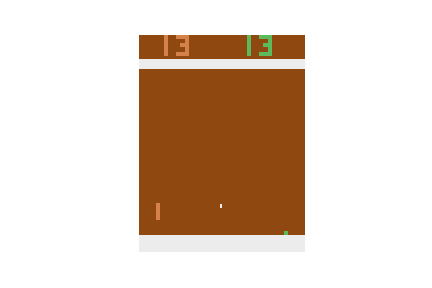
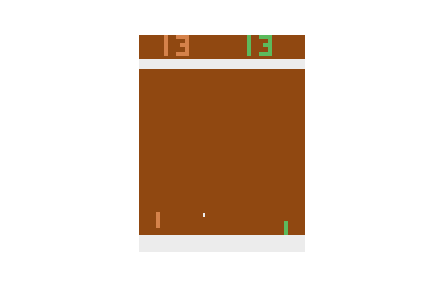
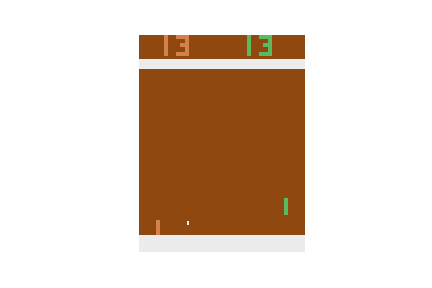
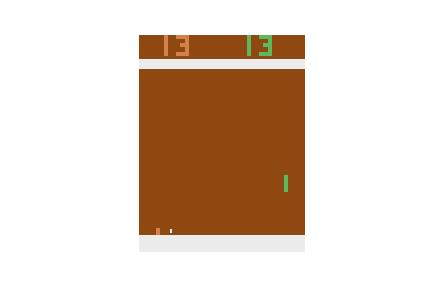
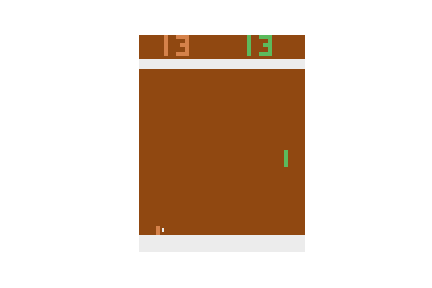
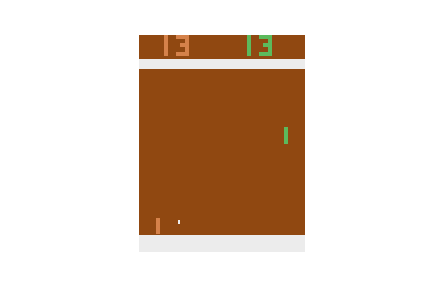
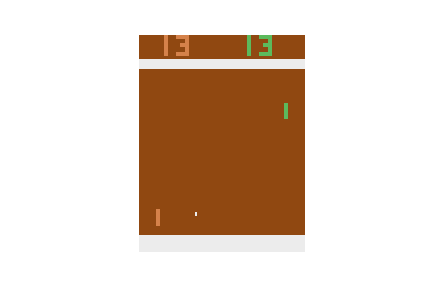
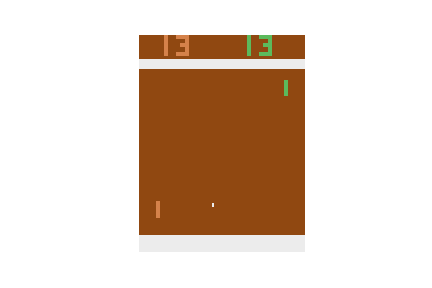
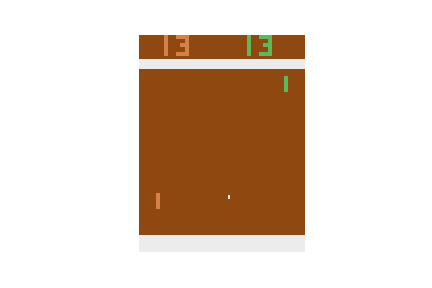
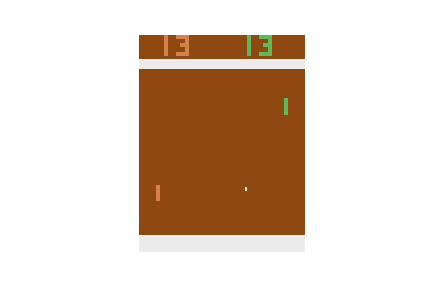
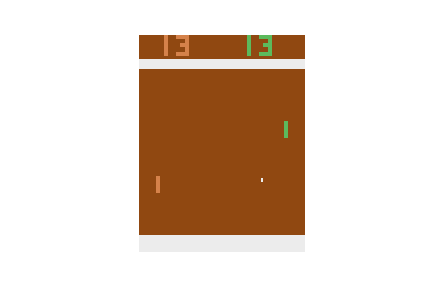
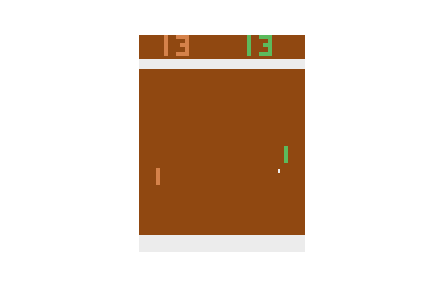
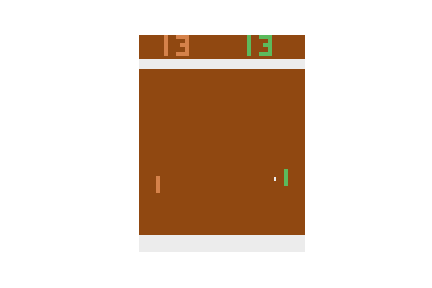
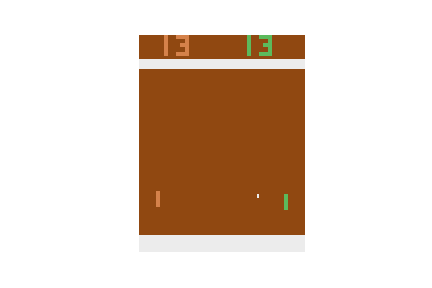
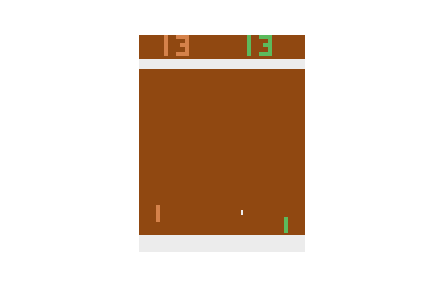
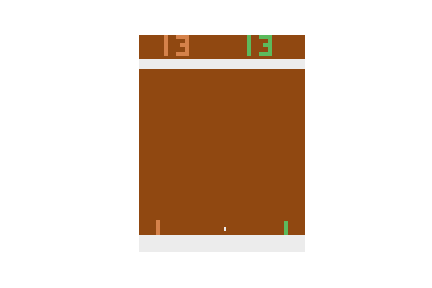
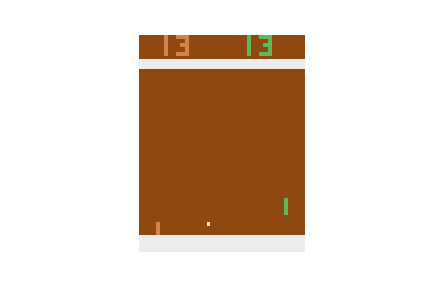
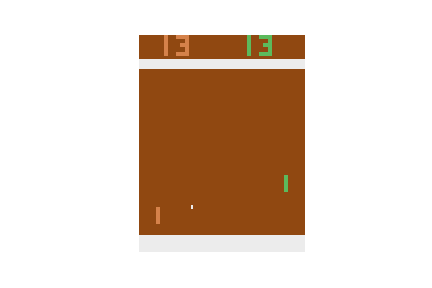
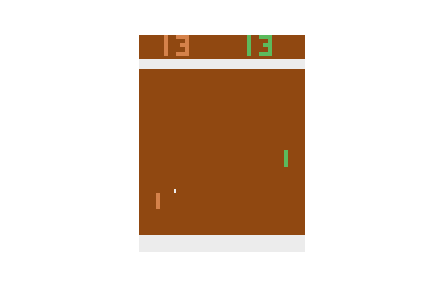
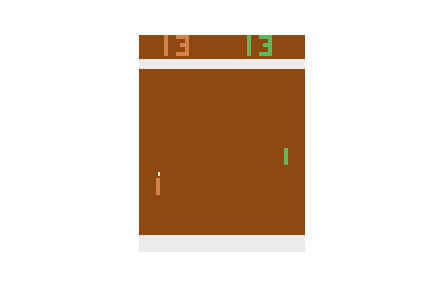
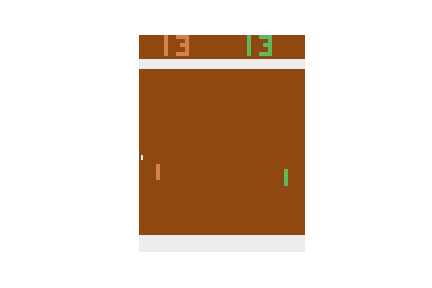
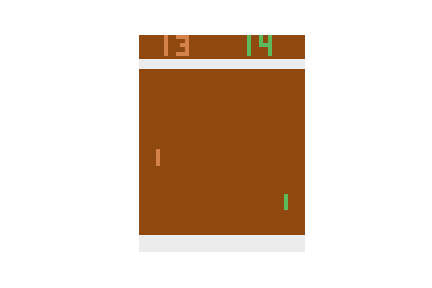
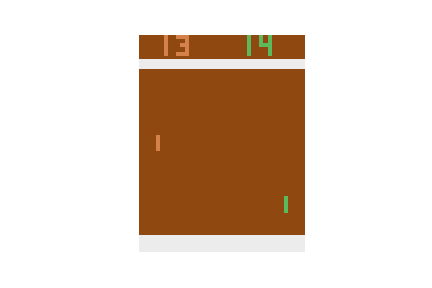
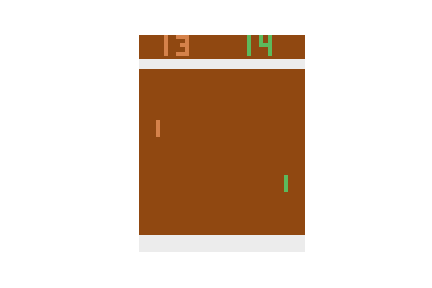
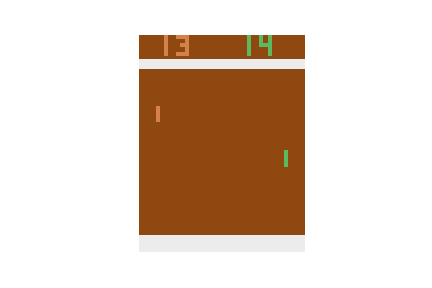
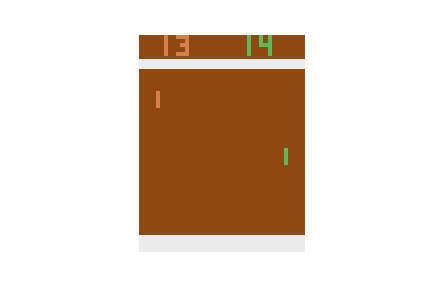
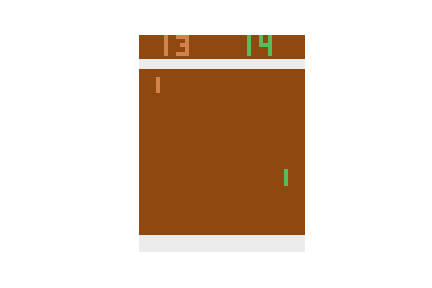
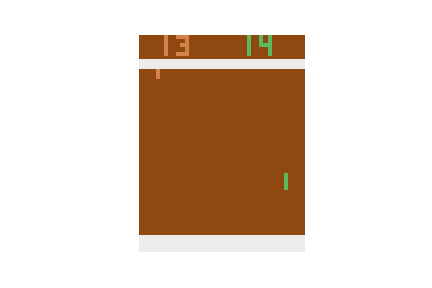
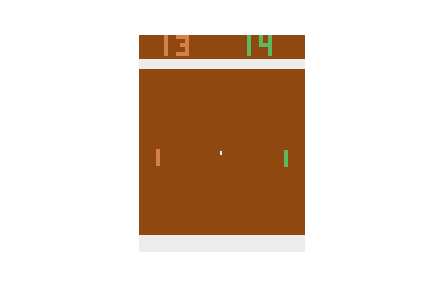
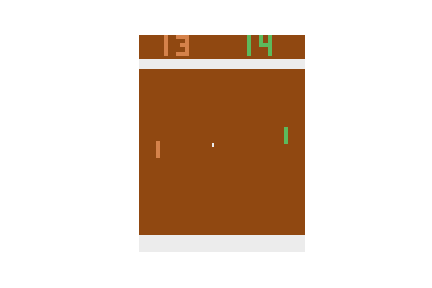
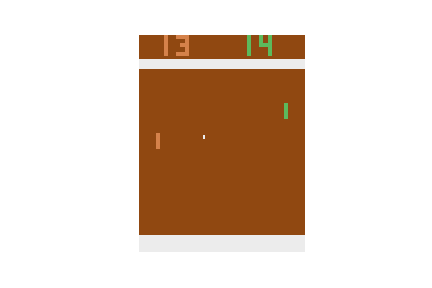
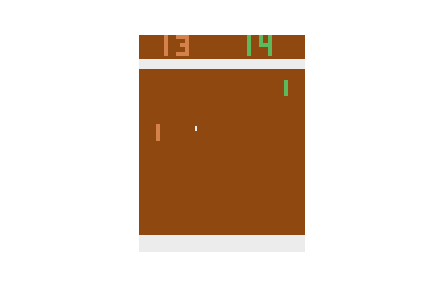
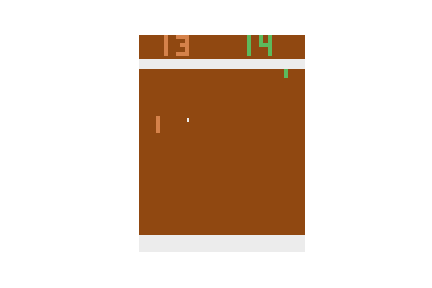
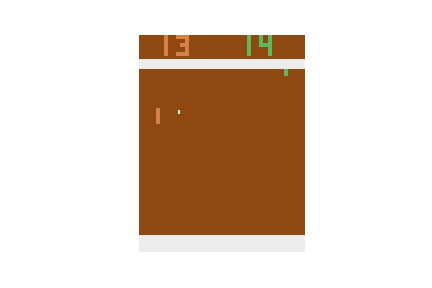
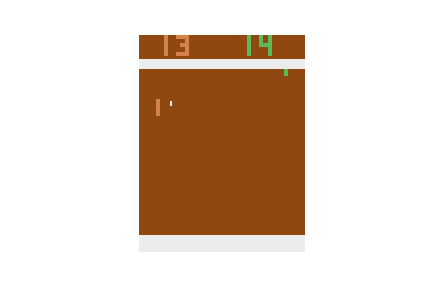
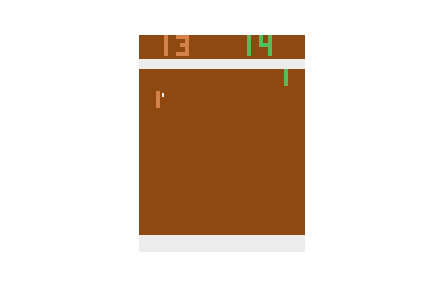
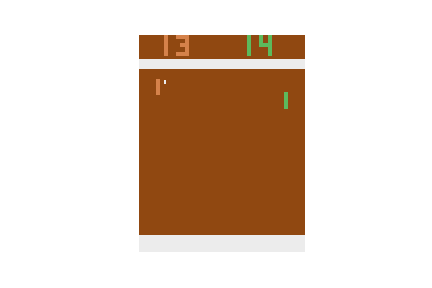
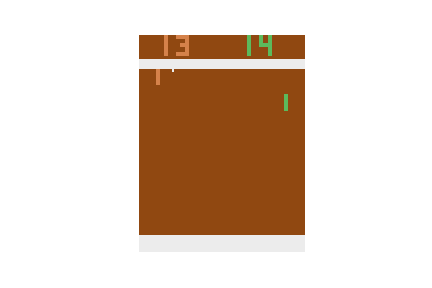
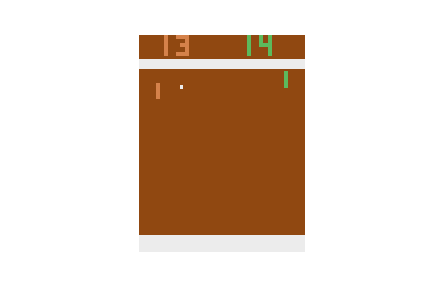
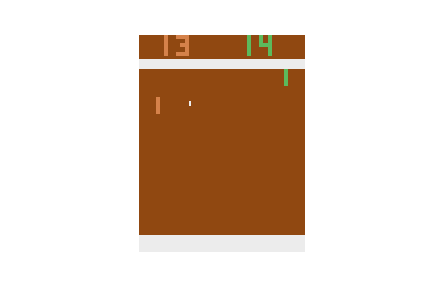
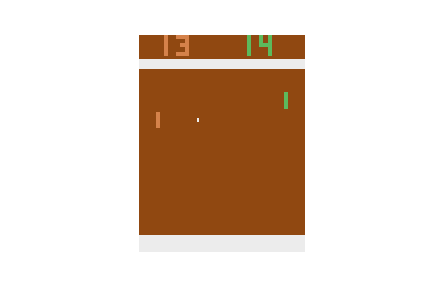
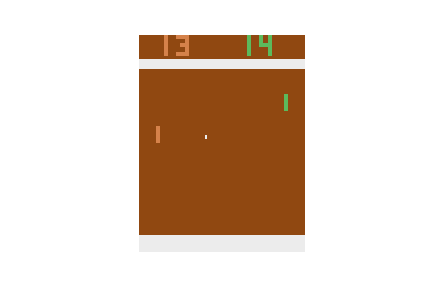
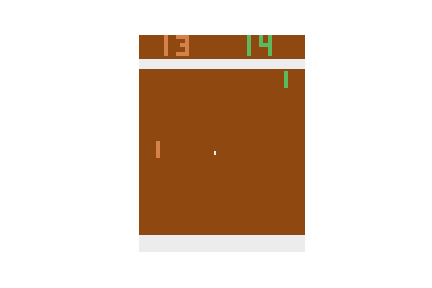
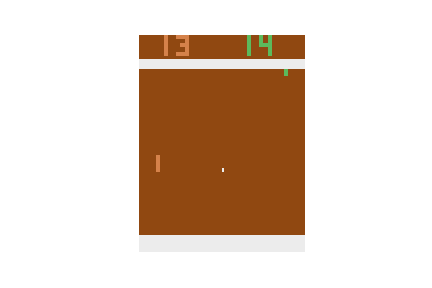
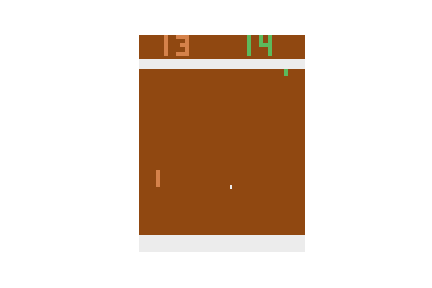
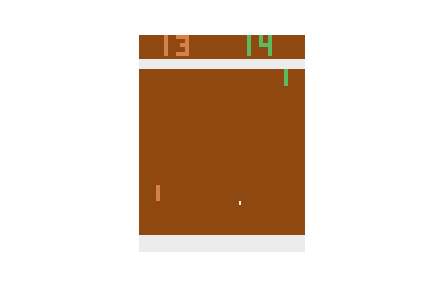
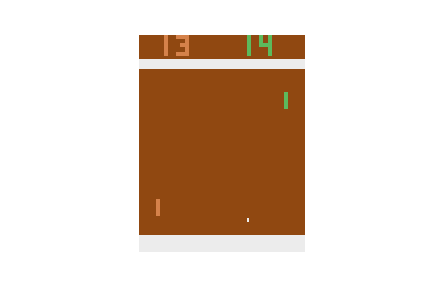
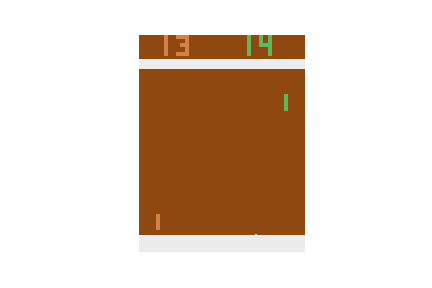
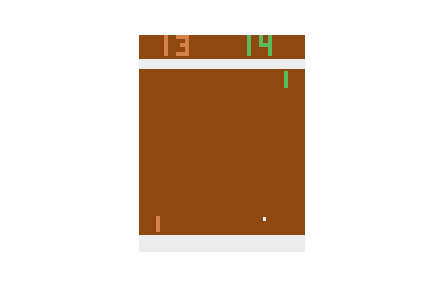
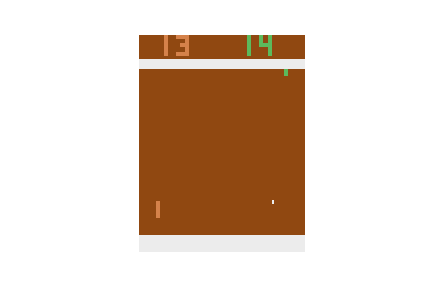
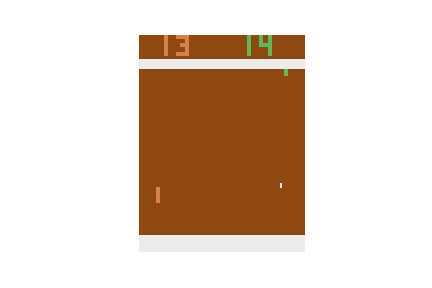
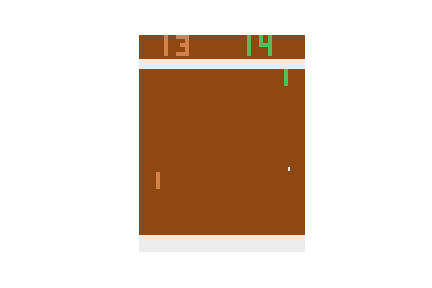
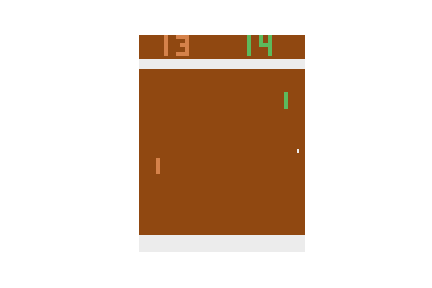
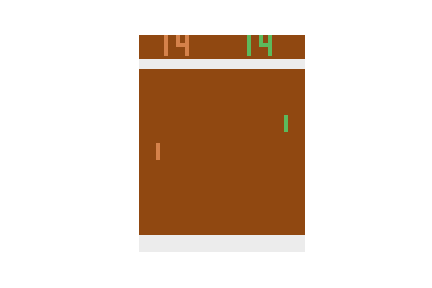
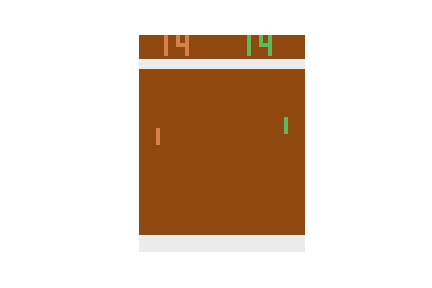
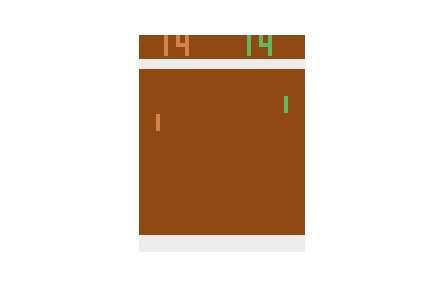
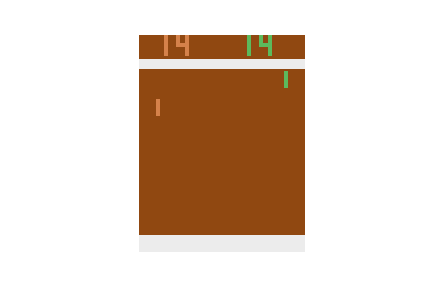
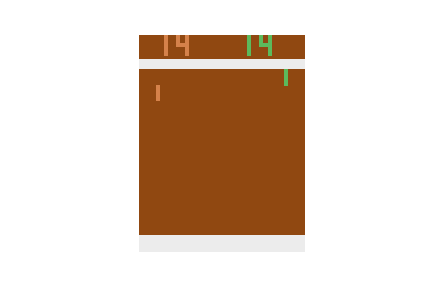
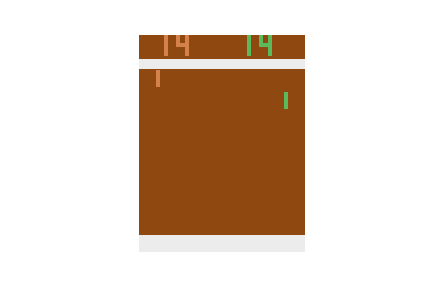
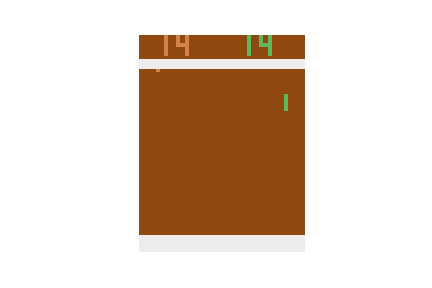
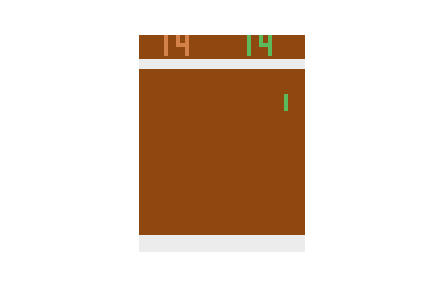
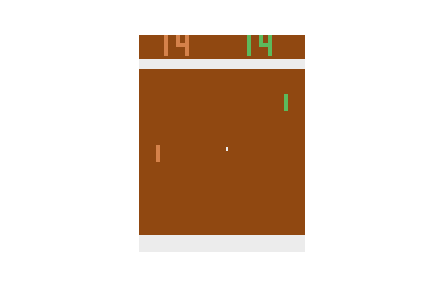
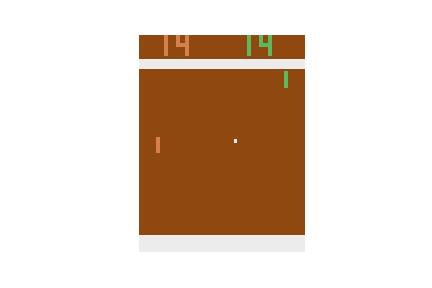
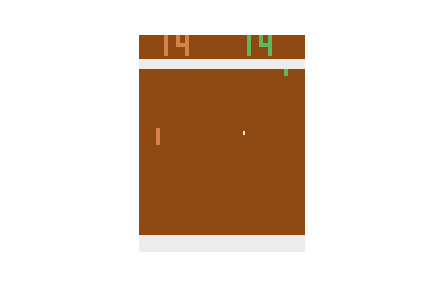
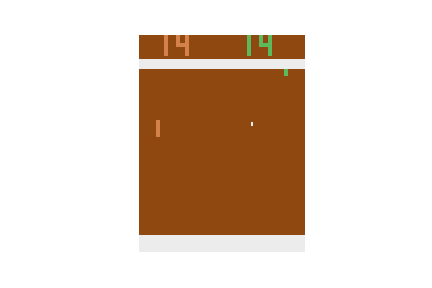
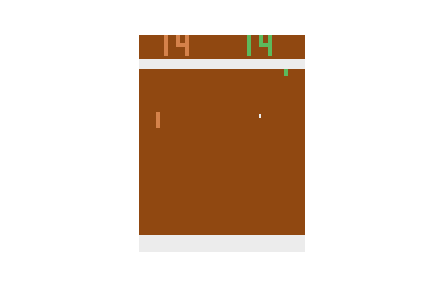
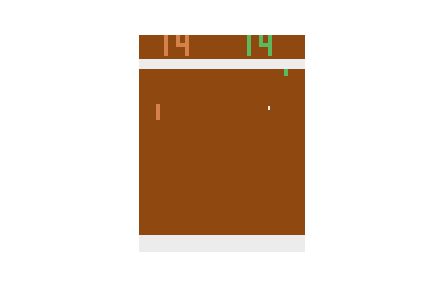
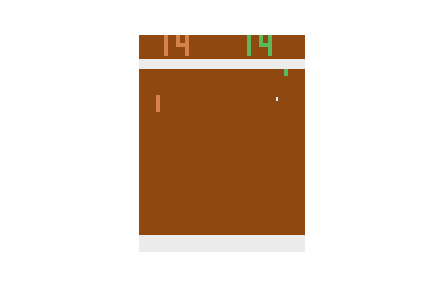
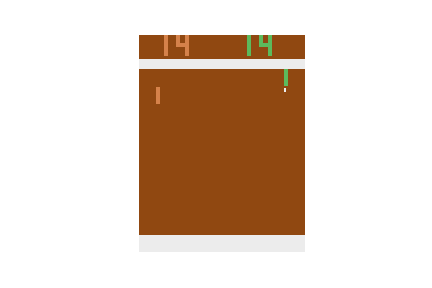
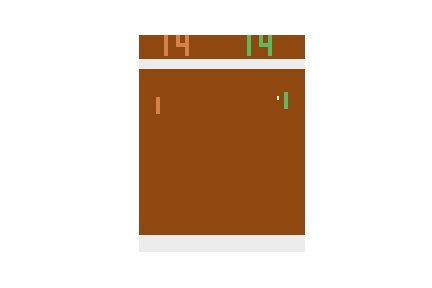
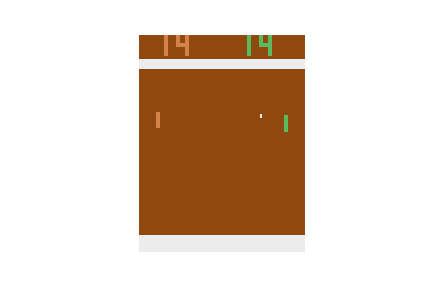
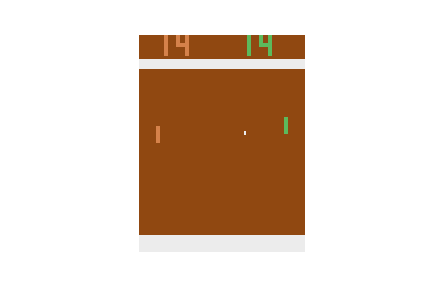
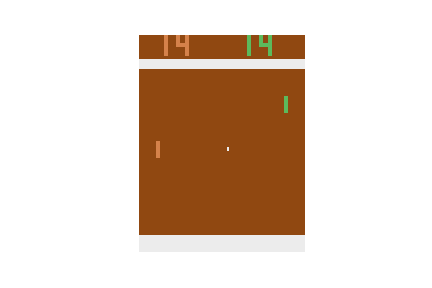
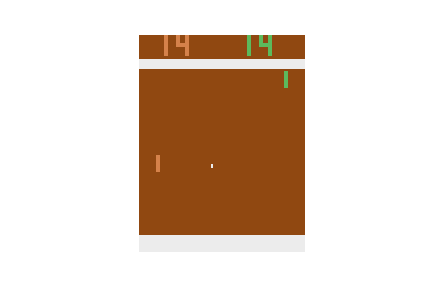
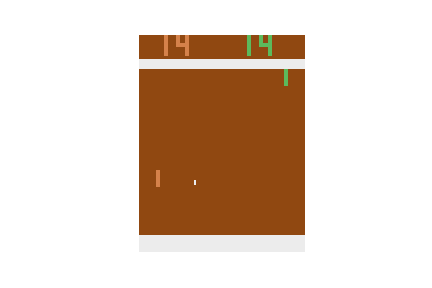
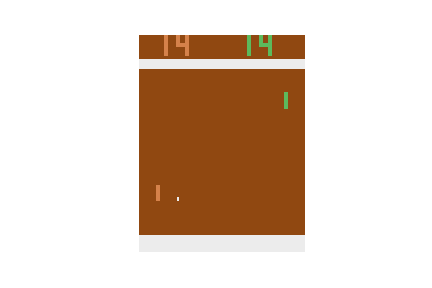
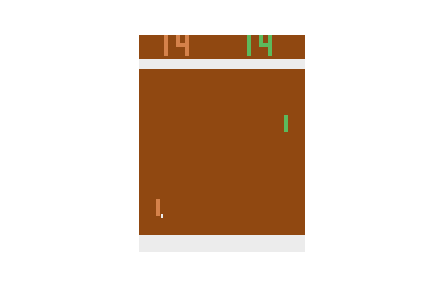
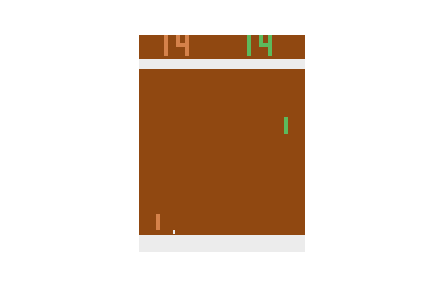
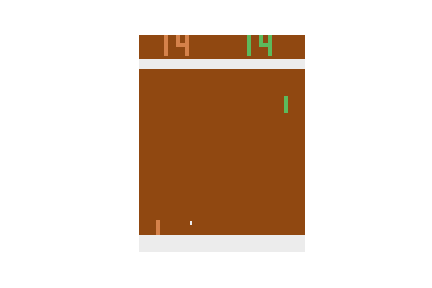
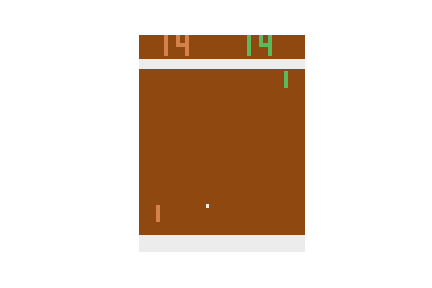
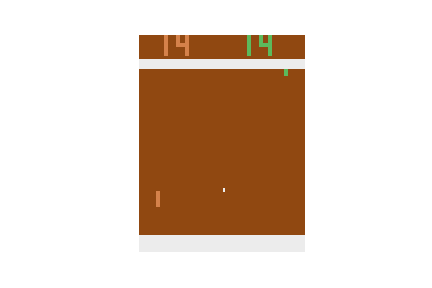
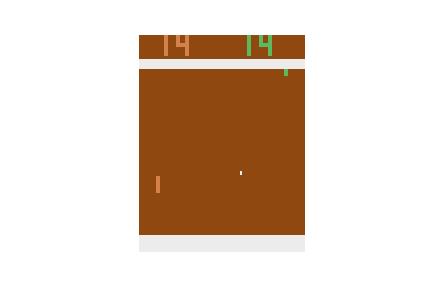
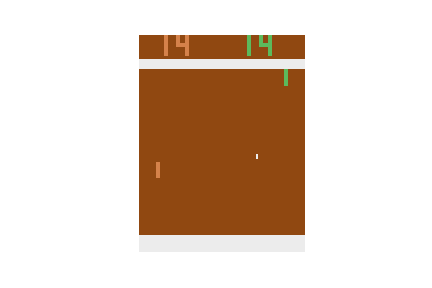
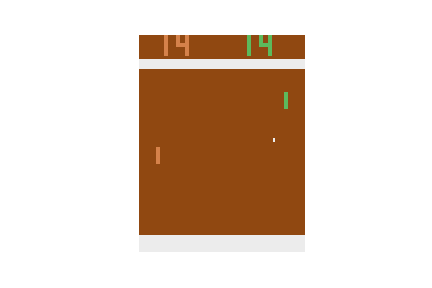
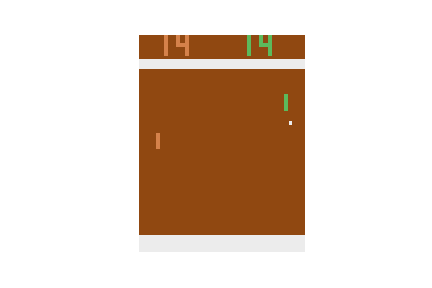
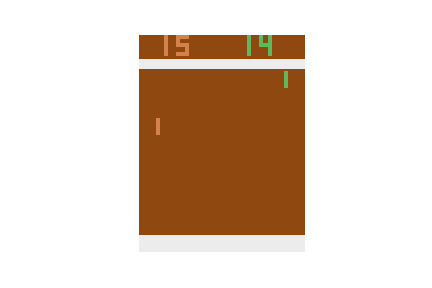
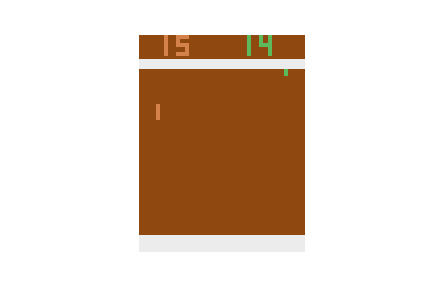
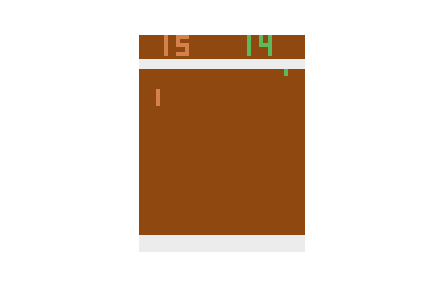
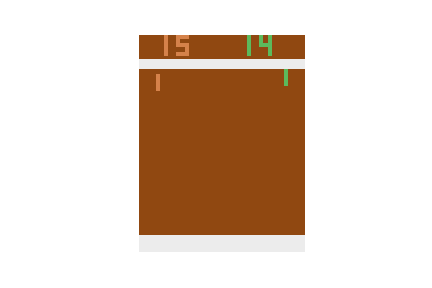
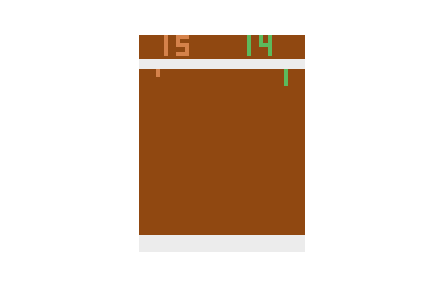
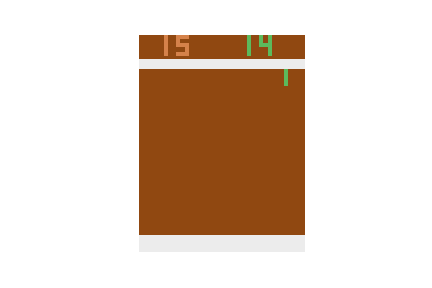
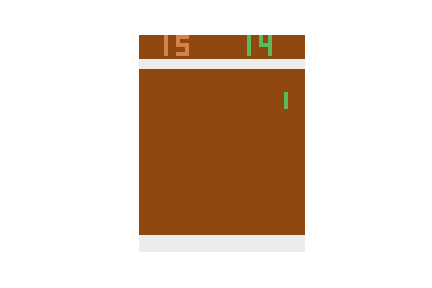
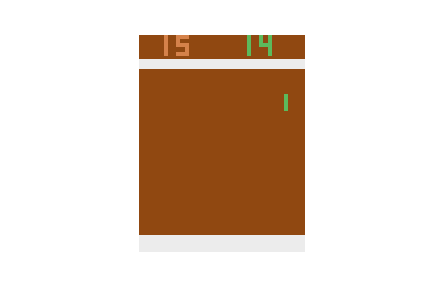
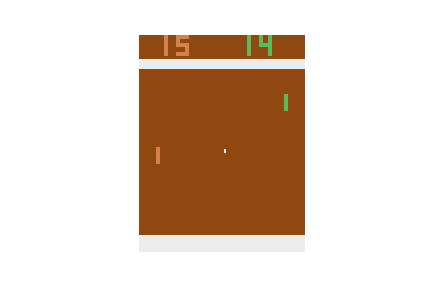
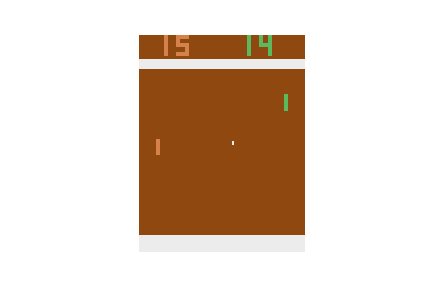
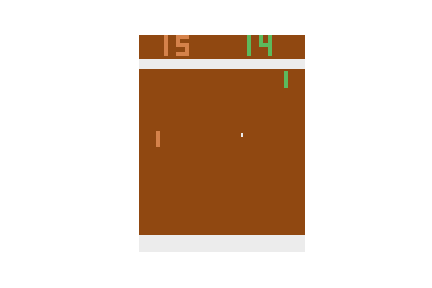
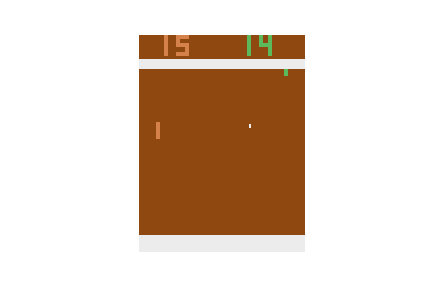
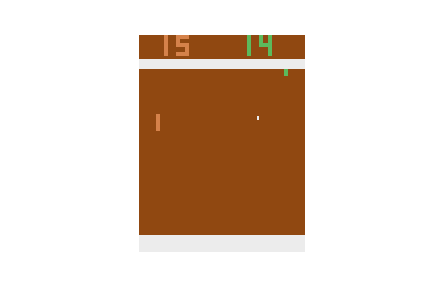
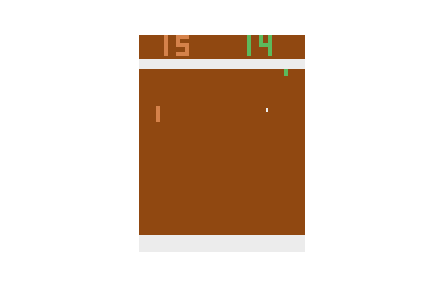
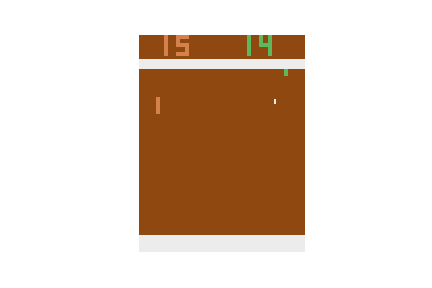
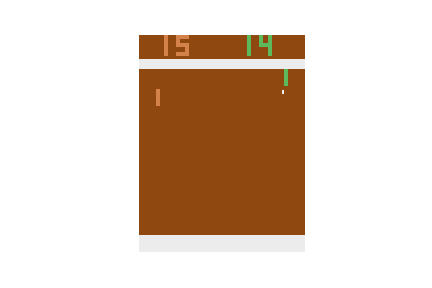
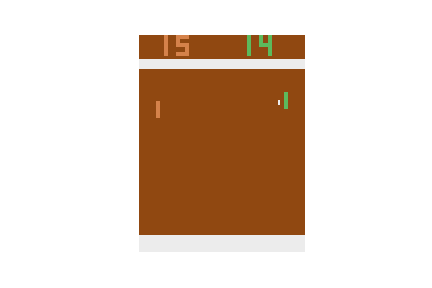
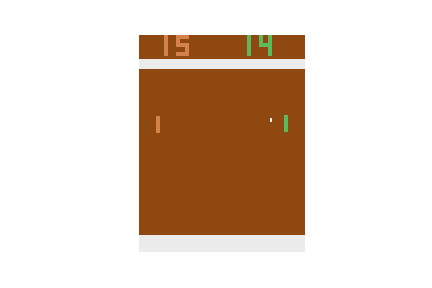
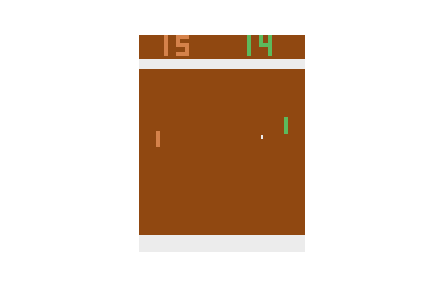
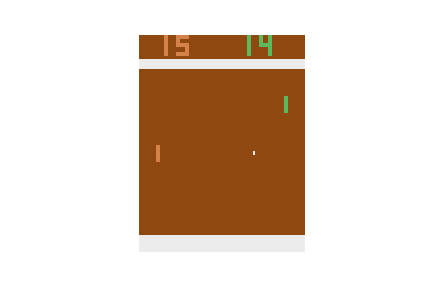
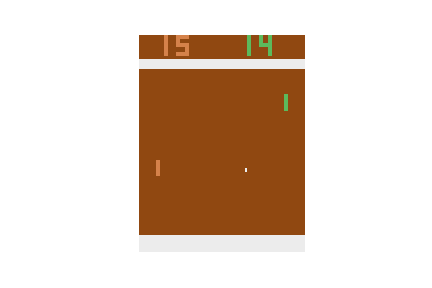
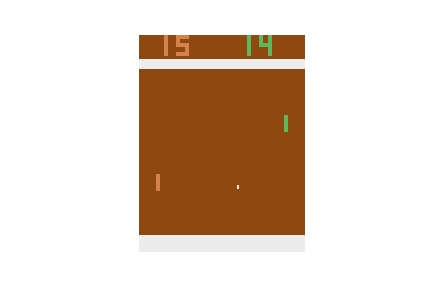
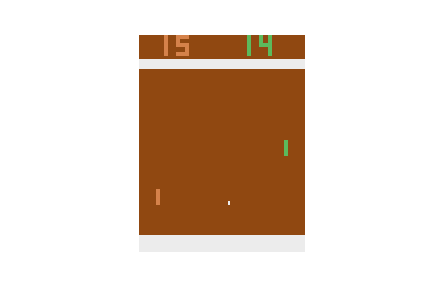
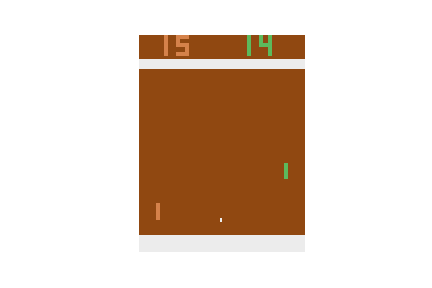
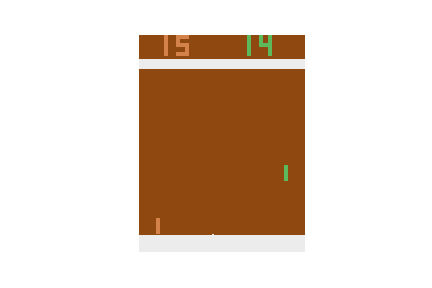
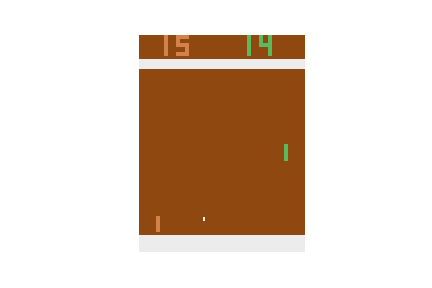
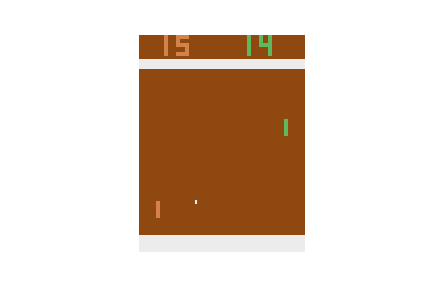
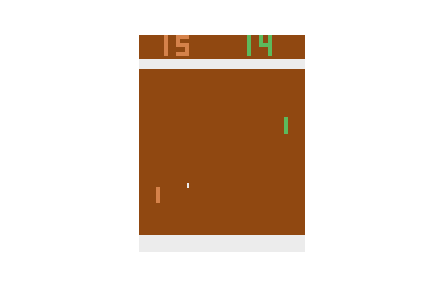
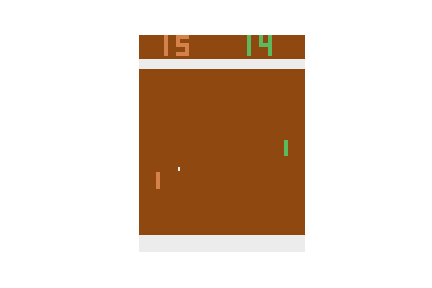
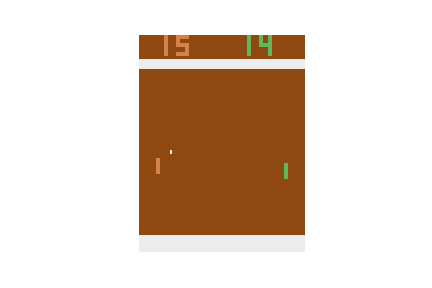
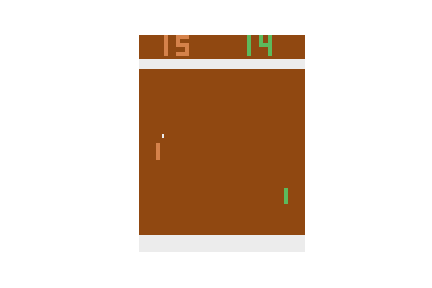
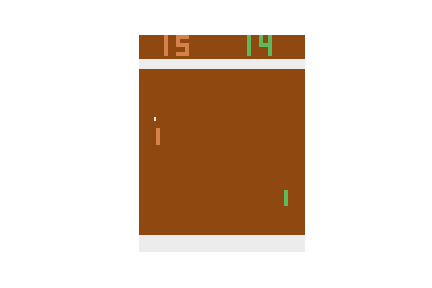
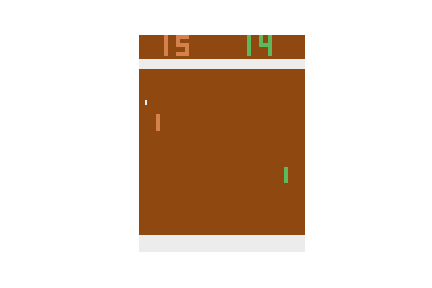
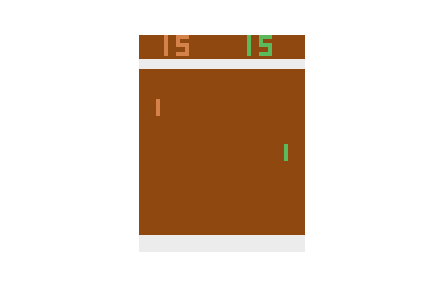
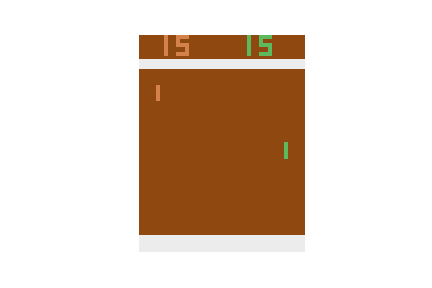
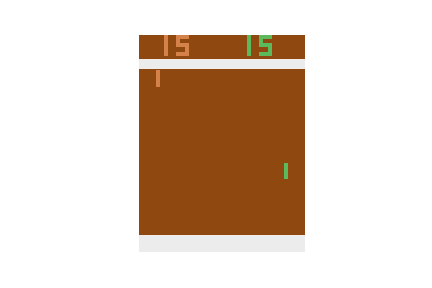
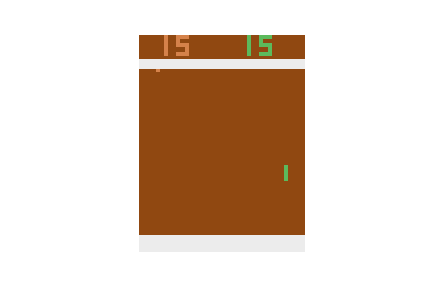
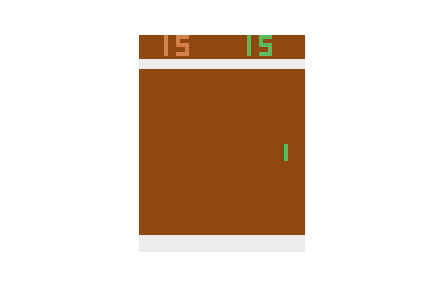
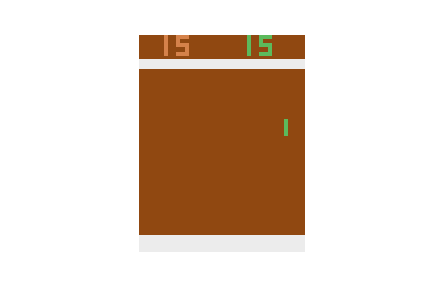
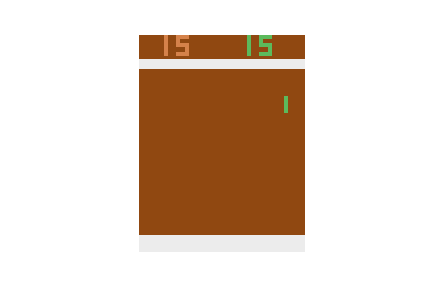
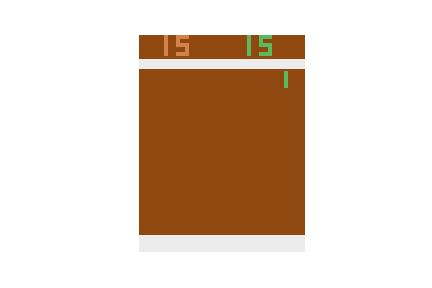
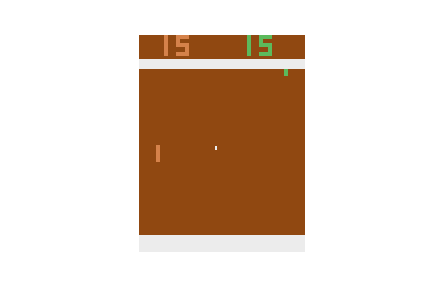
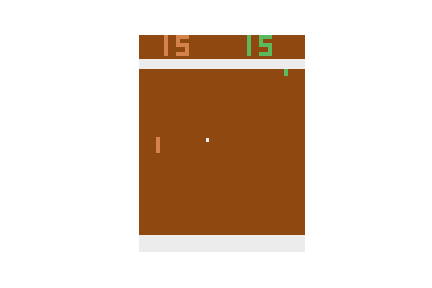
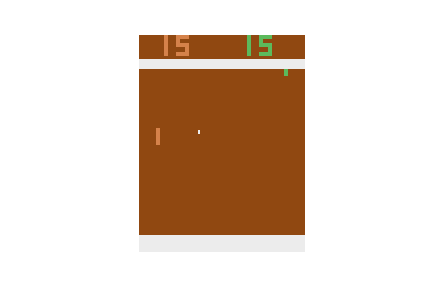
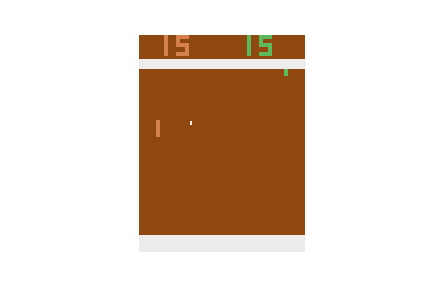
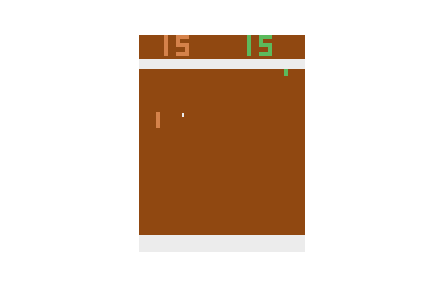
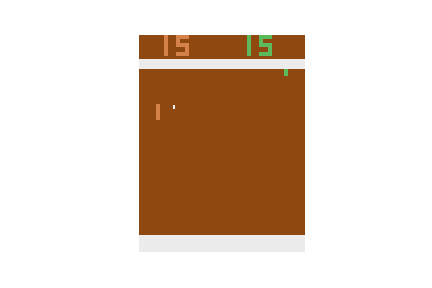
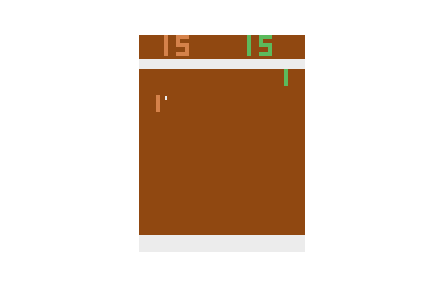
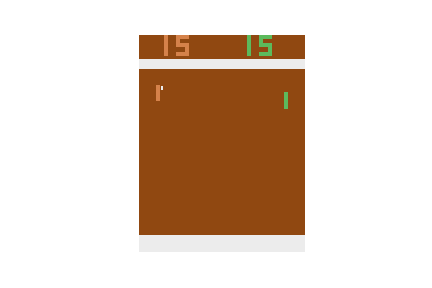
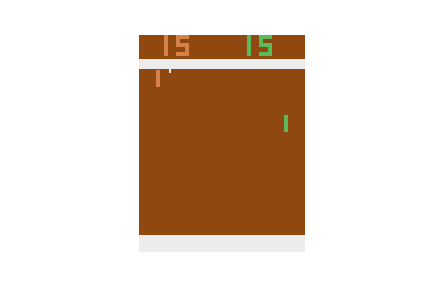
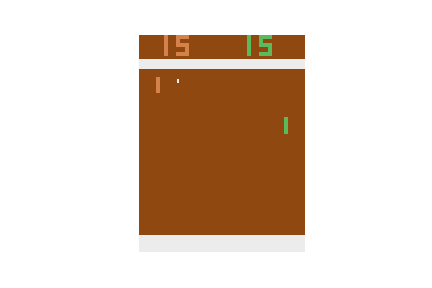
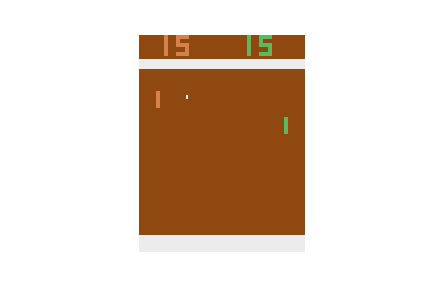
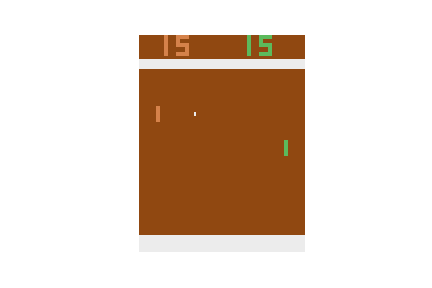
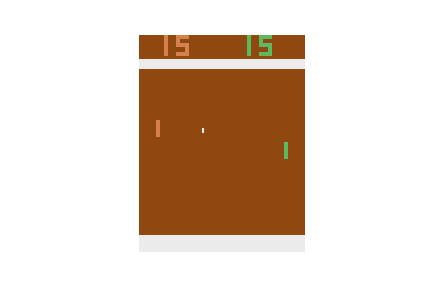
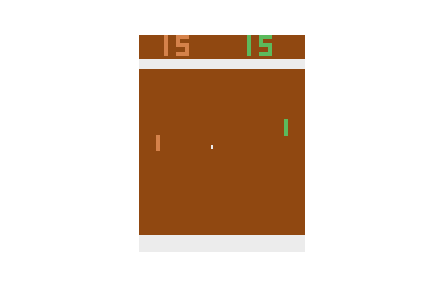
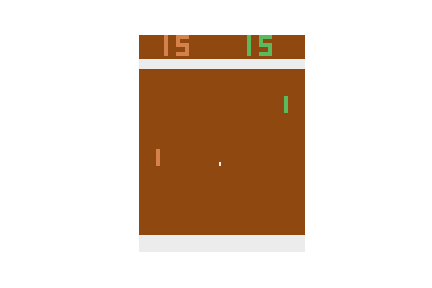
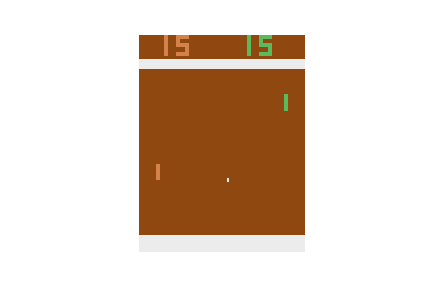
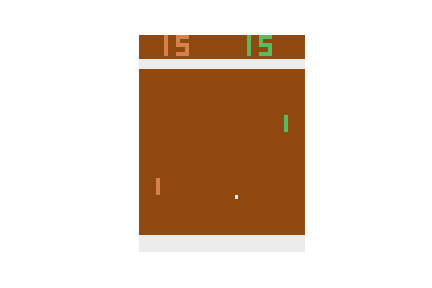
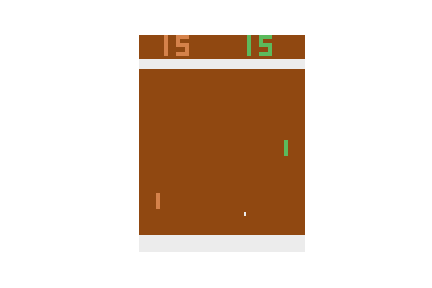
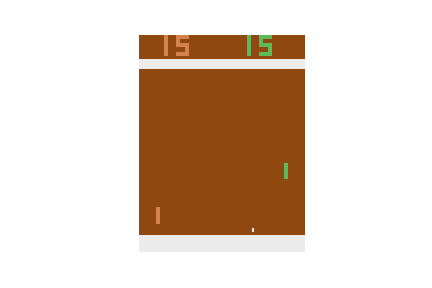
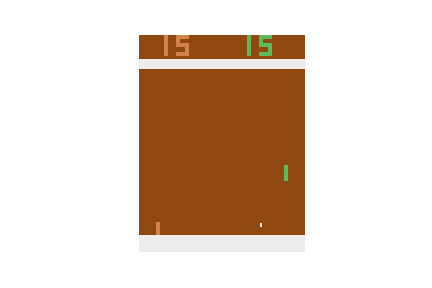
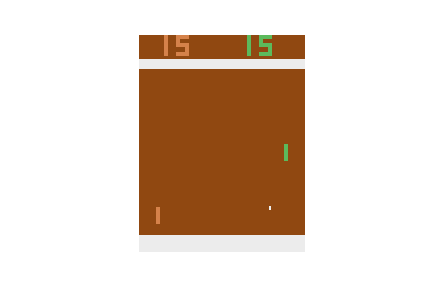
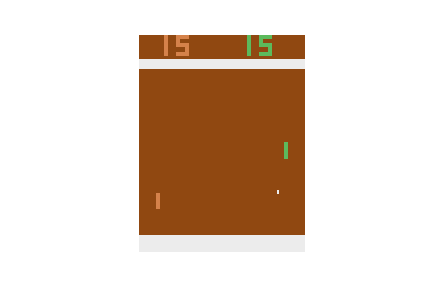
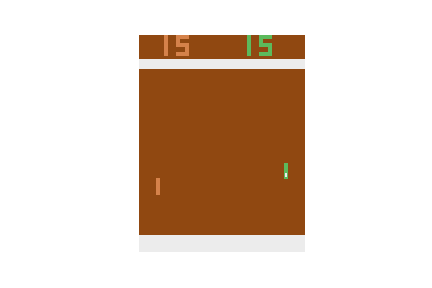
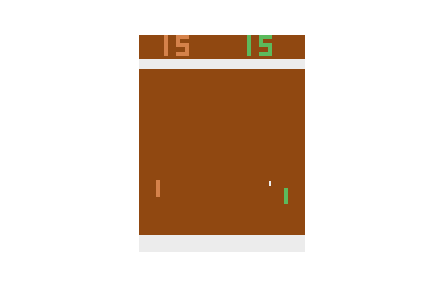
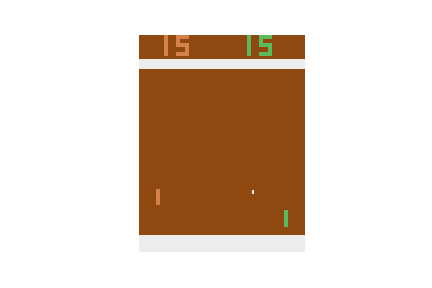
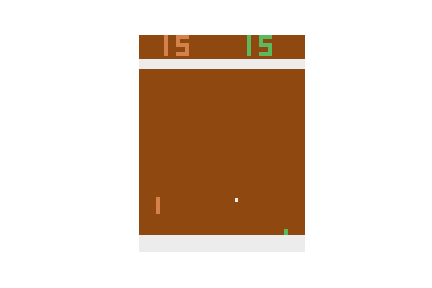
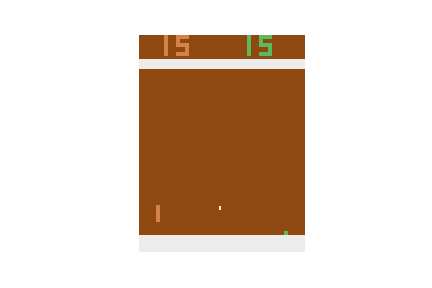
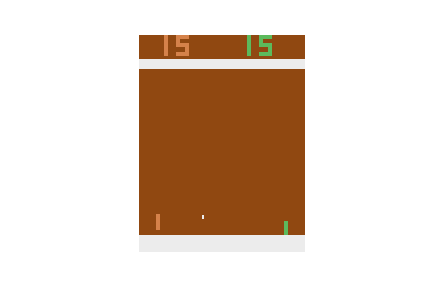
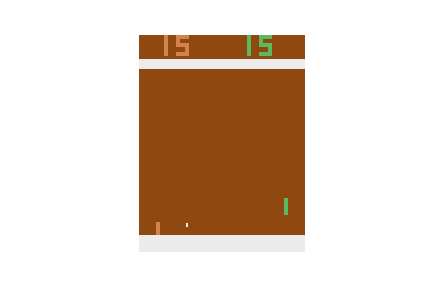
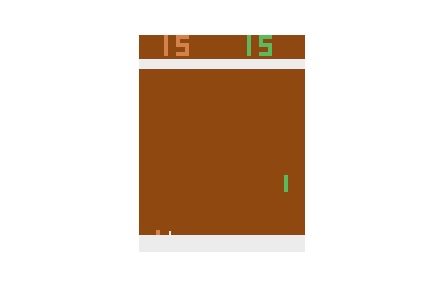
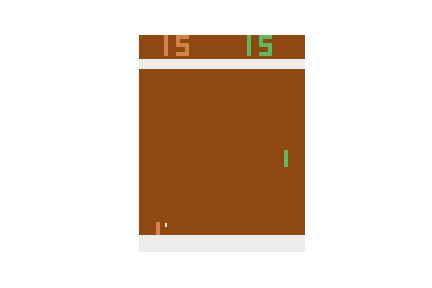
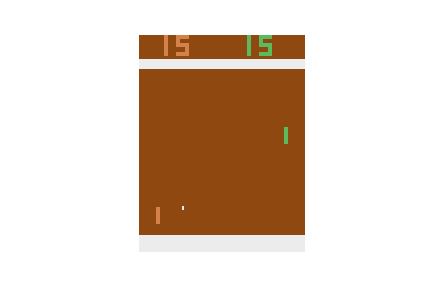
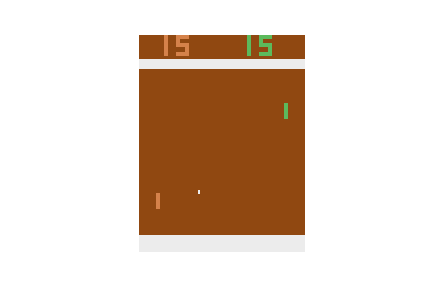
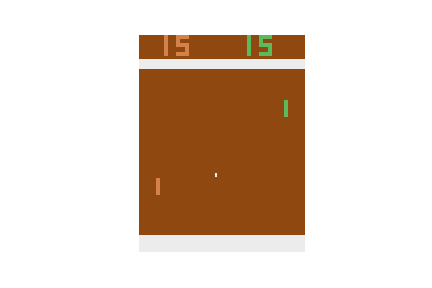
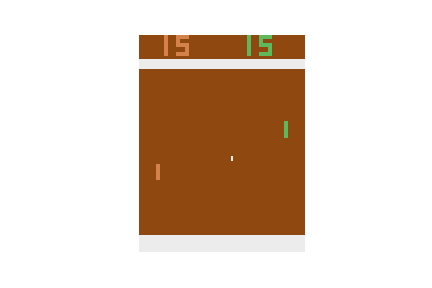
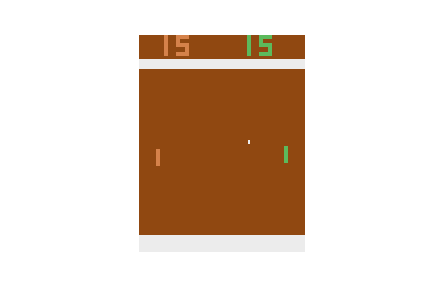
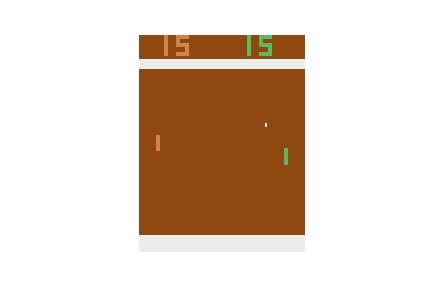
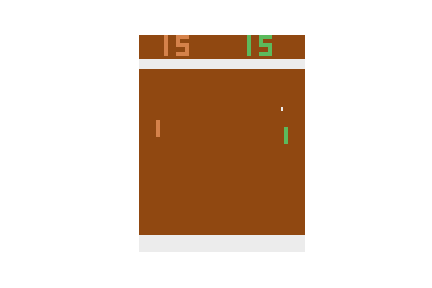
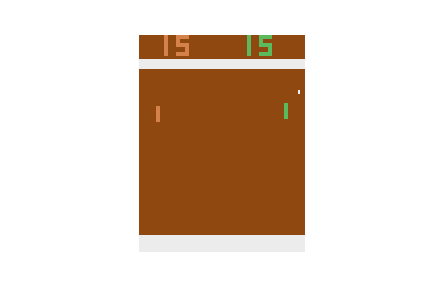
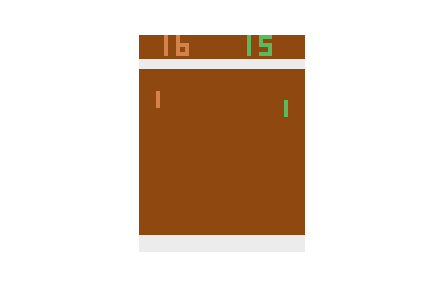
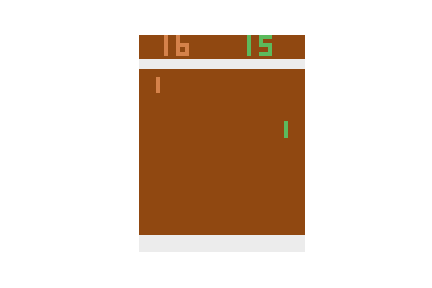
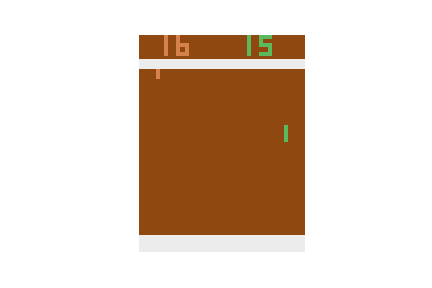
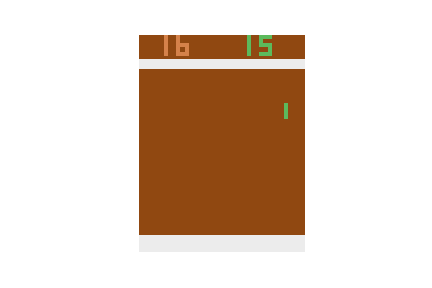
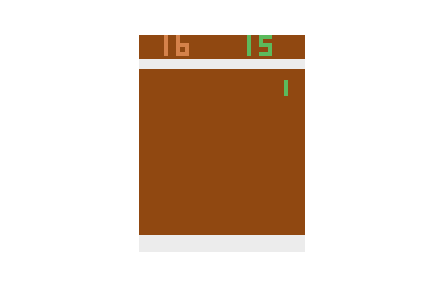
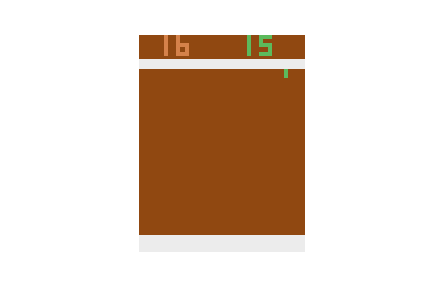
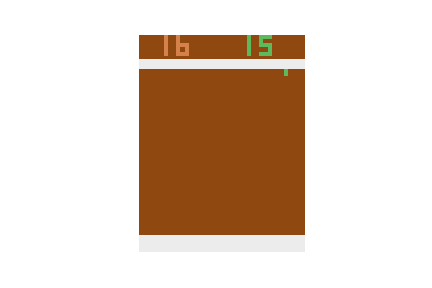
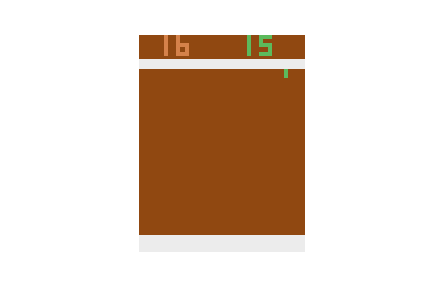
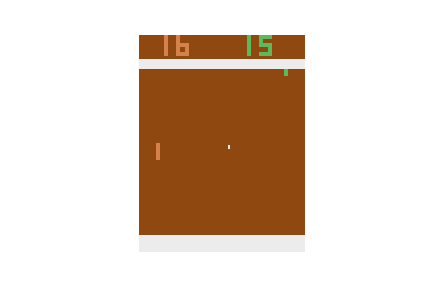
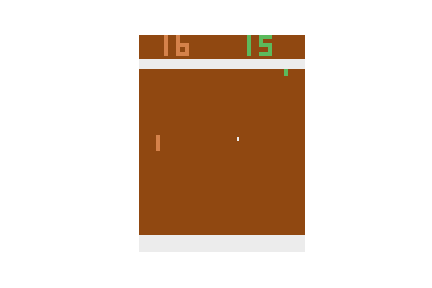
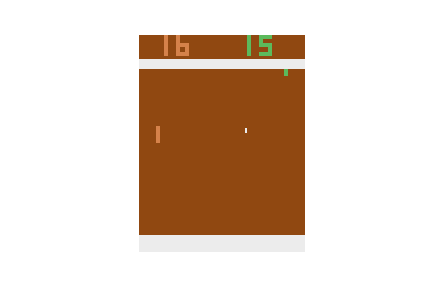
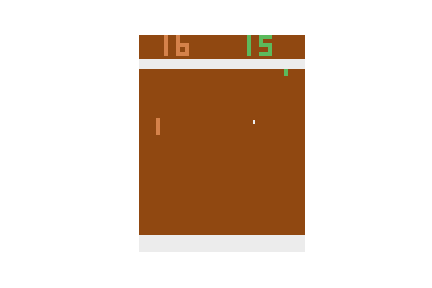
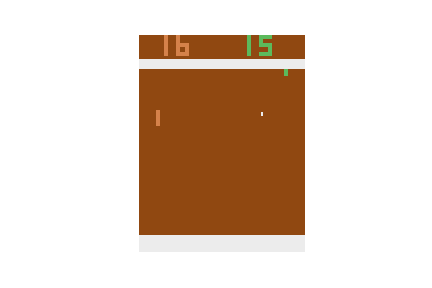
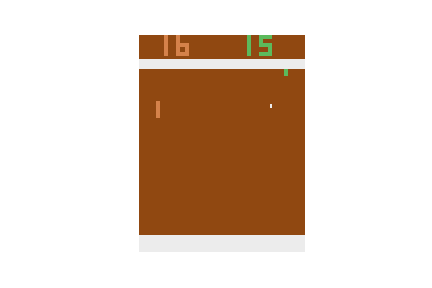
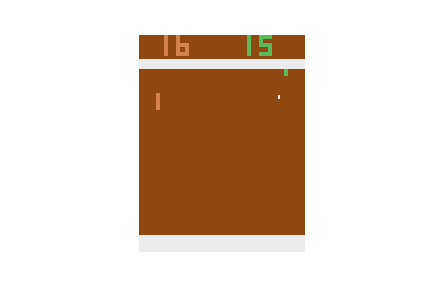
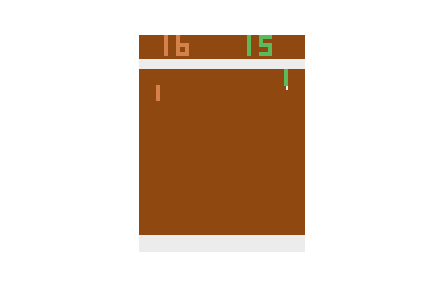
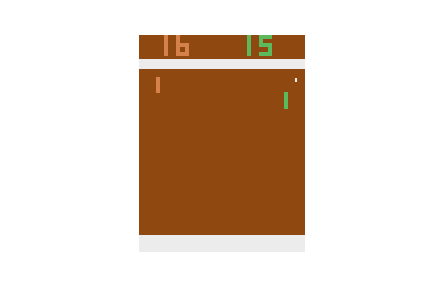
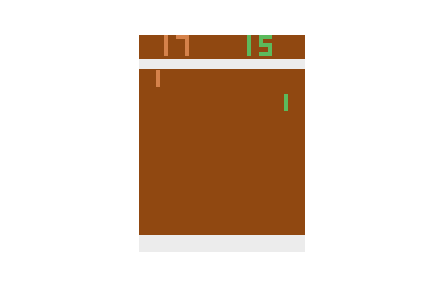
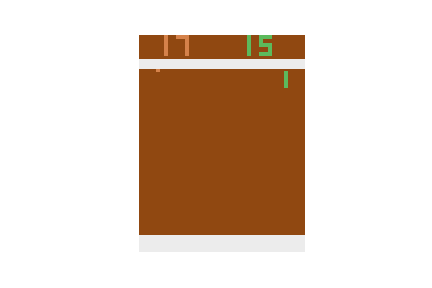
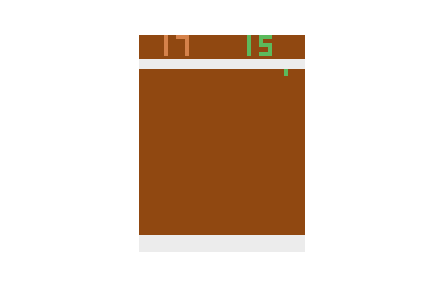
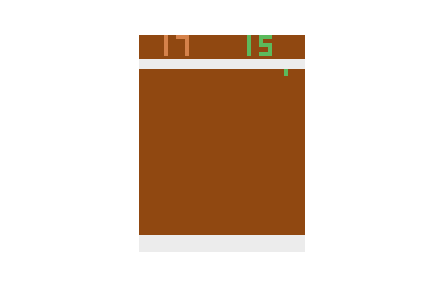
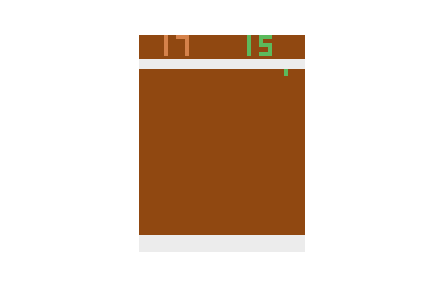
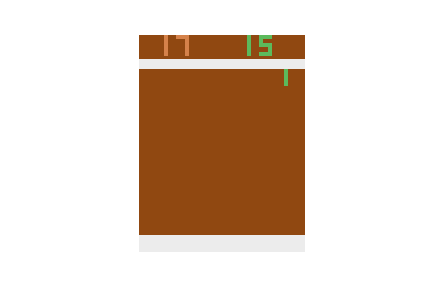
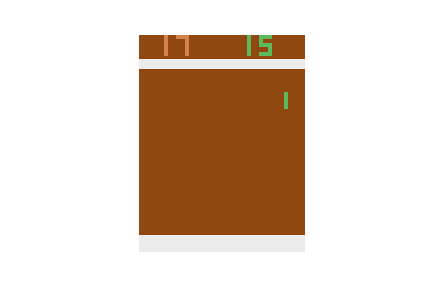
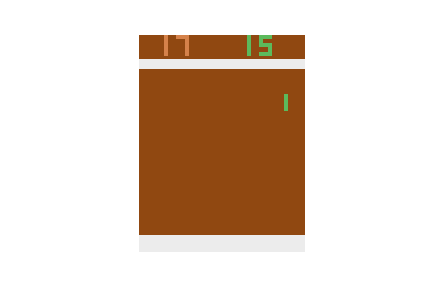
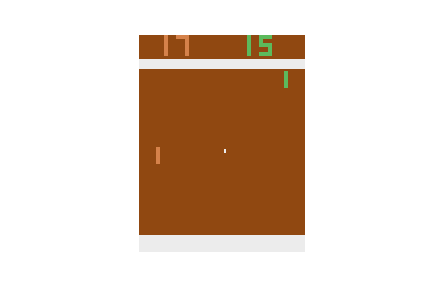
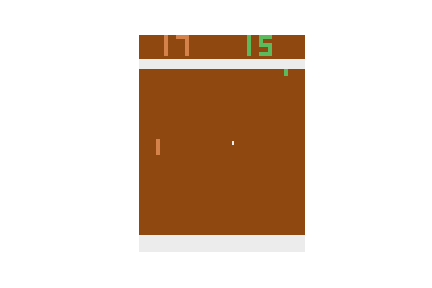
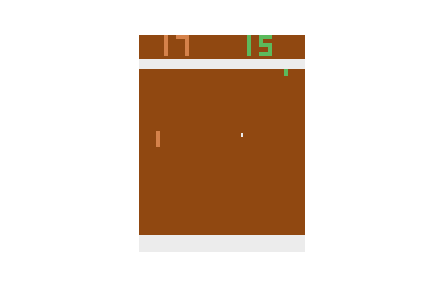
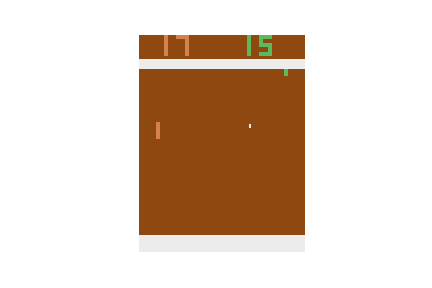
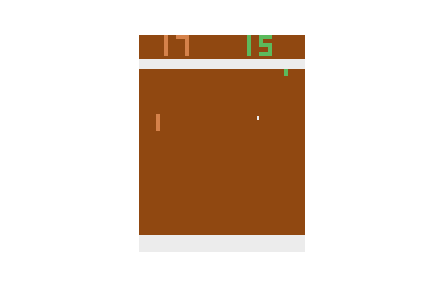
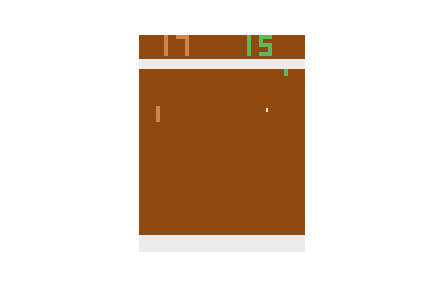
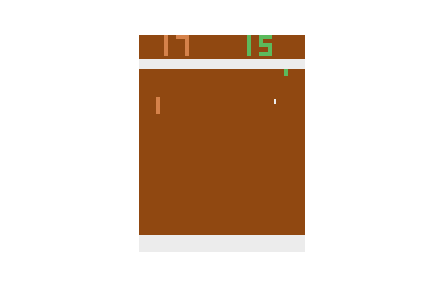
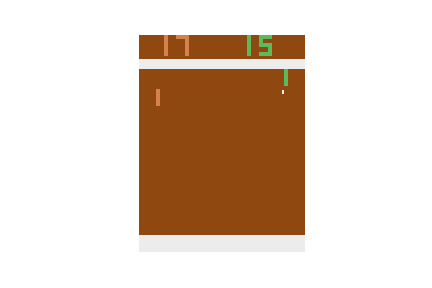
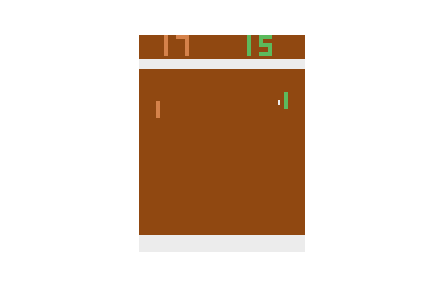
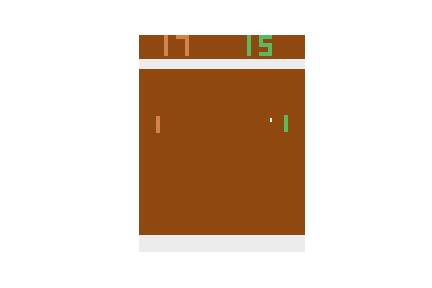
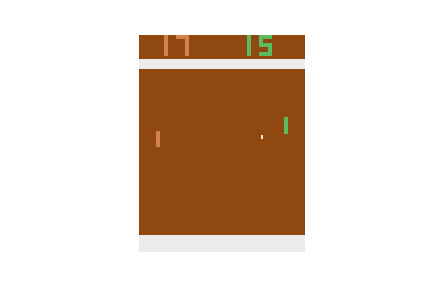
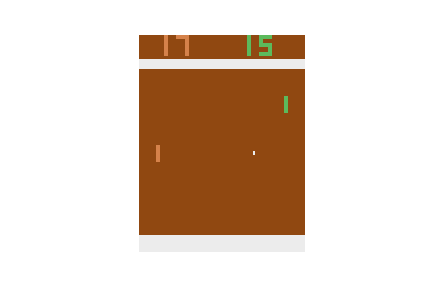
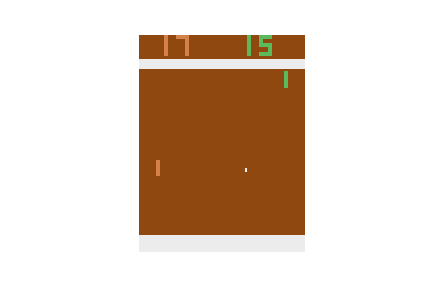
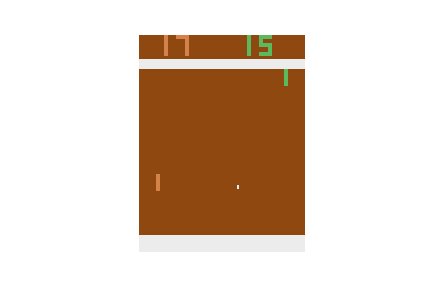
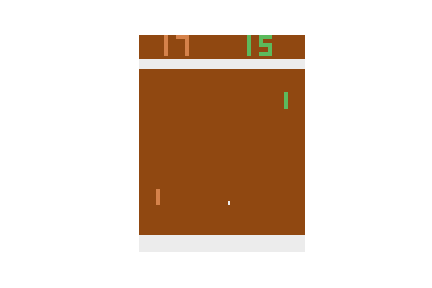
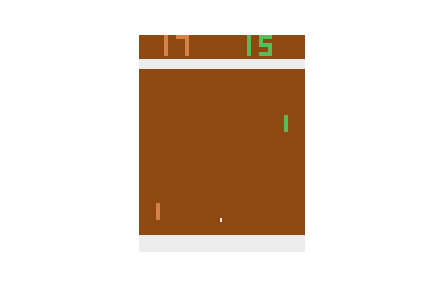
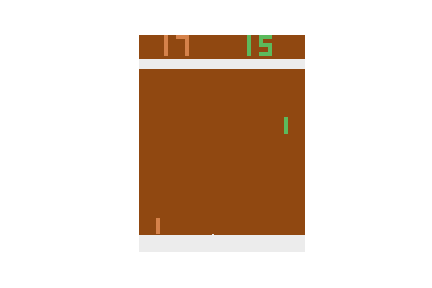
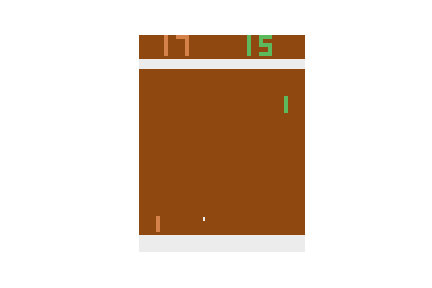
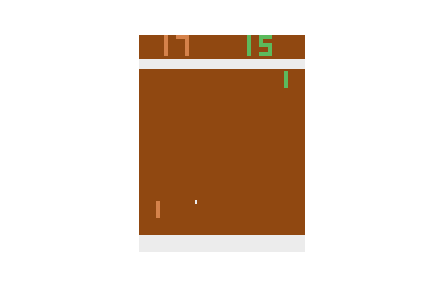
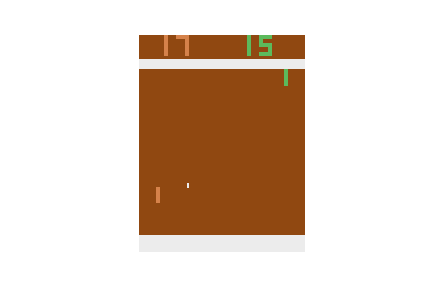
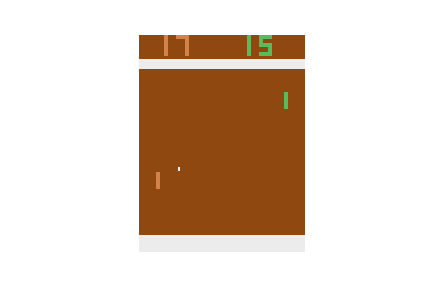
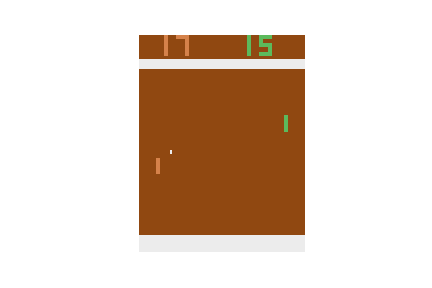
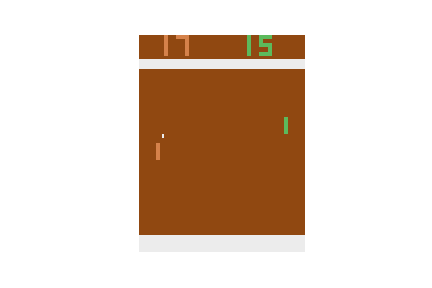
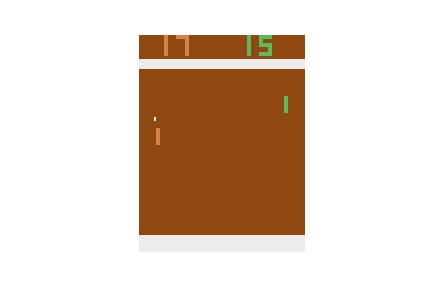
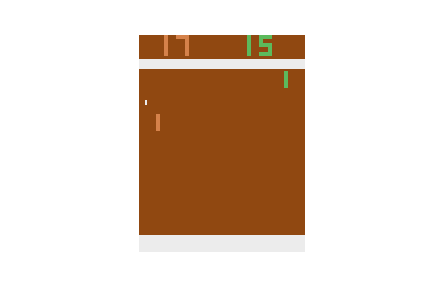
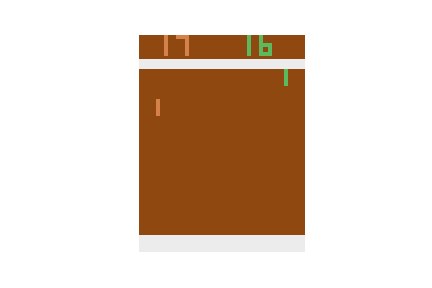
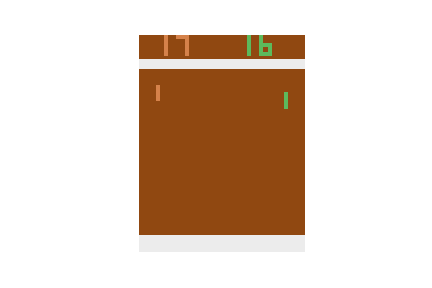
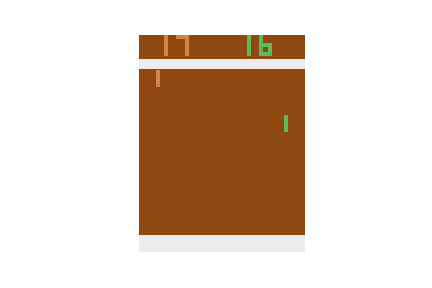
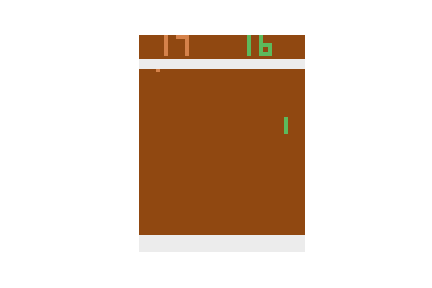
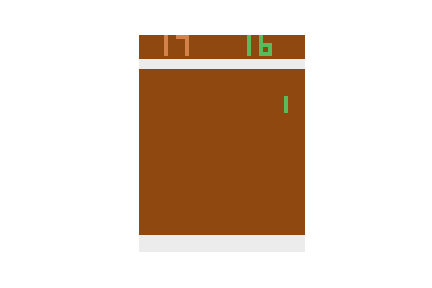
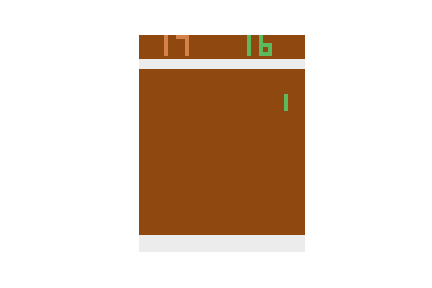
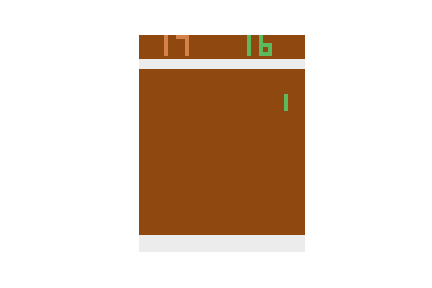
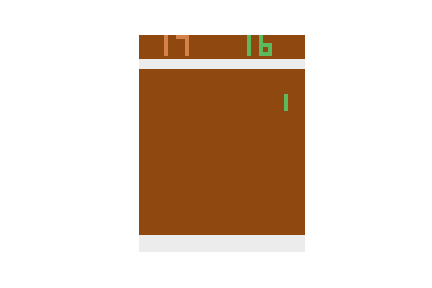
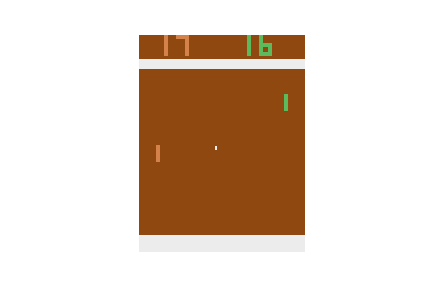
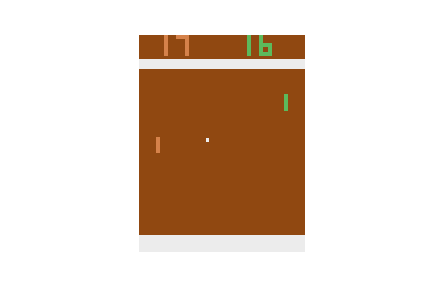
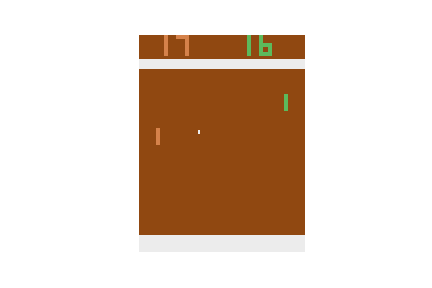
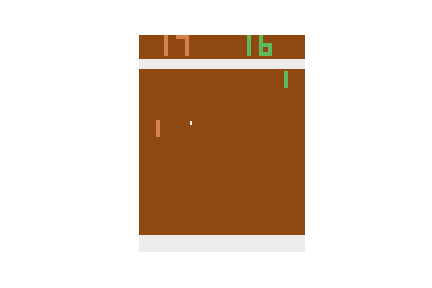
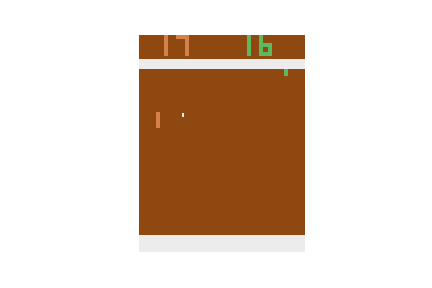
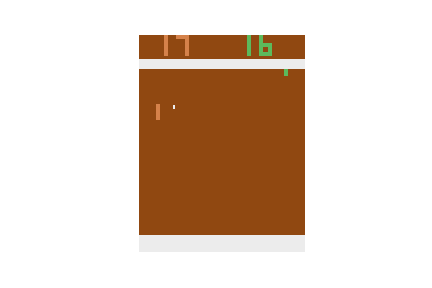
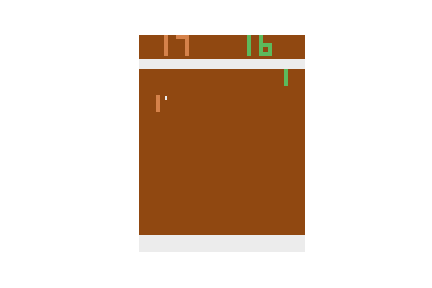
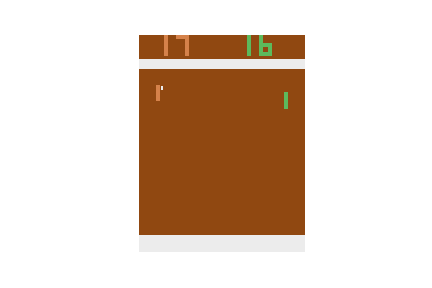
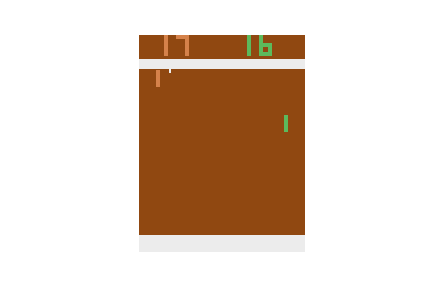
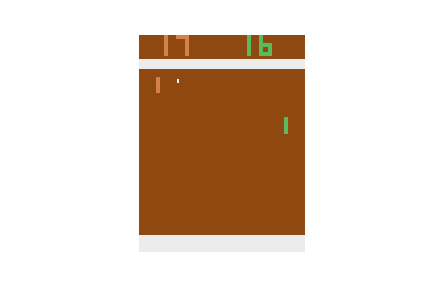
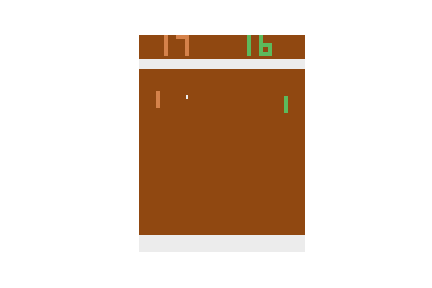
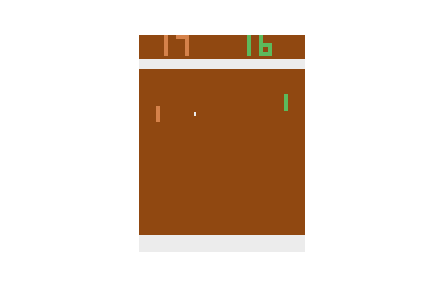
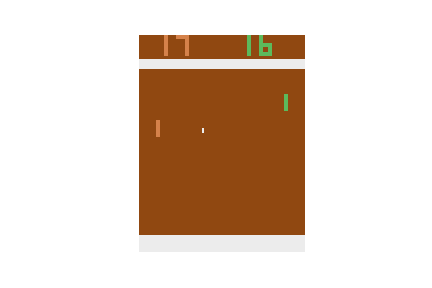
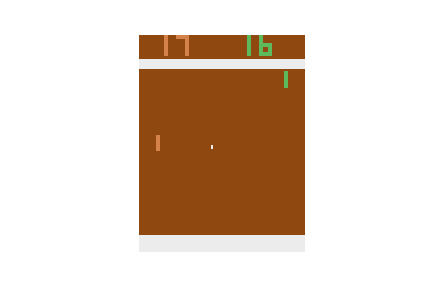
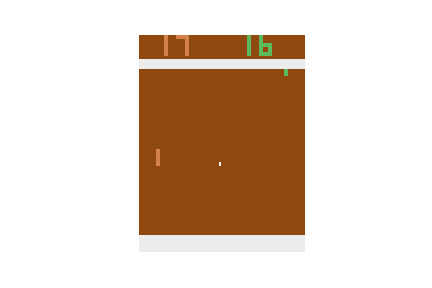
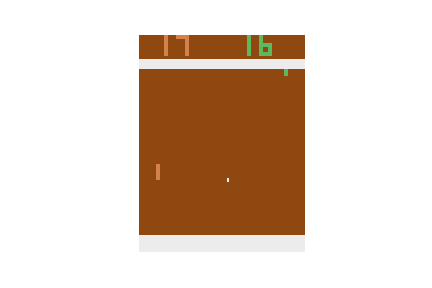
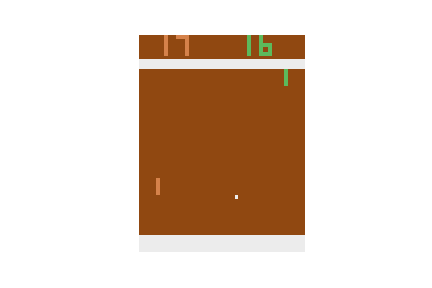
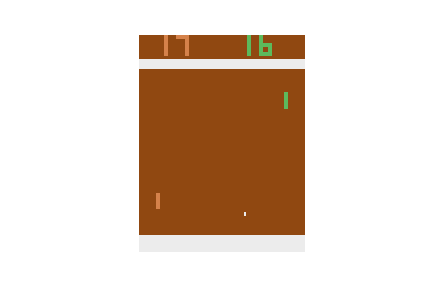
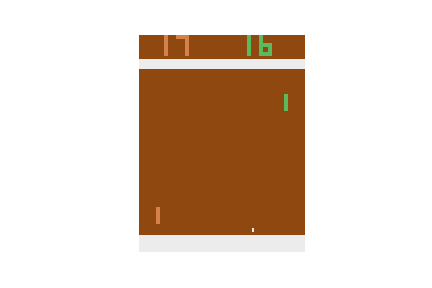
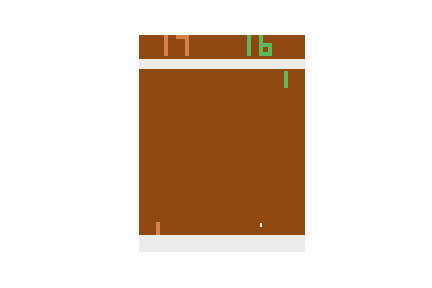
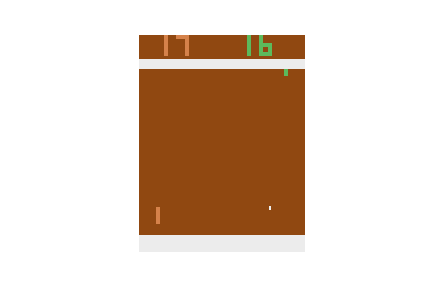
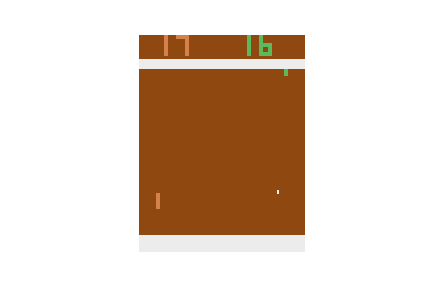
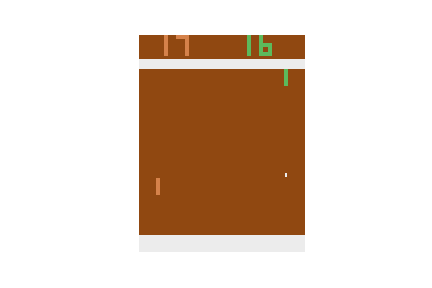
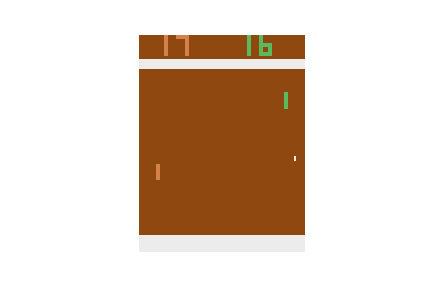
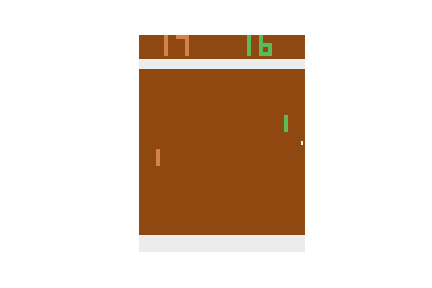
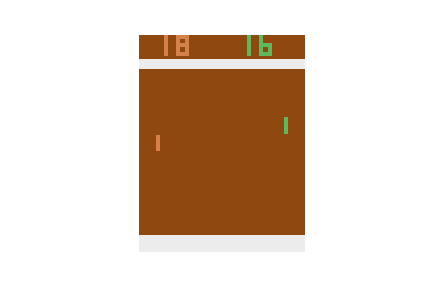
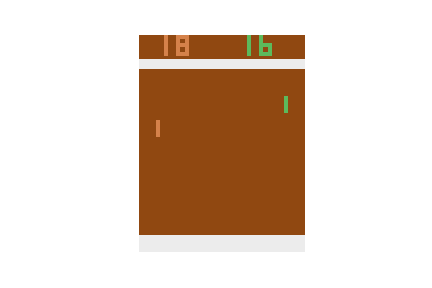
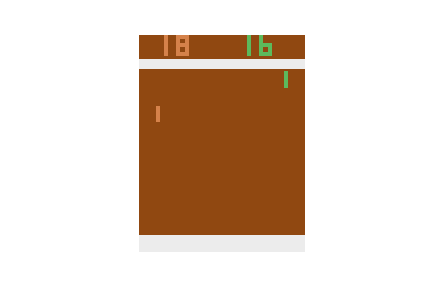
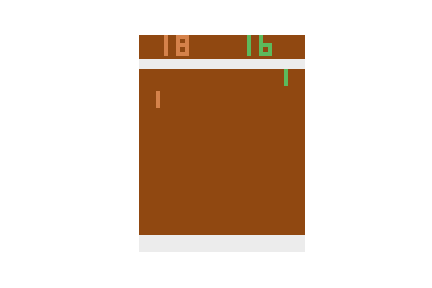
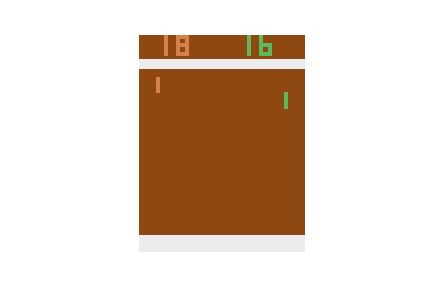
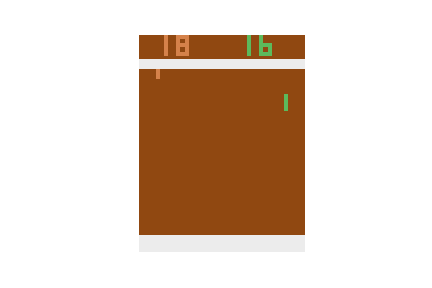
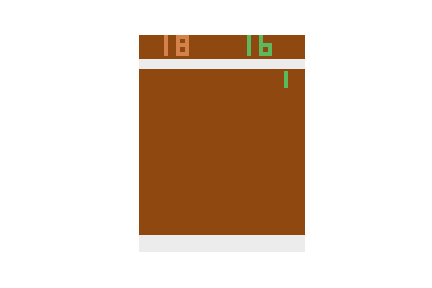
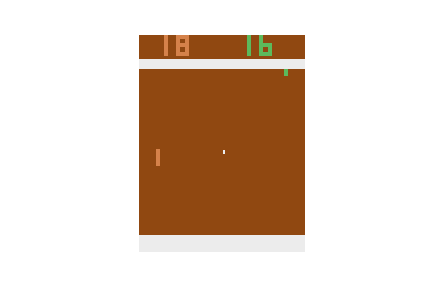
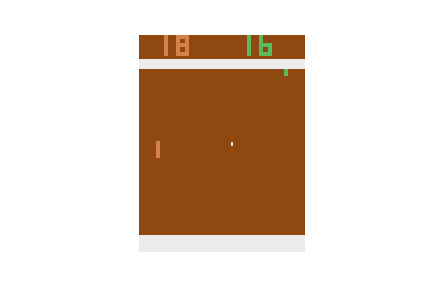
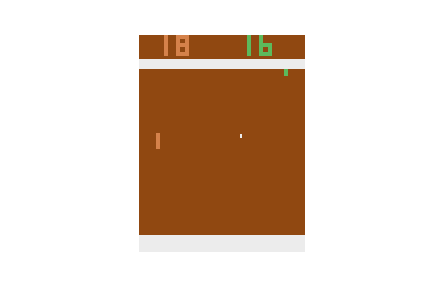
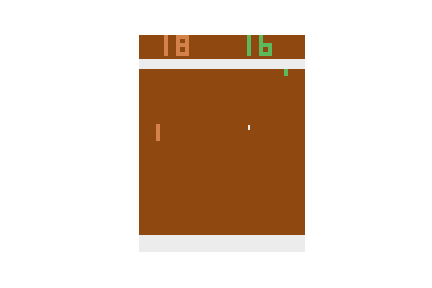
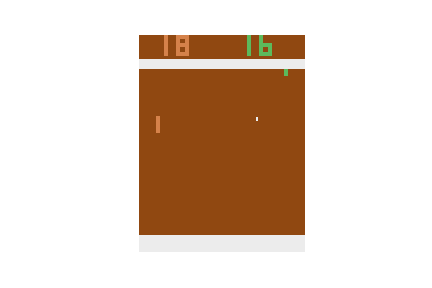
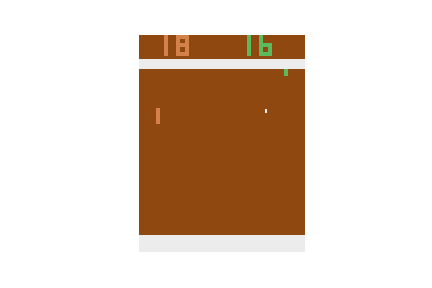
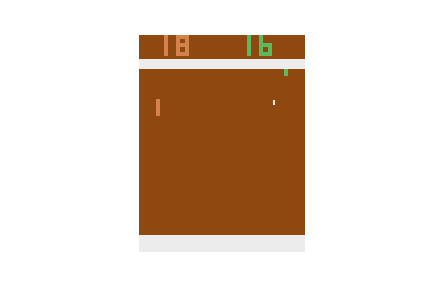
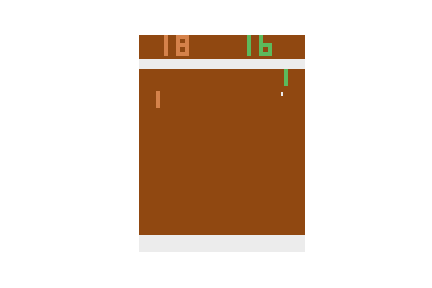
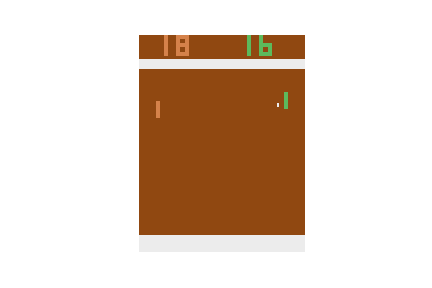
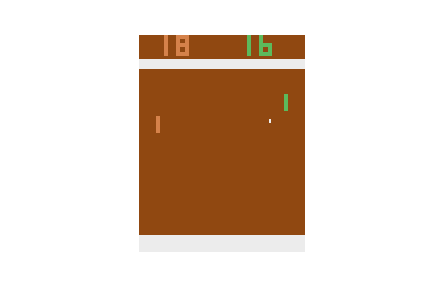
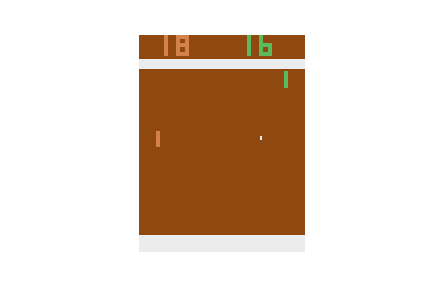
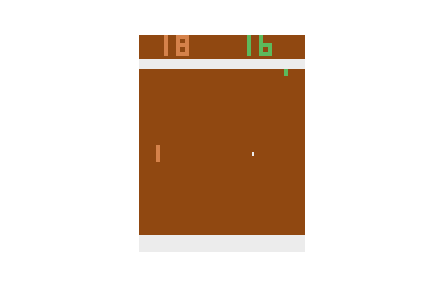
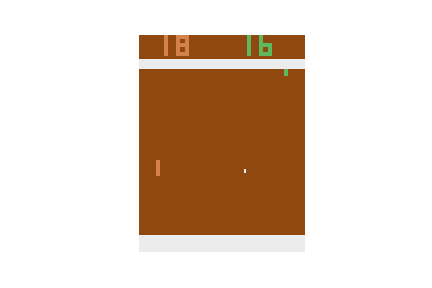
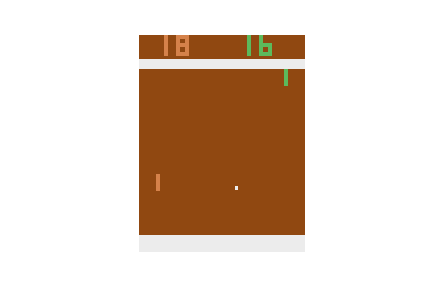
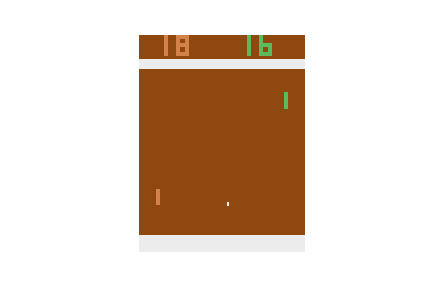
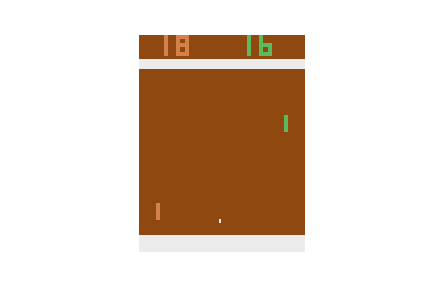
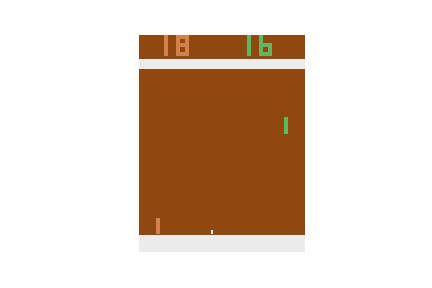
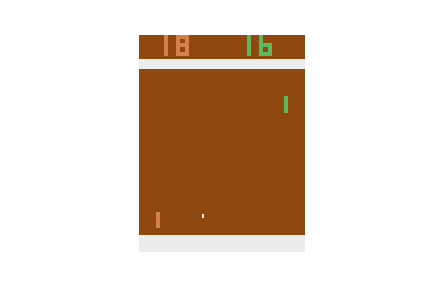
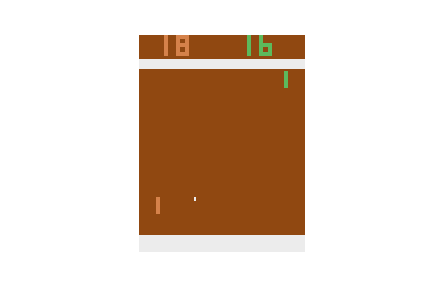
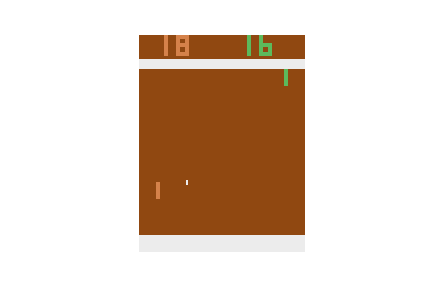
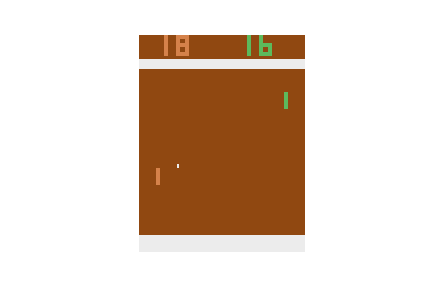
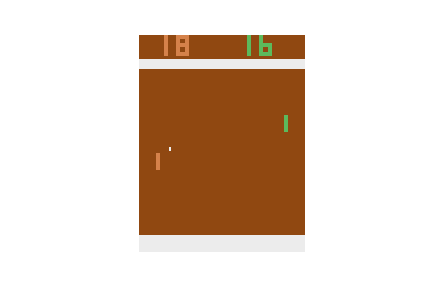
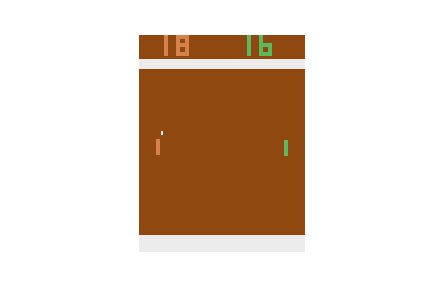
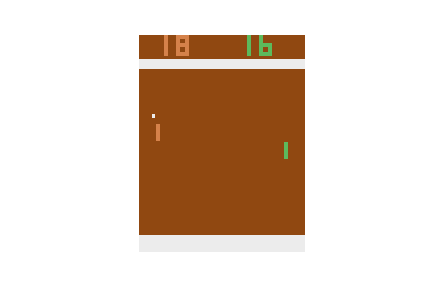
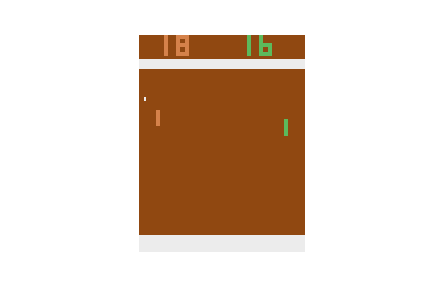
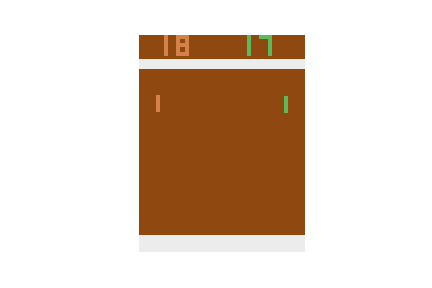
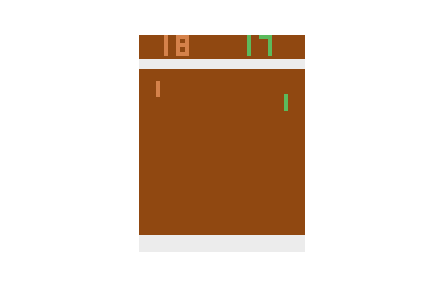
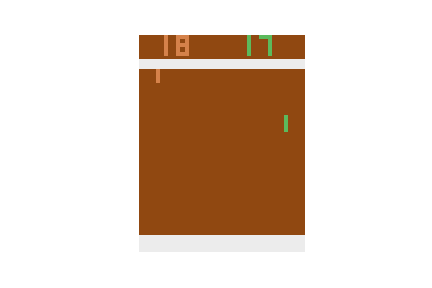
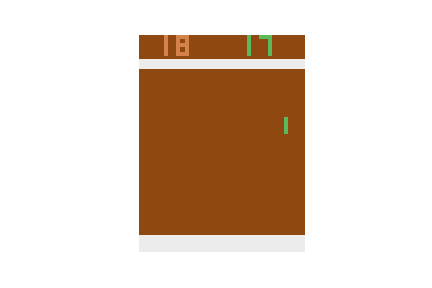
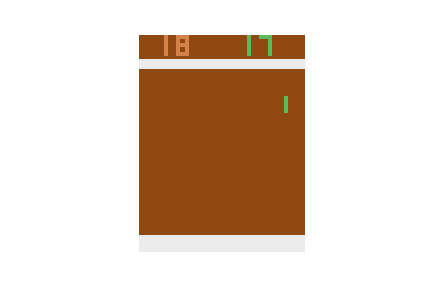
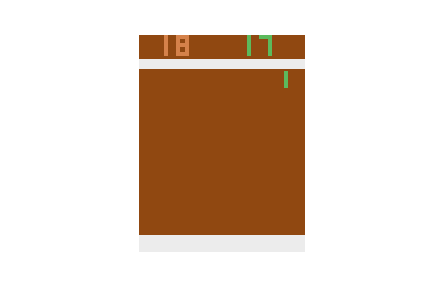
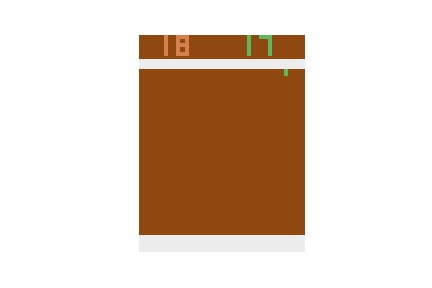
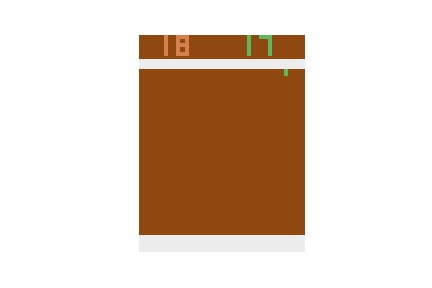
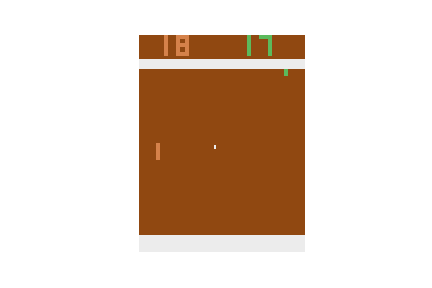
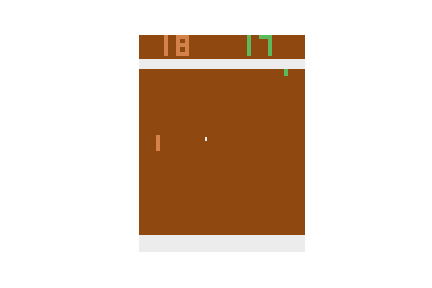
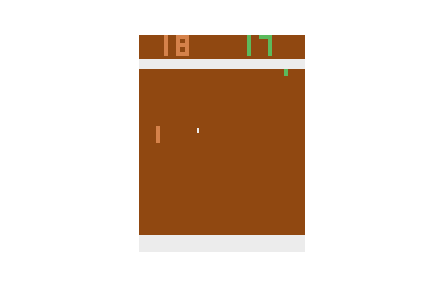
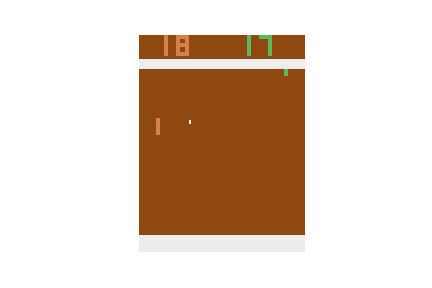
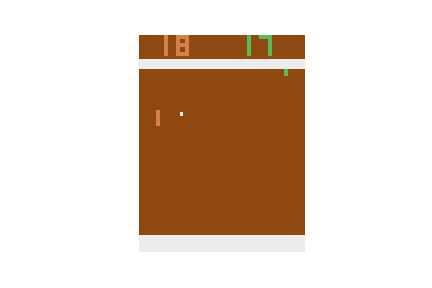
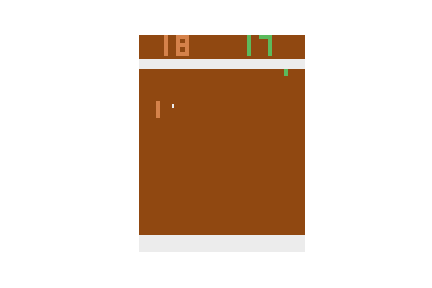
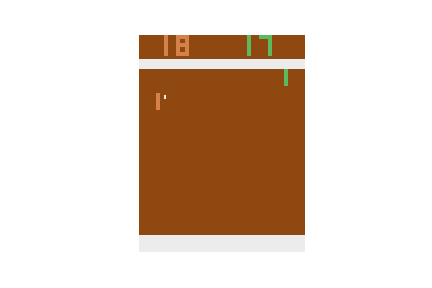
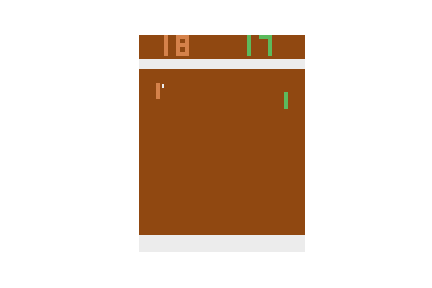
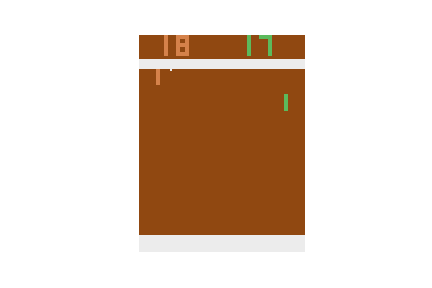
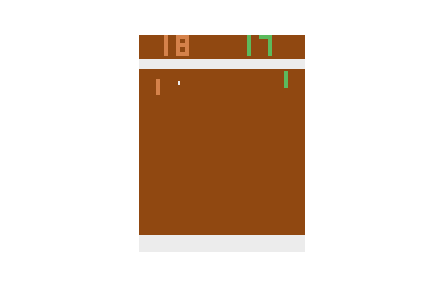
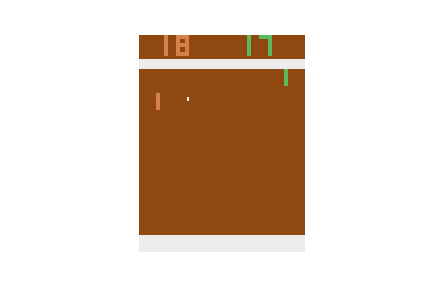
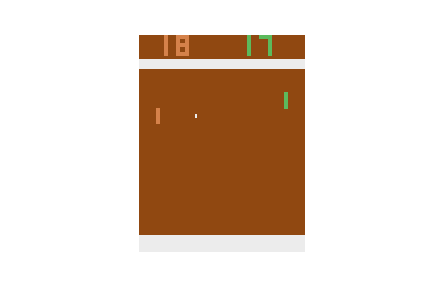
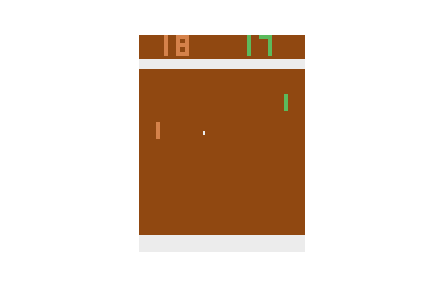
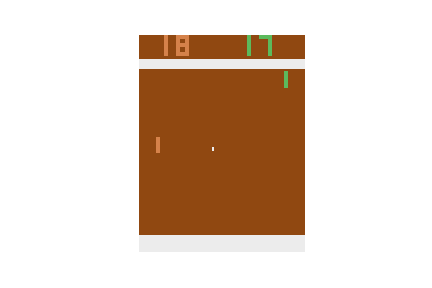
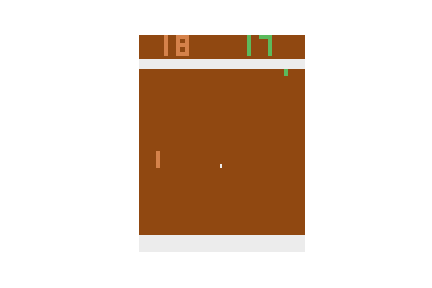
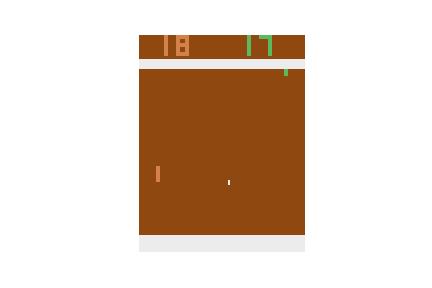
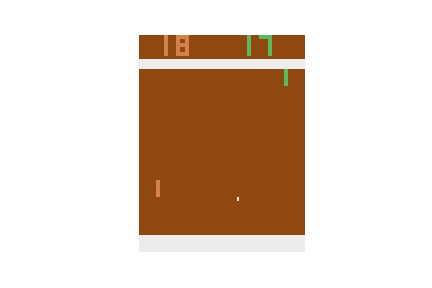
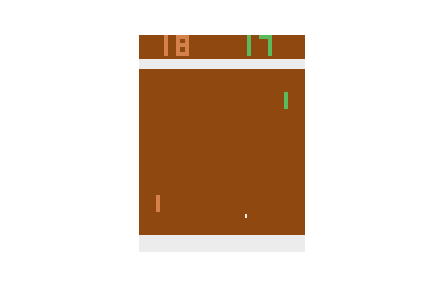
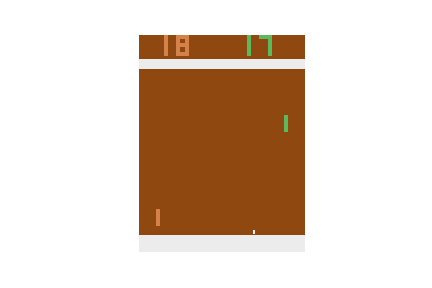
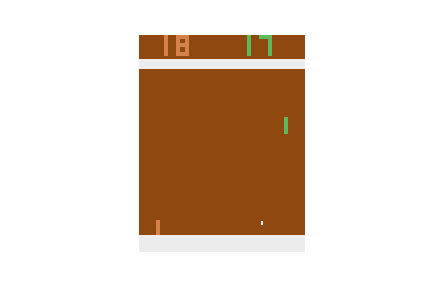
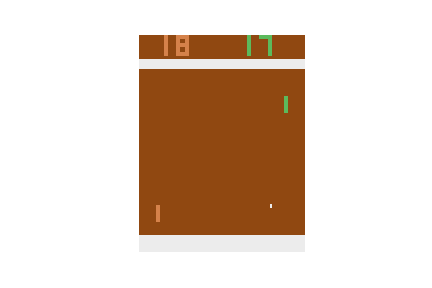
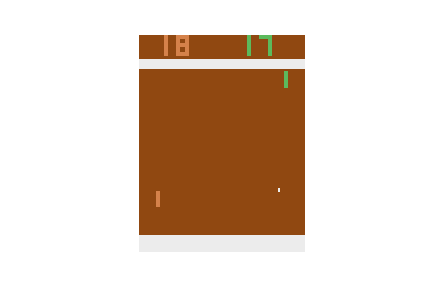
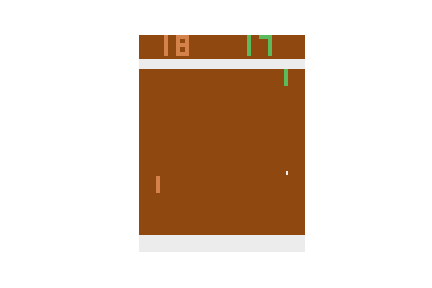
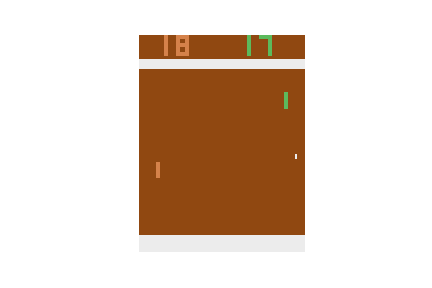
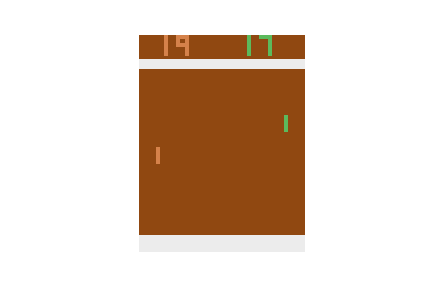
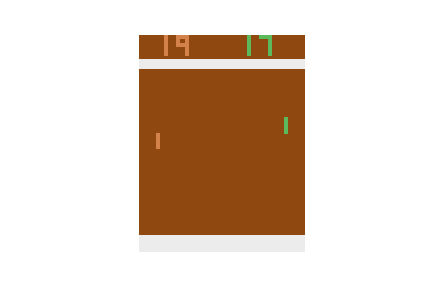
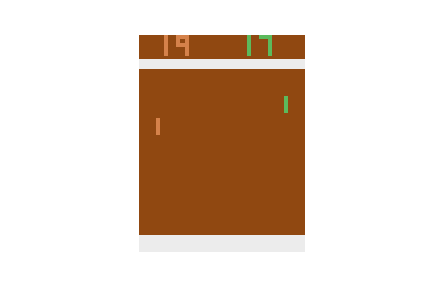
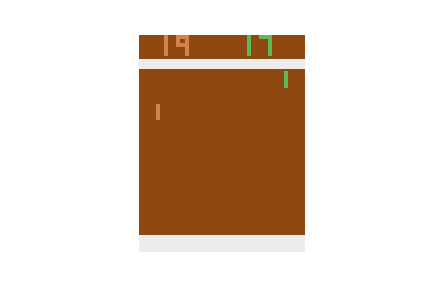
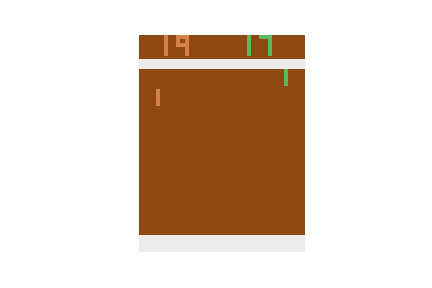
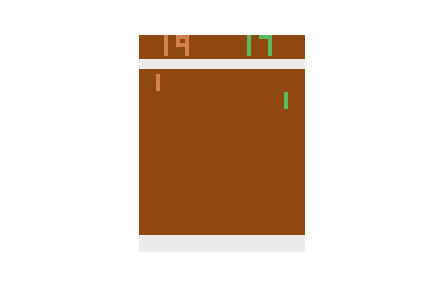
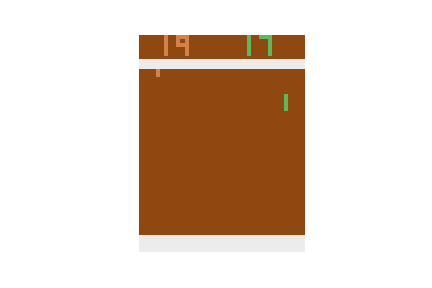
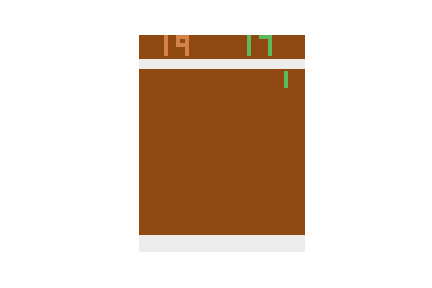
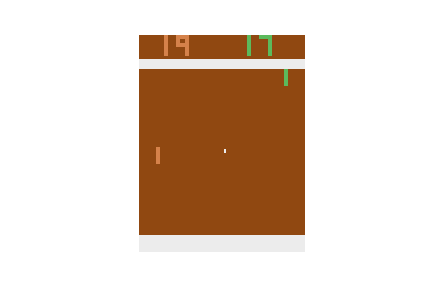
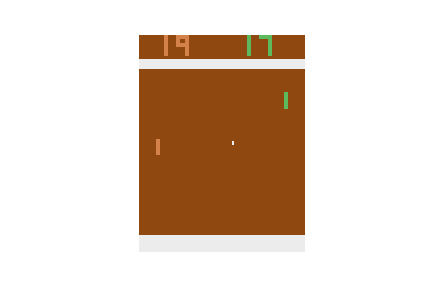
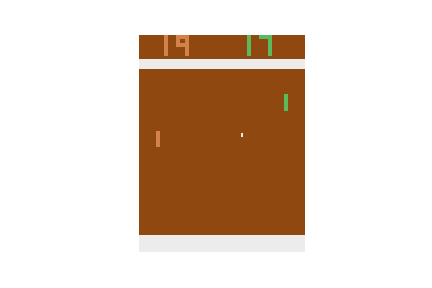
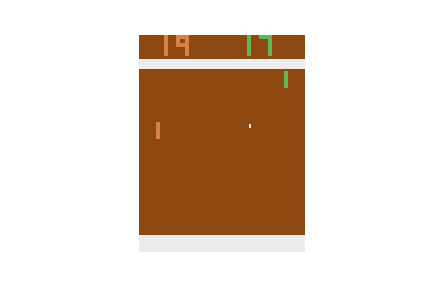
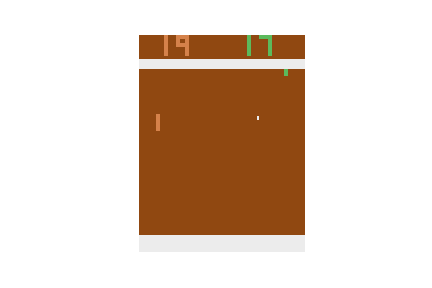
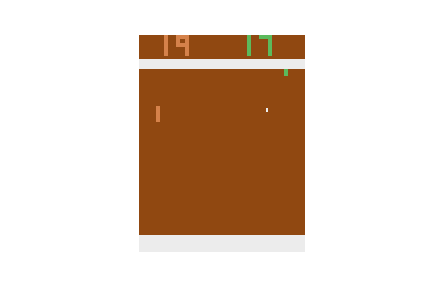
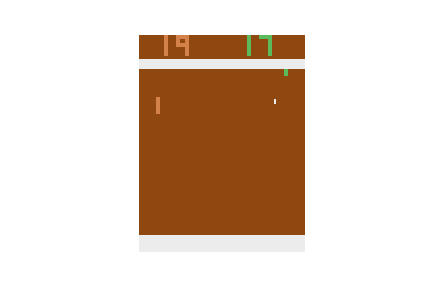
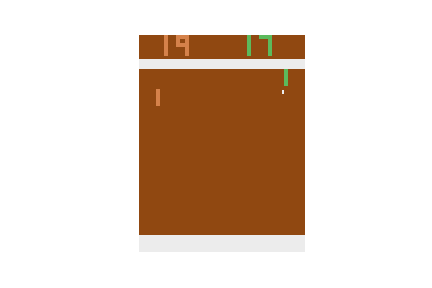
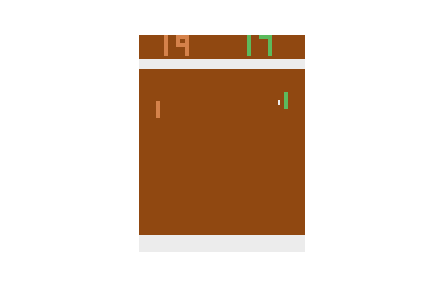
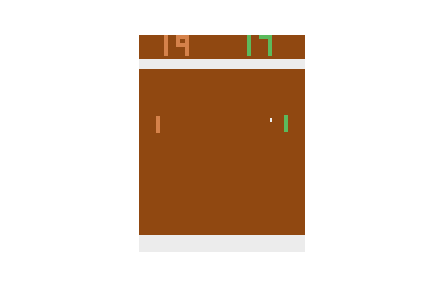
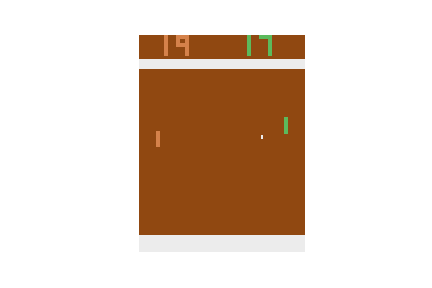
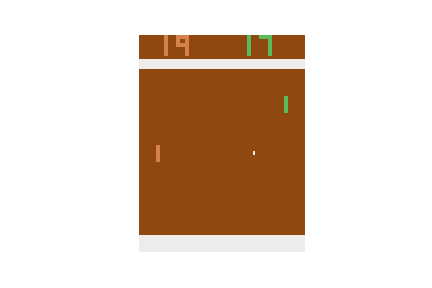
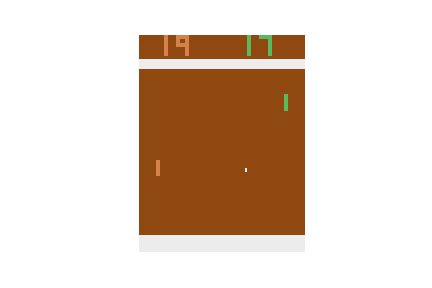
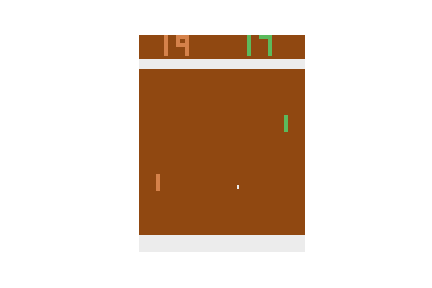
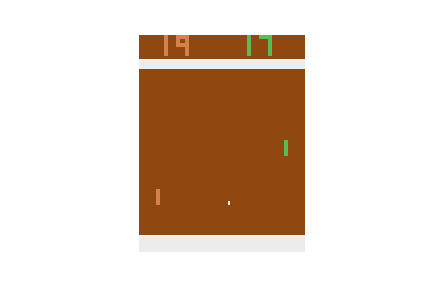
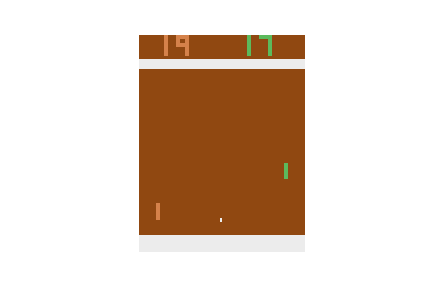
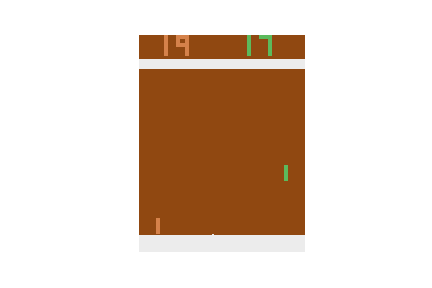
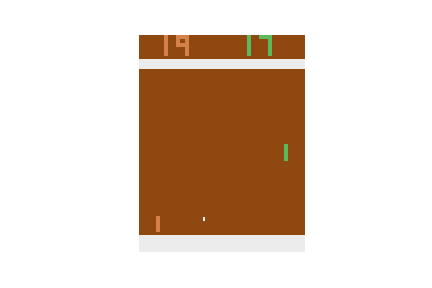
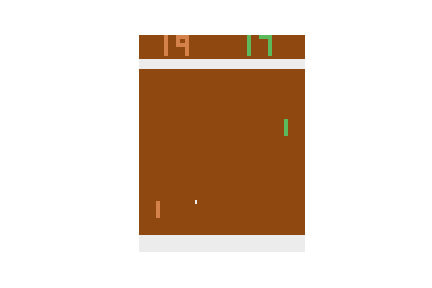
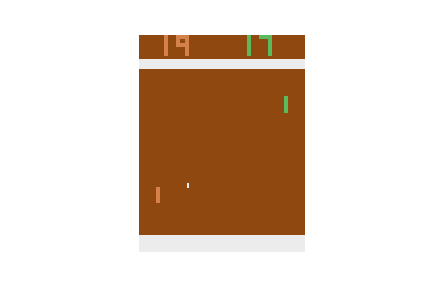
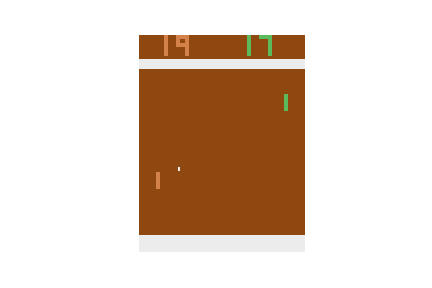
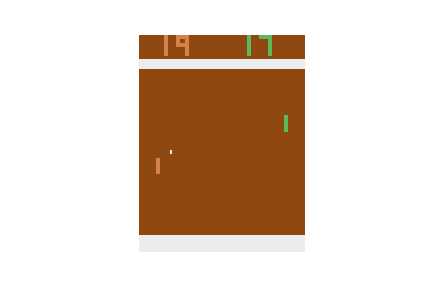
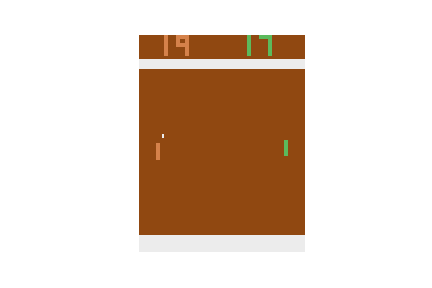
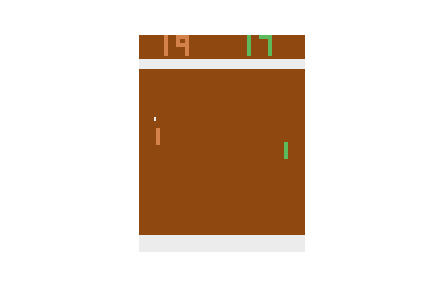
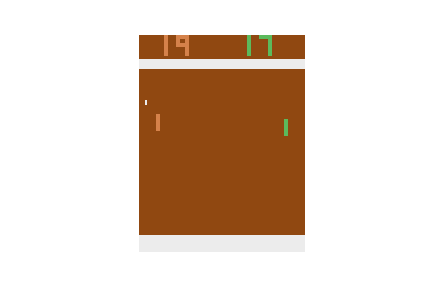
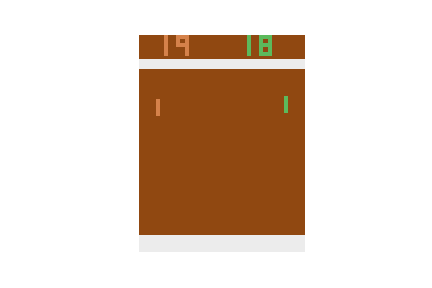
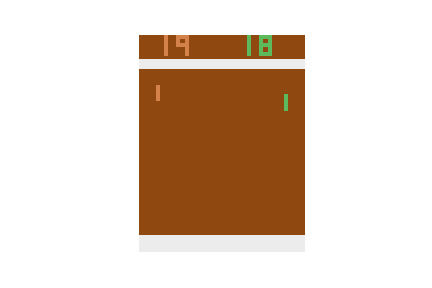
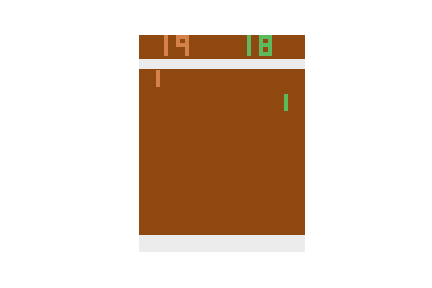
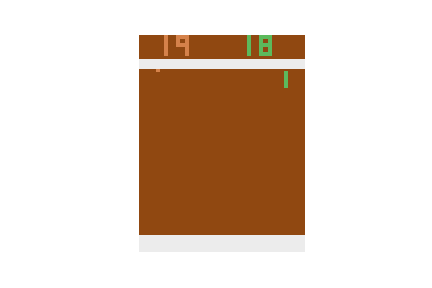
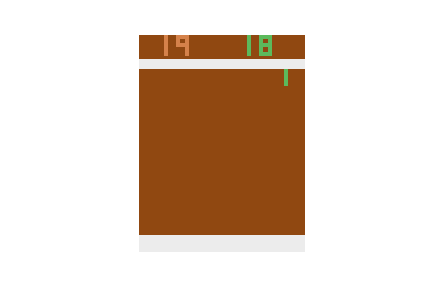
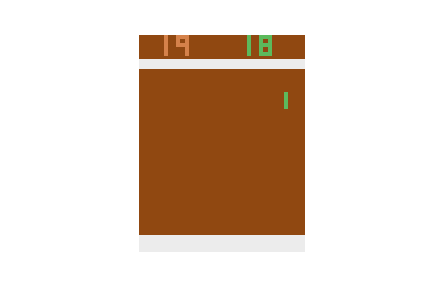
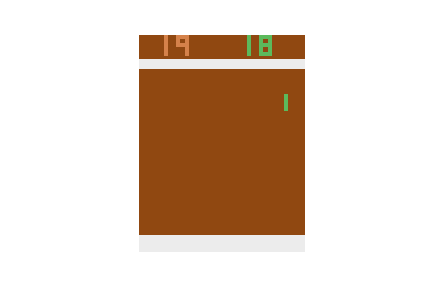
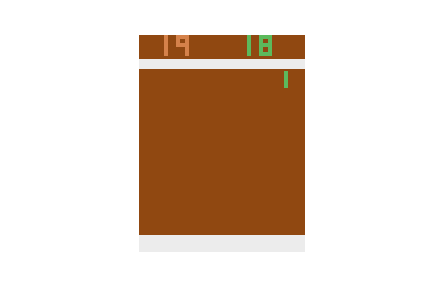
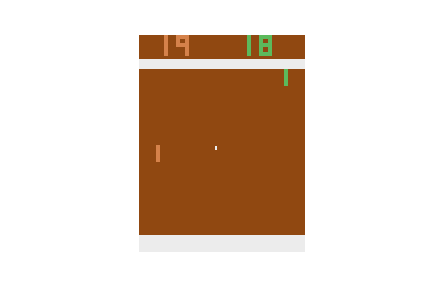
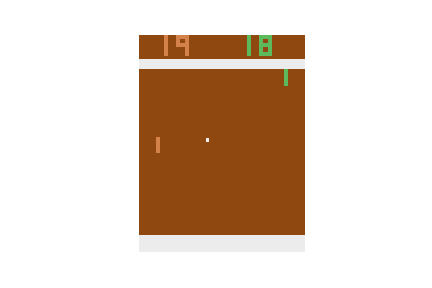
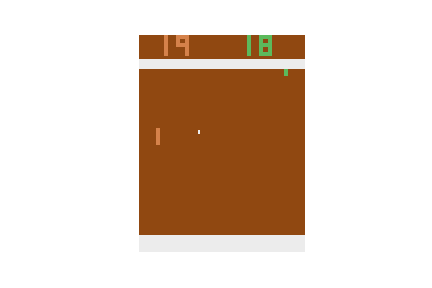
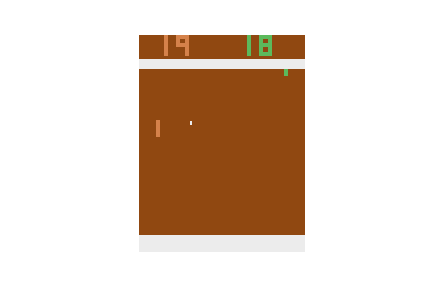
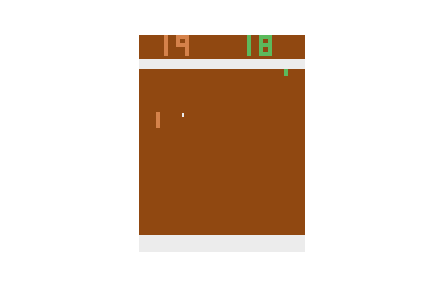
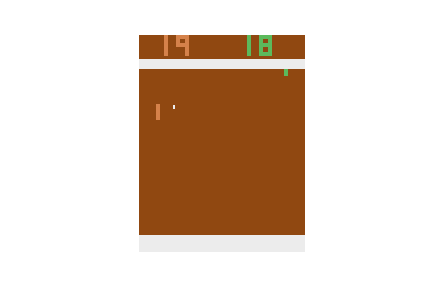
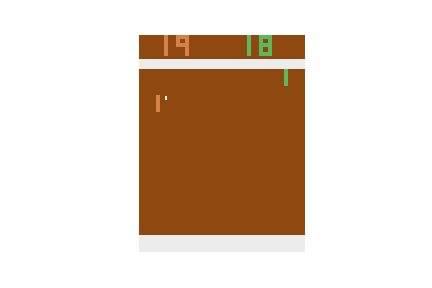
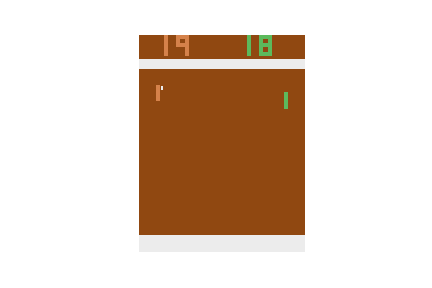
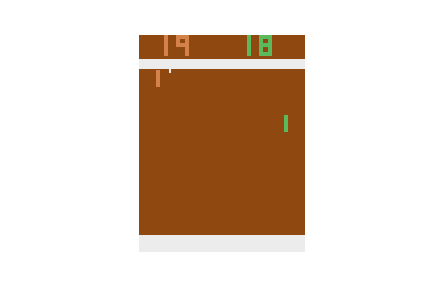
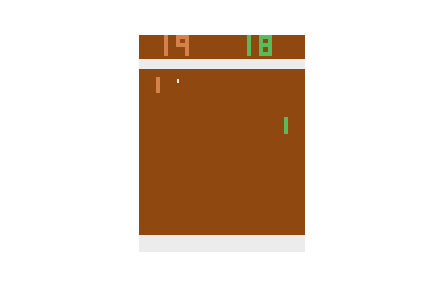
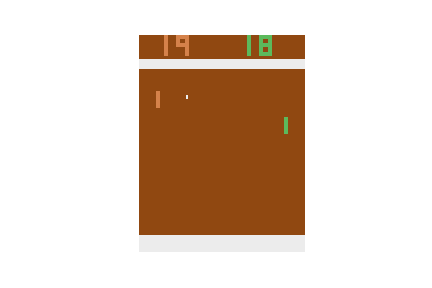
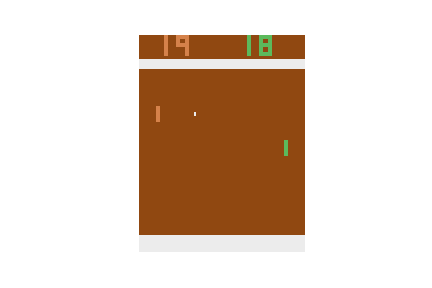
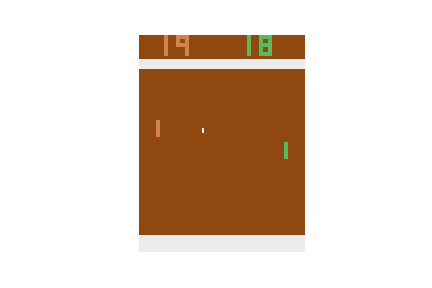
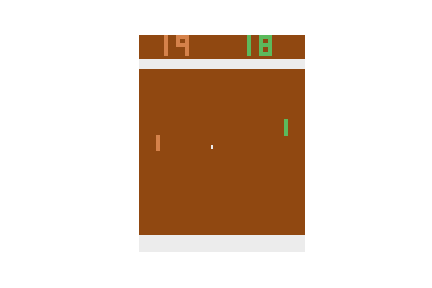
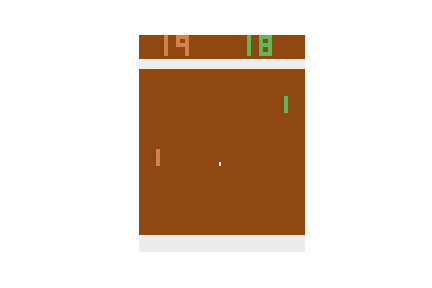
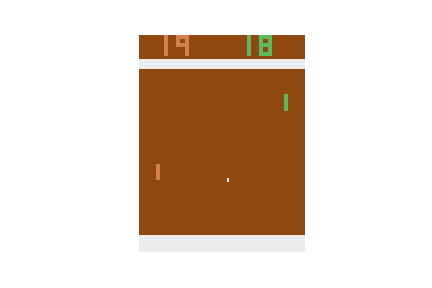
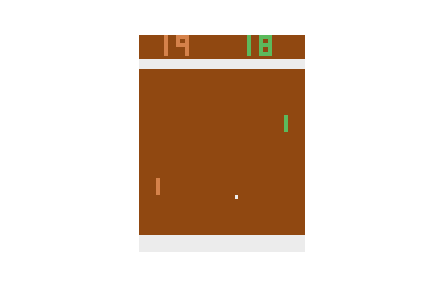
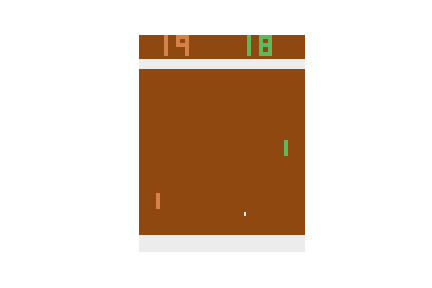
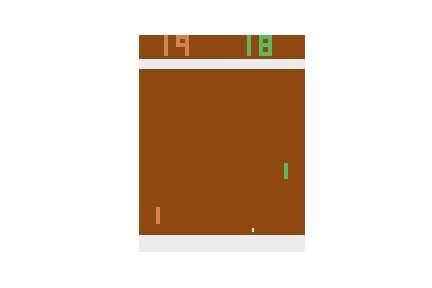
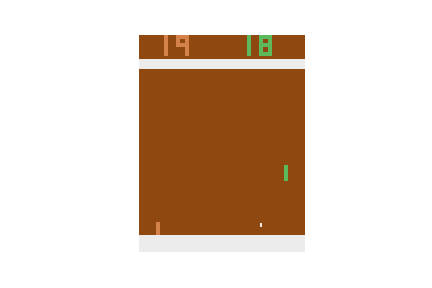
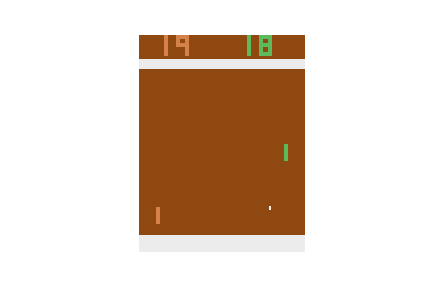
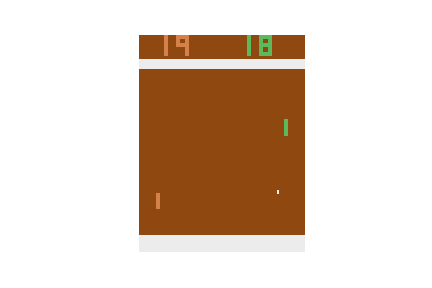
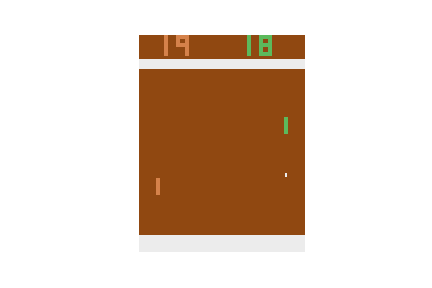
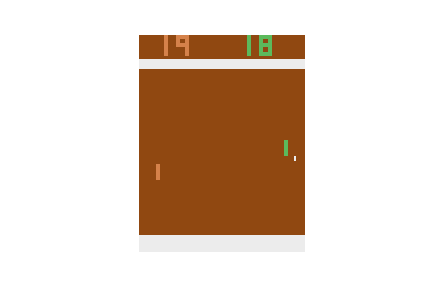
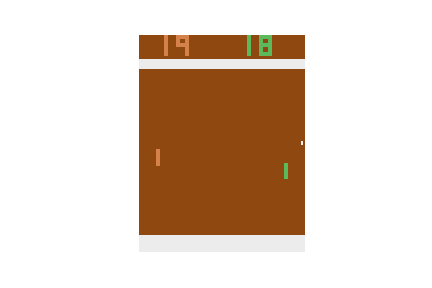
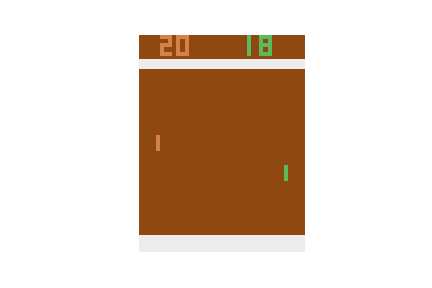
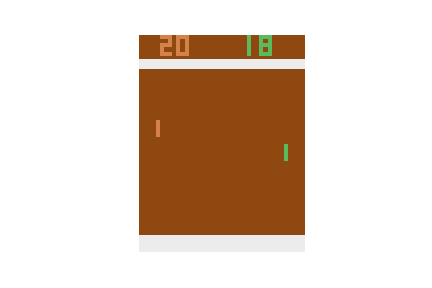
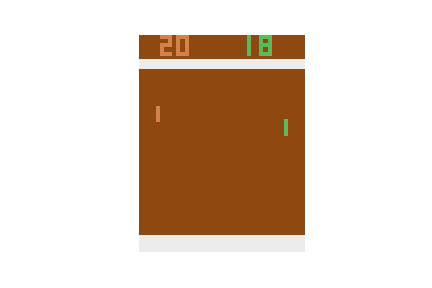
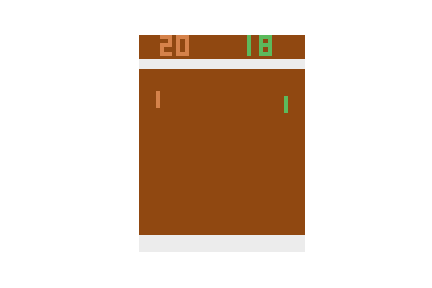
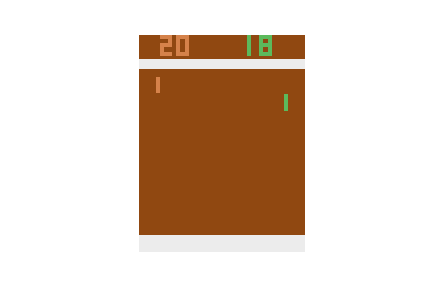
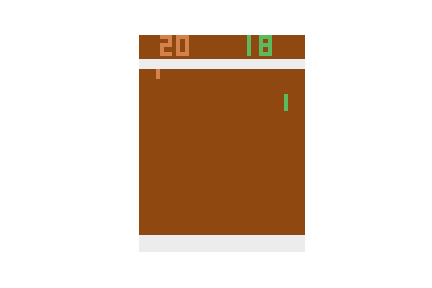
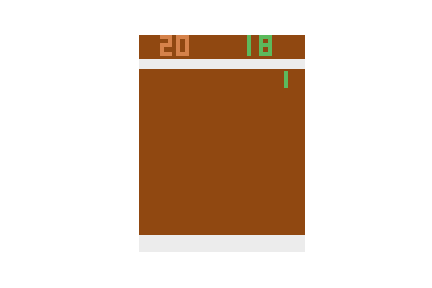
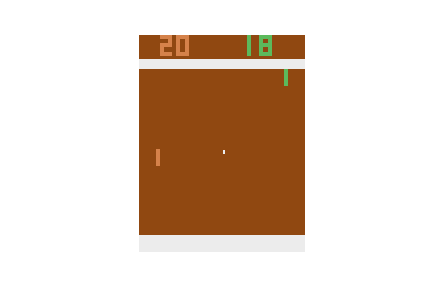
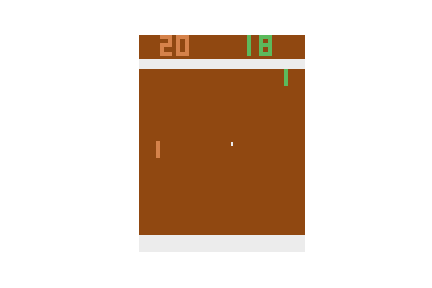
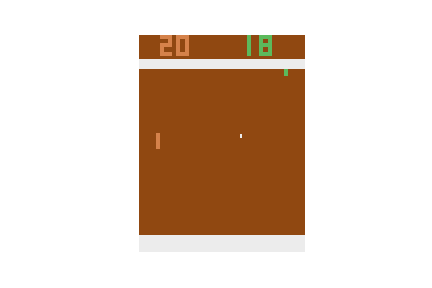
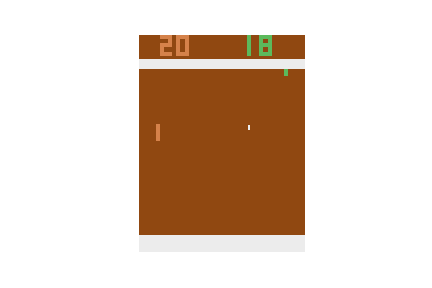
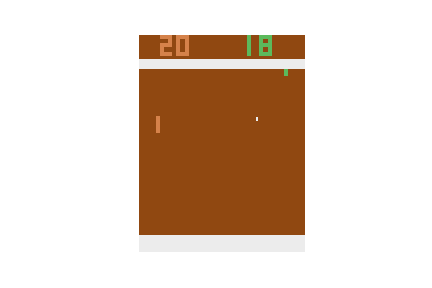
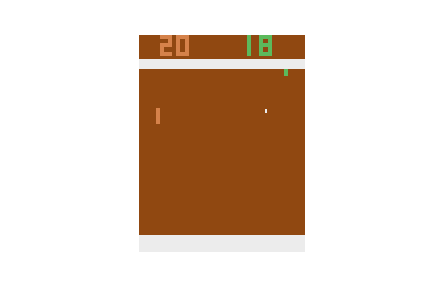
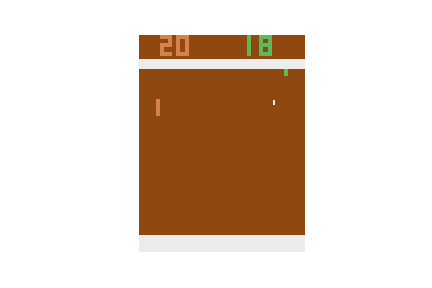
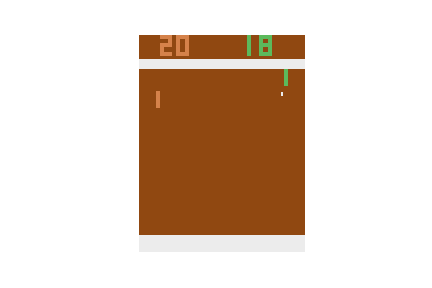
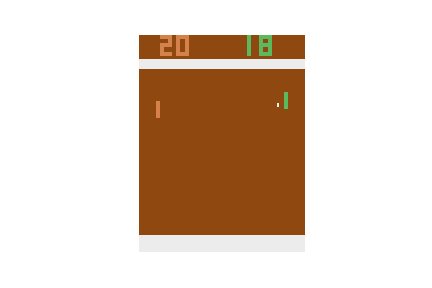
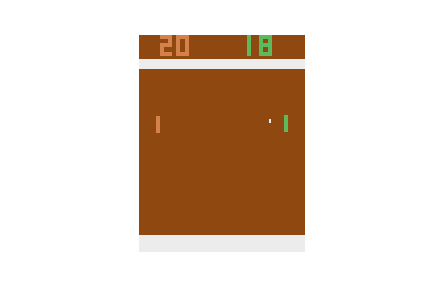
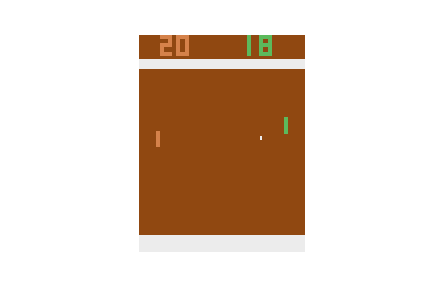
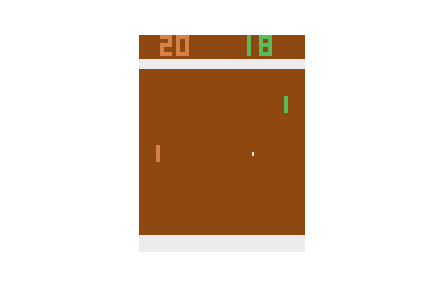
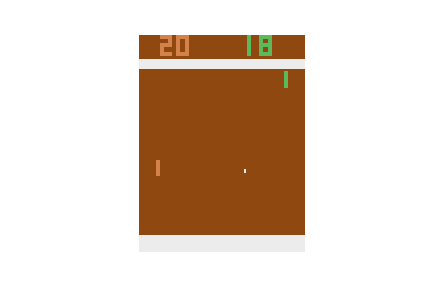
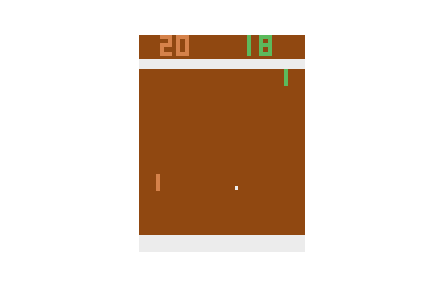
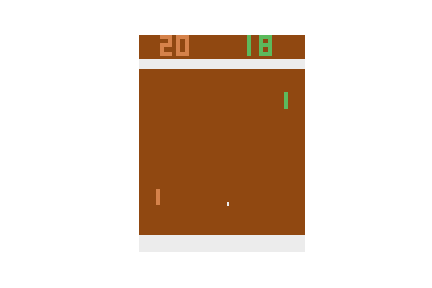
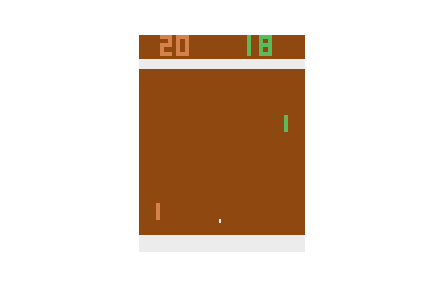
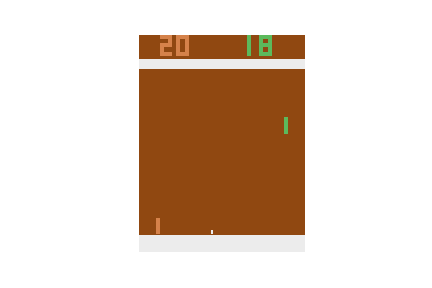
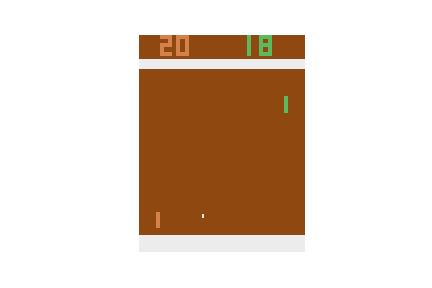
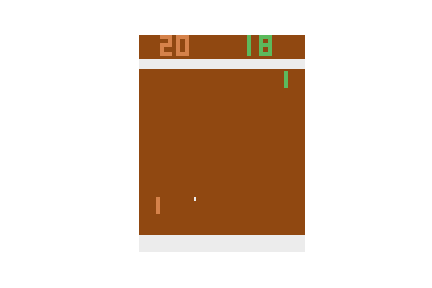
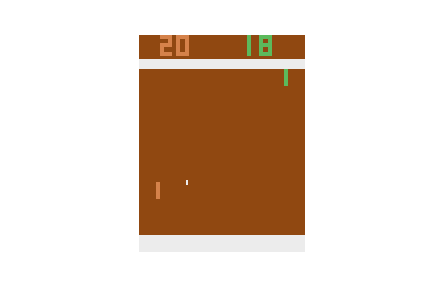
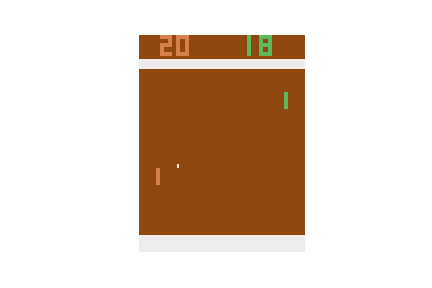
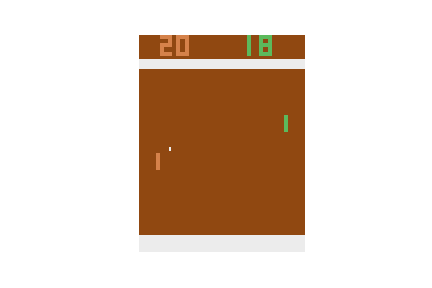
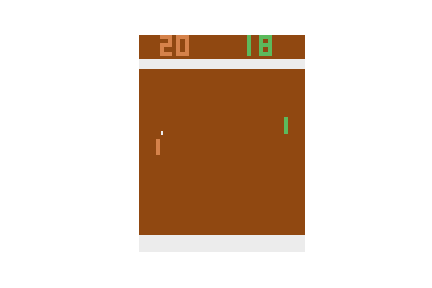
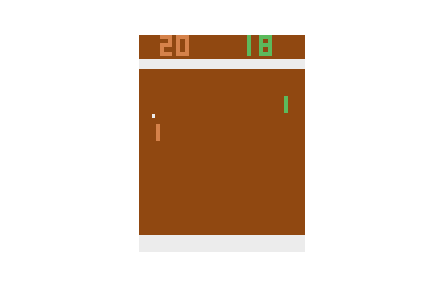
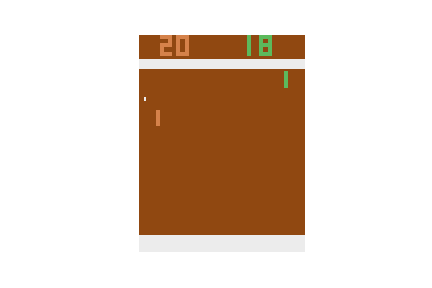
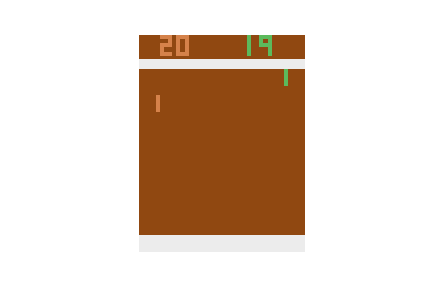
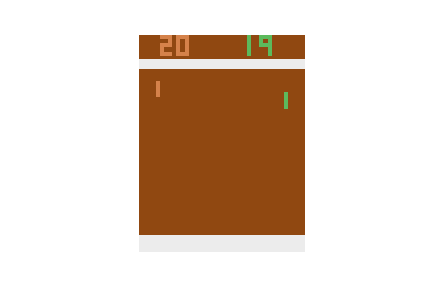
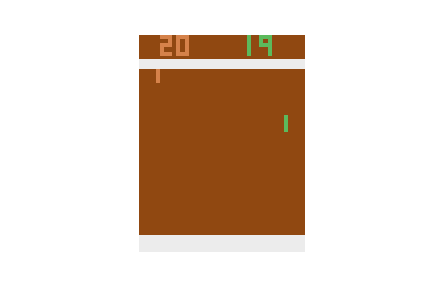
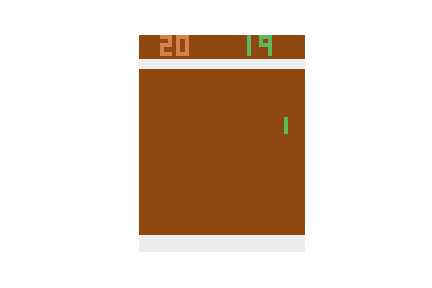
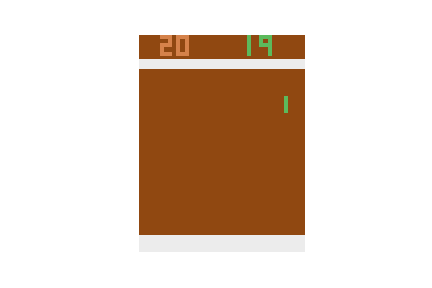
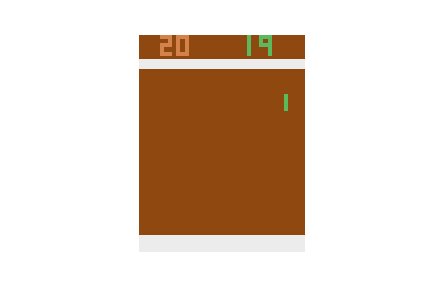
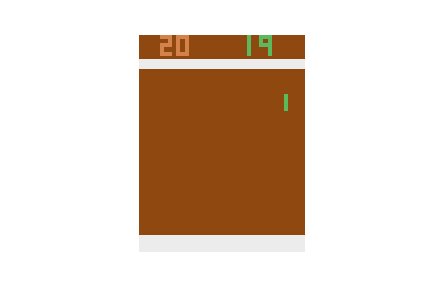
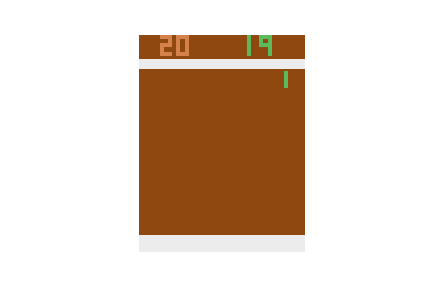
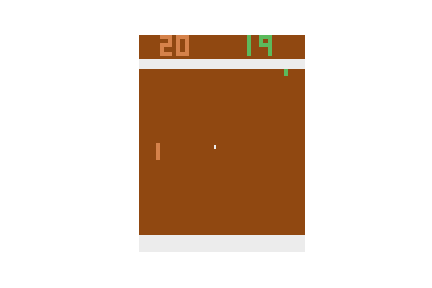
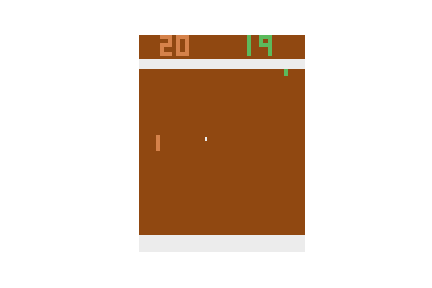
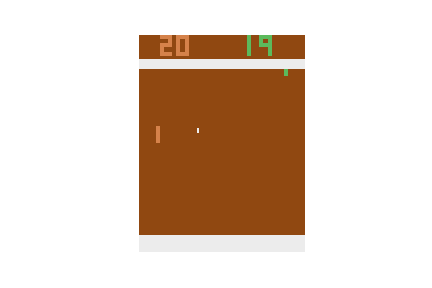
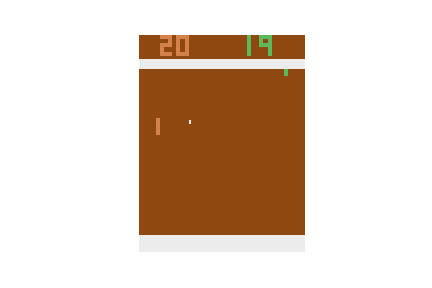
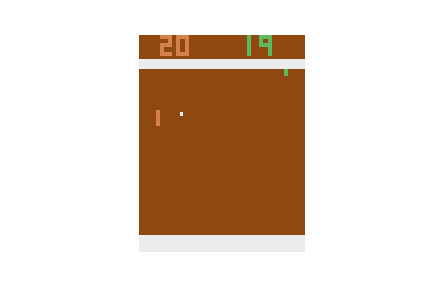
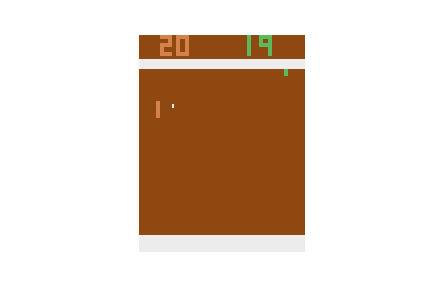
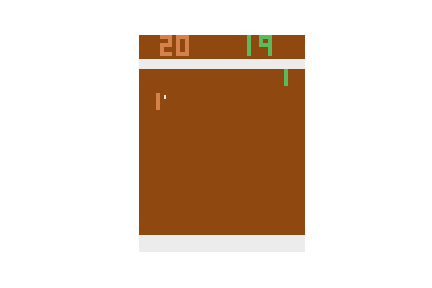
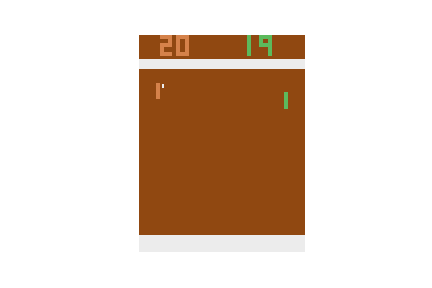
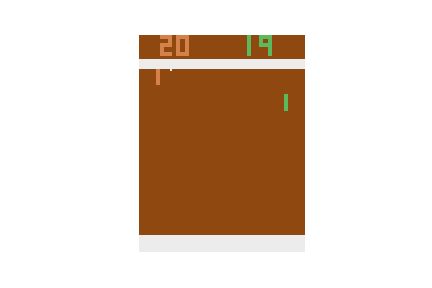
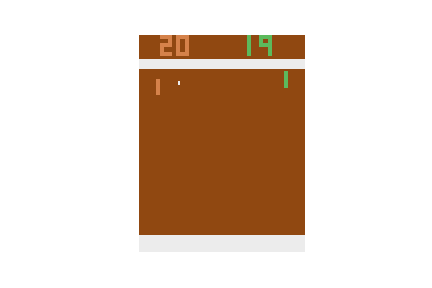
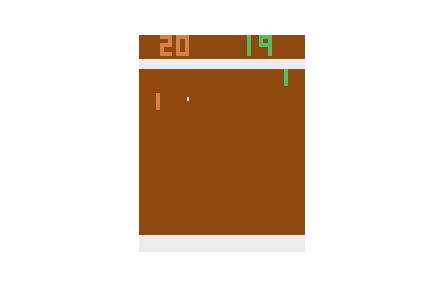
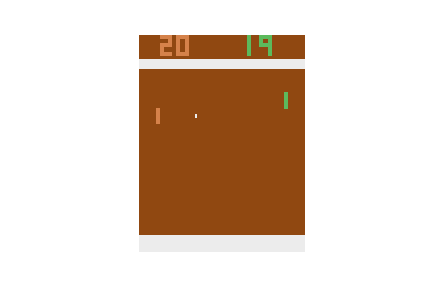
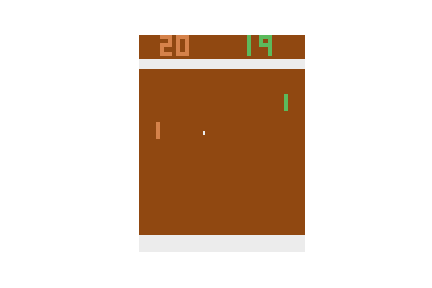
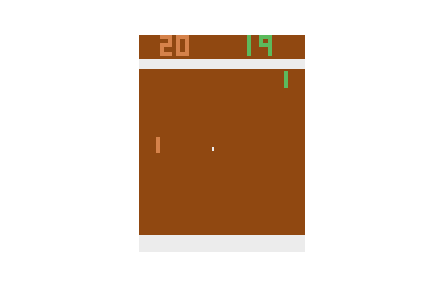
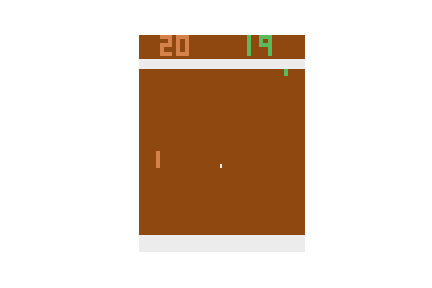
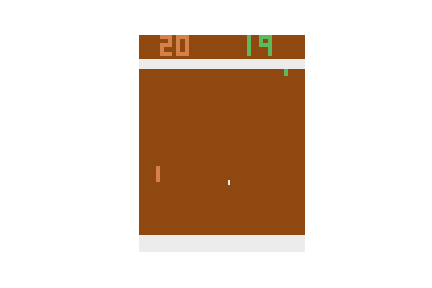
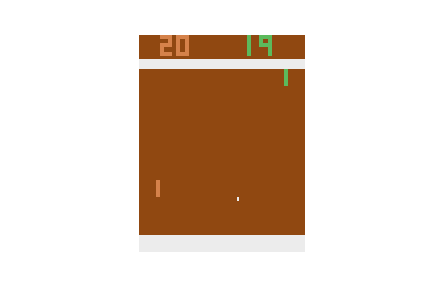
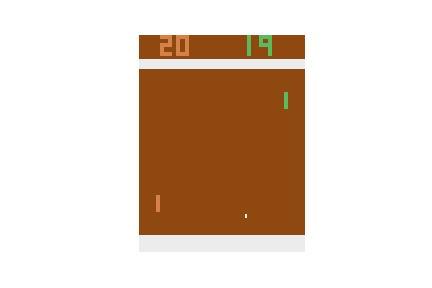
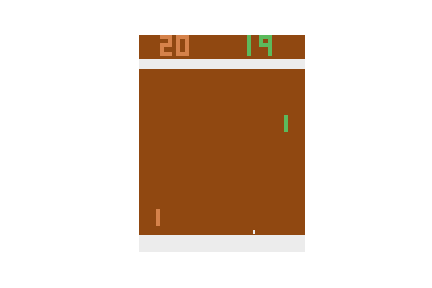
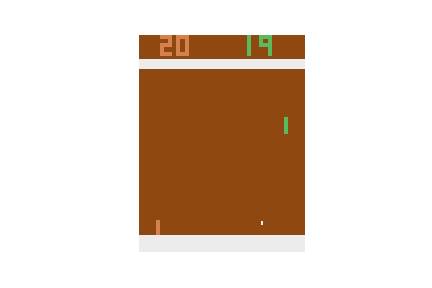
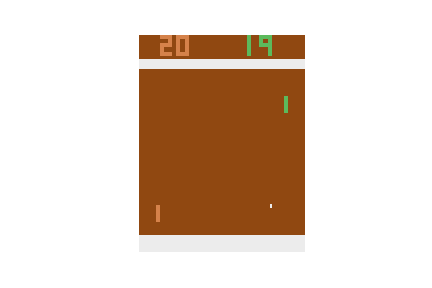
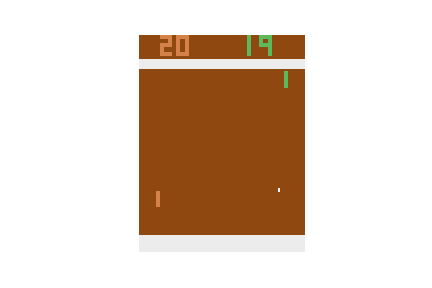
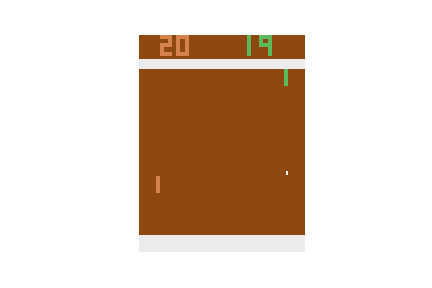
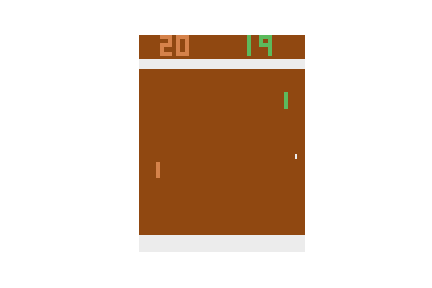
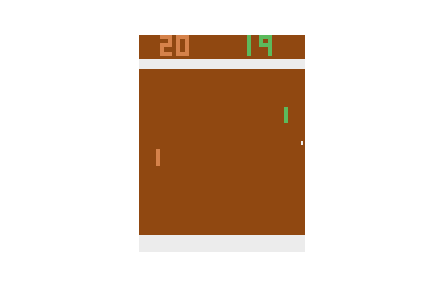

In [11]:
# play game after training!
pong_utils.play(env, policy, time=2000) 

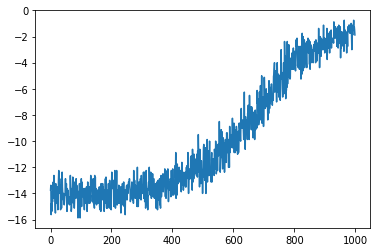

In [12]:
plt.plot(mean_rewards)

In [13]:
# save your policy!
torch.save(policy, 'REINFORCE.policy')

# load your policy if needed
# policy = torch.load('REINFORCE.policy')

# try and test out the solution!
# policy = torch.load('PPO_solution.policy')

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Policy. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [14]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

!pip install pyvirtualdisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1005'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1005'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [15]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")
    

def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

def preprocess_batch(images, bkg_color = np.array([144, 72, 17])):
    list_of_images = np.asarray(images)
    if len(list_of_images.shape) < 5:
        list_of_images = np.expand_dims(list_of_images, 1)
    # subtract bkg and crop
    list_of_images_prepro = np.mean(list_of_images[:,:,34:-16:2,::2]-bkg_color,
                                    axis=-1)/255.
    batch_input = np.swapaxes(list_of_images_prepro,0,1)
    return torch.from_numpy(batch_input).float().to(device)

In [16]:
import random as rand
def playView(env, policy, time=2000, preprocess=None, nrand=5):
    env = wrap_env(gym.make('PongDeterministic-v4'))
    env.reset()
    # star game
    env.step(1)
    
    # perform nrand random steps in the beginning
    for _ in range(nrand):
        frame1, reward1, is_done, _ = env.step(np.random.choice([RIGHT,LEFT]))
        frame2, reward2, is_done, _ = env.step(0)
    
    
    #Utilize policy to do things
    for _ in range(time):
        #Preprocess input to capture direction and velocity
        frame_input = preprocess_batch([frame1, frame2])
        prob = policy(frame_input)
        
        # RIGHT = 4, LEFT = 5
        action = RIGHT if rand.random() < prob else LEFT
        frame1, _, is_done, _ = env.step(action)
        frame2, _, is_done, _ = env.step(0)

        

        if is_done:
            break
    
    env.close()
    
    show_video()
    return 

playView(env, policy, time=500)